In [1]:
#! sudo apt-get install libsqlite3-mod-spatialite spatialite-bin
#! pip install -U sqlalchemy geoalchemy geoalchemy2

In [1]:
# importando bibliotecas

import sqlalchemy, json
from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.event import listen
from sqlalchemy.sql import select, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import relationship, backref

from geoalchemy2 import Geometry, WKTElement

 Usaremos o sqlalchemy para carregar os dados em formato geojson para a base de dados em gis.sqlite
 
 Cada dado na base tem os atributos 'id', 'name' (cidade) e 'geom' (polígono)

## Banco de dados para irrigação

In [2]:
def load_spatialite(dbapi_conn, connection_record):
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension('/usr/lib/x86_64-linux-gnu/mod_spatialite.so')

In [3]:
# verificando se  gis.sqlite já existe
try:
    os.remove('irrigacao.sqlite')
    print("removed file")
except:
    print("file in use or not found")

file in use or not found


In [4]:
engine = create_engine('sqlite:///irrigacao.sqlite', echo=True)
listen(engine, 'connect', load_spatialite)

In [5]:
# criando conexão
conn = engine.connect()

In [6]:
# esta célula pode levar de 10  a 20 minutos para executar

conn.execute(select([func.InitSpatialMetaData()]))

2021-11-20 02:10:22,315 INFO sqlalchemy.engine.Engine SELECT InitSpatialMetaData() AS "InitSpatialMetaData_1"
2021-11-20 02:10:22,317 INFO sqlalchemy.engine.Engine [generated in 0.00229s] ()


In [7]:
Base = declarative_base()

class Irrigacao(Base):
    __tablename__ = 'irrigacoes'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    area = Column(Float)
    geom = Column(Geometry(geometry_type='POLYGON', management=True))

In [8]:
# Código para o excluir dados quando necessário

Irrigacao.__table__.drop(engine)

2021-11-20 02:10:23,138 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:10:23,141 INFO sqlalchemy.engine.Engine SELECT DiscardGeometryColumn(?, ?) AS "DiscardGeometryColumn_1"
2021-11-20 02:10:23,143 INFO sqlalchemy.engine.Engine [generated in 0.00175s] ('irrigacoes', 'geom')
2021-11-20 02:10:24,226 INFO sqlalchemy.engine.Engine 
DROP TABLE irrigacoes
2021-11-20 02:10:24,227 INFO sqlalchemy.engine.Engine [no key 0.00122s] ()
2021-11-20 02:10:28,973 INFO sqlalchemy.engine.Engine COMMIT


In [9]:
# Iniciando tabela

Irrigacao.__table__.create(engine)

2021-11-20 02:10:28,987 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:10:28,989 INFO sqlalchemy.engine.Engine 
CREATE TABLE irrigacoes (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	area FLOAT, 
	PRIMARY KEY (id)
)


2021-11-20 02:10:28,991 INFO sqlalchemy.engine.Engine [no key 0.00138s] ()
2021-11-20 02:10:29,179 INFO sqlalchemy.engine.Engine SELECT AddGeometryColumn(?, ?, ?, ?, ?, ?) AS "AddGeometryColumn_1"
2021-11-20 02:10:29,180 INFO sqlalchemy.engine.Engine [no key 0.00125s] ('irrigacoes', 'geom', -1, 'POLYGON', 2, 0)
2021-11-20 02:10:30,197 INFO sqlalchemy.engine.Engine SELECT CreateSpatialIndex(?, ?) AS "CreateSpatialIndex_1"
2021-11-20 02:10:30,198 INFO sqlalchemy.engine.Engine [generated in 0.00121s] ('irrigacoes', 'geom')
2021-11-20 02:10:31,593 INFO sqlalchemy.engine.Engine COMMIT


In [10]:
# Inicia a sessão

Session = sessionmaker(bind=engine)
session = Session()

In [11]:
# lê os dados e guarda em 'data'
data = json.load(open('area_irrigada.geojson'))

In [12]:
# adiciona os dados ao banco

for i in data['features']:
    geom = ','.join([str(u[0]) + ' ' + str(u[1]) for u in i['geometry']['coordinates'][0]])
    irrigacoes = Irrigacao( name=i['properties']['CONJUNTURA_RHBSNIRH_MUNICIPIO2013NM_MUNICIP'],
                area=i['properties']["CONJUNTURA_RHBSNIRH_AREAMUNIRRIGADAPIVOPIVO_NU_AREAHA"], geom=f'POLYGON(({geom}))')
    session.add(irrigacoes)

session.commit()

2021-11-20 02:10:41,063 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:10:41,093 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,094 INFO sqlalchemy.engine.Engine [generated in 0.00132s] ('ALTO ALEGRE', 368.59375877, 'POLYGON((-63.61441126 3.737679741877092,-63.625454596 3.740667987876971,-63.627057268999984 3.741101658876945,-63.63052785000003 3.741838006876958,-6 ... (90616 characters truncated) ... 738510265877049,-63.594133426 3.73906671687705,-63.600244009999976 3.737957134877059,-63.610524081 3.737124346877118,-63.61441126 3.737679741877092))')
2021-11-20 02:10:41,111 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,112 INFO sqlalchemy.engine.Engine [cached since 0.01859s ago] ('BOA VISTA', 933.00198104, 'POLYGON((-60.475390032000014 3.605727486881423,-60.475788352999984 3.606047258881366,-60.477091665999986 3.605913999

2021-11-20 02:10:41,267 INFO sqlalchemy.engine.Engine [cached since 0.1743s ago] ('IPUEIRAS', 101.01151783, 'POLYGON((-48.409240018 -11.005788528645907,-48.411074214999985 -11.004280352645988,-48.41127587699997 -11.00382772264596,-48.412461038 -11.0024723526 ... (13742 characters truncated) ... ,-48.406292528999984 -11.005769614645951,-48.40663293699998 -11.005723651645905,-48.407629928 -11.006189243645903,-48.409240018 -11.005788528645907))')
2021-11-20 02:10:41,273 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,276 INFO sqlalchemy.engine.Engine [cached since 0.1825s ago] ('MATEIROS', 158.53337213, 'POLYGON((-46.756060359 -10.148541738672284,-46.75835103100001 -10.15000788067226,-46.759274532 -10.152560353672172,-46.760753539 -10.15432099667212,- ... (78331 characters truncated) ... ,-46.752768903999986 -10.150485888672204,-46.753673752 -10.149825554672255,-46.75450690600002 -10.149994560672274,-46.756060359 -

2021-11-20 02:10:41,419 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,420 INFO sqlalchemy.engine.Engine [cached since 0.3271s ago] ('CAROLINA', 116.46367637, 'POLYGON((-47.51617526600001 -6.838763880776581,-47.519374121 -6.838733892776588,-47.520491565999976 -6.84047059977655,-47.519258190000016 -6.84502447 ... (59189 characters truncated) ... 776493,-47.51198091499998 -6.840079004776571,-47.512238604 -6.839491172776579,-47.514779744 -6.83958989877655,-47.51617526600001 -6.838763880776581))')
2021-11-20 02:10:41,431 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,432 INFO sqlalchemy.engine.Engine [cached since 0.3393s ago] ('FORTALEZA DOS NOGUEIRAS', 22.52069474, 'POLYGON((-45.980630897000026 -6.643369581782863,-45.98078440199998 -6.643184825782857,-45.980980876 -6.642944647782904,-45.981262873 -6.6423784357829 ... (88853 characters tru

2021-11-20 02:10:41,506 INFO sqlalchemy.engine.Engine [cached since 0.4127s ago] ('LANDRI SALES', 94.57228211, 'POLYGON((-43.74050565800002 -7.113084216767819,-43.741054313000014 -7.107757009767995,-43.760118126 -7.093680540768462,-43.760538806 -7.0943040177684 ... (2585 characters truncated) ... 8434895399997 -7.133077943767169,-43.709879496999974 -7.123930553767504,-43.72357602300002 -7.118772127767634,-43.74050565800002 -7.113084216767819))')
2021-11-20 02:10:41,507 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,508 INFO sqlalchemy.engine.Engine [cached since 0.4153s ago] ('PARNAÍBA', 128.38304598, 'POLYGON((-41.746046454 -2.803497201907705,-41.747684127000014 -2.803346059907713,-41.75051514199998 -2.801766082907763,-41.753079786 -2.7993443079078 ... (7736 characters truncated) ... 907555,-41.73921815 -2.806283169907566,-41.74018665800002 -2.805620604907617,-41.74240746100003 -2.805697391907629,-41.746046454

2021-11-20 02:10:41,622 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,623 INFO sqlalchemy.engine.Engine [cached since 0.5304s ago] ('JAGUARUANA', 1352.59650414, 'POLYGON((-37.61434090400002 -4.74556752484422,-37.61627181699998 -4.718013942845118,-37.61627182500001 -4.718013831845097,-37.623282174999986 -4.7195 ... (3156 characters truncated) ... 841946,-37.591974484 -4.815787521841917,-37.588689971 -4.80828172484214,-37.611513152999976 -4.768218289843462,-37.61434090400002 -4.74556752484422))')
2021-11-20 02:10:41,626 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,629 INFO sqlalchemy.engine.Engine [cached since 0.5362s ago] ('JATI', 45.76919181, 'POLYGON((-38.95999939900002 -7.611343909751952,-38.96216095099999 -7.611249329751959,-38.962580447 -7.608103965752021,-38.964386116000014 -7.60705333 ... (7936 characters truncated) ... 551876

2021-11-20 02:10:41,715 INFO sqlalchemy.engine.Engine [cached since 0.6221s ago] ('AFONSO BEZERRA', 203.41509073, 'POLYGON((-36.43986854000002 -5.369881392823954,-36.515626139 -5.402238082822879,-36.537381793 -5.412795720822556,-36.610888869 -5.407785904822737,-36 ... (1445 characters truncated) ... 46990726400003 -5.598372419816521,-36.46746831299998 -5.579739531817167,-36.455238767000026 -5.48653819282016,-36.43986854000002 -5.369881392823954))')
2021-11-20 02:10:41,718 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,719 INFO sqlalchemy.engine.Engine [cached since 0.626s ago] ('ALTO DO RODRIGUES', 485.22088217, 'POLYGON((-36.710305674 -5.321497212825494,-36.75456101200001 -5.272676036827088,-36.75934115299998 -5.278870153826893,-36.76051798200001 -5.280138243 ... (2153 characters truncated) ... 904822737,-36.537381793 -5.412795720822556,-36.555414434 -5.394906728823144,-36.664362435999976 -5.372180429823888,-3

2021-11-20 02:10:41,777 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,778 INFO sqlalchemy.engine.Engine [cached since 0.6851s ago] ('PEDRAS DE FOGO', 93.35877991, 'POLYGON((-35.12397471700001 -7.226211980764215,-35.139189574 -7.216834445764516,-35.151217773999974 -7.213178819764625,-35.15877465400001 -7.22970071 ... (6652 characters truncated) ... 64214,-35.10981813 -7.224165521764298,-35.114219186000014 -7.222598820764341,-35.123161756 -7.227747572764149,-35.12397471700001 -7.226211980764215))')
2021-11-20 02:10:41,780 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,781 INFO sqlalchemy.engine.Engine [cached since 0.6882s ago] ('QUEIMADAS', 34.93725426, 'POLYGON((-35.94450088000002 -7.280180197762468,-35.945847749999984 -7.279650932762528,-35.945922196000026 -7.279641004762476,-35.94694497199998 -7.27 ... (22826 characters truncated) ..

2021-11-20 02:10:41,876 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,878 INFO sqlalchemy.engine.Engine [cached since 0.7846s ago] ('PILAR', 72.27272933, 'POLYGON((-35.95590780700002 -9.531428432691419,-35.95610753699998 -9.531109342691485,-35.956438966 -9.530867557691474,-35.95719087100002 -9.530826998 ... (14703 characters truncated) ... 53719638999985 -9.531078558691439,-35.95446760300001 -9.531245027691451,-35.95515624500001 -9.531513037691461,-35.95590780700002 -9.531428432691419))')
2021-11-20 02:10:41,880 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:41,882 INFO sqlalchemy.engine.Engine [cached since 0.7887s ago] ('SÃO MIGUEL DOS CAMPOS', 79.27444413, 'POLYGON((-36.02804928400002 -9.808570158682832,-36.00456288999999 -9.767097407684094,-35.999450294999974 -9.758071994684414,-35.99496318500002 -9.750 ... (16681 characters truncated

2021-11-20 02:10:42,098 INFO sqlalchemy.engine.Engine [cached since 1.005s ago] ('BOM JESUS DA LAPA', 583.89813996, 'POLYGON((-43.20266483900002 -12.690319402595083,-43.20233951199998 -12.689585277595096,-43.202300402 -12.689172657595137,-43.204902445 -12.6894376625 ... (131563 characters truncated) ... 87,-43.203207131 -12.691098601595082,-43.202895479 -12.690772901595071,-43.20270973999998 -12.69047879259509,-43.20266483900002 -12.690319402595083))')
2021-11-20 02:10:42,128 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:42,132 INFO sqlalchemy.engine.Engine [cached since 1.039s ago] ('BONINAL', 101.662996, 'POLYGON((-41.623565343 -12.769195914592757,-41.62328384800003 -12.769122797592763,-41.623002493 -12.769063278592764,-41.622767314999976 -12.769019545 ... (18118 characters truncated) ... 3,-41.62462665800001 -12.76920251359277,-41.624315749 -12.769220073592717,-41.623924594000016 -12.769223056592711,-41.623565

2021-11-20 02:10:42,584 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:42,589 INFO sqlalchemy.engine.Engine [cached since 1.496s ago] ('FEIRA DA MATA', 78.35328742, 'POLYGON((-44.19277273199998 -13.92719762455866,-44.19383432 -13.926645598558641,-44.195129458 -13.926390817558678,-44.19609835199998 -13.926413730558 ... (34930 characters truncated) ... 45,-44.191258801 -13.929819222558542,-44.191221043 -13.928525373558609,-44.19153750599997 -13.928121510558586,-44.19277273199998 -13.92719762455866))')
2021-11-20 02:10:42,594 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:42,597 INFO sqlalchemy.engine.Engine [cached since 1.504s ago] ('FORMOSA DO RIO PRETO', 1273.90994785, 'POLYGON((-45.579352132 -10.121933335673095,-45.583889348 -10.11699164167328,-45.59322742699999 -10.110296999673476,-45.598371778 -10.108328135673542, ... (63513 characters tr

2021-11-20 02:10:42,774 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:42,776 INFO sqlalchemy.engine.Engine [cached since 1.683s ago] ('JABORANDI', 18221.2785558, 'POLYGON((-44.29630814400002 -13.401879947574011,-44.296784183 -13.40175197757402,-44.29710157 -13.40154578657401,-44.297314438 -13.401080739574043,-4 ... (430445 characters truncated) ... 292902490000024 -13.401042190574032,-44.294512269999984 -13.40169409257404,-44.295700355 -13.401903560574008,-44.29630814400002 -13.401879947574011))')
2021-11-20 02:10:42,919 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:42,920 INFO sqlalchemy.engine.Engine [cached since 1.827s ago] ('JEQUIÉ', 78.58256031, 'POLYGON((-39.999705042000016 -13.635705721567172,-40.000413112 -13.635497994567144,-40.00091307600002 -13.63495508256721,-40.001114116 -13.6344180685 ... (173794 characters truncated) ... 944

2021-11-20 02:10:43,117 INFO sqlalchemy.engine.Engine [cached since 2.024s ago] ('MUCUGÊ', 34292.5387882, 'POLYGON((-41.58079309599998 -12.711193005594438,-41.586516012 -12.709164630594548,-41.590674181 -12.708932816594542,-41.59236544499998 -12.7084624955 ... (85896 characters truncated) ... 82387800002 -12.71327933459439,-41.57556773800002 -12.712586401594422,-41.57709855600001 -12.712323100594414,-41.58079309599998 -12.711193005594438))')
2021-11-20 02:10:43,131 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:43,135 INFO sqlalchemy.engine.Engine [cached since 2.042s ago] ('MUCURI', 99.66818384, 'POLYGON((-40.205332371 -17.733708055451963,-40.205781737 -17.73307540345194,-40.20624135000002 -17.732421902451964,-40.20757837000002 -17.73140601645 ... (50664 characters truncated) ... 451928,-40.203831642 -17.735210219451904,-40.20440129999997 -17.734932893451912,-40.204733525 -17.734553100451944,-40.205332371 -17.733

2021-11-20 02:10:43,399 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:43,401 INFO sqlalchemy.engine.Engine [cached since 2.308s ago] ('SANTANA', 2211.11854103, 'POLYGON((-44.12152764899997 -12.848412213590398,-44.122059096999976 -12.847956472590418,-44.122527013000024 -12.847485146590405,-44.12301151499997 -1 ... (112155 characters truncated) ... .120024334 -12.849833986590356,-44.120398868999985 -12.84945367459036,-44.12093516999999 -12.848928329590352,-44.12152764899997 -12.848412213590398))')
2021-11-20 02:10:43,424 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:43,425 INFO sqlalchemy.engine.Engine [cached since 2.332s ago] ('SANTA RITA DE CÁSSIA', 164.14213108, 'POLYGON((-44.279799594999986 -10.610920789658058,-44.282909534 -10.60709066965814,-44.290181872 -10.59671199765846,-44.29306042899998 -10.59007972765 ... (106728 characters trunc

2021-11-20 02:10:43,659 INFO sqlalchemy.engine.Engine [cached since 2.566s ago] ('UIBAÍ', 39.38110914, 'POLYGON((-42.10242742600002 -11.224009576639277,-42.102599492000024 -11.223914598639288,-42.10277061199997 -11.223820518639293,-42.102943676 -11.2235 ... (25105 characters truncated) ... 2.101844471 -11.223836804639294,-42.101988988000016 -11.22393396063927,-42.10230549800002 -11.22403278363925,-42.10242742600002 -11.224009576639277))')
2021-11-20 02:10:43,665 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:43,667 INFO sqlalchemy.engine.Engine [cached since 2.574s ago] ('UTINGA', 40.3597961, 'POLYGON((-41.09929863399998 -11.974900947616543,-41.099844422 -11.974532495616526,-41.12762842299998 -11.955775971617117,-41.12789063500003 -11.95559 ... (16106 characters truncated) ... 38142608999976 -12.001739845615733,-41.038662892 -12.001883468615713,-41.053331405999984 -12.005932670615568,-41.09929863399998 -11.9749009

2021-11-20 02:10:44,056 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:44,060 INFO sqlalchemy.engine.Engine [cached since 2.967s ago] ('ARAXÁ', 417.79214032, 'POLYGON((-46.989171 -19.43334999640734,-46.989338 -19.43281999640738,-46.989142 -19.432383996407346,-46.989382 -19.43192399640738,-46.989841 -19.4317 ... (111640 characters truncated) ... 7231 -19.433013996407333,-46.987765 -19.433217996407322,-46.988203 -19.433445996407308,-46.988663 -19.433466996407326,-46.989171 -19.43334999640734))')
2021-11-20 02:10:44,083 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:44,087 INFO sqlalchemy.engine.Engine [cached since 2.994s ago] ('ARCEBURGO', 192.99289312, 'POLYGON((-46.888267 -21.289331996360993,-46.888448 -21.289008996361016,-46.888507 -21.28878999636102,-46.888677 -21.288570996361056,-46.888908 -21.28 ... (48883 characters truncated) ... 074 -

2021-11-20 02:10:44,681 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:44,682 INFO sqlalchemy.engine.Engine [cached since 3.589s ago] ('BONITO DE MINAS', 235.30897743, 'POLYGON((-44.745156351 -14.46628564154301,-44.74598539200003 -14.464683573543057,-44.747765808999986 -14.463283757543088,-44.748015533 -14.4634167655 ... (165584 characters truncated) ... .467554997543006,-44.74141 -14.467117997542978,-44.741376415 -14.467075271542978,-44.743430343 -14.467670554542954,-44.745156351 -14.46628564154301))')
2021-11-20 02:10:44,722 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:44,723 INFO sqlalchemy.engine.Engine [cached since 3.63s ago] ('BRASILÂNDIA DE MINAS', 6253.08663758, 'POLYGON((-45.97246 -16.696540996480135,-45.972939 -16.696338996480144,-45.973372 -16.696044996480147,-45.973972 -16.695614996480174,-45.974476 -16.69 ... (146391 character

2021-11-20 02:10:45,113 INFO sqlalchemy.engine.Engine [cached since 4.02s ago] ('CAMPOS ALTOS', 4729.18647969, 'POLYGON((-46.149135 -19.42307399640762,-46.14952 -19.422724996407606,-46.149904 -19.42235299640764,-46.150264 -19.422073996407605,-46.150649 -19.4217 ... (87876 characters truncated) ... 46321 -19.425240996407542,-46.146755 -19.425052996407583,-46.147214 -19.424818996407534,-46.147623 -19.42453899640758,-46.149135 -19.42307399640762))')
2021-11-20 02:10:45,131 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:45,134 INFO sqlalchemy.engine.Engine [cached since 4.04s ago] ('CAMPOS GERAIS', 631.24344218, 'POLYGON((-45.724389 -21.131032996364837,-45.724622 -21.13100199636487,-45.724855 -21.13098199636485,-45.725126 -21.13095199636488,-45.72542 -21.13093 ... (144147 characters truncated) ... 309 -21.130989996364843,-45.723322 -21.131016996364888,-45.723579 -21.131031996364847,-45.724119 -21.131039996364887,-45.7

2021-11-20 02:10:45,568 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:45,570 INFO sqlalchemy.engine.Engine [cached since 4.477s ago] ('CORAÇÃO DE JESUS', 125.13480835, 'POLYGON((-44.321676 -16.351701996489684,-44.322177 -16.351379996489648,-44.322583 -16.35112799648967,-44.323084 -16.35092099648968,-44.323538 -16.350 ... (228877 characters truncated) ... 9815 -16.352066996489658,-44.320244 -16.35181399648968,-44.320722 -16.351745996489683,-44.321222 -16.351792996489678,-44.321676 -16.351701996489684))')
2021-11-20 02:10:45,639 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:45,641 INFO sqlalchemy.engine.Engine [cached since 4.548s ago] ('CORDISLÂNDIA', 89.28190488, 'POLYGON((-45.685531 -21.718427995350687,-45.68584 -21.718362995350684,-45.686088 -21.71829699535068,-45.686311 -21.718196995350713,-45.686572 -21.718 ... (89708 characters truncat

2021-11-20 02:10:46,077 INFO sqlalchemy.engine.Engine [cached since 4.984s ago] ('ESMERALDAS', 66.34196386, 'POLYGON((-44.244893 -19.57695699640369,-44.245161 -19.576946996403663,-44.245404 -19.577005996403674,-44.245647 -19.577099996403653,-44.24589 -19.577 ... (211767 characters truncated) ... 243871 -19.577054996403675,-44.244114 -19.57699899640363,-44.244358 -19.576976996403623,-44.244613 -19.57697899640369,-44.244893 -19.57695699640369))')
2021-11-20 02:10:46,131 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:46,133 INFO sqlalchemy.engine.Engine [cached since 5.04s ago] ('ESTRELA DO INDAIÁ', 155.011347, 'POLYGON((-45.851174 -19.43981099640717,-45.851465 -19.439419996407203,-45.851878 -19.43898199640717,-45.852291 -19.438659996407203,-45.852679 -19.438 ... (93057 characters truncated) ... 0275 -19.441744996407124,-45.850567 -19.441284996407155,-45.850785 -19.440823996407147,-45.850931 -19.440363996407182,-45.8

2021-11-20 02:10:46,562 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:46,564 INFO sqlalchemy.engine.Engine [cached since 5.471s ago] ('GUARANÉSIA', 108.0362614, 'POLYGON((-46.787498 -21.15271799636436,-46.787779 -21.152690996364324,-46.788267 -21.15254599636434,-46.788487 -21.152462996364335,-46.788743 -21.152 ... (81509 characters truncated) ... .786355 -21.152573996364332,-46.7867 -21.152683996364335,-46.786946 -21.15271499636432,-46.787216 -21.152721996364352,-46.787498 -21.15271799636436))')
2021-11-20 02:10:46,581 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:46,582 INFO sqlalchemy.engine.Engine [cached since 5.489s ago] ('GUARDA-MOR', 9371.65889439, 'POLYGON((-46.901913 -17.46618999645917,-46.90239 -17.46568299645916,-46.90277 -17.465266996459196,-46.903127 -17.464897996459158,-46.903437 -17.46457 ... (131610 characters truncated) ...

2021-11-20 02:10:46,896 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:46,897 INFO sqlalchemy.engine.Engine [cached since 5.804s ago] ('IPUIÚNA', 33.07356372, 'POLYGON((-46.080624 -21.860005996347272,-46.080515 -21.859808996347336,-46.080344 -21.859589996347314,-46.08011 -21.8594849963473,-46.079876 -21.8594 ... (106607 characters truncated) ... 080433 -21.86095999634729,-46.080484 -21.860729996347313,-46.080486 -21.8604879963473,-46.080574 -21.860258996347316,-46.080624 -21.860005996347272))')
2021-11-20 02:10:46,924 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:46,926 INFO sqlalchemy.engine.Engine [cached since 5.832s ago] ('IRAÍ DE MINAS', 1193.2829431, 'POLYGON((-47.377862 -18.958469996419616,-47.378349 -18.958269996419606,-47.378812 -18.95806899641961,-47.379469 -18.95784799641961,-47.380027 -18.957 ... (51679 characters truncated) ... 

2021-11-20 02:10:47,523 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:47,524 INFO sqlalchemy.engine.Engine [cached since 6.431s ago] ('LAGAMAR', 1443.58434506, 'POLYGON((-46.629851 -17.736953996451867,-46.630351 -17.736693996451837,-46.630731 -17.73641299645188,-46.63116 -17.736200996451906,-46.631616 -17.736 ... (165561 characters truncated) ... 27951 -17.736678996451882,-46.628385 -17.73683499645188,-46.628841 -17.73685199645184,-46.629371 -17.736959996451848,-46.629851 -17.736953996451867))')
2021-11-20 02:10:47,571 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:47,572 INFO sqlalchemy.engine.Engine [cached since 6.479s ago] ('LAGOA DOS PATOS', 97.63654384, 'POLYGON((-44.567438 -16.859983996475624,-44.567917 -16.859868996475633,-44.568324 -16.859637996475644,-44.568587 -16.859245996475682,-44.568922 -16.8 ... (92460 characters truncated) .

2021-11-20 02:10:47,982 INFO sqlalchemy.engine.Engine [cached since 6.889s ago] ('MATOZINHOS', 249.30818047, 'POLYGON((-43.976659 -19.404236996408084,-43.976708 -19.40373199640812,-43.976709 -19.4032719964081,-43.976612 -19.402766996408143,-43.976589 -19.4023 ... (92186 characters truncated) ... 301 -19.406371996408033,-43.975665 -19.405889996408007,-43.976004 -19.405476996408044,-43.976489 -19.404764996408034,-43.976659 -19.404236996408084))')
2021-11-20 02:10:48,005 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:48,006 INFO sqlalchemy.engine.Engine [cached since 6.913s ago] ('MATUTINA', 280.47928417, 'POLYGON((-46.059811 -19.078131996416502,-46.060001 -19.07771699641649,-46.060507 -19.07748199641652,-46.060965 -19.07736299641653,-46.061474 -19.0773 ... (59492 characters truncated) ... 8453 -19.077868996416495,-46.058843 -19.07811799641649,-46.059065 -19.078530996416454,-46.059646 -19.078570996416474,-46.059811 -

2021-11-20 02:10:48,392 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:48,397 INFO sqlalchemy.engine.Engine [cached since 7.304s ago] ('NINHEIRA', 159.90121388, 'POLYGON((-41.65144730600002 -15.235667406520975,-41.701545179 -15.190544477522266,-41.75923282100001 -15.138585477523725,-41.759268051 -15.1385536865 ... (64394 characters truncated) ... .49409302999998 -15.377034711516993,-41.499405335 -15.372610929517105,-41.525665343000014 -15.34895865851778,-41.65144730600002 -15.235667406520975))')
2021-11-20 02:10:48,414 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:48,418 INFO sqlalchemy.engine.Engine [cached since 7.325s ago] ('NOVA PONTE', 3988.43512738, 'POLYGON((-47.673359 -18.942044996420012,-47.673915 -18.942016996420023,-47.674592 -18.94194099642005,-47.675316 -18.941841996420024,-47.675799 -18.94 ... (112182 characters truncated) ... 

2021-11-20 02:10:48,936 INFO sqlalchemy.engine.Engine [cached since 7.843s ago] ('PERDIZES', 10915.562179, 'POLYGON((-47.422655 -19.13041299641516,-47.423208 -19.130197996415138,-47.423639 -19.129869996415163,-47.424046 -19.129588996415144,-47.424692 -19.12 ... (169194 characters truncated) ... 0683 -19.129611996415143,-47.421275 -19.130339996415167,-47.421763 -19.130631996415165,-47.422247 -19.130648996415108,-47.422655 -19.13041299641516))')
2021-11-20 02:10:48,978 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:48,979 INFO sqlalchemy.engine.Engine [cached since 7.886s ago] ('PIMENTA', 160.38027091, 'POLYGON((-45.833397 -20.359413996383893,-45.833591 -20.359261996383875,-45.833808 -20.359086996383922,-45.834001 -20.35883199638389,-45.834194 -20.35 ... (116767 characters truncated) ... .832426 -20.359814996383896,-45.832656 -20.359685996383885,-45.832899 -20.3595679963839,-45.83318 -20.35957699638388,-45.833397 -2

2021-11-20 02:10:49,417 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:49,418 INFO sqlalchemy.engine.Engine [cached since 8.325s ago] ('RIO PARANAÍBA', 14421.7579143, 'POLYGON((-46.220107 -19.047626996417286,-46.220433959 -19.047581517417306,-46.220639 -19.047552996417313,-46.221195 -19.04750099641728,-46.221969 -19 ... (98347 characters truncated) ... 218278 -19.04854299641729,-46.218735 -19.04828499641727,-46.219242 -19.04816499641729,-46.219699 -19.047952996417255,-46.220107 -19.047626996417286))')
2021-11-20 02:10:49,436 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:49,438 INFO sqlalchemy.engine.Engine [cached since 8.345s ago] ('RIO PARDO DE MINAS', 768.41827205, 'POLYGON((-42.403079 -15.418814997515806,-42.402987 -15.418192997515808,-42.402777 -15.417109997515851,-42.402828 -15.41602899751588,-42.402831 -15.41 ... (183226 characters tr

2021-11-20 02:10:49,889 INFO sqlalchemy.engine.Engine [cached since 8.796s ago] ('SÃO JOÃO BATISTA DO GLÓRIA', 506.41804728, 'POLYGON((-46.478819 -20.3881349963832,-46.479051 -20.388110996383194,-46.479257 -20.38793599638319,-46.479463 -20.387819996383207,-46.479694 -20.3877 ... (140235 characters truncated) ... 477867 -20.388062996383205,-46.478099 -20.38807199638318,-46.478331 -20.388104996383213,-46.478575 -20.388148996383162,-46.478819 -20.3881349963832))')
2021-11-20 02:10:49,921 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:49,923 INFO sqlalchemy.engine.Engine [cached since 8.83s ago] ('SÃO JOÃO DA LAGOA', 35.88121316, 'POLYGON((-44.212603 -16.651951996481387,-44.21251 -16.65151299648137,-44.212201 -16.651188996481398,-44.21194 -16.650817996481383,-44.211751 -16.6503 ... (129213 characters truncated) ... 3914 -16.652811996481354,-44.213773 -16.652372996481333,-44.213368 -16.652070996481367,-44.21296 -16.652

2021-11-20 02:10:50,380 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:50,382 INFO sqlalchemy.engine.Engine [cached since 9.289s ago] ('TAIOBEIRAS', 1574.94273348, 'POLYGON((-41.922516 -15.625398997509945,-41.922278 -15.62500899750997,-41.922039 -15.624571997510001,-41.921849 -15.624135997509988,-41.921705 -15.62 ... (96104 characters truncated) ... 92245 -15.627376997509893,-41.922425 -15.62691699750994,-41.922424 -15.626364997509922,-41.922494 -15.62592799750996,-41.922516 -15.625398997509945))')
2021-11-20 02:10:50,401 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:50,402 INFO sqlalchemy.engine.Engine [cached since 9.309s ago] ('TAPIRA', 1019.8555496, 'POLYGON((-46.827499 -19.774575996398625,-46.828008 -19.774457996398645,-46.828494 -19.774408996398666,-46.82898 -19.774336996398606,-46.82949 -19.774 ... (151903 characters truncated) ... 60

2021-11-20 02:10:50,996 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:50,999 INFO sqlalchemy.engine.Engine [cached since 9.906s ago] ('VARGEM GRANDE DO RIO PARDO', 273.90052916, 'POLYGON((-42.230257 -15.200462997521964,-42.229951 -15.199886997522018,-42.22974 -15.199332997522003,-42.2296 -15.198733997522055,-42.229579 -15.1982 ... (53310 characters truncated) ... 1171 -15.202768997521938,-42.230984 -15.202169997521926,-42.23075 -15.201546997521978,-42.230586 -15.201062997521973,-42.230257 -15.200462997521964))')
2021-11-20 02:10:51,011 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:51,015 INFO sqlalchemy.engine.Engine [cached since 9.922s ago] ('VARJÃO DE MINAS', 1350.03204309, 'POLYGON((-45.994786 -18.333699996435968,-45.995243 -18.333604996435984,-45.995724 -18.333486996436,-45.99623 -18.33345999643596,-45.996711 -18.333364 ... (83624 char

2021-11-20 02:10:51,346 INFO sqlalchemy.engine.Engine [cached since 10.25s ago] ('NOVA VENÉCIA', 40.25529107, 'POLYGON((-40.546801604 -18.35947343443527,-40.547028735000026 -18.35947610743531,-40.54720398500001 -18.35949727243528,-40.54752108600002 -18.3595082 ... (266227 characters truncated) ... 40.545422186999986 -18.359715041435287,-40.54586586099998 -18.35959397743531,-40.54631005800002 -18.35953163943529,-40.546801604 -18.35947343443527))')
2021-11-20 02:10:51,412 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:51,413 INFO sqlalchemy.engine.Engine [cached since 10.32s ago] ('PEDRO CANÁRIO', 403.15200723, 'POLYGON((-40.22196202600003 -17.980658363445365,-40.22004271399999 -17.9824341454453,-40.219648582 -17.983933441445274,-40.219801335 -17.987436788445 ... (159708 characters truncated) ... 6,-40.146333358 -18.028652274444077,-40.148826074 -18.027089498444106,-40.149244356999986 -18.02734964744409,-40.22196202

2021-11-20 02:10:51,746 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:51,747 INFO sqlalchemy.engine.Engine [cached since 10.65s ago] ('ANDRADINA', 441.42342362, 'POLYGON((-51.21650451199997 -20.650847765376696,-51.217896250000024 -20.650683384376645,-51.22133623299998 -20.649295746376698,-51.225050985999985 -2 ... (38977 characters truncated) ... 85702099999 -20.65086859137665,-51.21298489700001 -20.650940369376652,-51.21511277299999 -20.651012146376672,-51.21650451199997 -20.650847765376696))')
2021-11-20 02:10:51,752 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:51,754 INFO sqlalchemy.engine.Engine [cached since 10.66s ago] ('ANGATUBA', 3655.12808392, 'POLYGON((-48.491039020000024 -23.261206739314744,-48.49128894299997 -23.26117002331478,-48.491538865999985 -23.261133307314775,-48.49154697900002 -23 ... (79607 characters truncated) ... 04

2021-11-20 02:10:51,857 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:51,859 INFO sqlalchemy.engine.Engine [cached since 10.77s ago] ('BRODOWSKI', 120.24331994, 'POLYGON((-47.67420150700003 -20.936501699369632,-47.67427862 -20.9364299183696,-47.6745057 -20.93640682536962,-47.67507886300002 -20.93659609636963,- ... (37927 characters truncated) ... .672490294 -20.939068446369575,-47.67283382599999 -20.938702599369574,-47.67397016899998 -20.936717043369594,-47.67420150700003 -20.936501699369632))')
2021-11-20 02:10:51,864 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:51,866 INFO sqlalchemy.engine.Engine [cached since 10.77s ago] ('BURI', 5867.74650228, 'POLYGON((-48.532743885 -23.54139589630841,-48.534923392 -23.541139165308444,-48.536718125 -23.54101475630848,-48.540438596 -23.540986486308448,-48.54 ... (73327 characters truncated) ... 8466,-

2021-11-20 02:10:52,024 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,027 INFO sqlalchemy.engine.Engine [cached since 10.93s ago] ('CERQUEIRA CÉSAR', 961.17058935, 'POLYGON((-49.035195937000026 -22.887564853323298,-49.035634562 -22.887008415323315,-49.03677009299997 -22.886407023323304,-49.03711251200003 -22.8859 ... (35226 characters truncated) ... .03408302499997 -22.887465352323265,-49.034600915 -22.887757070323293,-49.03479230900002 -22.88777654032326,-49.035195937000026 -22.887564853323298))')
2021-11-20 02:10:52,031 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,033 INFO sqlalchemy.engine.Engine [cached since 10.94s ago] ('COLINA', 224.0244645, 'POLYGON((-48.49234084300003 -20.629646511377207,-48.49354748600001 -20.62925008937722,-48.494798093999975 -20.629125084377197,-48.49839839600003 -20. ... (34208 characters truncated) ... 

2021-11-20 02:10:52,173 INFO sqlalchemy.engine.Engine [cached since 11.08s ago] ("ESTRELA D'OESTE", 51.28469081, 'POLYGON((-50.376018756000015 -20.15312918638905,-50.37587950699998 -20.15182667738912,-50.37538001500002 -20.150463554389123,-50.374433110999966 -20. ... (24821 characters truncated) ... 8497,-50.372370338 -20.17327848238855,-50.372766131 -20.17085509738863,-50.37242386899999 -20.16145833438889,-50.376018756000015 -20.15312918638905))')
2021-11-20 02:10:52,178 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,180 INFO sqlalchemy.engine.Engine [cached since 11.09s ago] ('FARTURA', 51.77426684, 'POLYGON((-49.55356497399998 -23.266352086314615,-49.554079403 -23.265525018314655,-49.554261516 -23.264605661314693,-49.554409831999976 -23.264408911 ... (33308 characters truncated) ... 54646574399999 -23.273413925314475,-49.548950897 -23.270638680314526,-49.549749538000015 -23.270028721314574,-49.55356497399998

2021-11-20 02:10:52,284 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,286 INFO sqlalchemy.engine.Engine [cached since 11.19s ago] ('INDAIATUBA', 427.02209863, 'POLYGON((-47.253157 -22.998319999320717,-47.253436 -22.998214999320755,-47.253736 -22.997986999320773,-47.253993 -22.997888999320736,-47.254164 -22.9 ... (126504 characters truncated) ... 252113 -22.998391999320766,-47.252423 -22.99827299932073,-47.252578 -22.998269999320737,-47.25297 -22.99832899932075,-47.253157 -22.998319999320717))')
2021-11-20 02:10:52,314 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,316 INFO sqlalchemy.engine.Engine [cached since 11.22s ago] ('IPERÓ', 129.23647963, 'POLYGON((-47.68661191799998 -23.331617154313186,-47.687220943 -23.331013510313163,-47.68782996800002 -23.330409866313207,-47.68841590400001 -23.33016 ... (44859 characters truncated) ... 7,-4

2021-11-20 02:10:52,474 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,475 INFO sqlalchemy.engine.Engine [cached since 11.38s ago] ('ITUPEVA', 42.05385578, 'POLYGON((-47.04599153999999 -23.05271840831953,-47.046350083 -23.052471768319524,-47.046617863 -23.05236169831952,-47.046802838000026 -23.05215990731 ... (48768 characters truncated) ... 44244406000026 -23.0529357453195,-47.04481069500002 -23.05267663731948,-47.04525637299997 -23.052804835319506,-47.04599153999999 -23.05271840831953))')
2021-11-20 02:10:52,485 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,491 INFO sqlalchemy.engine.Engine [cached since 11.4s ago] ('ITUVERAVA', 714.75483625, 'POLYGON((-47.88295876199999 -20.156391672388963,-47.883260533 -20.156116748388968,-47.883747422 -20.15558361738898,-47.884057231 -20.155424056389002, ... (57879 characters truncated) ... 84,-47

2021-11-20 02:10:52,653 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,654 INFO sqlalchemy.engine.Engine [cached since 11.56s ago] ('MIGUELÓPOLIS', 7331.62125365, 'POLYGON((-48.17860597700002 -20.09618021539049,-48.18055297400002 -20.093289437390563,-48.18205433000003 -20.089513056390643,-48.18183075000002 -20.0 ... (43717 characters truncated) ... 48.15892622000001 -20.10302285239036,-48.16146883599998 -20.102909604390312,-48.167749314 -20.103810098390284,-48.17860597700002 -20.09618021539049))')
2021-11-20 02:10:52,660 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,663 INFO sqlalchemy.engine.Engine [cached since 11.57s ago] ('MIRA ESTRELA', 93.02905332, 'POLYGON((-50.09219171 -19.87762266639604,-50.09724333899999 -19.875478955396066,-50.10622040599998 -19.87434214439611,-50.10998560500002 -19.87386533 ... (15742 characters truncated) 

2021-11-20 02:10:52,819 INFO sqlalchemy.engine.Engine [cached since 11.73s ago] ('NUPORANGA', 429.75056231, 'POLYGON((-47.767157488 -20.582783168378327,-47.76776904600001 -20.582215201378343,-47.76901431700003 -20.581500885378382,-47.771984953000015 -20.5803 ... (33356 characters truncated) ... 283426378177,-47.763084456 -20.588953188378184,-47.763136068 -20.58865290437821,-47.765130039 -20.585117680378282,-47.767157488 -20.582783168378327))')
2021-11-20 02:10:52,826 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,829 INFO sqlalchemy.engine.Engine [cached since 11.74s ago] ('ÓLEO', 119.87586026, 'POLYGON((-49.362544507 -22.889349855323257,-49.36391875800001 -22.888795223323225,-49.364519653999984 -22.88844422232328,-49.367381512 -22.8858354523 ... (16542 characters truncated) ... 62,-49.358981855000025 -22.889197507323246,-49.360479215 -22.88955191832322,-49.36135757400001 -22.88955766432322,-49.362544507 -22.88

2021-11-20 02:10:52,944 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,946 INFO sqlalchemy.engine.Engine [cached since 11.85s ago] ('PEDRANÓPOLIS', 267.31829566, 'POLYGON((-50.036452574 -20.084788086390784,-50.037616247000024 -20.08551923239078,-50.038558705000014 -20.086338288390778,-50.039119965 -20.087103724 ... (32628 characters truncated) ... 0774,-50.03571101 -20.08522049039075,-50.03565259599998 -20.08495770639078,-50.03634551099998 -20.084975934390762,-50.036452574 -20.084788086390784))')
2021-11-20 02:10:52,955 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:52,957 INFO sqlalchemy.engine.Engine [cached since 11.86s ago] ('PEDREGULHO', 239.30604012, 'POLYGON((-47.472268499999984 -20.003165524392827,-47.47074982700002 -20.000325356392924,-47.470613822000026 -19.999360444392913,-47.470893664000016 - ... (60277 characters truncated) ..

2021-11-20 02:10:53,097 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,101 INFO sqlalchemy.engine.Engine [cached since 12.01s ago] ('POPULINA', 174.57961494, 'POLYGON((-50.462144083 -19.79581260039811,-50.46217308299998 -19.794760545398134,-50.462016516 -19.79428661039815,-50.461621243000025 -19.79368618839 ... (29143 characters truncated) ... 802,-50.46330368500003 -19.79880037239802,-50.46316581100001 -19.797869494398018,-50.462432303 -19.796592207398064,-50.462144083 -19.79581260039811))')
2021-11-20 02:10:53,107 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,111 INFO sqlalchemy.engine.Engine [cached since 12.02s ago] ('PORTO FERREIRA', 1006.87712846, 'POLYGON((-47.421762388 -21.756980494349754,-47.42325774699998 -21.756148022349766,-47.424806283 -21.755696931349778,-47.426408818000034 -21.755715335 ... (25998 characters truncated) .

2021-11-20 02:10:53,268 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,271 INFO sqlalchemy.engine.Engine [cached since 12.18s ago] ('SALTO', 26.22628647, 'POLYGON((-47.327420824 -23.115711451318084,-47.327438 -23.11571099931804,-47.327467 -23.11569599931808,-47.327504 -23.11566099931806,-47.327578 -23.1 ... (135843 characters truncated) ... 22 -23.115738999318083,-47.327262 -23.115724999318058,-47.327316 -23.11571299931809,-47.327362 -23.11571299931809,-47.327420824 -23.115711451318084))')
2021-11-20 02:10:53,307 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,308 INFO sqlalchemy.engine.Engine [cached since 12.21s ago] ('SALTO GRANDE', 156.17192451, 'POLYGON((-50.003300971 -22.78909813032555,-50.003428601 -22.788730821325547,-50.004177051 -22.788355595325537,-50.00450669700001 -22.787976206325556, ... (13691 characters truncated) ... 927

2021-11-20 02:10:53,435 INFO sqlalchemy.engine.Engine [cached since 12.34s ago] ('SÃO JOAQUIM DA BARRA', 162.99909353, 'POLYGON((-47.907399919 -20.43384038538203,-47.908612118 -20.433541832382048,-47.91055603299998 -20.43290636038206,-47.91176690499998 -20.432538236382 ... (34103 characters truncated) ... 902731382023,-47.903976032 -20.433619289382072,-47.905172795 -20.433808023382017,-47.906430393 -20.433960946382044,-47.907399919 -20.43384038538203))')
2021-11-20 02:10:53,439 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,440 INFO sqlalchemy.engine.Engine [cached since 12.35s ago] ('SÃO JOSÉ DA BELA VISTA', 166.14823073, 'POLYGON((-47.61221994099998 -20.481977945380816,-47.615215917 -20.481673959380874,-47.61949136800001 -20.481050769380893,-47.62315286900002 -20.48031 ... (26816 characters truncated) ... 7.60600565200002 -20.481957301380863,-47.606931293 -20.481889602380857,-47.60907994799999 -20.48214625038

2021-11-20 02:10:53,631 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,632 INFO sqlalchemy.engine.Engine [cached since 12.54s ago] ('TAIAÇU', 86.08019773, 'POLYGON((-48.51344152899998 -21.07563858536624,-48.514803476 -21.07513179536622,-48.516141447999985 -21.075073926366247,-48.51740102500003 -21.074767 ... (14415 characters truncated) ... 8.51068654900002 -21.075543959366225,-48.51116773199998 -21.075483059366235,-48.511820177 -21.075862694366222,-48.51344152899998 -21.07563858536624))')
2021-11-20 02:10:53,638 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,640 INFO sqlalchemy.engine.Engine [cached since 12.55s ago] ('TAMBAÚ', 584.14917339, 'POLYGON((-47.24538472799998 -21.455408267356994,-47.243818407 -21.45405236035702,-47.242483436999976 -21.453289793357055,-47.24123981499998 -21.45218 ... (39812 characters truncated) ... 7.2476205

2021-11-20 02:10:53,743 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,744 INFO sqlalchemy.engine.Engine [cached since 12.65s ago] ('VISTA ALEGRE DO ALTO', 39.86691227, 'POLYGON((-48.63824196299998 -21.13940507436467,-48.64014548900002 -21.139027600364685,-48.640680949 -21.13908409936466,-48.64128039899998 -21.1392893 ... (14529 characters truncated) ... 67,-48.62678381400003 -21.139303329364676,-48.630822739 -21.139090697364686,-48.636878153 -21.139533985364665,-48.63824196299998 -21.13940507436467))')
2021-11-20 02:10:53,747 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,748 INFO sqlalchemy.engine.Engine [cached since 12.66s ago] ('VOTUPORANGA', 384.70592988, 'POLYGON((-50.02120561100002 -20.33393506538452,-50.02151809600002 -20.333590534384527,-50.02152794099999 -20.332047195384597,-50.021812152 -20.331572 ... (70339 characters trunc

2021-11-20 02:10:53,823 INFO sqlalchemy.engine.Engine [cached since 12.73s ago] ('LEÓPOLIS', 629.27266726, 'POLYGON((-50.63641822 -22.92031905832254,-50.635970519 -22.917917744322594,-50.637195013 -22.913701085322696,-50.637296699 -22.906937152322833,-50.64 ... (9455 characters truncated) ... 03,-50.631274640000015 -22.919335345322576,-50.632394190000014 -22.919368074322573,-50.635695753 -22.92153938232248,-50.63641822 -22.92031905832254))')
2021-11-20 02:10:53,825 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,827 INFO sqlalchemy.engine.Engine [cached since 12.73s ago] ('MARILENA', 105.29689596, 'POLYGON((-53.01658830100001 -22.654592903328677,-53.03474280900002 -22.654304160328692,-53.02455284000001 -22.63380552832917,-53.032997105 -22.625286 ... (2898 characters truncated) ... 8,-52.994727415 -22.708571178327393,-53.00303295499998 -22.685705199327902,-53.007939981 -22.674443708328187,-53.01658830100001 -22.6

2021-11-20 02:10:53,902 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,906 INFO sqlalchemy.engine.Engine [cached since 12.81s ago] ('SANTA MARIANA', 208.55135339, 'POLYGON((-50.577057192999966 -22.903944493322882,-50.577242798999976 -22.90400707732292,-50.57724281399999 -22.904007107322872,-50.58099395800002 -22 ... (20005 characters truncated) ... 51999998 -22.905656917322844,-50.572500777000016 -22.904072807322926,-50.57563359900002 -22.904221400322875,-50.577057192999966 -22.903944493322882))')
2021-11-20 02:10:53,911 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:53,912 INFO sqlalchemy.engine.Engine [cached since 12.82s ago] ('SÃO MIGUEL DO IGUAÇU', 60.15968908, 'POLYGON((-54.290805467999974 -25.199214287272472,-54.292860857999976 -25.199444938272453,-54.29496757499999 -25.201208269272428,-54.29617540700003 -2 ... (24766 characters tru

2021-11-20 02:10:54,054 INFO sqlalchemy.engine.Engine [cached since 12.96s ago] ('ALMIRANTE TAMANDARÉ DO SUL', 98.96384315, 'POLYGON((-52.99769558999998 -28.038181300216603,-53.00290126 -28.033060805216657,-53.00556054700002 -28.0275472472168,-53.00974404599997 -28.02768212 ... (18330 characters truncated) ... 52.99022714300003 -28.034180020216663,-52.99271494200002 -28.03514207121664,-52.996498364 -28.03819872721659,-52.99769558999998 -28.038181300216603))')
2021-11-20 02:10:54,058 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,060 INFO sqlalchemy.engine.Engine [cached since 12.97s ago] ('BAGÉ', 138.47757266, 'POLYGON((-53.65227114200002 -30.84054743116898,-53.657740923 -30.838625458169034,-53.660071502 -30.839356783169027,-53.662137288 -30.842279177168976, ... (70182 characters truncated) ... 867,-53.651110884 -30.85757087216872,-53.65210223899999 -30.854620480168755,-53.651501816 -30.848633369168873,-53.6522

2021-11-20 02:10:54,185 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,187 INFO sqlalchemy.engine.Engine [cached since 13.09s ago] ('CHAPADA', 1705.98012948, 'POLYGON((-53.078312026 -27.920841568218762,-53.081203027000015 -27.92172619621873,-53.083519582 -27.925076575218657,-53.086299629 -27.92588366421867, ... (17322 characters truncated) ... .07363864600001 -27.923231126218717,-53.074665271000015 -27.92472323021865,-53.07662711900002 -27.924962874218686,-53.078312026 -27.920841568218762))')
2021-11-20 02:10:54,195 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,197 INFO sqlalchemy.engine.Engine [cached since 13.1s ago] ('CHIAPETTA', 1394.69999293, 'POLYGON((-53.950040834 -27.858265702219875,-53.95112659900002 -27.8574214572199,-53.950654789 -27.852241587220043,-53.953856101 -27.851868204220047,- ... (10082 characters truncated) ... 219

2021-11-20 02:10:54,281 INFO sqlalchemy.engine.Engine [cached since 13.19s ago] ('GARRUCHOS', 217.96262705, 'POLYGON((-55.460014676 -28.09797910021551,-55.46513189900002 -28.094343763215544,-55.47351941 -28.085203194215747,-55.483546289 -28.077810920215843,- ... (13194 characters truncated) ... 79215533,-55.44606473 -28.098052842215495,-55.450348916999985 -28.099255359215444,-55.454582001 -28.09930257321545,-55.460014676 -28.09797910021551))')
2021-11-20 02:10:54,283 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,285 INFO sqlalchemy.engine.Engine [cached since 13.19s ago] ('GIRUÁ', 460.05628644, 'POLYGON((-54.33278256300002 -27.821712297220607,-54.33301759099999 -27.82089958622058,-54.337212322000035 -27.820835263220573,-54.337757778000025 -27 ... (15585 characters truncated) ... 8,-54.343598886 -27.831564179220397,-54.334978735 -27.83055213822044,-54.333552422000025 -27.828516208220446,-54.33278256300002 -27.8

2021-11-20 02:10:54,380 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,385 INFO sqlalchemy.engine.Engine [cached since 13.29s ago] ('PANAMBI', 705.43453435, 'POLYGON((-53.51840906199999 -28.22779527321314,-53.518837716 -28.221265782213223,-53.52004167299998 -28.220172789213247,-53.522080943 -28.22297351621 ... (17441 characters truncated) ... 1331717900001 -28.229336458213115,-53.515570817000025 -28.2297893032131,-53.51738319100002 -28.22913791821309,-53.51840906199999 -28.22779527321314))')
2021-11-20 02:10:54,390 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,393 INFO sqlalchemy.engine.Engine [cached since 13.3s ago] ('PANTANO GRANDE', 363.95369335, 'POLYGON((-52.411588392 -30.084177714181074,-52.41768681299999 -30.081531982181108,-52.41801482300002 -30.07891225518118,-52.418365170000015 -30.07886 ... (15657 characters truncated) ... 

2021-11-20 02:10:54,482 INFO sqlalchemy.engine.Engine [cached since 13.39s ago] ('SÃO BORJA', 2565.13881368, 'POLYGON((-55.579243388 -28.34173096721104,-55.58307807 -28.339432102211084,-55.58493532900002 -28.34114444121105,-55.583479722 -28.34292501021102,-55 ... (34962 characters truncated) ... 5.56984962500002 -28.34049698621107,-55.57064395499998 -28.340204575211118,-55.574416927000016 -28.342772775211046,-55.579243388 -28.34173096721104))')
2021-11-20 02:10:54,491 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,492 INFO sqlalchemy.engine.Engine [cached since 13.4s ago] ('SÃO FRANCISCO DE ASSIS', 307.29776106, 'POLYGON((-55.23518326300001 -29.18855811719613,-55.23736694500002 -29.18896645319614,-55.238880004 -29.190295687196077,-55.242789793999975 -29.190078 ... (27696 characters truncated) ... 84,-55.22626026699999 -29.196061706195998,-55.226160752 -29.192710414196068,-55.233189805 -29.194680092196002,-55.23

2021-11-20 02:10:54,576 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,577 INFO sqlalchemy.engine.Engine [cached since 13.48s ago] ('ÁGUA CLARA', 528.61975312, 'POLYGON((-52.576682576999985 -19.4262623734075,-52.57570350399999 -19.423880325407595,-52.573211055 -19.42153967840762,-52.57548482599998 -19.4137895 ... (72064 characters truncated) ... 75,-52.571190151 -19.431162164407375,-52.57209703500001 -19.429053228407433,-52.575207412 -19.429339569407464,-52.576682576999985 -19.4262623734075))')
2021-11-20 02:10:54,587 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,589 INFO sqlalchemy.engine.Engine [cached since 13.5s ago] ('APARECIDA DO TABOADO', 924.41134053, 'POLYGON((-51.02269315 -19.807497191397825,-51.02362888599998 -19.803945644397892,-51.02670437799997 -19.79830364239802,-51.03272248600001 -19.7912638 ... (15037 characters trunca

2021-11-20 02:10:54,770 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,771 INFO sqlalchemy.engine.Engine [cached since 13.68s ago] ('NOVA ANDRADINA', 381.19867426, 'POLYGON((-53.42805368299997 -21.55260787835465,-53.428940634000014 -21.553040377354638,-53.429827585 -21.553472876354633,-53.431822598 -21.5541100943 ... (35476 characters truncated) ... 6726999998 -21.556660960354538,-53.424321728999985 -21.55666817635457,-53.426161458000024 -21.555319001354576,-53.42805368299997 -21.55260787835465))')
2021-11-20 02:10:54,779 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,782 INFO sqlalchemy.engine.Engine [cached since 13.69s ago] ('PARAÍSO DAS ÁGUAS', 233.89492311, 'POLYGON((-52.90027346699998 -18.782511912424187,-52.917813287 -18.7812996184242,-52.93434425100003 -18.78347474442413,-52.951745265 -18.7886950484240 ... (45859 characters trun

2021-11-20 02:10:54,951 INFO sqlalchemy.engine.Engine [cached since 13.86s ago] ('ARAPUTANGA', 88.30577647, 'POLYGON((-58.507550198999986 -15.01232849752733,-58.506241972 -15.011503475527345,-58.50627425300002 -15.009054821527437,-58.507489855000024 -15.0071 ... (27991 characters truncated) ... 79,-58.50601888 -15.019035804527148,-58.507357323 -15.017224729527225,-58.50810729199998 -15.013966026527282,-58.507550198999986 -15.01232849752733))')
2021-11-20 02:10:54,958 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:54,959 INFO sqlalchemy.engine.Engine [cached since 13.87s ago] ('BARRA DO GARÇAS', 2849.56768112, 'POLYGON((-52.01515950999999 -14.808780147533147,-52.014725484999985 -14.807327230533188,-52.013037048 -14.806009704533247,-52.01166690100001 -14.8042 ... (116251 characters truncated) ... ,-52.010771541999986 -14.806928923533192,-52.012348455 -14.807233765533232,-52.014038701 -14.808940959533134,-52.01515950

2021-11-20 02:10:55,187 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:55,188 INFO sqlalchemy.engine.Engine [cached since 14.09s ago] ('JACIARA', 299.93961348, 'POLYGON((-55.05024517700002 -15.61194927851033,-55.05162976999998 -15.610221775510388,-55.052690219 -15.6092781535104,-55.057493806000025 -15.6082741 ... (29877 characters truncated) ... 09510374,-55.045714008 -15.610948104510353,-55.04727098 -15.612555290510306,-55.048921667 -15.612921558510283,-55.05024517700002 -15.61194927851033))')
2021-11-20 02:10:55,196 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:55,197 INFO sqlalchemy.engine.Engine [cached since 14.1s ago] ('LUCAS DO RIO VERDE', 4229.15126599, 'POLYGON((-56.11379033999998 -12.641170515596537,-56.11484281899999 -12.639698924596601,-56.114917 -12.638828950596626,-56.114578688999984 -12.6381588 ... (72778 characters truncated)

2021-11-20 02:10:55,525 INFO sqlalchemy.engine.Engine [cached since 14.43s ago] ('SÃO JOSÉ DOS QUATRO MARCOS', 109.4117822, 'POLYGON((-58.214099793 -15.359070488517462,-58.21540468799998 -15.358041941517516,-58.216126192 -15.356103599517553,-58.216892459 -15.355109666517622 ... (21711 characters truncated) ... ,-58.210952115 -15.359345221517476,-58.211714773999965 -15.358626969517486,-58.21348121900002 -15.359182301517508,-58.214099793 -15.359070488517462))')
2021-11-20 02:10:55,528 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:55,530 INFO sqlalchemy.engine.Engine [cached since 14.44s ago] ('RIBEIRÃO CASCALHEIRA', 634.92511393, 'POLYGON((-51.94589670300002 -12.243172999608468,-51.947154238999985 -12.242227719608506,-51.947275424 -12.242136625608477,-51.948062182 -12.243967732 ... (112329 characters truncated) ... 42,-51.94415535500002 -12.245487790608406,-51.944931457 -12.245513410608378,-51.94543202 -12.24501990

2021-11-20 02:10:55,742 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:55,743 INFO sqlalchemy.engine.Engine [cached since 14.65s ago] ('NOVA MARINGÁ', 363.41269436, 'POLYGON((-57.35409313899998 -11.722730663624112,-57.355157873 -11.71973223762423,-57.356880224000015 -11.716814022624296,-57.359095533000016 -11.7137 ... (123316 characters truncated) ... .35315564799998 -11.728806955623975,-57.35331715199999 -11.727101308623975,-57.353439471 -11.725809524624024,-57.35409313899998 -11.722730663624112))')
2021-11-20 02:10:55,765 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:55,772 INFO sqlalchemy.engine.Engine [cached since 14.68s ago] ('ABADIÂNIA', 132.25221767, 'POLYGON((-48.841818346000025 -16.00486965049929,-48.842307393 -16.004750767499324,-48.860945056 -16.000190323499464,-48.90740984399997 -15.9894743234 ... (28879 characters truncated) ..

2021-11-20 02:10:55,878 INFO sqlalchemy.engine.Engine [cached since 14.79s ago] ('BOM JESUS DE GOIÁS', 1869.34440957, 'POLYGON((-49.83809419900001 -18.014796150444415,-49.83686980099998 -18.011072573444558,-49.83623129199998 -18.009707433444582,-49.835762478 -18.00915 ... (42786 characters truncated) ... 9244499998 -18.028752557444076,-49.83773405800003 -18.023679660444213,-49.83812217399998 -18.021597257444242,-49.83809419900001 -18.014796150444415))')
2021-11-20 02:10:55,888 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:55,890 INFO sqlalchemy.engine.Engine [cached since 14.8s ago] ('BONÓPOLIS', 735.75679877, 'POLYGON((-49.639532632 -13.363552549575168,-49.639949446 -13.359989615575259,-49.64139712999997 -13.358040095575335,-49.643219005 -13.357204073575318 ... (39874 characters truncated) ... 37854629999985 -13.366341925575096,-49.638394385000026 -13.366004109575082,-49.64066628799997 -13.366690445575074,-49.63

2021-11-20 02:10:56,001 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,003 INFO sqlalchemy.engine.Engine [cached since 14.91s ago] ('CIDADE OCIDENTAL', 279.35202011, 'POLYGON((-47.813179059 -16.05026123549803,-47.813195604999976 -16.049931499498065,-47.814510261 -16.04993018549804,-47.81454119099999 -16.04993015449 ... (22103 characters truncated) ... 4,-47.811360767999986 -16.050262656498067,-47.81313964999998 -16.050262651498066,-47.813178988 -16.050262651498066,-47.813179059 -16.05026123549803))')
2021-11-20 02:10:56,006 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,008 INFO sqlalchemy.engine.Engine [cached since 14.91s ago] ('CORUMBÁ DE GOIÁS', 298.40541626, 'POLYGON((-48.62611264200001 -15.753317462506335,-48.627132802 -15.753179565506343,-48.62847558200002 -15.753267458506395,-48.63183440900002 -15.75470 ... (35279 characters tru

2021-11-20 02:10:56,219 INFO sqlalchemy.engine.Engine [cached since 15.13s ago] ('GOIÂNIA', 372.99672443, 'POLYGON((-49.17655339700002 -16.465190378486497,-49.179416875000015 -16.464931743486535,-49.186061123999984 -16.464858811486522,-49.19203298399998 -1 ... (82095 characters truncated) ... 36,-49.17792368200003 -16.482465011486024,-49.173640251 -16.47692761448622,-49.177172842 -16.471944559486328,-49.17655339700002 -16.465190378486497))')
2021-11-20 02:10:56,232 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,236 INFO sqlalchemy.engine.Engine [cached since 15.14s ago] ('GOIANIRA', 144.81101795, 'POLYGON((-49.411597147 -16.41581723148788,-49.41219265299998 -16.414738073487925,-49.414373488000024 -16.413710420487963,-49.41497763000001 -16.41342 ... (51834 characters truncated) ... 87896,-49.41184075400002 -16.415901710487883,-49.41172555700002 -16.41583451248788,-49.411560244 -16.4158841054879,-49.411597147 -16

2021-11-20 02:10:56,372 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,374 INFO sqlalchemy.engine.Engine [cached since 15.28s ago] ('ITAPACI', 1274.0769564, 'POLYGON((-49.775150866 -14.756606288534657,-49.775978846999976 -14.756061466534671,-49.775977501 -14.755602510534695,-49.776724252 -14.75632841253467 ... (51497 characters truncated) ... 4,-49.77336702600002 -14.757150803534643,-49.773836517 -14.756698632534642,-49.77447767299998 -14.756784258534687,-49.775150866 -14.756606288534657))')
2021-11-20 02:10:56,381 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,382 INFO sqlalchemy.engine.Engine [cached since 15.29s ago] ('ITAPIRAPUÃ', 534.78838744, 'POLYGON((-51.119104386 -15.436619545515269,-51.119056043 -15.437353750515266,-51.120522463999976 -15.44196049551513,-51.120215158 -15.44268863551513, ... (42310 characters truncated) ... 715

2021-11-20 02:10:56,527 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,530 INFO sqlalchemy.engine.Engine [cached since 15.44s ago] ('MAURILÂNDIA', 1531.63672594, 'POLYGON((-50.38790196999997 -17.935217325446544,-50.39059486500002 -17.93154247444667,-50.392544063999985 -17.93001984644668,-50.39343346499999 -17.9 ... (21221 characters truncated) ... 14,-50.385768774999974 -17.936558553446503,-50.386284436 -17.936416265446503,-50.386800097 -17.9362739774465,-50.38790196999997 -17.935217325446544))')
2021-11-20 02:10:56,535 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,540 INFO sqlalchemy.engine.Engine [cached since 15.45s ago] ('MIMOSO DE GOIÁS', 97.15322937, 'POLYGON((-48.11915748400003 -14.846047389532124,-48.120384295 -14.84515919653211,-48.123182319000016 -14.844288479532135,-48.126182239 -14.8439581395 ... (45788 characters truncated

2021-11-20 02:10:56,663 INFO sqlalchemy.engine.Engine [cached since 15.57s ago] ('NIQUELÂNDIA', 2388.54262981, 'POLYGON((-48.29926584499998 -13.940229052558262,-48.30088383800001 -13.937711988558318,-48.30229540300002 -13.936736096558358,-48.303295089000024 -13 ... (105009 characters truncated) ... 8.29305155700001 -13.940767148558258,-48.29407861200002 -13.940784810558258,-48.297842951 -13.94128743955823,-48.29926584499998 -13.940229052558262))')
2021-11-20 02:10:56,681 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,683 INFO sqlalchemy.engine.Engine [cached since 15.59s ago] ('NOVA CRIXÁS', 1725.00035438, 'POLYGON((-50.577070187999986 -13.386179741574518,-50.580120442 -13.384118273574543,-50.58573327 -13.379078956574688,-50.58967747000003 -13.3740395715 ... (59909 characters truncated) ... 5,-50.576650115 -13.39107158357432,-50.575459857 -13.389706342574382,-50.57545325299997 -13.388802915574384,-50.5770701879

2021-11-20 02:10:56,815 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,820 INFO sqlalchemy.engine.Engine [cached since 15.73s ago] ('PLANALTINA', 408.15680036, 'POLYGON((-47.716317769 -15.020570740527077,-47.71701861899999 -15.019797932527144,-47.717679952000026 -15.017930787527195,-47.720930942 -15.017748540 ... (47273 characters truncated) ... ,-47.711986019 -15.021124165527088,-47.712934314999984 -15.020890413527106,-47.71529475300002 -15.020973273527133,-47.716317769 -15.020570740527077))')
2021-11-20 02:10:56,826 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,827 INFO sqlalchemy.engine.Engine [cached since 15.73s ago] ('PONTALINA', 2656.64982447, 'POLYGON((-49.61970027000001 -17.29316361846382,-49.620425135 -17.292351028463834,-49.622734385 -17.292130876463844,-49.62426083499997 -17.29238943446 ... (38549 characters truncated) ... 

2021-11-20 02:10:56,951 INFO sqlalchemy.engine.Engine [cached since 15.86s ago] ('SANTA ISABEL', 2268.71807414, 'POLYGON((-49.29519832099999 -15.044119879526423,-49.294810166 -15.043200839526463,-49.29508433400002 -15.040376105526546,-49.29505109799999 -15.03896 ... (30760 characters truncated) ... 6157,-49.299590304 -15.05036426352626,-49.2991374 -15.049046494526321,-49.29686197900003 -15.046765658526382,-49.29519832099999 -15.044119879526423))')
2021-11-20 02:10:56,958 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:56,960 INFO sqlalchemy.engine.Engine [cached since 15.87s ago] ('SANTA RITA DO NOVO DESTINO', 454.06885464, 'POLYGON((-49.007333325 -14.583748257539638,-49.00691254999998 -14.581746753539685,-49.00778102700003 -14.580405953539737,-49.00871597600002 -14.57961 ... (32841 characters truncated) ... 78,-49.01028034900003 -14.595512288539284,-49.01030288099997 -14.594432718539318,-49.009970792 -14.592696125

2021-11-20 02:10:57,061 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:57,063 INFO sqlalchemy.engine.Engine [cached since 15.97s ago] ("SÍTIO D'ABADIA", 1306.98161472, 'POLYGON(([-46.353500091, -14.442762933543666] [-46.357024680999984, -14.441648637543727]))')
2021-11-20 02:10:57,065 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (name, area, geom) VALUES (?, ?, GeomFromEWKT(?))
2021-11-20 02:10:57,066 INFO sqlalchemy.engine.Engine [cached since 15.97s ago] ('TEREZÓPOLIS DE GOIÁS', 149.87418499, 'POLYGON((-49.056500374 -16.376089952489004,-49.05780443100002 -16.375617819488998,-49.05889692599999 -16.376219000488966,-49.060804037000025 -16.3780 ... (8905 characters truncated) ... 948899,-49.052250637999975 -16.37641291348899,-49.053860154 -16.376784813488985,-49.055086937 -16.376814442488968,-49.056500374 -16.376089952489004))')
2021-11-20 02:10:57,068 INFO sqlalchemy.engine.Engine INSERT INTO irrigacoes (na

2021-11-20 02:10:57,323 INFO sqlalchemy.engine.Engine COMMIT


In [13]:
# teste
w = session.query(Irrigacao).filter_by(name="ALTO ALEGRE").first()
w.area

2021-11-20 02:10:57,837 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:10:57,849 INFO sqlalchemy.engine.Engine SELECT irrigacoes.id AS irrigacoes_id, irrigacoes.name AS irrigacoes_name, irrigacoes.area AS irrigacoes_area, AsEWKB(irrigacoes.geom) AS irrigacoes_geom 
FROM irrigacoes 
WHERE irrigacoes.name = ?
 LIMIT ? OFFSET ?
2021-11-20 02:10:57,855 INFO sqlalchemy.engine.Engine [generated in 0.00554s] ('ALTO ALEGRE', 1, 0)


368.59375877

## Banco de dados para o Mapa

In [14]:
# verificando se  gis.sqlite já existe
try:
    os.remove('mapa.sqlite')
    print("removed file")
except:
    print("file in use or not found")

file in use or not found


In [15]:
engine2 = create_engine('sqlite:///mapa.sqlite', echo=True)
listen(engine2, 'connect', load_spatialite)

In [16]:
# criando conexão
conn2 = engine2.connect()

In [17]:
# esta célula pode levar de 10  a 20 minutos para executar

conn2.execute(select([func.InitSpatialMetaData()]))

2021-11-20 02:10:58,416 INFO sqlalchemy.engine.Engine SELECT InitSpatialMetaData() AS "InitSpatialMetaData_1"
2021-11-20 02:10:58,420 INFO sqlalchemy.engine.Engine [generated in 0.00426s] ()


In [18]:
Base2 = declarative_base()

class Brasil(Base2):
    __tablename__ = 'mapabrasil'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    geom = Column(Geometry(geometry_type='POLYGON', management=True))

In [19]:
Brasil.__table__.drop(engine2)

2021-11-20 02:10:58,595 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:10:58,603 INFO sqlalchemy.engine.Engine SELECT DiscardGeometryColumn(?, ?) AS "DiscardGeometryColumn_1"
2021-11-20 02:10:58,607 INFO sqlalchemy.engine.Engine [generated in 0.00420s] ('mapabrasil', 'geom')
2021-11-20 02:10:59,437 INFO sqlalchemy.engine.Engine 
DROP TABLE mapabrasil
2021-11-20 02:10:59,438 INFO sqlalchemy.engine.Engine [no key 0.00119s] ()
2021-11-20 02:11:01,423 INFO sqlalchemy.engine.Engine COMMIT


In [20]:
# Iniciando tabela

Brasil.__table__.create(engine2)

2021-11-20 02:11:01,440 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:11:01,447 INFO sqlalchemy.engine.Engine 
CREATE TABLE mapabrasil (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	PRIMARY KEY (id)
)


2021-11-20 02:11:01,452 INFO sqlalchemy.engine.Engine [no key 0.00515s] ()
2021-11-20 02:11:01,619 INFO sqlalchemy.engine.Engine SELECT AddGeometryColumn(?, ?, ?, ?, ?, ?) AS "AddGeometryColumn_1"
2021-11-20 02:11:01,621 INFO sqlalchemy.engine.Engine [no key 0.00119s] ('mapabrasil', 'geom', -1, 'POLYGON', 2, 0)
2021-11-20 02:11:02,471 INFO sqlalchemy.engine.Engine SELECT CreateSpatialIndex(?, ?) AS "CreateSpatialIndex_1"
2021-11-20 02:11:02,476 INFO sqlalchemy.engine.Engine [generated in 0.00470s] ('mapabrasil', 'geom')
2021-11-20 02:11:03,737 INFO sqlalchemy.engine.Engine COMMIT


In [21]:
# Inicia a sessão

Session2 = sessionmaker(bind=engine2)
session2 = Session2()

In [22]:
# lê os dados e guarda em 'data'
data2 = json.load(open('brazil.json'))

In [23]:
# adiciona os dados ao banco

for i in data2['features']:
    geom = ','.join([str(u[0]) + ' ' + str(u[1]) for u in i['geometry']['coordinates'][0]])
    brazil = Brasil( name=i['properties']['name'], geom=f'POLYGON(({geom}))')
    session2.add(brazil)

session2.commit()

2021-11-20 02:11:06,813 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:11:06,934 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:06,935 INFO sqlalchemy.engine.Engine [generated in 0.00121s] ("Alta Floresta D'Oeste", 'POLYGON((-62.182088857 -11.8668597878,-62.1622953938 -11.8713991426,-62.1570633807 -11.8704157362,-62.1401699741 -11.8522576098,-62.1266523724 -11.84 ... (11739 characters truncated) ... 9,-62.2061706541 -11.8315929,-62.1987558754 -11.8274771557,-62.1889245411 -11.8275452049,-62.1727876844 -11.8518196513,-62.182088857 -11.8668597878))')
2021-11-20 02:11:06,944 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:06,946 INFO sqlalchemy.engine.Engine [cached since 0.01226s ago] ('Ariquemes', 'POLYGON((-62.5359497334 -9.7318235272,-62.5078156831 -9.7542128151,-62.5071949714 -9.7610327028,-62.4931988248 -9.7722945792,-62.4656434329 -9.777952 ..

2021-11-20 02:11:06,990 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:06,991 INFO sqlalchemy.engine.Engine [cached since 0.05755s ago] ('Pimenta Bueno', 'POLYGON((-60.4718377111 -11.4826965386,-60.4550994471 -11.4912488387,-60.4549237271 -11.4939497659,-60.4462572192 -11.4971241895,-60.4385038461 -11.4 ... (8892 characters truncated) ... 60.4907518663 -11.4824290294,-60.4733389012 -11.4633640666,-60.462814003 -11.4644799311,-60.4684770431 -11.4811430682,-60.4718377111 -11.4826965386))')
2021-11-20 02:11:06,994 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:06,996 INFO sqlalchemy.engine.Engine [cached since 0.06214s ago] ('Porto Velho', 'POLYGON((-62.8660877011 -7.9754846823,-62.8528326594 -7.9871795663,-62.8445278819 -7.9861475439,-62.8410819331 -7.9945889771,-62.8323055011 -7.993987 ... (32665 characters truncated) ... 23,-63.4417490941 -7.9760801228,-63.384

2021-11-20 02:11:07,054 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,056 INFO sqlalchemy.engine.Engine [cached since 0.1217s ago] ('Campo Novo de Rondônia', 'POLYGON((-63.983724326 -10.2044104486,-63.9634221594 -10.2329243831,-63.9537031391 -10.2322814525,-63.9495034202 -10.23654589,-63.946649952 -10.24403 ... (7223 characters truncated) ... 64.0048709881 -10.1692270784,-64.0027007114 -10.1742478453,-64.0058168511 -10.1804302334,-64.0015584041 -10.1933901725,-63.983724326 -10.2044104486))')
2021-11-20 02:11:07,058 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,060 INFO sqlalchemy.engine.Engine [cached since 0.1263s ago] ('Candeias do Jamari', 'POLYGON((-62.815950571 -8.554189822,-62.8117464633 -8.5637912235,-62.8037236383 -8.5593677908,-62.8039485024 -8.5722463423,-62.7945324775 -8.57825001 ... (14825 characters truncated) ... 70323,-62.8230309317 -8.5

2021-11-20 02:11:07,154 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,164 INFO sqlalchemy.engine.Engine [cached since 0.2303s ago] ('São Francisco do Guaporé', 'POLYGON((-63.3661046032 -11.8390385514,-63.3847684878 -11.8624384956,-63.3832495785 -11.8712748659,-63.3771649347 -11.8858643347,-63.3638000256 -11.8 ... (11474 characters truncated) ... 63.8179330673 -11.8329100734,-63.7874725739 -11.8329798898,-63.7875300951 -11.8383396721,-63.580556562 -11.8386446018,-63.3661046032 -11.8390385514))')
2021-11-20 02:11:07,170 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,176 INFO sqlalchemy.engine.Engine [cached since 0.2423s ago] ('Seringueiras', 'POLYGON((-63.1782486991 -11.472239719,-63.1789855652 -11.4885961035,-63.1697530314 -11.4819002197,-63.1669262872 -11.4857402947,-63.1585914567 -11.48 ... (8238 characters truncated) ... 63.2201033446 -11.4886019992,

2021-11-20 02:11:07,258 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,275 INFO sqlalchemy.engine.Engine [cached since 0.3409s ago] ('Jordão', 'POLYGON((-71.5587928058 -8.6564046033,-71.5571386966 -8.6689413599,-71.5593253433 -8.6795720935,-71.5542827027 -8.6921520577,-71.5539811219 -8.703108 ... (8429 characters truncated) ... 04051,-71.5838936293 -8.6536609946,-71.574271737 -8.656955779,-71.566448594 -8.6477868179,-71.5552979643 -8.6473935058,-71.5587928058 -8.6564046033))')
2021-11-20 02:11:07,278 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,279 INFO sqlalchemy.engine.Engine [cached since 0.3449s ago] ('Mâncio Lima', 'POLYGON((-73.1195613861 -7.3576756461,-72.9006105679 -7.4369478757,-72.8881167526 -7.4846541124,-72.8770868913 -7.5268112267,-72.8704778429 -7.552183 ... (3660 characters truncated) ... 993,-73.8009822937 -7.1114573139,-73.7376243987 -

2021-11-20 02:11:07,378 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,380 INFO sqlalchemy.engine.Engine [cached since 0.446s ago] ('Amaturá', 'POLYGON((-68.1753022518 -3.0731566916,-68.1734711543 -3.0814127877,-68.1779959662 -3.0894196356,-68.1768256974 -3.1138624132,-68.1598262728 -3.110276 ... (4522 characters truncated) ... 659,-68.214248135 -3.0717415866,-68.2140836125 -3.0808687117,-68.1969391064 -3.0777293883,-68.1807118221 -3.0673938582,-68.1753022518 -3.0731566916))')
2021-11-20 02:11:07,381 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,382 INFO sqlalchemy.engine.Engine [cached since 0.4485s ago] ('Anamã', 'POLYGON((-62.0373846889 -3.360884175,-62.0209398313 -3.3692479454,-62.0038574785 -3.3667555091,-61.9866922161 -3.3552164313,-61.9578838965 -3.3170039 ... (2594 characters truncated) ... 298,-62.0446362717 -3.2723341615,-62.0405219279 -3.2979

2021-11-20 02:11:07,472 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,476 INFO sqlalchemy.engine.Engine [cached since 0.5424s ago] ('Carauari', 'POLYGON((-65.9496356622 -4.2942774449,-66.0588836538 -4.4005032154,-66.0825765663 -4.4007376086,-66.0999759339 -4.3951086046,-66.1245275093 -4.403308 ... (9274 characters truncated) ... 81,-66.3807958535 -4.2961535387,-66.3584007909 -4.2961907008,-66.1810906419 -4.2964582207,-66.1622199396 -4.2964833201,-65.9496356622 -4.2942774449))')
2021-11-20 02:11:07,482 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,483 INFO sqlalchemy.engine.Engine [cached since 0.5495s ago] ('Careiro', 'POLYGON((-59.873609569 -3.2917024369,-59.8788227656 -3.3025011355,-59.8757625906 -3.343598802,-59.8608482294 -3.353059313,-59.8414460317 -3.353906601 ... (5723 characters truncated) ... 38801,-59.9017643566 -3.2923072808,-59.9008507792 -

2021-11-20 02:11:07,582 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,586 INFO sqlalchemy.engine.Engine [cached since 0.6525s ago] ('Japurá', 'POLYGON((-69.8944346337 -0.1306926338,-69.8829409218 -0.1430068438,-69.8661001111 -0.1428666209,-69.8475709816 -0.122882114,-69.812053267 -0.11804247 ... (17217 characters truncated) ... 09,-69.9413211332 -0.0850053469,-69.9206327895 -0.1020769337,-69.9057391662 -0.1080728913,-69.8983273408 -0.1164712106,-69.8944346337 -0.1306926338))')
2021-11-20 02:11:07,592 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,594 INFO sqlalchemy.engine.Engine [cached since 0.6603s ago] ('Juruá', 'POLYGON((-65.3706052094 -2.6588144858,-65.3805495866 -2.6789612131,-65.3802507711 -2.7082917653,-65.3594994208 -2.7505784212,-65.3447182665 -2.760163 ... (10550 characters truncated) ... 444,-65.281163994 -2.6170209844,-65.2948010531 -2.634

2021-11-20 02:11:07,689 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,693 INFO sqlalchemy.engine.Engine [cached since 0.7596s ago] ('Presidente Figueiredo', 'POLYGON((-60.2217036495 -0.0827116621,-60.2299982606 -0.1100125763,-60.2283264649 -0.1008357413,-60.2217036495 -0.0827116621))')
2021-11-20 02:11:07,696 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,697 INFO sqlalchemy.engine.Engine [cached since 0.7634s ago] ('Rio Preto da Eva', 'POLYGON((-59.6765673848 -2.1115447954,-59.6693541503 -2.1164109676,-59.657091283 -2.1152561478,-59.6451789689 -2.1274383368,-59.6228640819 -2.1410694 ... (5232 characters truncated) ... 37483,-59.683245032 -2.0455210335,-59.6762078539 -2.0511794623,-59.678176941 -2.0687847493,-59.6721248087 -2.075879837,-59.6765673848 -2.1115447954))')
2021-11-20 02:11:07,699 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, ge

2021-11-20 02:11:07,767 INFO sqlalchemy.engine.Engine [cached since 0.8335s ago] ('Amajari', 'POLYGON((-64.5924995075 4.114386203,-64.5599713037 4.1018913472,-64.5438852073 4.11410725,-64.5205543499 4.1166078612,-64.4999970284 4.1107736499,-64 ... (26455 characters truncated) ... 396651711,-64.6580538915 4.2118902049,-64.6405485842 4.1655025703,-64.630553087 4.1438345948,-64.6230509322 4.1352198247,-64.5924995075 4.114386203))')
2021-11-20 02:11:07,772 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,775 INFO sqlalchemy.engine.Engine [cached since 0.8407s ago] ('Alto Alegre', 'POLYGON((-63.6324958018 3.742449786,-63.6099961331 3.7374502616,-63.5877745852 3.7380028289,-63.5694436544 3.7285574343,-63.5674941933 3.7174473082,- ... (17665 characters truncated) ... 066096706,-63.696107938 3.7146671691,-63.6769448194 3.7149481797,-63.6480501138 3.7274487922,-63.6405570823 3.7385535546,-63.6324958018 3.742449786))')
2021-11-20 0

2021-11-20 02:11:07,835 INFO sqlalchemy.engine.Engine [cached since 0.9015s ago] ('Abaetetuba', 'POLYGON((-48.8124539972 -1.6016538932,-48.8040080617 -1.6078072201,-48.7912531564 -1.6050286693,-48.7912540546 -1.6011280932,-48.7811350785 -1.604677 ... (2191 characters truncated) ... 229,-48.8661665057 -1.5304529161,-48.8369752329 -1.5210876438,-48.8323911379 -1.5594833234,-48.8236722889 -1.582139693,-48.8124539972 -1.6016538932))')
2021-11-20 02:11:07,838 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,840 INFO sqlalchemy.engine.Engine [cached since 0.9059s ago] ('Abel Figueiredo', 'POLYGON((-48.570613079 -4.824407827,-48.5487285296 -4.828501428,-48.5090804923 -4.8215829502,-48.4952260193 -4.8404210336,-48.4930036241 -4.858741412 ... (1405 characters truncated) ... 3848,-48.5240057813 -4.9265138241,-48.5375557028 -4.9083219215,-48.6125011534 -4.8134279288,-48.5797237717 -4.8179440732,-48.570613079 -4.824407827))')
2021-11

2021-11-20 02:11:07,932 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,940 INFO sqlalchemy.engine.Engine [cached since 1.006s ago] ('Bannach', 'POLYGON((-50.4922775019 -7.1927863965,-50.4764739419 -7.203857102,-50.4720833933 -7.2002401847,-50.4599179268 -7.2091086936,-50.4578323505 -7.2199681 ... (5613 characters truncated) ... 68,-50.5339748515 -7.2043145071,-50.5280342899 -7.2058563256,-50.5204132304 -7.1969530288,-50.5086939664 -7.1926209177,-50.4922775019 -7.1927863965))')
2021-11-20 02:11:07,942 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:07,946 INFO sqlalchemy.engine.Engine [cached since 1.012s ago] ('Barcarena', 'POLYGON((-48.481543986 -1.5679630051,-48.4561643756 -1.6201957573,-48.4542527896 -1.6228692786,-48.4393611924 -1.6491076095,-48.44106082 -1.655476076 ... (1584 characters truncated) ... 825826,-48.5091101216 -1.5257683132,-48.505837933 -1

2021-11-20 02:11:08,018 INFO sqlalchemy.engine.Engine [cached since 1.084s ago] ('Cametá', 'POLYGON((-49.3893305161 -1.9278256578,-49.3830783817 -1.9294663771,-49.3790034975 -1.9243370714,-49.3726037205 -1.9277305869,-49.366016718 -1.9278947 ... (4781 characters truncated) ... 5363,-49.4336580331 -1.971287703,-49.4169096012 -1.9552523883,-49.4033631269 -1.9237260787,-49.390282159 -1.9245659818,-49.3893305161 -1.9278256578))')
2021-11-20 02:11:08,021 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,029 INFO sqlalchemy.engine.Engine [cached since 1.096s ago] ('Canaã dos Carajás', 'POLYGON((-49.7855603386 -6.3214778509,-49.7928952784 -6.3385742649,-49.7869138544 -6.3466705511,-49.7788376699 -6.356678666,-49.7711135493 -6.3539922 ... (4322 characters truncated) ... 59,-49.8027498096 -6.2642461278,-49.7874990029 -6.2794117227,-49.7835524534 -6.3048133297,-49.7894710897 -6.3120993913,-49.7855603386 -6.3214778509))')
2021-11-20 

2021-11-20 02:11:08,106 INFO sqlalchemy.engine.Engine [cached since 1.172s ago] ('Eldorado dos Carajás', 'POLYGON((-49.1805989082 -5.8075448274,-49.0505632319 -5.8376194501,-49.0332772539 -5.8304394572,-49.0062219562 -5.8367515429,-48.9970263062 -5.835173 ... (2743 characters truncated) ... 846,-49.2365018783 -5.8005027488,-49.2327510949 -5.795348875,-49.2308303948 -5.7957986832,-49.1872723232 -5.8059848327,-49.1805989082 -5.8075448274))')
2021-11-20 02:11:08,108 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,110 INFO sqlalchemy.engine.Engine [cached since 1.176s ago] ('Faro', 'POLYGON((-58.8616648191 -0.0230645618,-58.849806541 -0.0315363634,-58.8409136874 -0.0191363519,-58.8326934821 -0.0265610708,-58.8252456028 -0.0272390 ... (18497 characters truncated) ... 85,-58.8945355448 -0.0106171391,-58.8847762189 -0.0051685261,-58.8729373841 -0.0073023878,-58.8631109085 -0.0164396349,-58.8616648191 -0.0230645618))')
2021-11-2

2021-11-20 02:11:08,198 INFO sqlalchemy.engine.Engine [cached since 1.264s ago] ('Juruti', 'POLYGON((-55.8780508419 -2.0040039328,-55.820050741 -2.0069450518,-55.768389831 -2.002092821,-55.7462127845 -1.9931741019,-55.7373604175 -2.008104818 ... (2386 characters truncated) ... 2202,-55.9559925639 -1.967991459,-55.9278350041 -1.9862304979,-55.902050985 -1.9982989795,-55.8975793583 -2.0000206038,-55.8780508419 -2.0040039328))')
2021-11-20 02:11:08,201 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,205 INFO sqlalchemy.engine.Engine [cached since 1.271s ago] ('Limoeiro do Ajuru', 'POLYGON((-49.203562302 -1.7715307261,-49.2060823622 -1.7840484576,-49.2287780154 -1.8322848992,-49.2441908468 -1.8620379929,-49.2533556466 -1.8887100 ... (2046 characters truncated) ... 21805,-49.179547013 -1.713342978,-49.1712511913 -1.7157650319,-49.1934973659 -1.7399095078,-49.1997400411 -1.7525843139,-49.203562302 -1.7715307261))')
2021-11-20 

2021-11-20 02:11:08,285 INFO sqlalchemy.engine.Engine [cached since 1.352s ago] ('Nova Ipixuna', 'POLYGON((-49.4047218593 -4.7335013282,-49.3967808406 -4.7402733408,-49.3904394294 -4.7368941967,-49.3747461005 -4.7423242774,-49.3376411089 -4.721469 ... (2554 characters truncated) ... 844,-49.4175592922 -4.6867995477,-49.4100054887 -4.6935189937,-49.4088099286 -4.7067721058,-49.396752654 -4.7145530607,-49.4047218593 -4.7335013282))')
2021-11-20 02:11:08,290 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,293 INFO sqlalchemy.engine.Engine [cached since 1.359s ago] ('Nova Timboteua', 'POLYGON((-47.2851989894 -0.9866148307,-47.2995977965 -1.008132905,-47.3008889441 -1.0207101733,-47.3202227431 -1.0302346998,-47.3233361698 -1.0399429 ... (2338 characters truncated) ... 36,-47.3924610079 -0.9760663619,-47.3104435575 -0.9698908053,-47.2939739777 -0.9686510804,-47.2844702307 -0.9781626064,-47.2851989894 -0.9866148307))')
2021-11-

2021-11-20 02:11:08,398 INFO sqlalchemy.engine.Engine [cached since 1.464s ago] ('Piçarra', 'POLYGON((-49.1986827471 -6.2638364923,-49.1935438831 -6.2662425235,-49.1735537724 -6.26486565,-49.1495055889 -6.2705729148,-49.1425873008 -6.27693465 ... (2273 characters truncated) ... 497,-49.4093385293 -6.4435788876,-49.2304774281 -6.2878843917,-49.2030273149 -6.2639860265,-49.200194723 -6.2616568745,-49.1986827471 -6.2638364923))')
2021-11-20 02:11:08,401 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,405 INFO sqlalchemy.engine.Engine [cached since 1.471s ago] ('Placas', 'POLYGON((-54.5162535577 -3.370207996,-54.4973058013 -3.3942542095,-54.4857775669 -3.3927146416,-54.4751667399 -3.3901417641,-54.4558555495 -3.3904775 ... (9646 characters truncated) ... 27985,-54.5730509954 -3.3843553609,-54.5721406545 -3.3664600053,-54.556642146 -3.3611508707,-54.5321657696 -3.360296449,-54.5162535577 -3.370207996))')
2021-11-20 02:11:08,4

2021-11-20 02:11:08,485 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,487 INFO sqlalchemy.engine.Engine [cached since 1.553s ago] ('Santa Isabel do Pará', 'POLYGON((-48.0910515655 -1.1943717773,-48.0853014788 -1.2062873135,-48.0765557313 -1.204460222,-48.0578905225 -1.2100198178,-48.0356161449 -1.2080757 ... (1064 characters truncated) ... 973,-48.1367853076 -1.1995787984,-48.125781818 -1.1984774454,-48.1062801293 -1.1949082726,-48.0990897766 -1.1884060679,-48.0910515655 -1.1943717773))')
2021-11-20 02:11:08,491 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,494 INFO sqlalchemy.engine.Engine [cached since 1.56s ago] ('Santa Luzia do Pará', 'POLYGON((-46.9396715498 -1.2964381871,-46.9375250811 -1.3114600248,-46.9294618706 -1.3315625857,-46.9292204514 -1.3507744342,-46.9239715617 -1.358915 ... (4744 characters truncated) ... 5475,-46.9847491135 -1.3066810

2021-11-20 02:11:08,640 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,642 INFO sqlalchemy.engine.Engine [cached since 1.708s ago] ('São João de Pirabas', 'POLYGON((-47.2616721818 -0.6260633464,-47.2488902503 -0.6316159689,-47.2488941355 -0.6279149436,-47.2355542121 -0.6279776345,-47.2121136893 -0.637189 ... (3943 characters truncated) ... 8253,-47.2590068454 -0.6513704305,-47.2516921797 -0.6460699638,-47.263277909 -0.635530663,-47.2648672649 -0.6291749447,-47.2616721818 -0.6260633464))')
2021-11-20 02:11:08,645 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,651 INFO sqlalchemy.engine.Engine [cached since 1.717s ago] ('São João do Araguaia', 'POLYGON((-48.9921618589 -5.2829062577,-48.9913599066 -5.2862601052,-48.9703653709 -5.2842072166,-48.9511781028 -5.2879156767,-48.9255012664 -5.300679 ... (2588 characters truncated) ... 1429,-49.0386475943 -5.331238

2021-11-20 02:11:08,727 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,734 INFO sqlalchemy.engine.Engine [cached since 1.8s ago] ('Ulianópolis', 'POLYGON((-47.2075262882 -3.4484795824,-47.2015874298 -3.4857435678,-47.192758116 -3.5121179748,-47.2279453392 -3.5261042703,-47.2047503168 -3.5447421 ... (8923 characters truncated) ... 76,-47.2987790403 -3.4562491503,-47.2694890107 -3.4553474298,-47.2539182538 -3.4509829313,-47.2191694034 -3.4556210203,-47.2075262882 -3.4484795824))')
2021-11-20 02:11:08,737 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,738 INFO sqlalchemy.engine.Engine [cached since 1.804s ago] ('Uruará', 'POLYGON((-53.8283935971 -2.9628949475,-53.8288605941 -2.9677513153,-53.8342756706 -2.9675902673,-53.8335547232 -2.9705283533,-53.8198633566 -2.980899 ... (11047 characters truncated) ... 295,-53.8383318386 -2.9094020889,-53.8303075709 -2.9

2021-11-20 02:11:08,818 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,819 INFO sqlalchemy.engine.Engine [cached since 1.885s ago] ('Mazagão', 'POLYGON((-52.6598737636 0.8304620169,-52.66519333 0.8056774439,-52.6612258336 0.7922979263,-52.6535197105 0.7856836321,-52.6442745449 0.7765644829,-5 ... (11956 characters truncated) ... 8072693,-52.6981952132 0.8251097987,-52.6792284887 0.8293519807,-52.6749358988 0.8266707219,-52.6627168366 0.8342611798,-52.6598737636 0.8304620169))')
2021-11-20 02:11:08,826 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,828 INFO sqlalchemy.engine.Engine [cached since 1.895s ago] ('Oiapoque', 'POLYGON((-51.1769685399 3.7721186098,-51.1894425653 3.7244651555,-51.1971949322 3.6666385731,-51.1880840353 3.6277289113,-51.1827825071 3.5394901907, ... (14892 characters truncated) ... 9150976,-51.1763341007 3.9874711186,-51.1755803214 

2021-11-20 02:11:08,921 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,924 INFO sqlalchemy.engine.Engine [cached since 1.99s ago] ('Aragominas', 'POLYGON((-48.6630028087 -6.7517154381,-48.6644686061 -6.7566233918,-48.658415252 -6.7640748655,-48.6497872305 -6.7658551163,-48.6478226605 -6.7776179 ... (4430 characters truncated) ... 618,-48.6456849657 -6.734479227,-48.6521423219 -6.7365692271,-48.6492301956 -6.7384085055,-48.6499218917 -6.7426317153,-48.6630028087 -6.7517154381))')
2021-11-20 02:11:08,928 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:08,933 INFO sqlalchemy.engine.Engine [cached since 1.999s ago] ('Araguacema', 'POLYGON((-49.3905565868 -8.5409132665,-49.3874753284 -8.5476287752,-49.3829184706 -8.5459981837,-49.384007575 -8.5415557449,-49.3764419291 -8.5449179 ... (4985 characters truncated) ... 73,-49.4024663277 -8.5630748434,-49.3992210764 -8

2021-11-20 02:11:09,078 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,082 INFO sqlalchemy.engine.Engine [cached since 2.148s ago] ('Bernardo Sayão', 'POLYGON((-49.1469771966 -7.8699861205,-49.1380519503 -7.8705256215,-49.1330836003 -7.867472249,-49.1329060788 -7.8710987105,-49.126830041 -7.87102753 ... (3541 characters truncated) ... 8671,-49.159638128 -7.8578636286,-49.148681642 -7.8584225503,-49.1484219275 -7.8649180516,-49.1512525932 -7.8661301335,-49.1469771966 -7.8699861205))')
2021-11-20 02:11:09,085 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,091 INFO sqlalchemy.engine.Engine [cached since 2.157s ago] ('Bom Jesus do Tocantins', 'POLYGON((-48.123502111 -8.8361294126,-48.1213621063 -8.8373797858,-48.1208626934 -8.8293348841,-48.1163080305 -8.8316748016,-48.1156675007 -8.8462095 ... (5261 characters truncated) ... 6378,-48.1725053017 -8.907222554

2021-11-20 02:11:09,164 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,167 INFO sqlalchemy.engine.Engine [cached since 2.234s ago] ('Combinado', 'POLYGON((-46.5465542219 -12.7857289907,-46.5453073213 -12.7885483731,-46.5240324381 -12.7850257868,-46.5114725503 -12.791103588,-46.5087204273 -12.79 ... (1466 characters truncated) ... 6.5679598019 -12.7661352555,-46.5581365169 -12.7676486691,-46.5533757438 -12.7829285157,-46.5421985773 -12.7832404975,-46.5465542219 -12.7857289907))')
2021-11-20 02:11:09,170 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,171 INFO sqlalchemy.engine.Engine [cached since 2.237s ago] ('Conceição do Tocantins', 'POLYGON((-47.2314471096 -11.8384125893,-47.2226091706 -11.8473715755,-47.2117788086 -11.8463244907,-47.2094967733 -11.8497963797,-47.2091422214 -11.8 ... (4772 characters truncated) ... 7.2687725029 -11.8484668317,-47.25813

2021-11-20 02:11:09,237 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,238 INFO sqlalchemy.engine.Engine [cached since 2.304s ago] ('Fortaleza do Tabocão', 'POLYGON((-48.4552186438 -8.9323300468,-48.3952503195 -8.9747135679,-48.3806722975 -8.9722386223,-48.364663592 -8.975891952,-48.3594752913 -9.02205532 ... (2724 characters truncated) ... 6147,-48.5494894678 -8.9757826491,-48.5463289326 -8.9686846222,-48.5008922909 -8.952410822,-48.459613279 -8.9315123745,-48.4552186438 -8.9323300468))')
2021-11-20 02:11:09,240 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,241 INFO sqlalchemy.engine.Engine [cached since 2.307s ago] ('Goianorte', 'POLYGON((-49.2458377365 -8.6402895622,-49.2429425077 -8.6454508347,-49.240723775 -8.6434146493,-49.2367460446 -8.6491679982,-49.2349223597 -8.6449135 ... (6877 characters truncated) ... 15,-49.2640510717 -8.6487909645,-49.262

2021-11-20 02:11:09,315 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,316 INFO sqlalchemy.engine.Engine [cached since 2.382s ago] ('Lavandeira', 'POLYGON((-46.6168883362 -12.6550347973,-46.5895124654 -12.6639286761,-46.5812159026 -12.6634176434,-46.5647485735 -12.6763754116,-46.5424989547 -12.6 ... (3760 characters truncated) ... ,-46.6190834534 -12.675613165,-46.6252607391 -12.6749013247,-46.6229372548 -12.6703443727,-46.624891965 -12.664052488,-46.6168883362 -12.6550347973))')
2021-11-20 02:11:09,319 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,321 INFO sqlalchemy.engine.Engine [cached since 2.387s ago] ('Lizarda', 'POLYGON((-47.1530549954 -8.9174452573,-47.1538901777 -8.9244200757,-47.1398615116 -8.9222503133,-47.1326653943 -8.9285926238,-47.1293099767 -8.938193 ... (13053 characters truncated) ... 696,-47.1603634228 -8.9311182899,-47.164189251 -8.

2021-11-20 02:11:09,401 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,402 INFO sqlalchemy.engine.Engine [cached since 2.468s ago] ('Nova Rosalândia', 'POLYGON((-48.9392900953 -10.5185450655,-48.9333602637 -10.5248578084,-48.9257317061 -10.524527259,-48.9199275254 -10.5331762914,-48.9045118474 -10.54 ... (2565 characters truncated) ... -48.9544804995 -10.4720788318,-48.9418749517 -10.476714942,-48.9376666852 -10.4934546937,-48.942217267 -10.5033848512,-48.9392900953 -10.5185450655))')
2021-11-20 02:11:09,405 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,410 INFO sqlalchemy.engine.Engine [cached since 2.476s ago] ('Novo Acordo', 'POLYGON((-47.6294974823 -9.9877405564,-47.6157503096 -9.9904019816,-47.605250597 -9.987194439,-47.5981650993 -9.9792155187,-47.5907916167 -9.98029618 ... (6796 characters truncated) ... 67,-47.6663344242 -9.9650753771,-47.664080

2021-11-20 02:11:09,505 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,506 INFO sqlalchemy.engine.Engine [cached since 2.573s ago] ('Piraquê', 'POLYGON((-48.2632774962 -6.439315255,-48.2610273846 -6.4462088336,-48.246057975 -6.442388776,-48.2421121877 -6.4467525931,-48.2416930236 -6.456541227 ... (2961 characters truncated) ... 993,-48.2790256188 -6.4428690755,-48.2755043617 -6.4413432482,-48.2739740875 -6.4446150956,-48.2677770038 -6.4372149278,-48.2632774962 -6.439315255))')
2021-11-20 02:11:09,511 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,513 INFO sqlalchemy.engine.Engine [cached since 2.579s ago] ('Pium', 'POLYGON((-50.0058100383 -9.5030594434,-49.9962501734 -9.5066774958,-49.9861203743 -9.4981611225,-49.9818871529 -9.5043157353,-49.9948627908 -9.531919 ... (11527 characters truncated) ... 02,-49.9811143688 -9.4401506803,-49.9856147497 -9.463914

2021-11-20 02:11:09,598 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,600 INFO sqlalchemy.engine.Engine [cached since 2.666s ago] ('Sandolândia', 'POLYGON((-49.7492169735 -12.1209195972,-49.7449413264 -12.1286519498,-49.7405546862 -12.1299994715,-49.737962668 -12.1263088344,-49.7351429133 -12.12 ... (5476 characters truncated) ... 0.0152552857 -12.0618706668,-50.0094553492 -12.0786156928,-49.9710767858 -12.0849806708,-49.9391428673 -12.0901666756,-49.7492169735 -12.1209195972))')
2021-11-20 02:11:09,602 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,603 INFO sqlalchemy.engine.Engine [cached since 2.669s ago] ('Santa Fé do Araguaia', 'POLYGON((-48.9880614527 -6.967390435,-48.981551581 -6.9707187566,-48.9714439165 -6.9689901788,-48.9556390873 -6.984660629,-48.95013402 -6.9878331516, ... (2759 characters truncated) ... 285,-49.0120895219 -6.9219465253,-49.

2021-11-20 02:11:09,654 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,655 INFO sqlalchemy.engine.Engine [cached since 2.721s ago] ('Sucupira', 'POLYGON((-48.8742057637 -11.8990707461,-48.8546079608 -11.9295585377,-48.8404198909 -11.9349133516,-48.8307379334 -11.9507850723,-48.8289162435 -11.9 ... (3110 characters truncated) ... 8.8955964903 -11.8699334254,-48.8940772236 -11.8780987467,-48.8852896595 -11.8805812263,-48.8828670867 -11.8925398835,-48.8742057637 -11.8990707461))')
2021-11-20 02:11:09,658 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,662 INFO sqlalchemy.engine.Engine [cached since 2.728s ago] ('Taguatinga', 'POLYGON((-46.4589559352 -12.1120898837,-46.4512586089 -12.114266928,-46.4436603672 -12.1050721587,-46.4367482606 -12.1036003651,-46.4369811767 -12.10 ... (7387 characters truncated) ... 46.5009829684 -12.111390074,-46.4861856266 -12.098

2021-11-20 02:11:09,715 INFO sqlalchemy.engine.Engine [cached since 2.781s ago] ('Aldeias Altas', 'POLYGON((-43.1064165634 -4.4817489814,-43.1155494685 -4.5008663088,-43.1215854973 -4.5093165217,-43.1247208282 -4.5373659088,-43.1294187043 -4.539461 ... (2165 characters truncated) ... 98,-43.2099547571 -4.3649562077,-43.1847028398 -4.3806995812,-43.0822829696 -4.4457753507,-43.0913615006 -4.4641487266,-43.1064165634 -4.4817489814))')
2021-11-20 02:11:09,717 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,718 INFO sqlalchemy.engine.Engine [cached since 2.784s ago] ('Altamira do Maranhão', 'POLYGON((-45.5497779726 -3.9866626222,-45.4874076584 -4.0603778509,-45.4733657878 -4.0719098452,-45.4696585647 -4.0692171206,-45.4533713384 -4.069938 ... (2734 characters truncated) ... 83201,-45.5729592348 -4.0195433624,-45.5682901809 -4.014806587,-45.56423573 -3.9896583625,-45.5607410699 -3.9866507714,-45.5497779726 -3.9866626222))')
2

2021-11-20 02:11:09,781 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,782 INFO sqlalchemy.engine.Engine [cached since 2.848s ago] ('Bacabeira', 'POLYGON((-44.3448292807 -2.7648308727,-44.3281374181 -2.7815317388,-44.306556857 -2.7787520487,-44.281392328 -2.7657007597,-44.2783386956 -2.77828160 ... (1207 characters truncated) ... 931,-44.387503945 -2.7651740686,-44.3663780025 -2.7562584113,-44.3603908789 -2.7580276837,-44.3585270775 -2.7628171723,-44.3448292807 -2.7648308727))')
2021-11-20 02:11:09,783 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,784 INFO sqlalchemy.engine.Engine [cached since 2.851s ago] ('Bacuri', 'POLYGON((-45.1875923057 -1.5125646889,-45.1836485726 -1.5228247908,-45.1801477404 -1.5234218515,-45.1791348167 -1.5382953618,-45.1731593972 -1.541631 ... (2908 characters truncated) ... 86,-45.2337901105 -1.5485473663,-45.2068488477 -1.529

2021-11-20 02:11:09,849 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,850 INFO sqlalchemy.engine.Engine [cached since 2.916s ago] ('Bom Lugar', 'POLYGON((-45.0020430264 -4.1162712433,-44.9855791108 -4.1507141604,-44.9612753569 -4.1713734425,-45.029937419 -4.2204392162,-45.063357457 -4.24432562 ... (1667 characters truncated) ... 416,-45.0116486009 -4.128373833,-45.0035948155 -4.1307367063,-45.0138909351 -4.1172711013,-45.0112634908 -4.1135414276,-45.0020430264 -4.1162712433))')
2021-11-20 02:11:09,852 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,853 INFO sqlalchemy.engine.Engine [cached since 2.919s ago] ('Brejo', 'POLYGON((-42.7207799047 -3.875022282,-42.721820262 -3.8824385533,-42.7375641332 -3.8747461902,-42.8036857803 -3.8424250233,-42.8497910336 -3.81987413 ... (1181 characters truncated) ... 545,-42.6825270234 -3.7694336297,-42.6683107873 -3.790

2021-11-20 02:11:09,915 INFO sqlalchemy.engine.Engine [cached since 2.981s ago] ('Carutapera', 'POLYGON((-45.9519212231 -1.1027480668,-45.9537040982 -1.1062918063,-45.9575134477 -1.1047117111,-45.9559814638 -1.1010817605,-45.9519212231 -1.1027480668))')
2021-11-20 02:11:09,917 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,919 INFO sqlalchemy.engine.Engine [cached since 2.985s ago] ('Caxias', 'POLYGON((-42.9422097797 -4.7081770342,-42.9226553341 -4.7212902704,-42.920151812 -4.7368748938,-42.9211238174 -4.7408880535,-42.9252809031 -4.7494713 ... (5471 characters truncated) ... 42,-42.9200731885 -4.6543971309,-42.9322228574 -4.6629350743,-42.9512449806 -4.6802147607,-42.9527691059 -4.6951340109,-42.9422097797 -4.7081770342))')
2021-11-20 02:11:09,921 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,923 INFO sqlalchemy.engine.Engine [cached since 2.989s ago] 

2021-11-20 02:11:09,983 INFO sqlalchemy.engine.Engine [cached since 3.049s ago] ('Duque Bacelar', 'POLYGON((-42.8553815407 -4.0769144042,-42.8625476569 -4.0924910716,-42.8764444381 -4.1096519771,-42.8955331936 -4.11651009,-42.9026693145 -4.12396808 ... (747 characters truncated) ... 19,-43.1321393666 -4.0321090549,-43.0598977128 -4.0413102155,-43.0291357087 -4.0459120492,-42.9533538371 -4.0588752237,-42.8553815407 -4.0769144042))')
2021-11-20 02:11:09,985 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:09,986 INFO sqlalchemy.engine.Engine [cached since 3.052s ago] ('Esperantinópolis', 'POLYGON((-44.6512458645 -4.8607707677,-44.6563374127 -4.875595671,-44.6589330426 -4.8739916995,-44.663740656 -4.8790978081,-44.6690580542 -4.87699736 ... (2156 characters truncated) ... 398,-44.7120570683 -4.8502699554,-44.6828102182 -4.852922428,-44.6451684672 -4.8563330655,-44.6461466922 -4.8602895143,-44.6512458645 -4.8607707677))')
2021-1

2021-11-20 02:11:10,035 INFO sqlalchemy.engine.Engine [cached since 3.101s ago] ('Governador Nunes Freire', 'POLYGON((-45.8718233576 -1.8052613492,-45.8352566952 -1.8319746487,-45.820683629 -1.8365580966,-45.8076238103 -1.8627554872,-45.806246178 -1.86637630 ... (2098 characters truncated) ... 35,-45.8783989316 -1.8244236031,-45.8737587905 -1.8131979334,-45.8751139605 -1.8094284567,-45.8714282245 -1.8114094382,-45.8718233576 -1.8052613492))')
2021-11-20 02:11:10,036 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,043 INFO sqlalchemy.engine.Engine [cached since 3.109s ago] ('Graça Aranha', 'POLYGON((-44.3063922299 -5.3308821706,-44.2632547558 -5.3883461853,-44.2065430568 -5.4638291395,-44.2090197453 -5.4639260026,-44.2161139538 -5.465711 ... (1324 characters truncated) ... 757,-44.349685948 -5.2836971977,-44.3573527671 -5.2795537208,-44.3565370804 -5.2763183086,-44.3457907648 -5.2773015007,-44.3063922299 -5.3308821706))')

2021-11-20 02:11:10,102 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,104 INFO sqlalchemy.engine.Engine [cached since 3.17s ago] ('Junco do Maranhão', 'POLYGON((-45.9820430156 -1.8231672306,-46.0494831503 -1.9073612498,-46.0588727987 -1.896483892,-46.0592898361 -1.8978571382,-46.0616794662 -1.9057414 ... (545 characters truncated) ... 52,-46.0557153128 -1.7410876227,-46.0487513447 -1.7467594452,-45.9954779795 -1.7890659234,-45.9473066521 -1.7947472605,-45.9820430156 -1.8231672306))')
2021-11-20 02:11:10,105 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,107 INFO sqlalchemy.engine.Engine [cached since 3.173s ago] ('Lago da Pedra', 'POLYGON((-45.0878421579 -4.4340325091,-45.0872943948 -4.4541953907,-45.0790169394 -4.4518310555,-45.0713390486 -4.45574376,-45.0605911076 -4.45528495 ... (2529 characters truncated) ... 17,-45.1604824198 -4.5184667265,-45.1470

2021-11-20 02:11:10,167 INFO sqlalchemy.engine.Engine [cached since 3.233s ago] ('Mata Roma', 'POLYGON((-43.1931121596 -3.5174254705,-43.1824236909 -3.5331552174,-43.1872526805 -3.5389052277,-43.1840737952 -3.5424920334,-43.17133979 -3.55277873 ... (1952 characters truncated) ... 97,-43.2588123076 -3.5432396579,-43.2385294638 -3.5405013568,-43.2222802037 -3.5199096399,-43.2124725781 -3.5258313294,-43.1931121596 -3.5174254705))')
2021-11-20 02:11:10,168 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,170 INFO sqlalchemy.engine.Engine [cached since 3.236s ago] ('Matinha', 'POLYGON((-44.9391732551 -3.0562775051,-44.8925068978 -3.0775449667,-44.9026249814 -3.0616294654,-44.9028601655 -3.0558684491,-44.9078610463 -3.055983 ... (2648 characters truncated) ... 49,-45.0329068408 -3.0168907045,-45.0327968263 -3.0169228599,-44.9973862794 -3.0297346921,-44.9651946001 -3.0444150759,-44.9391732551 -3.0562775051))')
2021-11-20 02:11:1

2021-11-20 02:11:10,235 INFO sqlalchemy.engine.Engine [cached since 3.302s ago] ("Olho d'Água das Cunhãs", 'POLYGON((-45.0732496907 -3.9169276574,-45.0856383857 -3.9331590789,-45.0626891782 -3.9302075941,-45.0574210678 -3.9337630996,-45.0585712744 -3.940097 ... (1646 characters truncated) ... 3847,-45.208183872 -4.0336073211,-45.2081645638 -4.032812497,-45.2065800499 -3.9715316602,-45.1414920958 -3.9448741412,-45.0732496907 -3.9169276574))')
2021-11-20 02:11:10,237 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,239 INFO sqlalchemy.engine.Engine [cached since 3.305s ago] ('Olinda Nova do Maranhão', 'POLYGON((-45.0179766776 -2.8979841976,-45.0195817746 -2.9067472198,-45.020510608 -2.9113008352,-45.0172483148 -2.9372973568,-45.0008149118 -2.9305118 ... (1875 characters truncated) ... 032,-45.0789205424 -2.906478832,-45.0650839918 -2.8976929319,-45.0275627553 -2.8869371428,-45.0260540552 -2.8934469088,-45.0179766776 -2.8979

2021-11-20 02:11:10,297 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,298 INFO sqlalchemy.engine.Engine [cached since 3.365s ago] ('Pindaré-Mirim', 'POLYGON((-45.2961692103 -3.5669492756,-45.2893352984 -3.5764742562,-45.2849015516 -3.5729610766,-45.2848588928 -3.5683565736,-45.2791238891 -3.569930 ... (2448 characters truncated) ... 19,-45.3081038248 -3.5763084494,-45.3030459583 -3.5630397886,-45.2893737781 -3.5582832874,-45.2880489507 -3.5622661895,-45.2961692103 -3.5669492756))')
2021-11-20 02:11:10,301 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,303 INFO sqlalchemy.engine.Engine [cached since 3.369s ago] ('Pinheiro', 'POLYGON((-44.9635916194 -2.3512645026,-44.95707818 -2.3572873743,-44.9509663778 -2.3556009321,-44.9382908457 -2.3607342012,-44.8979065267 -2.38445055 ... (3852 characters truncated) ... 08,-44.9654571764 -2.2506842152,-44.9653568304 

2021-11-20 02:11:10,357 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,361 INFO sqlalchemy.engine.Engine [cached since 3.427s ago] ('Ribamar Fiquene', 'POLYGON((-47.3833602587 -5.8085614466,-47.3749434513 -5.8286952882,-47.3630579863 -5.8257885577,-47.3662251524 -5.8211632328,-47.3641458055 -5.818534 ... (2676 characters truncated) ... 24,-47.3986639528 -5.8116481986,-47.3985032581 -5.8239022144,-47.3949437981 -5.8263493314,-47.3868875359 -5.8180901655,-47.3833602587 -5.8085614466))')
2021-11-20 02:11:10,363 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,364 INFO sqlalchemy.engine.Engine [cached since 3.431s ago] ('Rosário', 'POLYGON((-44.1490002593 -2.7632376057,-44.1381156884 -2.7931075702,-44.1279159628 -2.7920969207,-44.1241228068 -2.7961901908,-44.129332099 -2.8000323 ... (2562 characters truncated) ... 597,-44.2776301334 -2.7642875392,-44.251814212

2021-11-20 02:11:10,418 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,420 INFO sqlalchemy.engine.Engine [cached since 3.486s ago] ('São Bernardo', 'POLYGON((-42.273170474 -3.4086665221,-42.2723762834 -3.4445677182,-42.2921341989 -3.4528856456,-42.2984111906 -3.4525656831,-42.320476197 -3.43562325 ... (1092 characters truncated) ... 743,-42.2761466727 -3.2724528441,-42.2761341952 -3.2729770885,-42.2745508325 -3.3458742481,-42.2743318776 -3.3558881777,-42.273170474 -3.4086665221))')
2021-11-20 02:11:10,421 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,423 INFO sqlalchemy.engine.Engine [cached since 3.489s ago] ('São Domingos do Azeitão', 'POLYGON((-44.6301440595 -6.6795747676,-44.5993698924 -6.6969109225,-44.5986950402 -6.697286409,-44.5070208893 -6.7488960704,-44.4226654353 -6.7963583 ... (1969 characters truncated) ... 87,-44.6573064332 -6.6890288984,-

2021-11-20 02:11:10,474 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,475 INFO sqlalchemy.engine.Engine [cached since 3.541s ago] ('São Mateus do Maranhão', 'POLYGON((-44.4796428575 -3.9190876458,-44.4443617026 -3.9276603702,-44.4359144232 -3.9270295806,-44.4326437878 -3.9334598728,-44.4222536931 -3.931851 ... (3535 characters truncated) ... 632,-44.6134721709 -3.8427687374,-44.6097499493 -3.847422977,-44.5058620246 -3.8483071173,-44.4805340658 -3.9070176029,-44.4796428575 -3.9190876458))')
2021-11-20 02:11:10,477 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,478 INFO sqlalchemy.engine.Engine [cached since 3.544s ago] ('São Pedro da Água Branca', 'POLYGON((-48.2109967674 -5.0832690709,-48.2154655463 -5.0883034874,-48.2097190599 -5.0929955687,-48.2105446496 -5.1065009106,-48.2020927114 -5.118315 ... (1814 characters truncated) ... 729,-48.2178858257 -5.

2021-11-20 02:11:10,552 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,553 INFO sqlalchemy.engine.Engine [cached since 3.619s ago] ('Timbiras', 'POLYGON((-43.6695190647 -3.994449242,-43.6551737936 -4.0072568453,-43.6455892194 -4.00589508,-43.6372208913 -4.0153899585,-43.6329614046 -4.015722818 ... (2298 characters truncated) ... 0832,-43.6922139108 -3.9706099481,-43.6808130987 -3.9784308419,-43.6778063056 -3.986288223,-43.6721649436 -3.9864577676,-43.6695190647 -3.994449242))')
2021-11-20 02:11:10,555 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,556 INFO sqlalchemy.engine.Engine [cached since 3.623s ago] ('Timon', 'POLYGON((-42.8352568835 -5.0741536651,-42.8182213145 -5.093123402,-42.8127726218 -5.1301231794,-42.8123320033 -5.1331128114,-42.8025840061 -5.1498663 ... (1182 characters truncated) ... 513,-42.8591895792 -4.9818542707,-42.8411396642 -5.0304

2021-11-20 02:11:10,620 INFO sqlalchemy.engine.Engine [cached since 3.687s ago] ('Acauã', 'POLYGON((-40.9597805785 -8.1066080505,-40.9579805064 -8.1110647156,-40.9524195859 -8.1114723739,-40.9239275188 -8.1393080653,-40.9013049008 -8.153261 ... (2072 characters truncated) ... 41,-41.0102778662 -8.1100854979,-40.9965660467 -8.1117683295,-40.9655275332 -8.1068093567,-40.9622774258 -8.1100856078,-40.9597805785 -8.1066080505))')
2021-11-20 02:11:10,623 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,624 INFO sqlalchemy.engine.Engine [cached since 3.691s ago] ('Agricolândia', 'POLYGON((-42.6712606179 -5.7115288126,-42.6695151243 -5.7168393129,-42.6795582639 -5.7189881172,-42.6859382594 -5.7135992914,-42.6863058019 -5.720405 ... (1208 characters truncated) ... 89,-42.6991393527 -5.7151859454,-42.6946910797 -5.7060192206,-42.6724237904 -5.7043004753,-42.6680302602 -5.7062472057,-42.6712606179 -5.7115288126))')
2021-11-20 02:11:

2021-11-20 02:11:10,677 INFO sqlalchemy.engine.Engine [cached since 3.743s ago] ('Assunção do Piauí', 'POLYGON((-41.1931897679 -6.098183054,-41.258720656 -6.1100538119,-41.2586168613 -5.9308315863,-41.2585586815 -5.8749813796,-41.2527950262 -5.86931215 ... (915 characters truncated) ... 087,-40.9059334555 -6.0461237228,-40.9156030061 -6.0478769096,-40.9894869391 -6.0612694631,-41.0946539613 -6.0803302423,-41.1931897679 -6.098183054))')
2021-11-20 02:11:10,679 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,681 INFO sqlalchemy.engine.Engine [cached since 3.747s ago] ('Avelino Lopes', 'POLYGON((-43.9754249292 -9.9758872715,-43.9714683582 -9.9799996196,-43.969559984 -9.9792176424,-43.949724548 -9.9784776993,-43.9414272175 -9.97390224 ... (2370 characters truncated) ... 64,-44.0071983702 -9.9323204611,-43.9868470983 -9.9511803702,-43.9846707991 -9.9590719726,-43.9746381464 -9.9620336572,-43.9754249292 -9.9758872715))')
2021-

2021-11-20 02:11:10,729 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,730 INFO sqlalchemy.engine.Engine [cached since 3.796s ago] ('Bom Jesus', 'POLYGON((-44.2931559635 -8.9688236786,-44.2929542938 -8.9740012171,-44.2958944844 -8.9735574293,-44.294997377 -8.9807148232,-44.2978250221 -8.9809076 ... (2217 characters truncated) ... 9241,-44.3498690056 -9.0271386364,-44.3328221559 -8.9815234264,-44.30348451 -8.9431132071,-44.2905509007 -8.9681702296,-44.2931559635 -8.9688236786))')
2021-11-20 02:11:10,731 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,732 INFO sqlalchemy.engine.Engine [cached since 3.799s ago] ('Bom Princípio do Piauí', 'POLYGON((-41.6844237278 -3.305618922,-41.6932298716 -3.3071978722,-41.6922912472 -3.3047582575,-41.6661647778 -3.2480581099,-41.7711680308 -3.1202947 ... (577 characters truncated) ... 6624,-41.6156431704 -3.2781413642,-41.

2021-11-20 02:11:10,790 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,791 INFO sqlalchemy.engine.Engine [cached since 3.857s ago] ('Campo Largo do Piauí', 'POLYGON((-42.5709261644 -3.779250792,-42.5478395836 -3.8037760445,-42.5399224357 -3.8079639105,-42.537209581 -3.8191681217,-42.5298672235 -3.82356591 ... (948 characters truncated) ... 6546,-42.6825360541 -3.693599456,-42.6557892481 -3.7222295852,-42.5908042924 -3.7583432016,-42.5794506996 -3.7701921803,-42.5709261644 -3.779250792))')
2021-11-20 02:11:10,792 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,793 INFO sqlalchemy.engine.Engine [cached since 3.859s ago] ('Campo Maior', 'POLYGON((-42.2818974271 -4.67857976,-42.3166124963 -4.7274747794,-42.305111616 -4.7261860985,-42.2917469893 -4.7314879952,-42.2858597619 -4.743137734 ... (3351 characters truncated) ... 54436,-42.2586204709 -4.5692853691,-42

2021-11-20 02:11:10,903 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,906 INFO sqlalchemy.engine.Engine [cached since 3.972s ago] ('Colônia do Gurguéia', 'POLYGON((-43.7331499075 -8.0435117844,-43.7234541311 -8.1568301397,-43.6118912126 -8.1489796054,-43.5851722225 -8.1347135893,-43.5710644117 -8.157177 ... (1063 characters truncated) ... 01052,-43.802453463 -8.0754386452,-43.7940115155 -8.073903628,-43.7955554877 -8.067916204,-43.7881396626 -8.0677217406,-43.7331499075 -8.0435117844))')
2021-11-20 02:11:10,927 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:10,934 INFO sqlalchemy.engine.Engine [cached since 4s ago] ('Colônia do Piauí', 'POLYGON((-42.0967907147 -7.1551324268,-42.0516692479 -7.3181327558,-42.0216070357 -7.3014657989,-41.9916334898 -7.2655373056,-41.9523244261 -7.322744 ... (662 characters truncated) ... 09,-42.2103345662 -7.1328446883,-42.17

2021-11-20 02:11:11,138 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,140 INFO sqlalchemy.engine.Engine [cached since 4.206s ago] ('Dom Inocêncio', 'POLYGON((-42.1147347325 -8.5766764308,-42.1125936117 -8.5816575259,-42.1077792435 -8.5807131747,-42.0780397294 -8.5724990245,-42.0761851183 -8.583892 ... (4640 characters truncated) ... 714,-42.1890224503 -8.5835660387,-42.1584018641 -8.5898526447,-42.1253219696 -8.5661623773,-42.124808848 -8.5723302647,-42.1147347325 -8.5766764308))')
2021-11-20 02:11:11,143 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,150 INFO sqlalchemy.engine.Engine [cached since 4.216s ago] ('Elesbão Veloso', 'POLYGON((-42.2567046043 -5.9549962318,-42.1668177164 -6.0267678939,-42.1417273722 -6.0467859723,-42.0845009161 -6.066541105,-42.0602540572 -6.0518262 ... (1866 characters truncated) ... 36205,-42.2876817662 -6.0463152703,-42.39

2021-11-20 02:11:11,215 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,216 INFO sqlalchemy.engine.Engine [cached since 4.282s ago] ('Guadalupe', 'POLYGON((-43.706773043 -6.6994210673,-43.6981460156 -6.7091549141,-43.672325282 -6.7058728267,-43.6592949946 -6.7097148041,-43.6586045519 -6.70993544 ... (1378 characters truncated) ... 01421,-43.7603387988 -6.702041213,-43.7534250264 -6.7030913432,-43.7283175826 -6.7044052035,-43.714594039 -6.6983369396,-43.706773043 -6.6994210673))')
2021-11-20 02:11:11,219 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,221 INFO sqlalchemy.engine.Engine [cached since 4.287s ago] ('Guaribas', 'POLYGON((-43.4201885819 -9.1029324038,-43.4219889092 -9.1252498283,-43.4190494751 -9.1380547376,-43.4584149221 -9.1255418061,-43.529866405 -9.2221204 ... (1039 characters truncated) ... 59,-43.4407977029 -9.0410287854,-43.4211230773 -9.0

2021-11-20 02:11:11,288 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,289 INFO sqlalchemy.engine.Engine [cached since 4.355s ago] ('Joaquim Pires', 'POLYGON((-42.079029869 -3.4505711171,-42.0580877556 -3.4519159156,-42.0508895367 -3.4485052781,-42.0442841547 -3.4722358648,-42.0533385738 -3.4901761 ... (1668 characters truncated) ... 1498,-42.0783616409 -3.4107978502,-42.091334397 -3.4343813735,-42.0982517579 -3.4385293453,-42.0973548008 -3.4394328077,-42.079029869 -3.4505711171))')
2021-11-20 02:11:11,292 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,294 INFO sqlalchemy.engine.Engine [cached since 4.36s ago] ('Joca Marques', 'POLYGON((-42.415495602 -3.4726194168,-42.4092931009 -3.4748398867,-42.3985139729 -3.4724765166,-42.3888392749 -3.4919302553,-42.3669275736 -3.5081404 ... (686 characters truncated) ... 109,-42.4478610822 -3.4779620484,-42.43188976

2021-11-20 02:11:11,372 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,373 INFO sqlalchemy.engine.Engine [cached since 4.439s ago] ('Madeiro', 'POLYGON((-42.4892675267 -3.6041786615,-42.50485324 -3.615725946,-42.5116938201 -3.6153546007,-42.5289192768 -3.6175504764,-42.5457116613 -3.629714676 ... (833 characters truncated) ... 0132,-42.4542632333 -3.5650922375,-42.4684063267 -3.5702517617,-42.473838015 -3.584864863,-42.4798935661 -3.6005588343,-42.4892675267 -3.6041786615))')
2021-11-20 02:11:11,375 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,377 INFO sqlalchemy.engine.Engine [cached since 4.443s ago] ('Manoel Emídio', 'POLYGON((-43.7961141524 -8.0416067036,-43.7977412037 -8.0460252456,-43.8010258497 -8.0443877291,-43.7981013419 -8.050194638,-43.8029886919 -8.0611156 ... (1868 characters truncated) ... 443,-43.7997586007 -8.0237229607,-43.7923854292 -

2021-11-20 02:11:11,453 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,455 INFO sqlalchemy.engine.Engine [cached since 4.521s ago] ('Nazaré do Piauí', 'POLYGON((-42.6870778894 -6.838645762,-42.6654854321 -6.8517926085,-42.6229984246 -6.7975345477,-42.606069924 -6.8081838411,-42.6060893959 -6.82427592 ... (977 characters truncated) ... 0525,-42.8544450479 -6.9985476221,-42.7984830158 -6.914759624,-42.7928866188 -6.7741708456,-42.6937426918 -6.8345871863,-42.6870778894 -6.838645762))')
2021-11-20 02:11:11,458 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,461 INFO sqlalchemy.engine.Engine [cached since 4.527s ago] ('Nossa Senhora de Nazaré', 'POLYGON((-42.1460408223 -4.5508594094,-42.149871523 -4.5616913361,-42.1443193617 -4.572102346,-42.1524134199 -4.5746119171,-42.1747906456 -4.56631075 ... (2094 characters truncated) ... 529,-42.1654464777 -4.548747590

2021-11-20 02:11:11,536 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,538 INFO sqlalchemy.engine.Engine [cached since 4.604s ago] ('Passagem Franca do Piauí', 'POLYGON((-42.3586764702 -5.5960736925,-42.3492544458 -5.6104911833,-42.3552259998 -5.6215435066,-42.354962089 -5.6342244166,-42.3517807325 -5.6380126 ... (2637 characters truncated) ... 445,-42.3911172073 -5.6158173349,-42.3942366642 -5.6110289674,-42.3825596481 -5.6018156914,-42.3736708189 -5.602138308,-42.3586764702 -5.5960736925))')
2021-11-20 02:11:11,540 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,542 INFO sqlalchemy.engine.Engine [cached since 4.608s ago] ('Patos do Piauí', 'POLYGON((-41.3327176447 -7.535436875,-41.3231155122 -7.5412294995,-41.3005428078 -7.5400205712,-41.2940725967 -7.5456682977,-41.2909725531 -7.5521982 ... (1358 characters truncated) ... 418,-41.3934484607 -7.54291539

2021-11-20 02:11:11,618 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,619 INFO sqlalchemy.engine.Engine [cached since 4.685s ago] ('Prata do Piauí', 'POLYGON((-42.1355644337 -5.6614764665,-42.1286799717 -5.6679745425,-42.1174953635 -5.6670442141,-42.1105547094 -5.6734890519,-42.1120325102 -5.683402 ... (461 characters truncated) ... 935,-42.201487521 -5.6524362397,-42.1743965737 -5.6477304223,-42.1553223888 -5.6509119119,-42.1495156021 -5.6571942471,-42.1355644337 -5.6614764665))')
2021-11-20 02:11:11,623 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,626 INFO sqlalchemy.engine.Engine [cached since 4.692s ago] ('Queimada Nova', 'POLYGON((-41.4451163048 -8.280232594,-41.4288566779 -8.2953435753,-41.413089688 -8.2944351491,-41.4004553215 -8.3096420818,-41.396997001 -8.309662341 ... (2587 characters truncated) ... 663,-41.4772480607 -8.3237918807,-41.47176

2021-11-20 02:11:11,699 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,701 INFO sqlalchemy.engine.Engine [cached since 4.768s ago] ('Santo Antônio dos Milagres', 'POLYGON((-42.6818307835 -6.0313712582,-42.6806567841 -6.0741177333,-42.6699305458 -6.0714398977,-42.6514288152 -6.0809715993,-42.7042108526 -6.079574 ... (30 characters truncated) ... 323,-42.7347519442 -6.0408601417,-42.7357483003 -6.0354291858,-42.7243240897 -6.0203810092,-42.690698085 -6.0209155912,-42.6818307835 -6.0313712582))')
2021-11-20 02:11:11,704 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,709 INFO sqlalchemy.engine.Engine [cached since 4.775s ago] ('Santo Inácio do Piauí', 'POLYGON((-41.8537166009 -7.4297223148,-41.8592731926 -7.4651303787,-41.8643009832 -7.4680538813,-41.8618258366 -7.4757549891,-41.8662460867 -7.489900 ... (550 characters truncated) ... 117,-41.8765897229 -7.28

2021-11-20 02:11:11,780 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,782 INFO sqlalchemy.engine.Engine [cached since 4.848s ago] ('São José do Peixe', 'POLYGON((-42.6973940414 -7.2918522181,-42.6743373015 -7.3097842881,-42.6595935483 -7.3517473621,-42.6224738392 -7.3522738296,-42.604081066 -7.3793701 ... (1013 characters truncated) ... 86,-42.7765991602 -7.2805127312,-42.7258589556 -7.1909557303,-42.7055955459 -7.1917573238,-42.6879840693 -7.2629982434,-42.6973940414 -7.2918522181))')
2021-11-20 02:11:11,785 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,787 INFO sqlalchemy.engine.Engine [cached since 4.853s ago] ('São José do Piauí', 'POLYGON((-41.4128400289 -6.8617603326,-41.4333845551 -6.8816518232,-41.447752935 -6.8907034047,-41.455951947 -6.8958695002,-41.4562884231 -6.89608134 ... (344 characters truncated) ... 893,-41.4251110719 -6.7474530385,-4

2021-11-20 02:11:11,876 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,881 INFO sqlalchemy.engine.Engine [cached since 4.947s ago] ('Socorro do Piauí', 'POLYGON((-42.5837523004 -7.6797599314,-42.5083014768 -7.8421019849,-42.492332079 -7.8381720779,-42.4820123724 -7.8356323338,-42.4761165953 -7.7013387 ... (463 characters truncated) ... 11,-42.5879178236 -7.8616939505,-42.5953947733 -7.8132321339,-42.5979774333 -7.7294545419,-42.5990731759 -7.6936375026,-42.5837523004 -7.6797599314))')
2021-11-20 02:11:11,883 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,885 INFO sqlalchemy.engine.Engine [cached since 4.951s ago] ('Sussuapara', 'POLYGON((-41.3102105979 -6.9892761135,-41.3168955141 -7.0065989971,-41.2720638071 -7.0578443212,-41.2329235892 -7.1097384503,-41.2701983837 -7.106058 ... (776 characters truncated) ... 163519,-41.3668510861 -6.951254291,-41.35338

2021-11-20 02:11:11,954 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,958 INFO sqlalchemy.engine.Engine [cached since 5.024s ago] ('Acaraú', 'POLYGON((-40.3169736621 -2.8053405837,-40.2613127305 -2.8109814594,-40.2559168785 -2.8085716061,-40.2293568813 -2.8125043554,-40.2166025594 -2.814391 ... (3132 characters truncated) ... 81,-40.3310045769 -2.8647157733,-40.3621740049 -2.8653689084,-40.3718928389 -2.8099085373,-40.3535342537 -2.8080045835,-40.3169736621 -2.8053405837))')
2021-11-20 02:11:11,960 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:11,962 INFO sqlalchemy.engine.Engine [cached since 5.028s ago] ('Acopiara', 'POLYGON((-39.5675853714 -5.983159303,-39.5614151221 -6.0086701525,-39.5583357571 -6.0116251799,-39.5502540504 -6.0116346234,-39.5443039916 -6.0011718 ... (6101 characters truncated) ... 8726,-39.5940605866 -5.9745815165,-39.5790041874 -5.96

2021-11-20 02:11:12,033 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,036 INFO sqlalchemy.engine.Engine [cached since 5.102s ago] ('Arneiroz', 'POLYGON((-39.8895184919 -6.0981560565,-39.8936181492 -6.1111066201,-39.8912975502 -6.1139407617,-39.8969741343 -6.1219399902,-39.8918617221 -6.129462 ... (3165 characters truncated) ... 4434,-39.9177985757 -6.0821515376,-39.9111271258 -6.0798241614,-39.904891726 -6.0850658412,-39.904099536 -6.0922559818,-39.8895184919 -6.0981560565))')
2021-11-20 02:11:12,038 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,041 INFO sqlalchemy.engine.Engine [cached since 5.107s ago] ('Assaré', 'POLYGON((-39.8835530759 -6.8036817512,-39.8716907697 -6.8176923507,-39.8727921866 -6.8244746977,-39.8810373046 -6.8322832192,-39.7974271012 -6.808836 ... (3145 characters truncated) ... 34,-39.9139237046 -6.7669372994,-39.9092554593 -6.7631

2021-11-20 02:11:12,115 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,117 INFO sqlalchemy.engine.Engine [cached since 5.183s ago] ('Campos Sales', 'POLYGON((-40.1693271793 -6.7772534793,-40.1681983489 -6.7913901064,-40.1498767701 -6.7843453669,-40.1414640784 -6.7914539442,-40.1389584315 -6.801856 ... (2784 characters truncated) ... 78831,-40.2513816943 -6.78623015,-40.2420421711 -6.776660338,-40.2030858305 -6.7741571776,-40.1801250998 -6.7592760963,-40.1693271793 -6.7772534793))')
2021-11-20 02:11:12,119 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,122 INFO sqlalchemy.engine.Engine [cached since 5.188s ago] ('Canindé', 'POLYGON((-39.6661112206 -4.0681623146,-39.643142745 -4.072219678,-39.6278353415 -4.0694220592,-39.6252263481 -4.0795383265,-39.6191019735 -4.07533986 ... (8250 characters truncated) ... 525,-39.696554616 -4.0873549774,-39.6829809861 -4

2021-11-20 02:11:12,195 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,197 INFO sqlalchemy.engine.Engine [cached since 5.263s ago] ('Chorozinho', 'POLYGON((-38.4949882133 -4.2310864466,-38.4815845162 -4.2384846803,-38.4631989066 -4.2447407098,-38.4516698699 -4.2397527114,-38.443048862 -4.2311203 ... (974 characters truncated) ... 799,-38.5543418179 -4.2347956033,-38.5339771608 -4.233021198,-38.5331118763 -4.2332619302,-38.5258497339 -4.2260682516,-38.4949882133 -4.2310864466))')
2021-11-20 02:11:12,200 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,201 INFO sqlalchemy.engine.Engine [cached since 5.268s ago] ('Coreaú', 'POLYGON((-40.7617158958 -3.5048248264,-40.7067213263 -3.5218848981,-40.6913730566 -3.5100917719,-40.681855112 -3.5118111205,-40.6709589442 -3.5122941 ... (2680 characters truncated) ... 88,-40.8595340682 -3.5376324126,-40.8568282733 -3.535

2021-11-20 02:11:12,271 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,273 INFO sqlalchemy.engine.Engine [cached since 5.339s ago] ('Graça', 'POLYGON((-40.7610435518 -3.9507685439,-40.7504867471 -3.9569311497,-40.7503862297 -3.9572995333,-40.7371498751 -3.9621309499,-40.7309563609 -3.966701 ... (1585 characters truncated) ... 39,-40.8116337956 -3.9525066001,-40.8042514199 -3.9556737861,-40.7936747009 -3.9537535062,-40.7661212541 -3.9535907109,-40.7610435518 -3.9507685439))')
2021-11-20 02:11:12,276 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,281 INFO sqlalchemy.engine.Engine [cached since 5.347s ago] ('Granja', 'POLYGON((-40.558395438 -3.0261588032,-40.5319174936 -3.0339574816,-40.5162168726 -3.0504668407,-40.4939786709 -3.0633043044,-40.5096853487 -3.1078294 ... (3775 characters truncated) ... 494,-40.6641414824 -3.0107666309,-40.6304390831 -3.012956

2021-11-20 02:11:12,358 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,359 INFO sqlalchemy.engine.Engine [cached since 5.425s ago] ('Independência', 'POLYGON((-40.1866693432 -5.1678347849,-40.1882548386 -5.1757380376,-40.1806126447 -5.170019174,-40.1702215739 -5.1744573992,-40.1652492692 -5.1650160 ... (5563 characters truncated) ... 51,-40.2280344553 -5.1522426321,-40.2187567277 -5.1519594746,-40.2114418013 -5.1557516534,-40.1983111916 -5.1648356443,-40.1866693432 -5.1678347849))')
2021-11-20 02:11:12,365 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,366 INFO sqlalchemy.engine.Engine [cached since 5.432s ago] ('Ipaporanga', 'POLYGON((-40.8422536208 -4.7855319385,-40.8327561475 -4.803208121,-40.8240701775 -4.8109876269,-40.8094913447 -4.8167986101,-40.802097908 -4.81665888 ... (1726 characters truncated) ... 6248,-40.8823041454 -4.7933117072,-40.8788615

2021-11-20 02:11:12,439 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,442 INFO sqlalchemy.engine.Engine [cached since 5.508s ago] ('Jaguaribara', 'POLYGON((-38.4597618425 -5.4978599087,-38.45705714 -5.534155129,-38.4491311245 -5.5337966977,-38.4461740631 -5.5448945434,-38.4370568822 -5.544880557 ... (2222 characters truncated) ... 956,-38.4307233924 -5.4670545938,-38.4321094486 -5.4731048663,-38.4509210305 -5.4893416878,-38.4573669617 -5.492045204,-38.4597618425 -5.4978599087))')
2021-11-20 02:11:12,445 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,448 INFO sqlalchemy.engine.Engine [cached since 5.514s ago] ('Jaguaribe', 'POLYGON((-38.5608894098 -5.7453220404,-38.5488312712 -5.7545149112,-38.5377515205 -5.7501643422,-38.5275243104 -5.7583132711,-38.4984709544 -5.784120 ... (5160 characters truncated) ... 89,-38.6930316837 -5.7517327591,-38.6798274727 -

2021-11-20 02:11:12,524 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,527 INFO sqlalchemy.engine.Engine [cached since 5.593s ago] ('Massapê', 'POLYGON((-40.3402658347 -3.3583570083,-40.3364076584 -3.4001634924,-40.3336114172 -3.403801324,-40.3080958578 -3.4088807756,-40.3053947188 -3.4141415 ... (1643 characters truncated) ... 13,-40.3996687643 -3.3721766224,-40.3938413066 -3.3815257708,-40.3760321637 -3.3798728896,-40.3513446767 -3.3675843385,-40.3402658347 -3.3583570083))')
2021-11-20 02:11:12,531 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,532 INFO sqlalchemy.engine.Engine [cached since 5.598s ago] ('Mauriti', 'POLYGON((-38.649371554 -7.216021793,-38.6338986437 -7.2224757168,-38.6192766003 -7.2203489329,-38.6190629747 -7.2203175212,-38.6150144135 -7.22978147 ... (2187 characters truncated) ... 07292,-38.6722316614 -7.2293568593,-38.665497619 -7.22

2021-11-20 02:11:12,607 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,609 INFO sqlalchemy.engine.Engine [cached since 5.675s ago] ('Nova Russas', 'POLYGON((-40.3743901879 -4.5535305145,-40.4227333117 -4.6611123752,-40.4228705312 -4.6615170092,-40.4378439843 -4.7056778474,-40.4402719333 -4.712840 ... (1093 characters truncated) ... 376,-40.4667994241 -4.5254062925,-40.458814613 -4.5288147953,-40.3938310503 -4.5460921466,-40.3874086066 -4.5477817684,-40.3743901879 -4.5535305145))')
2021-11-20 02:11:12,613 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,614 INFO sqlalchemy.engine.Engine [cached since 5.68s ago] ('Novo Oriente', 'POLYGON((-40.5841777049 -5.4670258354,-40.5969607997 -5.4907941339,-40.6206744437 -5.5291378545,-40.6160310027 -5.5482406905,-40.6086012283 -5.557910 ... (3194 characters truncated) ... 88,-40.5543385102 -5.4263034406,-40.5525067147

2021-11-20 02:11:12,693 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,694 INFO sqlalchemy.engine.Engine [cached since 5.76s ago] ('Penaforte', 'POLYGON((-38.9703411707 -7.7755248687,-38.9566072685 -7.8106566194,-38.9574713338 -7.8163203085,-38.9690291307 -7.8277076726,-38.9692535492 -7.834997 ... (893 characters truncated) ... 93,-39.0607858854 -7.7544597682,-39.0534394921 -7.7636443946,-39.0203438037 -7.7728272787,-39.0084986942 -7.7761116655,-38.9703411707 -7.7755248687))')
2021-11-20 02:11:12,698 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,700 INFO sqlalchemy.engine.Engine [cached since 5.766s ago] ('Pentecoste', 'POLYGON((-39.0009490011 -3.6858881807,-38.9609039882 -3.711166074,-38.9602152946 -3.7191673255,-38.9534291493 -3.7217835832,-38.9568818768 -3.7521099 ... (2768 characters truncated) ... 19,-39.1842805135 -3.6976501433,-39.1559718283 -3.7

2021-11-20 02:11:12,775 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,776 INFO sqlalchemy.engine.Engine [cached since 5.842s ago] ('Redenção', 'POLYGON((-38.7827420731 -4.1554889786,-38.7770134249 -4.1699791079,-38.7743926931 -4.1688441164,-38.7630779132 -4.1705416411,-38.7601193952 -4.178487 ... (1727 characters truncated) ... 236,-38.8041646886 -4.1454556533,-38.7939065728 -4.1433619699,-38.7908263032 -4.142828529,-38.7906637682 -4.1518233006,-38.7827420731 -4.1554889786))')
2021-11-20 02:11:12,778 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,779 INFO sqlalchemy.engine.Engine [cached since 5.845s ago] ('Reriutaba', 'POLYGON((-40.517894903 -4.1664354327,-40.5267370413 -4.1710178198,-40.5387086036 -4.1692128808,-40.5390027159 -4.172409124,-40.5433566511 -4.17145647 ... (1206 characters truncated) ... 15358,-40.5143285653 -4.1343284312,-40.5169388262 -

2021-11-20 02:11:12,855 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,856 INFO sqlalchemy.engine.Engine [cached since 5.922s ago] ('Solonópole', 'POLYGON((-38.9015938101 -5.4694381735,-38.907562949 -5.5649134159,-38.9092956095 -5.5955587808,-38.9091641339 -5.595855407,-38.8798468441 -5.65910666 ... (3336 characters truncated) ... 75,-38.9244837428 -5.4579057195,-38.9110611364 -5.4554022101,-38.9075554551 -5.4572283965,-38.9069677938 -5.4667484087,-38.9015938101 -5.4694381735))')
2021-11-20 02:11:12,858 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,859 INFO sqlalchemy.engine.Engine [cached since 5.925s ago] ('Tabuleiro do Norte', 'POLYGON((-38.1423150409 -5.2107598429,-38.1405263521 -5.2112287126,-38.1276065153 -5.209327575,-38.1146545564 -5.1996994522,-38.1077428155 -5.1957083 ... (1726 characters truncated) ... 93688,-38.2310958623 -5.161254129,-38.20

2021-11-20 02:11:12,924 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,925 INFO sqlalchemy.engine.Engine [cached since 5.991s ago] ('Várzea Alegre', 'POLYGON((-39.2147054514 -6.5958468002,-39.2095154806 -6.6074141102,-39.1936712149 -6.6096962285,-39.1782235264 -6.6129118069,-39.180626887 -6.6180321 ... (3464 characters truncated) ... 832,-39.2302595871 -6.5832095648,-39.2255398515 -6.5884250872,-39.2196326034 -6.5894397588,-39.221660321 -6.5938492311,-39.2147054514 -6.5958468002))')
2021-11-20 02:11:12,926 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:12,949 INFO sqlalchemy.engine.Engine [cached since 6.016s ago] ('Viçosa do Ceará', 'POLYGON((-41.1589722841 -3.326028156,-41.1488004092 -3.3628287316,-41.1411375391 -3.3591766742,-41.1349822812 -3.3628074373,-41.1250098796 -3.3610741 ... (2219 characters truncated) ... 24213,-41.2165432539 -3.4377938885,-41.1

2021-11-20 02:11:13,013 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,014 INFO sqlalchemy.engine.Engine [cached since 6.081s ago] ('Baía Formosa', 'POLYGON((-35.0178248086 -6.3682112325,-35.0117422447 -6.3704675414,-35.0075302588 -6.3666432212,-34.9991677978 -6.3704103812,-34.9917711709 -6.372919 ... (1062 characters truncated) ... 65,-35.0703929322 -6.3503470071,-35.0368499647 -6.3140910481,-35.0299249079 -6.3440147447,-35.0220106615 -6.3621509399,-35.0178248086 -6.3682112325))')
2021-11-20 02:11:13,016 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,021 INFO sqlalchemy.engine.Engine [cached since 6.087s ago] ('Baraúna', 'POLYGON((-37.5618876808 -5.2198347951,-37.5827521632 -5.2775425547,-37.7709446896 -5.2236479572,-37.7878169316 -5.2188083148,-37.7896838645 -5.210551 ... (636 characters truncated) ... 74,-37.4882368979 -5.0165086038,-37.4935558232 -5.

2021-11-20 02:11:13,103 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,110 INFO sqlalchemy.engine.Engine [cached since 6.176s ago] ('Ceará-Mirim', 'POLYGON((-35.4031907983 -5.464203844,-35.3843354094 -5.4681298022,-35.3705597183 -5.4643340936,-35.3570749819 -5.4696681463,-35.3285749526 -5.4897536 ... (1755 characters truncated) ... 010165,-35.4540106925 -5.4694338116,-35.4335077395 -5.4685231871,-35.4183618406 -5.4574329849,-35.411338124 -5.45703321,-35.4031907983 -5.464203844))')
2021-11-20 02:11:13,112 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,114 INFO sqlalchemy.engine.Engine [cached since 6.18s ago] ('Cerro Corá', 'POLYGON((-36.2587671907 -5.8626730944,-36.2238477687 -5.8995579056,-36.254469976 -5.9857696279,-36.2546275299 -5.9861129806,-36.2810249313 -6.0436453 ... (752 characters truncated) ... 65,-36.3203384088 -5.8651783732,-36.2844199158 -5

2021-11-20 02:11:13,191 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,193 INFO sqlalchemy.engine.Engine [cached since 6.259s ago] ('Francisco Dantas', 'POLYGON((-38.1233670103 -5.9586985325,-38.1180755071 -5.9607961575,-38.1141828471 -5.9587511888,-38.0877384753 -6.011847975,-38.0863813197 -6.0145724 ... (1087 characters truncated) ... 6098,-38.1553150813 -5.985518755,-38.1480204062 -5.9809952438,-38.145583898 -5.9723178858,-38.1304429201 -5.9703923469,-38.1233670103 -5.9586985325))')
2021-11-20 02:11:13,199 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,200 INFO sqlalchemy.engine.Engine [cached since 6.266s ago] ('Frutuoso Gomes', 'POLYGON((-37.8372064203 -6.1197153608,-37.819145794 -6.1383062687,-37.8141637698 -6.1434342826,-37.8034908794 -6.1432557404,-37.8006075703 -6.1532914 ... (576 characters truncated) ... 937,-37.8570307696 -6.1222787044,-37.85

2021-11-20 02:11:13,275 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,276 INFO sqlalchemy.engine.Engine [cached since 6.342s ago] ('Januário Cicco', 'POLYGON((-35.535321306 -6.1423336942,-35.5501965156 -6.199903677,-35.5588840265 -6.1985469334,-35.5673951547 -6.2053432709,-35.5916028456 -6.21123395 ... (774 characters truncated) ... 38683,-35.5359082486 -6.093218998,-35.5412846516 -6.0988684419,-35.5393636474 -6.117897569,-35.5347294487 -6.1260016714,-35.535321306 -6.1423336942))')
2021-11-20 02:11:13,278 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,281 INFO sqlalchemy.engine.Engine [cached since 6.347s ago] ('Japi', 'POLYGON((-35.8702171327 -6.3623827523,-35.8681402939 -6.3837735043,-35.8579354998 -6.3790477549,-35.8431139929 -6.3773733203,-35.8473971262 -6.393452 ... (547 characters truncated) ... 25,-35.9183821541 -6.3607919223,-35.9116701331 -6.35

2021-11-20 02:11:13,354 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,355 INFO sqlalchemy.engine.Engine [cached since 6.421s ago] ('Lajes', 'POLYGON((-36.1152728037 -5.8087840905,-36.1121657814 -5.8418054253,-36.1175087463 -5.8586560419,-36.1293619932 -5.8596768452,-36.1357859803 -5.863544 ... (754 characters truncated) ... 96,-36.1375721527 -5.5952962609,-36.1124915925 -5.6151381074,-36.0622048279 -5.6548931887,-36.0914978233 -5.7486359436,-36.1152728037 -5.8087840905))')
2021-11-20 02:11:13,357 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,365 INFO sqlalchemy.engine.Engine [cached since 6.431s ago] ('Lajes Pintadas', 'POLYGON((-36.1160452374 -6.0928589626,-36.1169557408 -6.103604318,-36.1120393085 -6.1022093642,-36.1067337205 -6.0982152174,-36.0899339411 -6.0989044 ... (436 characters truncated) ... 46,-36.1604278446 -6.1054260979,-36.1525337139 -6.1

2021-11-20 02:11:13,433 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,435 INFO sqlalchemy.engine.Engine [cached since 6.501s ago] ('Natal', 'POLYGON((-35.2658656523 -5.703314506,-35.2439998392 -5.7155299995,-35.237256291 -5.713865962,-35.2333474802 -5.7184571308,-35.2102739413 -5.736756168 ... (715 characters truncated) ... 6442,-35.253103763 -5.7748043259,-35.2871828787 -5.7628262767,-35.2904829179 -5.7308710355,-35.2768449299 -5.7217999392,-35.2658656523 -5.703314506))')
2021-11-20 02:11:13,436 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,441 INFO sqlalchemy.engine.Engine [cached since 6.507s ago] ('Nísia Floresta', 'POLYGON((-35.1753388566 -5.9466426761,-35.1601641951 -5.9540803406,-35.1232585064 -5.9843096794,-35.1215309359 -5.9827742845,-35.1135554615 -5.987753 ... (1034 characters truncated) ... 524,-35.245949858 -5.9537520501,-35.2117538583 -5.

2021-11-20 02:11:13,511 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,512 INFO sqlalchemy.engine.Engine [cached since 6.578s ago] ('Pedra Grande', 'POLYGON((-35.8521644757 -5.0683533977,-35.8286234936 -5.0745270119,-35.8024388227 -5.0728079549,-35.7904611025 -5.0765885731,-35.8051950524 -5.124275 ... (58 characters truncated) ... 542,-35.9518256471 -5.2369906883,-35.9135433987 -5.0818011207,-35.9079227026 -5.059063302,-35.8822479449 -5.0672949521,-35.8521644757 -5.0683533977))')
2021-11-20 02:11:13,514 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,519 INFO sqlalchemy.engine.Engine [cached since 6.586s ago] ('Pedra Preta', 'POLYGON((-36.0560834928 -5.6381539241,-36.0622048279 -5.6548931887,-36.1124915925 -5.6151381074,-36.1375721527 -5.5952962609,-36.1428342539 -5.591132 ... (88 characters truncated) ... 914,-36.1282163622 -5.4564246779,-36.0629724167 -

2021-11-20 02:11:13,588 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,589 INFO sqlalchemy.engine.Engine [cached since 6.656s ago] ('Riachuelo', 'POLYGON((-35.83268542 -5.9085862675,-35.8494898164 -5.9149704232,-35.849664511 -5.914693233,-35.8507690809 -5.9129379131,-35.9251933697 -5.7998591795 ... (225 characters truncated) ... 83033,-35.7847231235 -5.7168055629,-35.7767724514 -5.7159917086,-35.7792510493 -5.814786346,-35.7964903075 -5.8528935859,-35.83268542 -5.9085862675))')
2021-11-20 02:11:13,595 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,595 INFO sqlalchemy.engine.Engine [cached since 6.662s ago] ('Rodolfo Fernandes', 'POLYGON((-38.0982741651 -5.9200357793,-38.1140835239 -5.9407982203,-38.1211922884 -5.9454386518,-38.1212777791 -5.9413014142,-38.1371200373 -5.935997 ... (431 characters truncated) ... 742,-38.0139595857 -5.8536822338,-38.0039450

2021-11-20 02:11:13,670 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,671 INFO sqlalchemy.engine.Engine [cached since 6.737s ago] ('São José do Campestre', 'POLYGON((-35.7403179273 -6.1822772176,-35.6627229068 -6.1994575888,-35.6596605671 -6.2218161594,-35.6660852708 -6.2386214136,-35.6635465452 -6.245805 ... (1011 characters truncated) ... 38,-35.7677114646 -6.1961408769,-35.7604314031 -6.2008854732,-35.7558726077 -6.1897927676,-35.7499081917 -6.1894166965,-35.7403179273 -6.1822772176))')
2021-11-20 02:11:13,674 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,675 INFO sqlalchemy.engine.Engine [cached since 6.741s ago] ('São José do Seridó', 'POLYGON((-36.8452772738 -6.4337558079,-36.8492248915 -6.4435804028,-36.8433279459 -6.4371369728,-36.8278763486 -6.4392104008,-36.8215199574 -6.436117 ... (634 characters truncated) ... 09,-36.9623795606 -6.509568725

2021-11-20 02:11:13,744 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,745 INFO sqlalchemy.engine.Engine [cached since 6.811s ago] ('Serrinha dos Pintos', 'POLYGON((-37.9434672039 -6.143186904,-37.9492688096 -6.1513080399,-37.9426787165 -6.1498062163,-37.9400696696 -6.1544565099,-37.946731617 -6.16007964 ... (425 characters truncated) ... 99775,-37.9806435898 -6.0751590963,-37.940707095 -6.0988498203,-37.9371348726 -6.1081193842,-37.939433698 -6.1149867184,-37.9434672039 -6.143186904))')
2021-11-20 02:11:13,747 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,750 INFO sqlalchemy.engine.Engine [cached since 6.816s ago] ('Severiano Melo', 'POLYGON((-37.9748239811 -5.8159054236,-37.979473531 -5.8317402259,-37.9878377584 -5.827658193,-37.9949692437 -5.8344041732,-37.9979234125 -5.83783935 ... (317 characters truncated) ... 76,-37.9030040042 -5.7553828334,-37.9

2021-11-20 02:11:13,823 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,824 INFO sqlalchemy.engine.Engine [cached since 6.89s ago] ('Venha-Ver', 'POLYGON((-38.4845631543 -6.3397374714,-38.493823554 -6.3444197414,-38.5050692085 -6.356111462,-38.516247229 -6.3458368394,-38.5337551218 -6.341528643 ... (460 characters truncated) ... 55,-38.4572610917 -6.3293093586,-38.4580349289 -6.3298160636,-38.4746325715 -6.3328480029,-38.4808772076 -6.3369750576,-38.4845631543 -6.3397374714))')
2021-11-20 02:11:13,826 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,828 INFO sqlalchemy.engine.Engine [cached since 6.894s ago] ('Vera Cruz', 'POLYGON((-35.3727258481 -6.0402060138,-35.3687637405 -6.0531575854,-35.3648133164 -6.0551362651,-35.3660075392 -6.0584397534,-35.3791336578 -6.060493 ... (632 characters truncated) ... 079,-35.3738680058 -6.0125378084,-35.3819093936 -6.01

2021-11-20 02:11:13,902 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,904 INFO sqlalchemy.engine.Engine [cached since 6.97s ago] ('Araçagi', 'POLYGON((-35.3230058364 -6.7985253596,-35.3274253104 -6.8244819941,-35.3056146273 -6.8315462608,-35.3001012623 -6.8512003731,-35.3184527943 -6.860412 ... (1701 characters truncated) ... 805,-35.3402101607 -6.7794166633,-35.3248114867 -6.7794651882,-35.320769688 -6.7884897256,-35.3157870494 -6.7885565668,-35.3230058364 -6.7985253596))')
2021-11-20 02:11:13,910 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,911 INFO sqlalchemy.engine.Engine [cached since 6.977s ago] ('Arara', 'POLYGON((-35.7290981952 -6.8168585546,-35.7197466169 -6.8247940569,-35.7158930943 -6.8206738291,-35.705770222 -6.8192086799,-35.7019159792 -6.8146692 ... (1070 characters truncated) ... 48833,-35.75919821 -6.8241678771,-35.7549548456 -6.824517

2021-11-20 02:11:13,983 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,985 INFO sqlalchemy.engine.Engine [cached since 7.051s ago] ('Belém', 'POLYGON((-35.4745424008 -6.7695626549,-35.4830507836 -6.7742402954,-35.4920685695 -6.7744070694,-35.4983620937 -6.7722191847,-35.500832783 -6.7705121 ... (660 characters truncated) ... 23,-35.4981428987 -6.7320623355,-35.4749484724 -6.7403093456,-35.4431405537 -6.7513854061,-35.4590120651 -6.7529308245,-35.4745424008 -6.7695626549))')
2021-11-20 02:11:13,990 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:13,991 INFO sqlalchemy.engine.Engine [cached since 7.057s ago] ('Belém do Brejo do Cruz', 'POLYGON((-37.2315196221 -6.0271990258,-37.2223466758 -6.0417520704,-37.204057234 -6.0377557637,-37.1939545614 -6.0476370749,-37.1735911858 -6.0476197 ... (2423 characters truncated) ... 05,-37.2721363621 -6.0553064178,-37.263238

2021-11-20 02:11:14,064 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,069 INFO sqlalchemy.engine.Engine [cached since 7.135s ago] ('Cabedelo', 'POLYGON((-34.8636659744 -6.9804063003,-34.8579490294 -6.9839079887,-34.8473924017 -6.981641014,-34.849308326 -6.999559352,-34.8588355978 -7.0152153981,-34.8652758008 -7.0042999431,-34.8671629407 -6.9872818777,-34.8636659744 -6.9804063003))')
2021-11-20 02:11:14,071 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,072 INFO sqlalchemy.engine.Engine [cached since 7.138s ago] ('Cachoeira dos Índios', 'POLYGON((-38.6565399208 -6.8658086307,-38.6497289347 -6.8759823919,-38.6485461936 -6.8769888248,-38.6536815657 -6.8882757951,-38.6485755103 -6.891529 ... (1505 characters truncated) ... 59,-38.6750629898 -6.8614279073,-38.6768472843 -6.8539264398,-38.6719207227 -6.8465764733,-38.6717195875 -6.8544725802,-38.6565399208 -6

2021-11-20 02:11:14,144 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,145 INFO sqlalchemy.engine.Engine [cached since 7.212s ago] ('Catingueira', 'POLYGON((-37.6265194077 -6.9929407138,-37.6032206659 -6.9979399884,-37.5881203749 -6.9935504726,-37.5192680045 -7.0001441186,-37.5188572861 -7.006407 ... (1037 characters truncated) ... 013,-37.6755414859 -7.0288699971,-37.676298679 -7.0146294556,-37.6670264805 -7.0083991859,-37.6537474177 -6.9998586387,-37.6265194077 -6.9929407138))')
2021-11-20 02:11:14,147 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,149 INFO sqlalchemy.engine.Engine [cached since 7.215s ago] ('Catolé do Rocha', 'POLYGON((-37.6797469824 -6.1887557574,-37.6463675584 -6.1889953832,-37.6381313037 -6.1794401273,-37.6159050387 -6.1758006785,-37.6187059581 -6.206284 ... (1644 characters truncated) ... 5666,-37.7160635865 -6.1788397064,-37.7086

2021-11-20 02:11:14,223 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,224 INFO sqlalchemy.engine.Engine [cached since 7.29s ago] ('Curral Velho', 'POLYGON((-38.1536117905 -7.4634621248,-38.143689001 -7.4785386165,-38.0947026328 -7.476746517,-38.0733698752 -7.5277195398,-38.1079920439 -7.54921710 ... (661 characters truncated) ... 81,-38.2571087712 -7.4836386167,-38.2291847326 -7.4859324404,-38.2216564797 -7.4865507408,-38.1735262936 -7.4702191461,-38.1536117905 -7.4634621248))')
2021-11-20 02:11:14,227 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,231 INFO sqlalchemy.engine.Engine [cached since 7.298s ago] ('Damião', 'POLYGON((-35.8667267981 -6.6791938818,-35.8741046328 -6.6914095397,-35.8929434917 -6.6906640468,-35.9014165784 -6.6995300359,-35.8985745205 -6.704615 ... (639 characters truncated) ... 555,-35.8766194993 -6.5780891165,-35.8752057011 -6.59

2021-11-20 02:11:14,302 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,303 INFO sqlalchemy.engine.Engine [cached since 7.37s ago] ('Ibiara', 'POLYGON((-38.3775494361 -7.4187928821,-38.3744577366 -7.4264833734,-38.3649569535 -7.4184608424,-38.3614342887 -7.4240044291,-38.3544712521 -7.420799 ... (1152 characters truncated) ... 497,-38.4068366385 -7.4231034735,-38.4043732814 -7.4255807184,-38.4008285758 -7.4239664464,-38.3978097794 -7.425834783,-38.3775494361 -7.4187928821))')
2021-11-20 02:11:14,307 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,310 INFO sqlalchemy.engine.Engine [cached since 7.376s ago] ('Imaculada', 'POLYGON((-37.3981183518 -7.3147598143,-37.3927279843 -7.3192174182,-37.3956406892 -7.3333153225,-37.3952803328 -7.3362318014,-37.3853699292 -7.356287 ... (1875 characters truncated) ... 55,-37.4579220509 -7.3127857539,-37.4479382135 -7.3172

2021-11-20 02:11:14,383 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,384 INFO sqlalchemy.engine.Engine [cached since 7.451s ago] ('Lagoa', 'POLYGON((-37.7857755744 -6.6058954609,-37.7891902288 -6.6171704262,-37.7821703886 -6.6369302678,-37.7844809225 -6.6425682055,-37.8109421038 -6.641476 ... (723 characters truncated) ... 257,-37.8269990083 -6.5831673959,-37.8310106805 -6.5913816202,-37.800180061 -6.5948376312,-37.7877686257 -6.5961751784,-37.7857755744 -6.6058954609))')
2021-11-20 02:11:14,386 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,388 INFO sqlalchemy.engine.Engine [cached since 7.455s ago] ('Lagoa de Dentro', 'POLYGON((-35.3283793556 -6.6208270533,-35.3348403942 -6.637027606,-35.335171684 -6.6378612093,-35.3403613873 -6.6508780986,-35.333312386 -6.652080644 ... (660 characters truncated) ... 4131,-35.3592583259 -6.6316818946,-35.3573484123 -

2021-11-20 02:11:14,463 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,465 INFO sqlalchemy.engine.Engine [cached since 7.531s ago] ('Mataraca', 'POLYGON((-34.9671827276 -6.4919639079,-34.9651787223 -6.6027149216,-34.9724356598 -6.6005817022,-34.9723154227 -6.5963942538,-34.9782898078 -6.600211 ... (778 characters truncated) ... 998,-34.9917467102 -6.5010938577,-34.9793718609 -6.4897317556,-34.9712534272 -6.4848386196,-34.9684613935 -6.489725032,-34.9671827276 -6.4919639079))')
2021-11-20 02:11:14,467 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,473 INFO sqlalchemy.engine.Engine [cached since 7.539s ago] ('Matinhas', 'POLYGON((-35.7076085353 -7.1038541885,-35.7294866137 -7.1201644783,-35.7342187586 -7.1236541142,-35.7396791797 -7.1220993386,-35.7521039737 -7.133513 ... (723 characters truncated) ... 31,-35.7213553511 -7.0963665631,-35.7181033657 -7.0906

2021-11-20 02:11:14,563 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,564 INFO sqlalchemy.engine.Engine [cached since 7.63s ago] ('Olivedos', 'POLYGON((-36.1886568907 -6.9214754229,-36.1699001504 -6.9411073071,-36.1473626383 -6.9435374504,-36.1529002941 -6.9694313766,-36.1672532596 -6.978380 ... (630 characters truncated) ... 803,-36.2988140707 -6.9313308643,-36.2912874856 -6.9053313305,-36.2829766448 -6.890425846,-36.2612488989 -6.8454173989,-36.1886568907 -6.9214754229))')
2021-11-20 02:11:14,566 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,568 INFO sqlalchemy.engine.Engine [cached since 7.634s ago] ('Ouro Velho', 'POLYGON((-37.0861950528 -7.6297994674,-37.0867167349 -7.6429739931,-37.1140517082 -7.640404831,-37.1266403637 -7.6479145445,-37.1324855651 -7.6612248 ... (660 characters truncated) ... 4107,-37.0856432092 -7.5956165829,-37.093709335 -7.60

2021-11-20 02:11:14,640 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,641 INFO sqlalchemy.engine.Engine [cached since 7.708s ago] ('Pitimbu', 'POLYGON((-34.8571417167 -7.3413783973,-34.8518865156 -7.3472215049,-34.8438845362 -7.3435292127,-34.8198386079 -7.3493676507,-34.8153105882 -7.354393 ... (894 characters truncated) ... 83,-34.8740908031 -7.3647185995,-34.8709134575 -7.3607388312,-34.8696947164 -7.3545029789,-34.8595293685 -7.3429337252,-34.8571417167 -7.3413783973))')
2021-11-20 02:11:14,645 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,650 INFO sqlalchemy.engine.Engine [cached since 7.716s ago] ('Pocinhos', 'POLYGON((-35.9646598911 -6.9658256382,-35.9667095304 -6.9742803013,-35.9788765697 -6.9842493872,-35.95686983 -7.0164563704,-35.957026528 -7.016797617 ... (1955 characters truncated) ... 3163,-35.950269421 -6.920003133,-35.9408810686 -6.9375

2021-11-20 02:11:14,719 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,720 INFO sqlalchemy.engine.Engine [cached since 7.787s ago] ('Riacho de Santo Antônio', 'POLYGON((-36.07132572 -7.6039162326,-36.0712920954 -7.6129480081,-36.0755127127 -7.613936354,-36.087367242 -7.6160589669,-36.0894164282 -7.6125849392 ... (1207 characters truncated) ... 046304,-36.1205181455 -7.608643196,-36.116080253 -7.6113116058,-36.1033382692 -7.6016301433,-36.0869535733 -7.6004594194,-36.07132572 -7.6039162326))')
2021-11-20 02:11:14,723 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,724 INFO sqlalchemy.engine.Engine [cached since 7.79s ago] ('Riacho dos Cavalos', 'POLYGON((-37.5093344324 -6.508290973,-37.5083324786 -6.5261721837,-37.5296057211 -6.5402664506,-37.5393035698 -6.5437871447,-37.5723618756 -6.5504459 ... (863 characters truncated) ... 094,-37.5656389852 -6.4672202

2021-11-20 02:11:14,791 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,793 INFO sqlalchemy.engine.Engine [cached since 7.859s ago] ('Santo André', 'POLYGON((-36.5492800671 -7.2336052307,-36.5585898775 -7.2449943245,-36.5738836849 -7.2471314104,-36.5603133978 -7.2689147394,-36.5667323504 -7.323281 ... (893 characters truncated) ... 033,-36.5570507439 -7.1855393537,-36.551809326 -7.1892710988,-36.5433872645 -7.2183367061,-36.5261193621 -7.2283429985,-36.5492800671 -7.2336052307))')
2021-11-20 02:11:14,795 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,796 INFO sqlalchemy.engine.Engine [cached since 7.862s ago] ('São Bento', 'POLYGON((-37.3957816272 -6.4007453521,-37.3973276465 -6.4158864689,-37.3862518973 -6.4256381986,-37.3811518936 -6.4355761932,-37.3809706094 -6.436399 ... (867 characters truncated) ... 63,-37.4596932902 -6.3946690722,-37.4593339057 -6.

2021-11-20 02:11:14,843 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,844 INFO sqlalchemy.engine.Engine [cached since 7.911s ago] ('São José do Brejo do Cruz', 'POLYGON((-37.326949475 -6.1769140382,-37.3007512062 -6.1887802753,-37.2922470385 -6.1869438397,-37.2886161155 -6.1905404428,-37.2888647279 -6.1856439 ... (1152 characters truncated) ... 138,-37.3740444815 -6.1742000994,-37.3663984244 -6.1736764136,-37.3416384023 -6.1683187966,-37.3326107253 -6.1703709333,-37.326949475 -6.1769140382))')
2021-11-20 02:11:14,847 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,848 INFO sqlalchemy.engine.Engine [cached since 7.915s ago] ('São José do Sabugi', 'POLYGON((-36.7723916563 -6.7866629318,-36.7691280204 -6.8383454128,-36.7604054417 -6.8375650116,-36.7298613012 -6.835993434,-36.7446520515 -6.8791109 ... (689 characters truncated) ... 81,-36.9098781882 -6.75652

2021-11-20 02:11:14,913 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,914 INFO sqlalchemy.engine.Engine [cached since 7.98s ago] ('Sobrado', 'POLYGON((-35.2270261486 -7.1498922234,-35.2276937044 -7.1607274825,-35.2172585612 -7.1585633488,-35.217067616 -7.1653110484,-35.2117571172 -7.1652656 ... (1099 characters truncated) ... 869,-35.2389982382 -7.1296866051,-35.2375874784 -7.1378513285,-35.2320884431 -7.1421071755,-35.231231903 -7.1489963343,-35.2270261486 -7.1498922234))')
2021-11-20 02:11:14,915 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,916 INFO sqlalchemy.engine.Engine [cached since 7.983s ago] ('Solânea', 'POLYGON((-35.7105891907 -6.6537984696,-35.6975445157 -6.6574443486,-35.6879148464 -6.6538693405,-35.6832293516 -6.6589554126,-35.6833125196 -6.659170 ... (1288 characters truncated) ... 25,-35.7422800781 -6.6767402686,-35.7387434675 -6.67330

2021-11-20 02:11:14,967 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,968 INFO sqlalchemy.engine.Engine [cached since 8.034s ago] ('Vieirópolis', 'POLYGON((-38.2267698705 -6.4835489209,-38.1966634342 -6.5504588883,-38.1950826103 -6.5542561658,-38.2118340963 -6.5551959105,-38.2241860098 -6.579986 ... (632 characters truncated) ... 7707,-38.2561812022 -6.4828105389,-38.2525380573 -6.485023531,-38.2388787491 -6.4798984171,-38.228672182 -6.4829476869,-38.2267698705 -6.4835489209))')
2021-11-20 02:11:14,969 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:14,971 INFO sqlalchemy.engine.Engine [cached since 8.037s ago] ('Zabelê', 'POLYGON((-37.1049026413 -8.0480060469,-37.0926521766 -8.0505652,-37.0790699967 -8.0456286933,-37.0681950378 -8.0332984913,-37.0380482664 -8.043636349 ... (689 characters truncated) ... 9237,-37.1492289992 -8.023326569,-37.1298675771 -8.02

2021-11-20 02:11:15,012 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,013 INFO sqlalchemy.engine.Engine [cached since 8.079s ago] ('Arcoverde', 'POLYGON((-36.9092977755 -8.2952631971,-36.9242571366 -8.3282385176,-36.9405581695 -8.3641814215,-36.944579285 -8.3730495643,-36.9480939248 -8.3962297 ... (1583 characters truncated) ... 03713,-36.9473858167 -8.278706218,-36.9446061577 -8.2748395453,-36.922658372 -8.2694160718,-36.907924199 -8.2526811033,-36.9092977755 -8.2952631971))')
2021-11-20 02:11:15,014 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,015 INFO sqlalchemy.engine.Engine [cached since 8.082s ago] ('Barra de Guabiraba', 'POLYGON((-35.5598148066 -8.3726057413,-35.5602357892 -8.3734985664,-35.5607327788 -8.3754247728,-35.561219877 -8.3760423777,-35.5623953908 -8.3760369 ... (3453 characters truncated) ... 705,-35.5590624227 -8.3688863954,-35.5589

2021-11-20 02:11:15,066 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,073 INFO sqlalchemy.engine.Engine [cached since 8.139s ago] ('Buenos Aires', 'POLYGON((-35.259206478 -7.6752355344,-35.2825867416 -7.722280719,-35.2967822087 -7.7508562458,-35.2977585862 -7.752821205,-35.3039334135 -7.765817177 ... (807 characters truncated) ... 3555,-35.3216955861 -7.7025208825,-35.3116147964 -7.7056928865,-35.3020998752 -7.7086866313,-35.2947489977 -7.709619518,-35.259206478 -7.6752355344))')
2021-11-20 02:11:15,075 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,076 INFO sqlalchemy.engine.Engine [cached since 8.142s ago] ('Buíque', 'POLYGON((-37.2024213173 -8.4165478722,-37.1869583081 -8.4200397778,-37.1843339728 -8.4162414415,-37.1771625119 -8.4155571567,-37.1641545656 -8.409732 ... (3308 characters truncated) ... 32,-37.2233319577 -8.4057141049,-37.2230497655 -8.4

2021-11-20 02:11:15,134 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,135 INFO sqlalchemy.engine.Engine [cached since 8.201s ago] ('Carpina', 'POLYGON((-35.3698753295 -7.765656335,-35.363936316 -7.7674243235,-35.3619201469 -7.7668346554,-35.3578588559 -7.7695671713,-35.3578054249 -7.77043917 ... (4803 characters truncated) ... 34144,-35.3782055365 -7.761771872,-35.3753242049 -7.764034071,-35.3751458183 -7.7640871838,-35.3714232494 -7.7645205353,-35.3698753295 -7.765656335))')
2021-11-20 02:11:15,136 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,137 INFO sqlalchemy.engine.Engine [cached since 8.203s ago] ('Caruaru', 'POLYGON((-35.955155215 -7.9904357893,-35.9413649192 -7.9957057113,-35.9342261238 -7.993640392,-35.9311953224 -7.9933829001,-35.9296604784 -7.99325247 ... (3529 characters truncated) ... 155,-36.0066755397 -7.9764171431,-35.9968101611 -7.979

2021-11-20 02:11:15,180 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,181 INFO sqlalchemy.engine.Engine [cached since 8.247s ago] ('Exu', 'POLYGON((-39.8510837458 -7.3248058359,-39.8283316298 -7.3319660536,-39.8150034985 -7.3282900868,-39.8060983135 -7.3299981559,-39.7888631699 -7.331590 ... (2152 characters truncated) ... 435,-39.9041705311 -7.3668016413,-39.904194857 -7.3379392335,-39.8897659426 -7.3394246161,-39.8635887892 -7.3272880063,-39.8510837458 -7.3248058359))')
2021-11-20 02:11:15,183 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,183 INFO sqlalchemy.engine.Engine [cached since 8.249s ago] ('Feira Nova', 'POLYGON((-35.3551034138 -7.8902154248,-35.3350542984 -7.91635395,-35.3323760668 -7.919843458,-35.3285261128 -7.9248610479,-35.3259375103 -7.928232853 ... (4886 characters truncated) ... 72,-35.3558906124 -7.8934561142,-35.3557123192 -7.89272

2021-11-20 02:11:15,220 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,222 INFO sqlalchemy.engine.Engine [cached since 8.288s ago] ('Ibirajuba', 'POLYGON((-36.1366704638 -8.5650118456,-36.1155092554 -8.5779830683,-36.0957196922 -8.5901080052,-36.0946568444 -8.5907595326,-36.100582638 -8.6005959 ... (748 characters truncated) ... 594,-36.2108844612 -8.5645766089,-36.2051715115 -8.5621020742,-36.1920753864 -8.556430861,-36.1659092263 -8.5470793096,-36.1366704638 -8.5650118456))')
2021-11-20 02:11:15,225 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,226 INFO sqlalchemy.engine.Engine [cached since 8.292s ago] ('Igarassu', 'POLYGON((-34.9422678436 -7.7234783241,-34.9431843597 -7.7393725981,-34.9363911513 -7.7488176441,-34.9366320511 -7.7578100841,-34.9273420605 -7.799477 ... (1318 characters truncated) ... 80771,-34.9376729466 -7.7047164436,-34.927661497 -7.

2021-11-20 02:11:15,287 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,290 INFO sqlalchemy.engine.Engine [cached since 8.356s ago] ('Jaqueira', 'POLYGON((-35.8165004236 -8.6937523693,-35.8153127089 -8.7061831816,-35.8101248702 -8.6984435498,-35.8051633826 -8.6972533536,-35.8020683172 -8.701557 ... (1094 characters truncated) ... 346,-35.817750873 -8.6880273461,-35.8186924198 -8.6833499118,-35.8099882112 -8.6725689171,-35.8114755946 -8.6892701331,-35.8165004236 -8.6937523693))')
2021-11-20 02:11:15,291 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,295 INFO sqlalchemy.engine.Engine [cached since 8.361s ago] ('Jataúba', 'POLYGON((-36.5125189475 -7.9144602458,-36.4990514862 -7.9199034721,-36.4877782346 -7.9149732513,-36.4797983584 -7.924351764,-36.463762921 -7.91493867 ... (1669 characters truncated) ... 2989,-36.574473025 -7.9070893424,-36.568368141 -7.902

2021-11-20 02:11:15,337 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,339 INFO sqlalchemy.engine.Engine [cached since 8.405s ago] ('Macaparana', 'POLYGON((-35.4113296465 -7.5265052438,-35.4049633135 -7.5541522552,-35.404891018 -7.5544331933,-35.4089654077 -7.556842468,-35.4085237582 -7.56267749 ... (921 characters truncated) ... 81,-35.4263160368 -7.4807423021,-35.4253337829 -7.4820518428,-35.4156698349 -7.4949429077,-35.4113856122 -7.5260997579,-35.4113296465 -7.5265052438))')
2021-11-20 02:11:15,340 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,345 INFO sqlalchemy.engine.Engine [cached since 8.411s ago] ('Machados', 'POLYGON((-35.5117437912 -7.6558727167,-35.4746667895 -7.6771715449,-35.4644680626 -7.6713149132,-35.4559382267 -7.6664171941,-35.4559382577 -7.666416 ... (892 characters truncated) ... 55,-35.5218275599 -7.6856018287,-35.5224855296 -7.68

2021-11-20 02:11:15,386 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,387 INFO sqlalchemy.engine.Engine [cached since 8.453s ago] ('Parnamirim', 'POLYGON((-39.5650311552 -7.9733562011,-39.5685894511 -7.9879311234,-39.5585924109 -7.9847355296,-39.453443892 -7.9511255214,-39.460548853 -7.96076052 ... (5243 characters truncated) ... 3533,-39.566447474 -7.9497305191,-39.5709025589 -7.9554494901,-39.5677181823 -7.9625821469,-39.571202689 -7.9684344295,-39.5650311552 -7.9733562011))')
2021-11-20 02:11:15,392 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,395 INFO sqlalchemy.engine.Engine [cached since 8.461s ago] ('Passira', 'POLYGON((-35.4987255459 -7.9198943195,-35.498725137 -7.9198946123,-35.4987247679 -7.9198942609,-35.4714761613 -7.9393942186,-35.441719832 -7.96067703 ... (2712 characters truncated) ... 185,-35.5064937171 -7.9257889205,-35.5040798749 -7.

2021-11-20 02:11:15,441 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,443 INFO sqlalchemy.engine.Engine [cached since 8.509s ago] ('Rio Formoso', 'POLYGON((-35.182174143 -8.5853867758,-35.1402354388 -8.6452762737,-35.1311504475 -8.6437941057,-35.1278706507 -8.6467481219,-35.1193592279 -8.6607779 ... (1239 characters truncated) ... 22762,-35.2149704614 -8.6472504977,-35.2123120998 -8.6492406856,-35.2013188685 -8.6398452945,-35.1852827236 -8.60646429,-35.182174143 -8.5853867758))')
2021-11-20 02:11:15,445 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,446 INFO sqlalchemy.engine.Engine [cached since 8.512s ago] ('Sairé', 'POLYGON((-35.6548028358 -8.2031966632,-35.6526971541 -8.2296548892,-35.650915141 -8.2520026954,-35.6498554566 -8.2652838467,-35.6488708084 -8.2776205 ... (2013 characters truncated) ... 9309,-35.70706124 -8.2201084163,-35.7057145575 -8.21

2021-11-20 02:11:15,501 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,506 INFO sqlalchemy.engine.Engine [cached since 8.572s ago] ('São Caitano', 'POLYGON((-36.1145846942 -8.1947937485,-36.1046646183 -8.2048699114,-36.099158955 -8.2104607804,-36.0821414316 -8.2277357098,-36.0810400044 -8.2331448 ... (1749 characters truncated) ... 1301,-36.1620269685 -8.2161110237,-36.141337086 -8.1924749697,-36.1286179315 -8.1959955211,-36.122336659 -8.1869176224,-36.1145846942 -8.1947937485))')
2021-11-20 02:11:15,507 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,510 INFO sqlalchemy.engine.Engine [cached since 8.576s ago] ('São João', 'POLYGON((-36.3925228586 -8.781736754,-36.3941596641 -8.7843753442,-36.4011303614 -8.7843396137,-36.3999145288 -8.7913170064,-36.3947581474 -8.7932379 ... (1296 characters truncated) ... 484,-36.4080958289 -8.7832697997,-36.4081016172 -

2021-11-20 02:11:15,569 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,570 INFO sqlalchemy.engine.Engine [cached since 8.636s ago] ('Tabira', 'POLYGON((-37.4423360263 -7.667478764,-37.4592174698 -7.6684004944,-37.4607175596 -7.6718313322,-37.4695743837 -7.6725286763,-37.4751610512 -7.6689342 ... (1581 characters truncated) ... 6211,-37.4268627307 -7.6320065096,-37.416170424 -7.6423988629,-37.4182539721 -7.6490679475,-37.4319770039 -7.6634792598,-37.4423360263 -7.667478764))')
2021-11-20 02:11:15,572 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,573 INFO sqlalchemy.engine.Engine [cached since 8.639s ago] ('Tacaimbó', 'POLYGON((-36.2279183084 -8.2848803253,-36.2234758823 -8.3123131919,-36.2140713047 -8.3127524273,-36.2165887138 -8.3138985081,-36.2138769106 -8.317652 ... (1185 characters truncated) ... 01,-36.1845576194 -8.2556928088,-36.1853173012 -8.2561

2021-11-20 02:11:15,610 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,611 INFO sqlalchemy.engine.Engine [cached since 8.678s ago] ('Verdejante', 'POLYGON((-39.0010512122 -7.8397174301,-38.9818873426 -7.8457169084,-38.9742817203 -7.8425657662,-38.9658448587 -7.8452249392,-38.9617565466 -7.843765 ... (2136 characters truncated) ... 88,-39.0158062858 -7.8270259193,-39.0176843936 -7.8122575914,-39.0133338658 -7.8124645364,-39.0042305016 -7.8355273397,-39.0010512122 -7.8397174301))')
2021-11-20 02:11:15,613 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,614 INFO sqlalchemy.engine.Engine [cached since 8.68s ago] ('Vertente do Lério', 'POLYGON((-35.7895787816 -7.7400255823,-35.7710922637 -7.7647896973,-35.7661918178 -7.7713518346,-35.7664458472 -7.771820749,-35.7669532997 -7.7724060 ... (3224 characters truncated) ... 3169,-35.803844948 -7.7452643716,-35.79998

2021-11-20 02:11:15,903 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,904 INFO sqlalchemy.engine.Engine [cached since 8.97s ago] ('Boca da Mata', 'POLYGON((-36.1340528273 -9.6450606635,-36.1318302536 -9.6506984142,-36.1278650022 -9.648470141,-36.1159109193 -9.6493637972,-36.1110204741 -9.6456137 ... (721 characters truncated) ... 857059,-36.1766079574 -9.62089669,-36.1554407968 -9.6244938083,-36.1411621618 -9.63843829,-36.1405500925 -9.6450194573,-36.1340528273 -9.6450606635))')
2021-11-20 02:11:15,905 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,911 INFO sqlalchemy.engine.Engine [cached since 8.977s ago] ('Branquinha', 'POLYGON((-35.8882421263 -9.1378869744,-35.9551899014 -9.213679535,-36.0032541071 -9.2645845257,-36.0038083192 -9.2651706519,-36.062275288 -9.28325427 ... (518 characters truncated) ... 55,-36.0323189501 -9.2031809941,-36.0312038933 -9

2021-11-20 02:11:15,978 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,980 INFO sqlalchemy.engine.Engine [cached since 9.046s ago] ('Craíbas', 'POLYGON((-36.8311110097 -9.5515110087,-36.8136053215 -9.5632110356,-36.785216484 -9.5497956857,-36.7739690146 -9.5570665835,-36.7628917208 -9.5586502 ... (943 characters truncated) ... 7083,-36.8714755392 -9.5841562096,-36.849881531 -9.5698395914,-36.841916682 -9.5725407516,-36.8420766336 -9.5648549099,-36.8311110097 -9.5515110087))')
2021-11-20 02:11:15,982 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:15,985 INFO sqlalchemy.engine.Engine [cached since 9.051s ago] ('Delmiro Gouveia', 'POLYGON((-37.8836071332 -9.4237432064,-37.8854310172 -9.4332728982,-37.8914430851 -9.433393317,-37.8918539751 -9.4436670665,-37.8963556483 -9.4483017 ... (1383 characters truncated) ... 507,-38.0071048235 -9.3381639722,-37.9403908666

2021-11-20 02:11:16,051 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,054 INFO sqlalchemy.engine.Engine [cached since 9.12s ago] ('Jaramataia', 'POLYGON((-36.9009634253 -9.6242334766,-36.9025750184 -9.6255417484,-36.9081354695 -9.6277315054,-36.9403524984 -9.6265271772,-36.9459648738 -9.633030 ... (550 characters truncated) ... 72,-37.0016168041 -9.6298534297,-36.8878312404 -9.5989835379,-36.8890770334 -9.6064845708,-36.9046862168 -9.6157688465,-36.9009634253 -9.6242334766))')
2021-11-20 02:11:16,060 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,061 INFO sqlalchemy.engine.Engine [cached since 9.128s ago] ('Jequiá da Praia', 'POLYGON((-36.1833386653 -9.8005507853,-36.1663207241 -9.840463824,-36.1656932158 -9.8492018853,-36.1605492523 -9.85531476,-36.1436314479 -9.859397131 ... (1556 characters truncated) ... 728,-36.2059055767 -9.8080856707,-36.20784959

2021-11-20 02:11:16,131 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,133 INFO sqlalchemy.engine.Engine [cached since 9.199s ago] ('Matriz de Camaragibe', 'POLYGON((-35.5004985935 -9.0806874968,-35.5121298518 -9.0996288825,-35.52009018 -9.1012535646,-35.5262179251 -9.1178875246,-35.520572575 -9.134635325 ... (745 characters truncated) ... 902,-35.6823373624 -9.028892682,-35.6476389937 -9.0384565886,-35.6190584044 -9.0463287007,-35.5617251764 -9.0621049225,-35.5004985935 -9.0806874968))')
2021-11-20 02:11:16,136 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,137 INFO sqlalchemy.engine.Engine [cached since 9.203s ago] ('Messias', 'POLYGON((-35.8397496239 -9.4051807091,-35.8755963049 -9.4132276742,-35.8625718066 -9.3881193801,-35.8619695615 -9.3869085549,-35.8495436013 -9.361963 ... (320 characters truncated) ... 22,-35.7688361448 -9.3345448238,-35.7689214

2021-11-20 02:11:16,209 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,213 INFO sqlalchemy.engine.Engine [cached since 9.279s ago] ('Paripueira', 'POLYGON((-35.6657595595 -9.3982193457,-35.6503584113 -9.404356186,-35.6406879877 -9.401293809,-35.6232326617 -9.4069328122,-35.6206860539 -9.40947232 ... (832 characters truncated) ... 855,-35.6415500862 -9.4439284619,-35.6647178517 -9.4297496616,-35.6719895702 -9.4093487168,-35.676463824 -9.3980175095,-35.6657595595 -9.3982193457))')
2021-11-20 02:11:16,215 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,216 INFO sqlalchemy.engine.Engine [cached since 9.282s ago] ('Passo de Camaragibe', 'POLYGON((-35.4569360112 -9.3421443824,-35.4634362533 -9.3473079187,-35.4747714935 -9.3381468869,-35.5133397506 -9.3073061915,-35.5362178247 -9.289116 ... (548 characters truncated) ... 71,-35.4153899324 -9.3207045228,-35.42815

2021-11-20 02:11:16,290 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,291 INFO sqlalchemy.engine.Engine [cached since 9.357s ago] ('Santa Luzia do Norte', 'POLYGON((-35.793358612 -9.5998316258,-35.812200167 -9.6174899897,-35.8257969433 -9.639715173,-35.8448181337 -9.6411026729,-35.8673256681 -9.626166921 ... (170 characters truncated) ... 3062,-35.8299582926 -9.584673199,-35.8251076772 -9.5820595261,-35.8251026204 -9.5770417412,-35.8155248496 -9.5766717737,-35.793358612 -9.5998316258))')
2021-11-20 02:11:16,294 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,297 INFO sqlalchemy.engine.Engine [cached since 9.363s ago] ('Santana do Ipanema', 'POLYGON((-37.080562981 -9.2535805781,-37.0568588666 -9.2813671284,-37.0613295085 -9.3037405668,-37.0572436278 -9.3171186581,-37.0592409434 -9.3181150 ... (1238 characters truncated) ... 3056,-37.1420524499 -9.26765820

2021-11-20 02:11:16,368 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,370 INFO sqlalchemy.engine.Engine [cached since 9.436s ago] ('Traipu', 'POLYGON((-36.9023881333 -9.7925649259,-36.90307448 -9.8100590791,-36.9160412195 -9.8172108982,-36.9192146384 -9.8189615655,-36.9204863046 -9.84217101 ... (2002 characters truncated) ... 32,-36.9764413678 -9.6929369413,-36.9691568827 -9.6937111091,-36.9002960616 -9.7395081175,-36.9015874286 -9.7722184349,-36.9023881333 -9.7925649259))')
2021-11-20 02:11:16,371 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,377 INFO sqlalchemy.engine.Engine [cached since 9.443s ago] ('União dos Palmares', 'POLYGON((-35.9542171181 -9.0306263649,-35.9450255415 -9.0359506824,-35.9255137895 -9.0316070001,-35.918862097 -9.0419538989,-35.9110865095 -9.0418374 ... (1472 characters truncated) ... 82,-36.0286086846 -9.0366343304,-36.02417233

2021-11-20 02:11:16,454 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,455 INFO sqlalchemy.engine.Engine [cached since 9.522s ago] ('Carira', 'POLYGON((-37.7001625451 -10.1927203875,-37.7007495105 -10.2007290567,-37.695100787 -10.2071716963,-37.6886636594 -10.2036104419,-37.6814241396 -10.20 ... (1588 characters truncated) ... 7.7411769318 -10.3169169798,-37.7653542578 -10.1957896722,-37.7548796478 -10.2002838364,-37.7169855842 -10.1874715103,-37.7001625451 -10.1927203875))')
2021-11-20 02:11:16,459 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,461 INFO sqlalchemy.engine.Engine [cached since 9.527s ago] ('Carmópolis', 'POLYGON((-36.9089548856 -10.6776717107,-36.9001889622 -10.6933155954,-36.9026984604 -10.6918679553,-36.9053941846 -10.6974476558,-36.9119339239 -10.7 ... (398 characters truncated) ... 36.9608213685 -10.6498989929,-36.933770758 -10.654125

2021-11-20 02:11:16,559 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,569 INFO sqlalchemy.engine.Engine [cached since 9.636s ago] ('Itabaianinha', 'POLYGON((-37.7752624089 -11.132635336,-37.7653765987 -11.142187134,-37.7614501742 -11.1413437823,-37.7506791446 -11.1489204651,-37.742731815 -11.1545 ... (2213 characters truncated) ... -37.828039428 -11.1514515521,-37.7926158561 -11.1332422946,-37.7845310024 -11.1321064479,-37.7843427756 -11.1321437235,-37.7752624089 -11.132635336))')
2021-11-20 02:11:16,571 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,572 INFO sqlalchemy.engine.Engine [cached since 9.638s ago] ('Itabi', 'POLYGON((-37.1727783601 -10.0489525508,-37.1594604879 -10.0522680356,-37.1463698884 -10.0509024645,-37.1390174084 -10.052724111,-37.1380956611 -10.05 ... (1711 characters truncated) ... 37.1923979888 -10.0306728292,-37.196291498 -10.0260

2021-11-20 02:11:16,669 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,673 INFO sqlalchemy.engine.Engine [cached since 9.739s ago] ('Nossa Senhora Aparecida', 'POLYGON((-37.578923479 -10.2466275128,-37.5728338274 -10.2494065525,-37.5694039785 -10.2469838107,-37.5682966141 -10.255865855,-37.561357231 -10.2607 ... (2096 characters truncated) ... 37.5962416787 -10.2503890881,-37.5937331232 -10.2515764133,-37.5912170252 -10.2446586611,-37.5807971247 -10.2400060563,-37.578923479 -10.2466275128))')
2021-11-20 02:11:16,675 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,676 INFO sqlalchemy.engine.Engine [cached since 9.742s ago] ('Nossa Senhora da Glória', 'POLYGON((-37.4104130487 -10.0644364434,-37.3823628162 -10.0873337729,-37.3822778355 -10.0874035719,-37.3484630694 -10.1148042385,-37.3313533149 -10.1 ... (4327 characters truncated) ... 37.4135294148 -10.0765

2021-11-20 02:11:16,710 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,711 INFO sqlalchemy.engine.Engine [cached since 9.778s ago] ('Riachuelo', 'POLYGON((-37.2066201148 -10.7062040646,-37.2021593976 -10.7103646619,-37.2031210645 -10.7160738982,-37.1996553738 -10.7201328117,-37.2074092521 -10.7 ... (1172 characters truncated) ... -37.1993618655 -10.6767367939,-37.199502155 -10.6893600794,-37.1966938417 -10.692348699,-37.2031417841 -10.6976444484,-37.2066201148 -10.7062040646))')
2021-11-20 02:11:16,718 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,719 INFO sqlalchemy.engine.Engine [cached since 9.785s ago] ('Ribeirópolis', 'POLYGON((-37.3684091945 -10.4517655212,-37.369111336 -10.4592422077,-37.366400856 -10.4670303564,-37.3594207689 -10.4828390202,-37.3358065653 -10.519 ... (844 characters truncated) ... 37.474166232 -10.4594794588,-37.4205395554 -10.4

2021-11-20 02:11:16,777 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,778 INFO sqlalchemy.engine.Engine [cached since 9.844s ago] ('Tobias Barreto', 'POLYGON((-38.0259583268 -10.8153638719,-37.9699005663 -10.8253739786,-37.971957791 -10.8679112461,-37.9725389993 -10.8799369932,-37.9578568516 -10.92 ... (3868 characters truncated) ... ,-38.086030854 -10.8217447265,-38.0782995664 -10.8216585235,-38.0744213589 -10.81822845,-38.0454791178 -10.8179999504,-38.0259583268 -10.8153638719))')
2021-11-20 02:11:16,780 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,781 INFO sqlalchemy.engine.Engine [cached since 9.847s ago] ('Tomar do Geru', 'POLYGON((-37.9270449295 -11.252023608,-37.9176785207 -11.2650485941,-37.9073110299 -11.2640382301,-37.9010838844 -11.2718482488,-37.878399575 -11.288 ... (2332 characters truncated) ... -37.972569704 -11.3733395487,-37.97841247

2021-11-20 02:11:16,848 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,853 INFO sqlalchemy.engine.Engine [cached since 9.919s ago] ('América Dourada', 'POLYGON((-41.3862115118 -11.3676900179,-41.3893679466 -11.3837490474,-41.3860557827 -11.3825528011,-41.3845006267 -11.3860922013,-41.386709208 -11.39 ... (2720 characters truncated) ... 41.3814490662 -11.3374237724,-41.3774196897 -11.3516087441,-41.3844835285 -11.3594872829,-41.3882537062 -11.361737747,-41.3862115118 -11.3676900179))')
2021-11-20 02:11:16,855 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,856 INFO sqlalchemy.engine.Engine [cached since 9.922s ago] ('Anagé', 'POLYGON((-40.6418036329 -14.5698300147,-40.6240165236 -14.6349055225,-40.6143134315 -14.6704559161,-40.610745858 -14.6738812578,-40.626696563 -14.672 ... (2870 characters truncated) ... 0.7617846507 -14.3872708836,-40.7446351897 -14.3

2021-11-20 02:11:16,916 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,917 INFO sqlalchemy.engine.Engine [cached since 9.983s ago] ('Arataca', 'POLYGON((-39.3100324223 -15.1832299621,-39.2982878272 -15.2036971238,-39.300955367 -15.2052152034,-39.2995604873 -15.2123167508,-39.3082323823 -15.21 ... (2808 characters truncated) ... 9.3609463251 -15.1087384669,-39.3206756322 -15.1556770775,-39.3138407501 -15.1636381981,-39.3137237653 -15.1675427293,-39.3100324223 -15.1832299621))')
2021-11-20 02:11:16,923 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,924 INFO sqlalchemy.engine.Engine [cached since 9.99s ago] ('Aratuípe', 'POLYGON((-39.0923335598 -13.0403294753,-39.0718209797 -13.0498149206,-39.06120904 -13.0479224071,-39.0554649225 -13.0491478656,-39.0501501163 -13.047 ... (2097 characters truncated) ... 39.1180622314 -13.0601466587,-39.118511782 -13.0420659

2021-11-20 02:11:16,990 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,991 INFO sqlalchemy.engine.Engine [cached since 10.06s ago] ('Belmonte', 'POLYGON((-39.5610602296 -15.8018334202,-39.5483295412 -15.8066810008,-39.522554545 -15.8035666462,-39.4999006019 -15.8186080871,-39.4917804022 -15.81 ... (3494 characters truncated) ... 9.5511134296 -15.8170124457,-39.5691486693 -15.8064682363,-39.5730253742 -15.7978713614,-39.5723048724 -15.7894227364,-39.5610602296 -15.8018334202))')
2021-11-20 02:11:16,994 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:16,996 INFO sqlalchemy.engine.Engine [cached since 10.06s ago] ('Belo Campo', 'POLYGON((-41.2089123085 -14.7171922277,-41.2064795065 -14.7209224356,-41.2000191104 -14.7180668817,-41.192842743 -14.7240044413,-41.2018469696 -14.72 ... (3317 characters truncated) ... 41.2230266645 -14.7268786571,-41.2183507324 -14.72

2021-11-20 02:11:17,071 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,077 INFO sqlalchemy.engine.Engine [cached since 10.14s ago] ('Buerarema', 'POLYGON((-39.221091775 -14.9121954281,-39.2151683374 -14.9407101003,-39.2140745181 -14.9459707037,-39.2081998922 -14.9742167094,-39.2038358619 -14.99 ... (1177 characters truncated) ... 39.2296443406 -14.9298162049,-39.2236471833 -14.9267471978,-39.2260928926 -14.9232055972,-39.2222883385 -14.9201942767,-39.221091775 -14.9121954281))')
2021-11-20 02:11:17,078 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,079 INFO sqlalchemy.engine.Engine [cached since 10.15s ago] ('Buritirama', 'POLYGON((-43.373191812 -10.2746254202,-43.3749686455 -10.3128003292,-43.388271328 -10.3391491903,-43.3823307431 -10.3750577701,-43.383721631 -10.3972 ... (3221 characters truncated) ... ,-43.3844241565 -10.2356962173,-43.383542894 -10.

2021-11-20 02:11:17,154 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,155 INFO sqlalchemy.engine.Engine [cached since 10.22s ago] ('Campo Alegre de Lourdes', 'POLYGON((-43.2847221824 -9.4196122445,-43.2783740703 -9.4241588106,-43.2724752403 -9.4223646704,-43.2662742983 -9.4114901319,-43.2419499065 -9.411467 ... (3422 characters truncated) ... 6754,-43.3238052091 -9.3762865151,-43.314607683 -9.3889648995,-43.301518951 -9.3934484806,-43.2927656531 -9.4005363515,-43.2847221824 -9.4196122445))')
2021-11-20 02:11:17,156 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,157 INFO sqlalchemy.engine.Engine [cached since 10.22s ago] ('Campo Formoso', 'POLYGON((-40.316998329 -9.9067381936,-40.3139302994 -9.9267433419,-40.3159055261 -9.9374492232,-40.3300860203 -9.9580391566,-40.3214253675 -9.9800518 ... (6873 characters truncated) ... 8728,-40.6431262887 -9.885008765

2021-11-20 02:11:17,224 INFO sqlalchemy.engine.Engine [cached since 10.29s ago] ('Cardeal da Silva', 'POLYGON((-37.9414630887 -11.9363886424,-37.9258594482 -11.9580685661,-37.9139910887 -11.9598601596,-37.9028686473 -11.9677357883,-37.8831375753 -11.9 ... (636 characters truncated) ... 7.9681271707 -11.9378356309,-37.9642128454 -11.9357575147,-37.9530554791 -11.9405577317,-37.9514584921 -11.9342934287,-37.9414630887 -11.9363886424))')
2021-11-20 02:11:17,230 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,231 INFO sqlalchemy.engine.Engine [cached since 10.3s ago] ('Carinhanha', 'POLYGON((-43.7220156177 -14.2498722131,-43.7311284148 -14.2712475114,-43.7455404105 -14.2833476531,-43.7559918917 -14.2998509712,-43.7625883633 -14.3 ... (2690 characters truncated) ... 43.6638401458 -14.0730686419,-43.6787288255 -14.134998673,-43.6811819594 -14.1629691264,-43.7015352756 -14.2193778981,-43.7220156177 -14.2498722131))')
2021-11-20

2021-11-20 02:11:17,296 INFO sqlalchemy.engine.Engine [cached since 10.36s ago] ('Conceição do Coité', 'POLYGON((-39.1556569495 -11.6799947518,-39.1536218558 -11.6848002499,-39.1776133643 -11.685197455,-39.1906301151 -11.6988987559,-39.1907111247 -11.69 ... (1569 characters truncated) ... 9.1591901071 -11.6459117311,-39.1535978887 -11.6589297788,-39.1570246947 -11.6615607001,-39.1515560593 -11.6762320162,-39.1556569495 -11.6799947518))')
2021-11-20 02:11:17,301 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,309 INFO sqlalchemy.engine.Engine [cached since 10.38s ago] ('Conceição do Jacuípe', 'POLYGON((-38.7396631331 -12.281944032,-38.7365353761 -12.2871423366,-38.7290546128 -12.2833371812,-38.7234727674 -12.2845626871,-38.7223777793 -12.29 ... (1231 characters truncated) ... 38.7562477127 -12.2882835104,-38.7513954375 -12.2867085157,-38.7478023091 -12.2892150378,-38.7451236994 -12.2813515646,-38.7396631331 -12.281944032)

2021-11-20 02:11:17,371 INFO sqlalchemy.engine.Engine [cached since 10.44s ago] ('Curaçá', 'POLYGON((-39.3689675296 -8.5552783083,-39.3917497746 -8.5976230714,-39.4119656464 -8.6377118758,-39.4307219411 -8.6749176734,-39.4570694824 -8.727197 ... (4378 characters truncated) ... 966,-39.4072668961 -8.5379378381,-39.386004253 -8.5330776082,-39.3640943051 -8.5374359724,-39.3569997433 -8.5466280996,-39.3689675296 -8.5552783083))')
2021-11-20 02:11:17,376 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,377 INFO sqlalchemy.engine.Engine [cached since 10.44s ago] ('Dário Meira', 'POLYGON((-40.0797653138 -14.2410951572,-40.0714305563 -14.2457242922,-40.0674821546 -14.2432379917,-40.0627771451 -14.2540560543,-40.0610734427 -14.2 ... (2692 characters truncated) ... 40.0499544283 -14.3891941213,-40.0499789952 -14.3890995262,-40.0668587642 -14.323671354,-40.0861693305 -14.2486737995,-40.0797653138 -14.2410951572))')
2021-11-20 02:11:

2021-11-20 02:11:17,446 INFO sqlalchemy.engine.Engine [cached since 10.51s ago] ('Firmino Alves', 'POLYGON((-39.9037542224 -14.812984541,-39.8984523127 -14.8214573834,-39.8950206947 -14.8184194471,-39.8845313488 -14.8185667537,-39.8830392697 -14.81 ... (928 characters truncated) ... -39.9214498547 -14.8432650498,-39.9219223201 -14.8341320289,-39.914838371 -14.8331815525,-39.9109726497 -14.8115751246,-39.9037542224 -14.812984541))')
2021-11-20 02:11:17,447 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,461 INFO sqlalchemy.engine.Engine [cached since 10.53s ago] ('Floresta Azul', 'POLYGON((-39.7048972471 -14.74282851,-39.6746301338 -14.7596080339,-39.6572341364 -14.7692464633,-39.6640818171 -14.7889576463,-39.6537579026 -14.806 ... (1680 characters truncated) ... ,-39.7534419956 -14.7349159058,-39.7493723621 -14.7183940683,-39.7180010084 -14.7355617279,-39.7097634407 -14.740126939,-39.7048972471 -14.74282851))')
2021-11-2

2021-11-20 02:11:17,643 INFO sqlalchemy.engine.Engine [cached since 10.71s ago] ('Ibicaraí', 'POLYGON((-39.5960425254 -14.8032137525,-39.5871658542 -14.8081372901,-39.5890503566 -14.8013016034,-39.5729243305 -14.8028279781,-39.5298620179 -14.8 ... (1113 characters truncated) ... 9.6640818171 -14.7889576463,-39.6572341364 -14.7692464633,-39.6509662374 -14.7727276837,-39.6288904135 -14.7849828493,-39.5960425254 -14.8032137525))')
2021-11-20 02:11:17,645 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,650 INFO sqlalchemy.engine.Engine [cached since 10.72s ago] ('Ibicoara', 'POLYGON((-41.3074435344 -13.3160660771,-41.290516694 -13.3223156025,-41.2788628076 -13.317907097,-41.2499547644 -13.3069696121,-41.2052412433 -13.290 ... (2395 characters truncated) ... 1.3491294044 -13.2810797891,-41.3409882114 -13.2908058323,-41.3343889547 -13.2981377449,-41.3224605951 -13.3008694947,-41.3074435344 -13.3160660771))')
2021-11-20 02:11:1

2021-11-20 02:11:17,738 INFO sqlalchemy.engine.Engine [cached since 10.8s ago] ('Iguaí', 'POLYGON((-40.1657549716 -14.4820337926,-40.1580122673 -14.4854704931,-40.1489832191 -14.4828984115,-40.1382306412 -14.4858424833,-40.1383498585 -14.4 ... (3156 characters truncated) ... 0.1725859413 -14.5054013496,-40.1714301613 -14.5020013689,-40.1695924919 -14.4958340645,-40.1742392825 -14.4904069752,-40.1657549716 -14.4820337926))')
2021-11-20 02:11:17,740 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,746 INFO sqlalchemy.engine.Engine [cached since 10.81s ago] ('Ilhéus', 'POLYGON((-39.3228571502 -14.4608325745,-39.332071155 -14.4935948731,-39.3350107855 -14.5273604266,-39.3373454082 -14.542328832,-39.351628812 -14.5103 ... (4798 characters truncated) ... 39.4021083552 -14.4414234998,-39.401317481 -14.4416193153,-39.3718920456 -14.4487826187,-39.3641837295 -14.4506783552,-39.3228571502 -14.4608325745))')
2021-11-20 02:11:17,748 

2021-11-20 02:11:17,825 INFO sqlalchemy.engine.Engine [cached since 10.89s ago] ('Itacaré', 'POLYGON((-38.9911073745 -14.2208765677,-38.9967940753 -14.2473729365,-38.9935569793 -14.2732687288,-38.9908928921 -14.2753069474,-38.9882283844 -14.2 ... (2602 characters truncated) ... 9,-39.0073379933 -14.2243943079,-39.0076085493 -14.235785377,-39.001471863 -14.2329685792,-38.9969751373 -14.23485271,-38.9911073745 -14.2208765677))')
2021-11-20 02:11:17,826 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,827 INFO sqlalchemy.engine.Engine [cached since 10.89s ago] ('Itaeté', 'POLYGON((-41.056601779 -12.922418496,-41.0545521731 -12.9226010904,-41.047563499 -12.9220964984,-41.0429286098 -12.9107483242,-41.0358457947 -12.9175 ... (1823 characters truncated) ... 11,-41.2247919935 -12.9073769752,-41.2220835 -12.8980416076,-41.2107615801 -12.9086379784,-41.1328158302 -12.9156183709,-41.056601779 -12.922418496))')
2021-11-20 02:11:17,8

2021-11-20 02:11:17,903 INFO sqlalchemy.engine.Engine [cached since 10.97s ago] ('Itapebi', 'POLYGON((-39.6282526038 -15.7501419061,-39.6086578765 -15.7584441022,-39.5935599515 -15.7687363245,-39.5917021247 -15.7735527052,-39.5862763829 -15.7 ... (2875 characters truncated) ... 39.6565221628 -15.7543513153,-39.6545203533 -15.7503482299,-39.650311643 -15.7449832441,-39.6323897779 -15.7427066472,-39.6282526038 -15.7501419061))')
2021-11-20 02:11:17,905 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,906 INFO sqlalchemy.engine.Engine [cached since 10.97s ago] ('Itapetinga', 'POLYGON((-40.0678797095 -15.1213989467,-40.0615312808 -15.1252628509,-40.0504743969 -15.1210115469,-40.0397906502 -15.1252130494,-40.0365270842 -15.1 ... (3770 characters truncated) ... 40.0821587866 -15.1164692462,-40.0757921018 -15.1179959633,-40.070662716 -15.1214488259,-40.0681956149 -15.1213165841,-40.0678797095 -15.1213989467))')
2021-11-20 02:11:

2021-11-20 02:11:17,970 INFO sqlalchemy.engine.Engine [cached since 11.04s ago] ('Jacobina', 'POLYGON((-40.4523246402 -11.1017946002,-40.4694048556 -11.2047492796,-40.4541623872 -11.2036090744,-40.450713165 -11.2025843501,-40.4492133911 -11.19 ... (4184 characters truncated) ... -40.5322322277 -11.0185626178,-40.5104969609 -11.030531301,-40.4939379806 -11.0396814168,-40.4462732898 -11.065370763,-40.4523246402 -11.1017946002))')
2021-11-20 02:11:17,971 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:17,972 INFO sqlalchemy.engine.Engine [cached since 11.04s ago] ('Jaguaquara', 'POLYGON((-39.9498081777 -13.4830533752,-39.9386763003 -13.4875181695,-39.9127745468 -13.4806875832,-39.8974058086 -13.4785653092,-39.8630597467 -13.5 ... (3350 characters truncated) ... 9.9949279861 -13.4406711363,-40.0023270371 -13.4476316057,-40.0029587241 -13.4604215163,-39.9499172023 -13.4830091437,-39.9498081777 -13.4830533752))')
2021-11-20 02:11

2021-11-20 02:11:18,041 INFO sqlalchemy.engine.Engine [cached since 11.11s ago] ('Lafaiete Coutinho', 'POLYGON((-40.1539023245 -13.6356630323,-40.1171187226 -13.6730709733,-40.2198712382 -13.6781275042,-40.2790371419 -13.6810220708,-40.2791839372 -13.6 ... (519 characters truncated) ... 40.1687618414 -13.5799538404,-40.1644287605 -13.5840572359,-40.166015719 -13.6083877399,-40.1612781814 -13.6214352338,-40.1539023245 -13.6356630323))')
2021-11-20 02:11:18,042 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,043 INFO sqlalchemy.engine.Engine [cached since 11.11s ago] ('Lagoa Real', 'POLYGON((-42.0429272196 -14.11033216,-41.981096932 -14.185632498,-42.0901525642 -14.1658082782,-42.124314621 -14.159447631,-42.1795385361 -14.1493280 ... (1973 characters truncated) ... -42.1044115871 -14.0253775769,-42.0965401028 -14.0468384418,-42.0921874039 -14.0476073126,-42.0864985467 -14.0565802063,-42.0429272196 -14.11033216))')
2021-11-

2021-11-20 02:11:18,161 INFO sqlalchemy.engine.Engine [cached since 11.23s ago] ('Macaúbas', 'POLYGON((-42.448357388 -12.9274551384,-42.449600594 -12.9340106599,-42.4578182512 -12.9413689883,-42.4535506369 -12.9493592206,-42.4470136725 -12.945 ... (4150 characters truncated) ... -42.4909068113 -12.897037556,-42.4851354586 -12.9031724434,-42.4612944895 -12.9141805931,-42.4580499288 -12.9262799957,-42.448357388 -12.9274551384))')
2021-11-20 02:11:18,163 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,170 INFO sqlalchemy.engine.Engine [cached since 11.24s ago] ('Macururé', 'POLYGON((-38.8002036776 -9.5367791987,-38.844141378 -9.6263587244,-38.8825836583 -9.6279397041,-39.0060685522 -9.6329945681,-39.1298545533 -9.6378834 ... (2131 characters truncated) ... 625,-38.683026877 -9.3023186974,-38.6830581134 -9.3023742023,-38.7141398992 -9.3643040183,-38.7910887016 -9.5182028632,-38.8002036776 -9.5367791987))')
2021-11-20 02:11:1

2021-11-20 02:11:18,246 INFO sqlalchemy.engine.Engine [cached since 11.31s ago] ('Mata de São João', 'POLYGON((-38.1202413175 -12.3886246905,-38.1221125761 -12.3949588456,-38.114855569 -12.3923989952,-38.1107272567 -12.395903497,-38.1041091769 -12.393 ... (4304 characters truncated) ... 8.1437098571 -12.3706837173,-38.1341048716 -12.3751211557,-38.1270561141 -12.3788234526,-38.1251110948 -12.3865266348,-38.1202413175 -12.3886246905))')
2021-11-20 02:11:18,250 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,251 INFO sqlalchemy.engine.Engine [cached since 11.32s ago] ('Matina', 'POLYGON((-42.9645706818 -13.7237451433,-42.9226917051 -13.7376049692,-42.9225880387 -13.7376439564,-42.9199911231 -13.7385926002,-42.8580545222 -13.7 ... (1679 characters truncated) ... 43.0376383262 -13.7938943799,-43.0085758743 -13.7334528467,-42.9998447103 -13.7362689246,-42.9916224202 -13.734656423,-42.9645706818 -13.7237451433))')
2021-11-20 0

2021-11-20 02:11:18,308 INFO sqlalchemy.engine.Engine [cached since 11.37s ago] ('Muniz Ferreira', 'POLYGON((-39.0375212674 -12.9568678078,-39.0361875698 -12.9700069051,-39.026798356 -12.9802140818,-39.0460964966 -13.0189605857,-39.06120904 -13.0479 ... (872 characters truncated) ... 39.0996122656 -12.9355158064,-39.097988952 -12.9359039109,-39.0621805258 -12.9444673756,-39.0415585137 -12.9493945055,-39.0375212674 -12.9568678078))')
2021-11-20 02:11:18,309 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,310 INFO sqlalchemy.engine.Engine [cached since 11.38s ago] ('Muquém de São Francisco', 'POLYGON((-43.6560757003 -11.7321012261,-43.6484209633 -11.7372092313,-43.6446087206 -11.7350872656,-43.6370330732 -11.744071433,-43.6366009416 -11.75 ... (4430 characters truncated) ... 43.6433053438 -11.8979645697,-43.6574159431 -11.8693431452,-43.676221514 -11.7984947742,-43.6983966933 -11.7512786506,-43.6560757003 -11.7321012261))'

2021-11-20 02:11:18,347 INFO sqlalchemy.engine.Engine [cached since 11.41s ago] ('Novo Triunfo', 'POLYGON((-38.5143055038 -10.4501291652,-38.5468717471 -10.4538028159,-38.4786051425 -10.3722585832,-38.4669998162 -10.3583897543,-38.4515570667 -10.3 ... (425 characters truncated) ... 38.415479616 -10.4368587032,-38.4191072844 -10.4398682558,-38.5032717967 -10.4488826549,-38.5087763243 -10.4495053631,-38.5143055038 -10.4501291652))')
2021-11-20 02:11:18,349 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,358 INFO sqlalchemy.engine.Engine [cached since 11.42s ago] ('Olindina', 'POLYGON((-38.3727354835 -11.2636889787,-38.3599429657 -11.2674697011,-38.3443703126 -11.2631894638,-38.314042487 -11.2950959369,-38.3063626239 -11.31 ... (1354 characters truncated) ... 8.3867579036 -11.2908996255,-38.3886136266 -11.2859945406,-38.3802313843 -11.2767169328,-38.3732228239 -11.2768892183,-38.3727354835 -11.2636889787))')
2021-11-20 02:1

2021-11-20 02:11:18,415 INFO sqlalchemy.engine.Engine [cached since 11.48s ago] ('Piatã', 'POLYGON((-41.686845898 -13.1131878868,-41.7029050051 -13.1420896949,-41.7161223339 -13.1658803182,-41.7184790048 -13.1700802211,-41.7499976786 -13.22 ... (1310 characters truncated) ... 41.6796281529 -13.0677052514,-41.6720189158 -13.0980572494,-41.6845705865 -13.1048946569,-41.6862409562 -13.1126796682,-41.686845898 -13.1131878868))')
2021-11-20 02:11:18,422 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,423 INFO sqlalchemy.engine.Engine [cached since 11.49s ago] ('Pilão Arcado', 'POLYGON((-42.6065706261 -9.7550233459,-42.5664933546 -9.7844203619,-42.4456803148 -9.8729163965,-42.3988197219 -9.907193062,-42.3721308342 -9.9267262 ... (4338 characters truncated) ... 209,-42.7942810678 -9.7369330154,-42.7724059927 -9.7374359677,-42.7700205585 -9.7374903583,-42.6260774314 -9.740708062,-42.6065706261 -9.7550233459))')
2021-11-20 02:11:

2021-11-20 02:11:18,493 INFO sqlalchemy.engine.Engine [cached since 11.56s ago] ('Prado', 'POLYGON((-39.3093256053 -16.8881923788,-39.297961772 -16.8899103975,-39.2924888967 -16.8875691073,-39.2726371837 -16.8942046353,-39.2392529051 -16.91 ... (2574 characters truncated) ... 9.4060135142 -16.9145325542,-39.3819902993 -16.9125449427,-39.3402224485 -16.8942122011,-39.3257474207 -16.8943298373,-39.3093256053 -16.8881923788))')
2021-11-20 02:11:18,495 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,497 INFO sqlalchemy.engine.Engine [cached since 11.56s ago] ('Presidente Dutra', 'POLYGON((-41.9079133533 -11.1766449692,-41.9386892629 -11.2606236861,-41.9422431833 -11.2703110566,-41.9428141431 -11.2718741515,-41.9433724407 -11.2 ... (1082 characters truncated) ... -41.9587397698 -11.237770926,-41.9526463388 -11.2374099446,-41.9492267517 -11.2257023159,-41.940872842 -11.2279029744,-41.9079133533 -11.1766449692))')
2021-11-20 02

2021-11-20 02:11:18,553 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,553 INFO sqlalchemy.engine.Engine [cached since 11.62s ago] ('Ribeirão do Largo', 'POLYGON((-40.762554242 -15.243069654,-40.7480822926 -15.2487478807,-40.7236523057 -15.2433825523,-40.7157057358 -15.2452063552,-40.7108190431 -15.251 ... (3374 characters truncated) ... -40.8027370649 -15.2778676538,-40.7976401939 -15.2600789983,-40.7896227388 -15.2467855993,-40.7695328744 -15.2439308907,-40.762554242 -15.243069654))')
2021-11-20 02:11:18,555 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,555 INFO sqlalchemy.engine.Engine [cached since 11.62s ago] ('Rio de Contas', 'POLYGON((-41.8206357637 -13.4016343331,-41.8082470214 -13.4131017819,-41.8057286863 -13.4124536968,-41.8042614009 -13.4187385,-41.7924184182 -13.4238 ... (4002 characters truncated) ... 41.8728699488 -13.3543646746,-41.87084

2021-11-20 02:11:18,613 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,614 INFO sqlalchemy.engine.Engine [cached since 11.68s ago] ('Santa Luzia', 'POLYGON((-39.4382327321 -15.3118251608,-39.4324858791 -15.3333704738,-39.420867725 -15.3345252014,-39.4116130013 -15.329776879,-39.4056948177 -15.330 ... (3358 characters truncated) ... 07,-39.46136957 -15.3301319085,-39.4588122007 -15.312350176,-39.44850426 -15.3139251375,-39.4429994204 -15.3105620019,-39.4382327321 -15.3118251608))')
2021-11-20 02:11:18,615 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,616 INFO sqlalchemy.engine.Engine [cached since 11.68s ago] ('Santa Maria da Vitória', 'POLYGON((-44.6012450979 -12.9596558496,-44.5937489953 -12.9672248232,-44.5858511848 -12.9679117766,-44.5773222655 -12.9803784309,-44.5528101211 -12.9 ... (5125 characters truncated) ... 4.6172428755 -12.9673843799,-44.618

2021-11-20 02:11:18,674 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,675 INFO sqlalchemy.engine.Engine [cached since 11.74s ago] ('São Gabriel', 'POLYGON((-41.5391654289 -10.967116287,-41.5264426835 -10.9699771226,-41.5184001107 -10.9671387661,-41.5128003961 -10.9700002159,-41.5089327136 -10.96 ... (1139 characters truncated) ... -41.5610856897 -10.9415229839,-41.5538347628 -10.9515683029,-41.5524377434 -10.9561148829,-41.542568274 -10.9578074323,-41.5391654289 -10.967116287))')
2021-11-20 02:11:18,677 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,685 INFO sqlalchemy.engine.Engine [cached since 11.75s ago] ('São Gonçalo dos Campos', 'POLYGON((-38.934200421 -12.3386049703,-38.9170196452 -12.369116198,-38.9078809135 -12.3853323102,-38.8879918226 -12.3917742992,-38.8572141771 -12.401 ... (1345 characters truncated) ... ,-38.9937091829 -12.3102352187,-38.

2021-11-20 02:11:18,724 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,725 INFO sqlalchemy.engine.Engine [cached since 11.79s ago] ('Serra Dourada', 'POLYGON((-43.5374112814 -12.637084182,-43.555616782 -12.7455925454,-43.5776239511 -12.8769468765,-43.577878514 -12.8784681318,-43.5838661551 -12.9142 ... (1492 characters truncated) ... 43.9813248817 -12.7484432942,-43.9612332522 -12.7434148066,-43.7616733754 -12.6934086196,-43.6960339872 -12.6769357121,-43.5374112814 -12.637084182))')
2021-11-20 02:11:18,726 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,727 INFO sqlalchemy.engine.Engine [cached since 11.79s ago] ('Serra Preta', 'POLYGON((-39.2758740236 -12.1743159118,-39.2785171001 -12.180847247,-39.2753345469 -12.1853784552,-39.2845860324 -12.1966068676,-39.2877433948 -12.19 ... (807 characters truncated) ... 1,-39.228158618 -12.07936287,-39.2392117137 -

2021-11-20 02:11:18,784 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,785 INFO sqlalchemy.engine.Engine [cached since 11.85s ago] ('Teixeira de Freitas', 'POLYGON((-40.0068934279 -17.2325155782,-39.9999155731 -17.2497550936,-39.9915531523 -17.2434895195,-39.9853327927 -17.2506268629,-39.9727175013 -17.2 ... (2215 characters truncated) ... 40.0361383363 -17.2537491669,-40.0368391912 -17.2384274428,-40.0251318848 -17.234621644,-40.0181927927 -17.2411267522,-40.0068934279 -17.2325155782))')
2021-11-20 02:11:18,786 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,787 INFO sqlalchemy.engine.Engine [cached since 11.85s ago] ('Teodoro Sampaio', 'POLYGON((-38.5247029623 -12.2686699811,-38.528987039 -12.2803686558,-38.5299826114 -12.3258046216,-38.5326327724 -12.3409205581,-38.5322951299 -12.34 ... (1056 characters truncated) ... -38.591336648 -12.1963692634,-38.6

2021-11-20 02:11:18,883 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,889 INFO sqlalchemy.engine.Engine [cached since 11.96s ago] ('Uruçuca', 'POLYGON((-39.0442616592 -14.3998962326,-39.0423747996 -14.4201163883,-39.0307712773 -14.4149745059,-39.0302561424 -14.4188991152,-39.0233986961 -14.4 ... (2219 characters truncated) ... 39.0650447861 -14.4179927152,-39.0615296029 -14.4187518791,-39.057150531 -14.4089076039,-39.0490942542 -14.4058341516,-39.0442616592 -14.3998962326))')
2021-11-20 02:11:18,891 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,892 INFO sqlalchemy.engine.Engine [cached since 11.96s ago] ('Utinga', 'POLYGON((-40.8863155767 -12.0527734567,-40.8742121161 -12.1232065003,-40.9180406555 -12.1489105919,-40.9404810085 -12.1371377637,-40.975267889 -12.11 ... (959 characters truncated) ... 0.9737575943 -11.9720383495,-40.9736674716 -11.972058104

2021-11-20 02:11:18,955 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,956 INFO sqlalchemy.engine.Engine [cached since 12.02s ago] ('Abadia dos Dourados', 'POLYGON((-47.4440984617 -18.1584651772,-47.4354332485 -18.1671312656,-47.4295967885 -18.1653521695,-47.4259896936 -18.1731281045,-47.4290696337 -18.1 ... (5108 characters truncated) ... 7.4710184845 -18.1795889402,-47.4681214473 -18.1758699451,-47.4635139227 -18.1768986651,-47.4507942221 -18.1587100399,-47.4440984617 -18.1584651772))')
2021-11-20 02:11:18,957 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:18,958 INFO sqlalchemy.engine.Engine [cached since 12.02s ago] ('Abaeté', 'POLYGON((-45.1820043274 -18.8875672971,-45.1731438062 -18.8895665245,-45.1495624735 -18.8853797766,-45.1373966933 -18.8873932434,-45.1269791502 -18.8 ... (4736 characters truncated) ... 5.1973457876 -18.9169187049,-45.2027298308 

2021-11-20 02:11:19,009 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,010 INFO sqlalchemy.engine.Engine [cached since 12.08s ago] ('Alfenas', 'POLYGON((-45.9736349577 -21.1406379447,-45.9477650349 -21.1652878017,-45.9552345407 -21.2438582295,-45.9549196864 -21.2466551164,-45.93972592 -21.247 ... (3140 characters truncated) ... 6.0116682399 -21.1632799616,-46.0018389155 -21.1669079939,-45.9944225642 -21.1600231223,-45.9833652067 -21.1579506203,-45.9736349577 -21.1406379447))')
2021-11-20 02:11:19,011 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,015 INFO sqlalchemy.engine.Engine [cached since 12.08s ago] ('Alfredo Vasconcelos', 'POLYGON((-43.6281678652 -21.0981052834,-43.617964971 -21.1066759257,-43.6085526173 -21.1059809124,-43.6010566017 -21.1117131706,-43.6068274 -21.11578 ... (1559 characters truncated) ... 43.6657683867 -21.1033125965,-43.666287559

2021-11-20 02:11:19,087 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,093 INFO sqlalchemy.engine.Engine [cached since 12.16s ago] ('Angelândia', 'POLYGON((-42.256700231 -17.6341783899,-42.2579467144 -17.648864262,-42.2412798462 -17.6646605937,-42.2402769526 -17.6731442968,-42.2339958181 -17.675 ... (1314 characters truncated) ... 42.2835208725 -17.5953314732,-42.2827118509 -17.5953038912,-42.2571185102 -17.6073291551,-42.2500042385 -17.6179945682,-42.256700231 -17.6341783899))')
2021-11-20 02:11:19,094 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,095 INFO sqlalchemy.engine.Engine [cached since 12.16s ago] ('Antônio Carlos', 'POLYGON((-43.8233950349 -21.2789033932,-43.823184323 -21.2816154566,-43.8203100451 -21.2801512099,-43.8158041544 -21.279100142,-43.8145749931 -21.277 ... (3320 characters truncated) ... 3.8427965204 -21.2745258159,-43.8387221268 -

2021-11-20 02:11:19,255 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,256 INFO sqlalchemy.engine.Engine [cached since 12.32s ago] ('Arcos', 'POLYGON((-45.6261447354 -20.088967069,-45.6162885271 -20.102407191,-45.6017606 -20.1078431213,-45.6098543418 -20.1326690276,-45.6128131536 -20.138090 ... (3244 characters truncated) ... 45.6270630869 -20.0701327982,-45.6241191344 -20.0741336867,-45.6276345695 -20.0784399229,-45.6247258593 -20.0807401608,-45.6261447354 -20.088967069))')
2021-11-20 02:11:19,258 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,262 INFO sqlalchemy.engine.Engine [cached since 12.33s ago] ('Areado', 'POLYGON((-46.2135916071 -21.2650163049,-46.2119468916 -21.2693165574,-46.2083353157 -21.2677433745,-46.2024515978 -21.2797362606,-46.1986750391 -21.2 ... (1584 characters truncated) ... -46.236031564 -21.2708972662,-46.240889484 -21.2575835117

2021-11-20 02:11:19,342 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,346 INFO sqlalchemy.engine.Engine [cached since 12.41s ago] ('Barbacena', 'POLYGON((-43.9192977962 -21.1236366916,-43.9191316263 -21.1273413806,-43.9098779293 -21.1247676532,-43.8961584236 -21.1281447894,-43.9043009482 -21.1 ... (5762 characters truncated) ... 3.9338541873 -21.1354952173,-43.9417767713 -21.1218463729,-43.9312944247 -21.1264415497,-43.9281900363 -21.1184024899,-43.9192977962 -21.1236366916))')
2021-11-20 02:11:19,349 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,351 INFO sqlalchemy.engine.Engine [cached since 12.42s ago] ('Barra Longa', 'POLYGON((-43.1406116533 -20.1687668912,-43.140719637 -20.1754365069,-43.1351849198 -20.1742211587,-43.1320952035 -20.1773360146,-43.1240559719 -20.17 ... (2640 characters truncated) ... 3.1600869773 -20.1883081736,-43.1659339753 -20.1

2021-11-20 02:11:19,434 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,438 INFO sqlalchemy.engine.Engine [cached since 12.5s ago] ('Boa Esperança', 'POLYGON((-45.6723623935 -20.8692213909,-45.6607791835 -20.8738010714,-45.6372458349 -20.8693161844,-45.6196762097 -20.8656512802,-45.6109966472 -20.8 ... (4061 characters truncated) ... 5.6851106343 -20.9091709828,-45.6918362839 -20.9041974478,-45.6913673558 -20.8971876052,-45.6794492977 -20.8611504975,-45.6723623935 -20.8692213909))')
2021-11-20 02:11:19,440 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,446 INFO sqlalchemy.engine.Engine [cached since 12.51s ago] ('Bocaina de Minas', 'POLYGON((-44.4421347367 -22.1126428919,-44.4302304549 -22.1154044968,-44.4206297252 -22.1110219407,-44.4033225504 -22.1159194163,-44.3948851137 -22.1 ... (3018 characters truncated) ... 4.4773227952 -22.1195774375,-44.45801997

2021-11-20 02:11:19,521 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,523 INFO sqlalchemy.engine.Engine [cached since 12.59s ago] ('Botumirim', 'POLYGON((-43.1645374103 -16.6883287047,-43.1478174286 -16.6994929682,-43.1419496789 -16.6974886713,-43.1406482334 -16.6927755337,-43.1351786483 -16.6 ... (5796 characters truncated) ... 43.1998955534 -16.6914375182,-43.194646606 -16.6840273891,-43.1802864906 -16.6788384376,-43.1690702446 -16.6807885892,-43.1645374103 -16.6883287047))')
2021-11-20 02:11:19,529 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,532 INFO sqlalchemy.engine.Engine [cached since 12.6s ago] ('Brasilândia de Minas', 'POLYGON((-45.992623014 -16.6900717763,-45.9823735335 -16.6957100971,-45.9754626199 -16.6941019263,-45.9647607426 -16.6974713166,-45.9599604746 -16.69 ... (5927 characters truncated) ... -46.0105198798 -16.7114978121,-46.009350

2021-11-20 02:11:19,614 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,615 INFO sqlalchemy.engine.Engine [cached since 12.68s ago] ('Cachoeira de Minas', 'POLYGON((-45.7726105311 -22.2758355794,-45.7689947003 -22.2932632821,-45.7592206114 -22.3016098668,-45.755380775 -22.301096313,-45.7396148252 -22.293 ... (2535 characters truncated) ... -45.7958027937 -22.2913854298,-45.7929110548 -22.2854258775,-45.783084978 -22.2737674077,-45.775055709 -22.2707295358,-45.7726105311 -22.2758355794))')
2021-11-20 02:11:19,619 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,620 INFO sqlalchemy.engine.Engine [cached since 12.69s ago] ('Cachoeira Dourada', 'POLYGON((-49.408159488 -18.6443500163,-49.3911018341 -18.6461486735,-49.3782942583 -18.6418883201,-49.3728526522 -18.6345452701,-49.3746815358 -18.64 ... (693 characters truncated) ... 9,-49.4857268437 -18.5318090457,-4

2021-11-20 02:11:19,702 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,705 INFO sqlalchemy.engine.Engine [cached since 12.77s ago] ('Campo Azul', 'POLYGON((-44.7045793056 -16.3811363249,-44.6955145109 -16.3917977253,-44.6772057845 -16.3966100641,-44.6720701034 -16.4011202287,-44.6706824995 -16.4 ... (4590 characters truncated) ... -44.7304033007 -16.3994063864,-44.7256505518 -16.3907819197,-44.717386877 -16.392535169,-44.7091508696 -16.3817505865,-44.7045793056 -16.3811363249))')
2021-11-20 02:11:19,708 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,713 INFO sqlalchemy.engine.Engine [cached since 12.78s ago] ('Campo Belo', 'POLYGON((-45.3260081812 -20.8185565936,-45.3196679326 -20.8251634756,-45.3147486907 -20.821283575,-45.3033680934 -20.8297551854,-45.3059492771 -20.83 ... (4181 characters truncated) ... 5.3612415665 -20.8379021231,-45.3504755976 -20.8

2021-11-20 02:11:19,788 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,789 INFO sqlalchemy.engine.Engine [cached since 12.86s ago] ('Capim Branco', 'POLYGON((-44.1805295545 -19.524524335,-44.1714217828 -19.5364242935,-44.1601931284 -19.5386256781,-44.1507185034 -19.5297112243,-44.140446462 -19.530 ... (991 characters truncated) ... ,-44.2080871655 -19.53676288,-44.2066154015 -19.5293012034,-44.1993569087 -19.5263661348,-44.1922806471 -19.5294335493,-44.1805295545 -19.524524335))')
2021-11-20 02:11:19,793 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,794 INFO sqlalchemy.engine.Engine [cached since 12.86s ago] ('Capinópolis', 'POLYGON((-49.5340496542 -18.5456735757,-49.5336351361 -18.5535470221,-49.5394378843 -18.5712303781,-49.5344398278 -18.6007211393,-49.5476932323 -18.6 ... (1525 characters truncated) ... -49.5747911223 -18.5418677684,-49.558502981 -1

2021-11-20 02:11:19,868 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,869 INFO sqlalchemy.engine.Engine [cached since 12.93s ago] ('Carmo da Cachoeira', 'POLYGON((-45.1721081389 -21.3478522563,-45.1634451146 -21.3609691804,-45.1477353117 -21.3615952716,-45.1449948814 -21.3488200167,-45.1349212228 -21.3 ... (2630 characters truncated) ... 5.2013623839 -21.3564031708,-45.1994984212 -21.3599057347,-45.1900531224 -21.3555829754,-45.1831779637 -21.3565103179,-45.1721081389 -21.3478522563))')
2021-11-20 02:11:19,872 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,874 INFO sqlalchemy.engine.Engine [cached since 12.94s ago] ('Carmo da Mata', 'POLYGON((-44.8533606956 -20.4934390597,-44.8503893872 -20.5065071116,-44.8447461081 -20.5115416229,-44.8367203753 -20.5118478664,-44.8189168086 -20.4 ... (2186 characters truncated) ... -44.8928673991 -20.4720154731,-44.885

2021-11-20 02:11:19,955 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,956 INFO sqlalchemy.engine.Engine [cached since 13.02s ago] ('Cataguases', 'POLYGON((-42.7526592038 -21.2037466194,-42.7508197978 -21.2068181883,-42.7427198283 -21.2050916652,-42.7284697028 -21.211650927,-42.7285806805 -21.21 ... (4087 characters truncated) ... -42.7613202898 -21.2365947376,-42.756143141 -21.2348168445,-42.7572705575 -21.2180772154,-42.7623506451 -21.211479884,-42.7526592038 -21.2037466194))')
2021-11-20 02:11:19,963 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:19,966 INFO sqlalchemy.engine.Engine [cached since 13.03s ago] ('Catas Altas', 'POLYGON((-43.3965806374 -20.0000322299,-43.3870824066 -20.0038416999,-43.3842244794 -19.9996859913,-43.3749704773 -20.0032782476,-43.359836857 -19.99 ... (1439 characters truncated) ... 3.4101303089 -20.0130227367,-43.4100502658 -20.

2021-11-20 02:11:20,044 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,045 INFO sqlalchemy.engine.Engine [cached since 13.11s ago] ('Claraval', 'POLYGON((-47.2262788953 -20.2417745264,-47.1987851185 -20.2614447678,-47.193845506 -20.2607717043,-47.1919862777 -20.2654238495,-47.1964507725 -20.27 ... (1831 characters truncated) ... 7.2524254459 -20.2631653647,-47.2458177551 -20.2609715662,-47.2321213899 -20.2270497881,-47.2257031814 -20.2316544954,-47.2262788953 -20.2417745264))')
2021-11-20 02:11:20,049 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,050 INFO sqlalchemy.engine.Engine [cached since 13.12s ago] ('Claro dos Poções', 'POLYGON((-44.1352067577 -16.897258699,-44.1339841325 -16.9112678062,-44.1425112367 -16.9305164061,-44.1377148773 -16.9420919424,-44.1546453337 -16.95 ... (4202 characters truncated) ... 44.1203469813 -16.8599409041,-44.1198479676 

2021-11-20 02:11:20,132 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,133 INFO sqlalchemy.engine.Engine [cached since 13.2s ago] ('Cônego Marinho', 'POLYGON((-44.6356305402 -14.6195063004,-44.6269664086 -14.6364037052,-44.5999875458 -14.6541158363,-44.592549232 -14.6637334998,-44.5563195933 -14.66 ... (4151 characters truncated) ... 4.6839772929 -14.6253149293,-44.6525192403 -14.6249438594,-44.6501050409 -14.6222619319,-44.6384397776 -14.6244390213,-44.6356305402 -14.6195063004))')
2021-11-20 02:11:20,135 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,137 INFO sqlalchemy.engine.Engine [cached since 13.2s ago] ('Confins', 'POLYGON((-43.9411889827 -19.6630726532,-43.9445019411 -19.6712279093,-43.9551358886 -19.6712333098,-43.9654129416 -19.6687858334,-43.9712800353 -19.6 ... (728 characters truncated) ... 43.9590029133 -19.6389133959,-43.9423861075 -19.65

2021-11-20 02:11:20,208 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,213 INFO sqlalchemy.engine.Engine [cached since 13.28s ago] ('Coroaci', 'POLYGON((-42.3643623314 -18.5121137907,-42.3592492893 -18.5145764746,-42.3428074606 -18.5132966772,-42.336139164 -18.5239120795,-42.3369710324 -18.53 ... (3847 characters truncated) ... 2.4126418179 -18.5158346488,-42.3883038888 -18.5257544383,-42.3720794903 -18.5219362422,-42.3710577501 -18.5173320399,-42.3643623314 -18.5121137907))')
2021-11-20 02:11:20,215 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,216 INFO sqlalchemy.engine.Engine [cached since 13.28s ago] ('Coromandel', 'POLYGON((-47.1738482212 -17.984020612,-47.1734880123 -17.9975733479,-47.1607921302 -18.0045662286,-47.161306091 -18.012785648,-47.1545999195 -18.0158 ... (8650 characters truncated) ... -47.159726879 -17.9477212383,-47.1620206696 -17.961

2021-11-20 02:11:20,291 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,293 INFO sqlalchemy.engine.Engine [cached since 13.36s ago] ('Cristina', 'POLYGON((-45.2509382885 -22.1139515198,-45.2474944068 -22.1166908293,-45.2361833968 -22.1146666945,-45.228520981 -22.1170790365,-45.2245764526 -22.12 ... (1763 characters truncated) ... 45.3624132193 -22.1296683013,-45.3344141219 -22.1186761248,-45.301762037 -22.1259835938,-45.2928824068 -22.1319925193,-45.2509382885 -22.1139515198))')
2021-11-20 02:11:20,296 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,298 INFO sqlalchemy.engine.Engine [cached since 13.36s ago] ('Crucilândia', 'POLYGON((-44.3282207194 -20.330648616,-44.3246422434 -20.3395599147,-44.3318117164 -20.3563232217,-44.3211708198 -20.362468925,-44.3243890729 -20.371 ... (1463 characters truncated) ... -44.3561084123 -20.3284964053,-44.3494166285 -20.

2021-11-20 02:11:20,377 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,382 INFO sqlalchemy.engine.Engine [cached since 13.45s ago] ('Diogo de Vasconcelos', 'POLYGON((-43.1638701139 -20.4515098487,-43.1560804397 -20.4558167189,-43.1556113195 -20.4605277934,-43.1467441573 -20.4598755647,-43.1438847992 -20.4 ... (2066 characters truncated) ... 43.1812160214 -20.4247257159,-43.1762753012 -20.4271019101,-43.172357415 -20.4324163798,-43.1749715081 -20.4410658644,-43.1638701139 -20.4515098487))')
2021-11-20 02:11:20,384 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,385 INFO sqlalchemy.engine.Engine [cached since 13.45s ago] ('Dionísio', 'POLYGON((-42.6941584465 -19.7783948566,-42.6803732387 -19.7794872131,-42.6733520431 -19.7762039577,-42.6655857853 -19.7807615226,-42.6608841582 -19.7 ... (2861 characters truncated) ... 42.733409876 -19.7705431328,-42.72207754

2021-11-20 02:11:20,456 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,456 INFO sqlalchemy.engine.Engine [cached since 13.52s ago] ('Dona Eusébia', 'POLYGON((-42.7682516397 -21.2951212689,-42.7661691545 -21.3088815292,-42.7705198782 -21.3124500778,-42.766376317 -21.3422883165,-42.7692055293 -21.34 ... (725 characters truncated) ... 42.8139945675 -21.2606421255,-42.7954406941 -21.2715520873,-42.795915971 -21.2790737139,-42.7854047168 -21.2823670717,-42.7682516397 -21.2951212689))')
2021-11-20 02:11:20,458 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,462 INFO sqlalchemy.engine.Engine [cached since 13.53s ago] ('Dores de Campos', 'POLYGON((-44.0045435835 -21.0574649263,-43.9881093425 -21.0589010841,-43.9839096681 -21.0505586151,-43.9689907452 -21.0495256698,-43.9643662307 -21.0 ... (1203 characters truncated) ... 4.0318864339 -21.0689554029,-44.0298899935

2021-11-20 02:11:20,536 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,538 INFO sqlalchemy.engine.Engine [cached since 13.6s ago] ('Espera Feliz', 'POLYGON((-41.7991551757 -20.4771128712,-41.8072645111 -20.4940055589,-41.8091600023 -20.5111637033,-41.8090576742 -20.51210237,-41.811796281 -20.5186 ... (3008 characters truncated) ... 1.8397964332 -20.4829257005,-41.8297332206 -20.4864119131,-41.8204900414 -20.4809430554,-41.7990325621 -20.4767962919,-41.7991551757 -20.4771128712))')
2021-11-20 02:11:20,541 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,544 INFO sqlalchemy.engine.Engine [cached since 13.61s ago] ('Espinosa', 'POLYGON((-43.1902808416 -14.6511160479,-43.1808576679 -14.6604619322,-43.1774332866 -14.6590121331,-43.1759478568 -14.6500936101,-43.1510955497 -14.6 ... (7135 characters truncated) ... ,-43.2344544708 -14.6563396896,-43.2285425466 -14

2021-11-20 02:11:20,626 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,630 INFO sqlalchemy.engine.Engine [cached since 13.7s ago] ('Felixlândia', 'POLYGON((-45.0294547793 -18.5057001598,-45.0269835006 -18.5109054758,-45.0195094927 -18.5161243415,-45.0164563389 -18.5143570824,-45.0146423633 -18.5 ... (4537 characters truncated) ... 5.0665647328 -18.5164175608,-45.0590059823 -18.5077199871,-45.0498940688 -18.5098585666,-45.0439806703 -18.5020224712,-45.0294547793 -18.5057001598))')
2021-11-20 02:11:20,632 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,636 INFO sqlalchemy.engine.Engine [cached since 13.7s ago] ('Fernandes Tourinho', 'POLYGON((-42.1267988765 -19.0243011268,-42.1142223776 -19.030727601,-42.0994675787 -19.023613287,-42.0858042188 -19.0423483346,-42.0932784465 -19.049 ... (1204 characters truncated) ... 2.1529909082 -19.0770678658,-42.140190625

2021-11-20 02:11:20,713 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,720 INFO sqlalchemy.engine.Engine [cached since 13.79s ago] ('Frei Lagonegro', 'POLYGON((-42.7581875097 -18.0865641577,-42.7458892778 -18.0892302402,-42.7442566953 -18.0846282742,-42.7377840127 -18.0846267715,-42.7339207005 -18.0 ... (1292 characters truncated) ... -42.780537101 -18.0946027563,-42.7783076544 -18.0896141546,-42.7695001833 -18.088404425,-42.7682551494 -18.0811272539,-42.7581875097 -18.0865641577))')
2021-11-20 02:11:20,722 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,724 INFO sqlalchemy.engine.Engine [cached since 13.79s ago] ('Fronteira', 'POLYGON((-49.102069679 -20.1243537435,-49.0885209355 -20.1396644885,-49.06701691 -20.1542761113,-49.0888370468 -20.2117069787,-49.1152522857 -20.2601 ... (687 characters truncated) ... 49.1249946762 -20.1330294836,-49.1109970086 -2

2021-11-20 02:11:20,799 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,802 INFO sqlalchemy.engine.Engine [cached since 13.87s ago] ('Grão Mogol', 'POLYGON((-42.7519238166 -16.1352577707,-42.7478106763 -16.1408385825,-42.7438945702 -16.1399454129,-42.7433855024 -16.1433917017,-42.739969808 -16.14 ... (10132 characters truncated) ... 2.7691441981 -16.1340606779,-42.7660934278 -16.1383296646,-42.7611760079 -16.1324112068,-42.7592083861 -16.1354024728,-42.7519238166 -16.1352577707))')
2021-11-20 02:11:20,806 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,813 INFO sqlalchemy.engine.Engine [cached since 13.88s ago] ('Grupiara', 'POLYGON((-47.7887656038 -18.4171962832,-47.7785689498 -18.4236729652,-47.7695860209 -18.4181656331,-47.7616533017 -18.4211283188,-47.7596806266 -18.4 ... (2239 characters truncated) ... 7.8101239353 -18.3996535007,-47.7970988203 -18.40

2021-11-20 02:11:20,882 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,887 INFO sqlalchemy.engine.Engine [cached since 13.95s ago] ('Heliodora', 'POLYGON((-45.4824692357 -21.9931029192,-45.4839731636 -22.0011720328,-45.489941915 -22.0070788749,-45.4844750015 -22.0186551164,-45.4739765387 -22.02 ... (810 characters truncated) ... ,-45.5280541315 -22.0015032837,-45.5194409952 -22.0024649703,-45.4815560138 -21.9877260442,-45.47707921 -21.989871508,-45.4824692357 -21.9931029192))')
2021-11-20 02:11:20,889 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,891 INFO sqlalchemy.engine.Engine [cached since 13.96s ago] ('Iapu', 'POLYGON((-42.2214466895 -19.1718066849,-42.2179369241 -19.1733704985,-42.2147711168 -19.1689599007,-42.2134154998 -19.1725236972,-42.2101945351 -19.1 ... (3614 characters truncated) ... 42.2266637812 -19.1559632352,-42.2283295546 -19.15843534

2021-11-20 02:11:20,970 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,977 INFO sqlalchemy.engine.Engine [cached since 14.04s ago] ('Ilicínea', 'POLYGON((-45.7897799619 -20.8354550046,-45.785866588 -20.8421811971,-45.7813044051 -20.8404234291,-45.7744496227 -20.8440496888,-45.7717814751 -20.85 ... (2337 characters truncated) ... 5.8219680535 -20.8454596694,-45.8215614017 -20.8450827627,-45.8073592657 -20.8447501202,-45.8009207428 -20.8375061076,-45.7897799619 -20.8354550046))')
2021-11-20 02:11:20,979 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:20,980 INFO sqlalchemy.engine.Engine [cached since 14.05s ago] ('Imbé de Minas', 'POLYGON((-41.9918018845 -19.5388083475,-41.9829380184 -19.5410812217,-41.9720793143 -19.5375207724,-41.9612984916 -19.5408038672,-41.9546617625 -19.5 ... (1773 characters truncated) ... 2.0426336043 -19.5668074054,-42.0237382148 -19.

2021-11-20 02:11:21,061 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,062 INFO sqlalchemy.engine.Engine [cached since 14.13s ago] ('Itabira', 'POLYGON((-43.4446695473 -19.4402942774,-43.4486165506 -19.4553699175,-43.4450995307 -19.4609406602,-43.4358624319 -19.460657919,-43.4199281142 -19.45 ... (5579 characters truncated) ... 43.4827754409 -19.4197176473,-43.4818295199 -19.4186855425,-43.460135929 -19.4256412417,-43.4576172041 -19.4319321762,-43.4446695473 -19.4402942774))')
2021-11-20 02:11:21,064 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,065 INFO sqlalchemy.engine.Engine [cached since 14.13s ago] ('Itabirinha', 'POLYGON((-41.1810852155 -18.4739614923,-41.1876250027 -18.4908884444,-41.1866600862 -18.5020184304,-41.1732747782 -18.5049332086,-41.1690508751 -18.5 ... (1861 characters truncated) ... 41.2096073849 -18.4557772971,-41.2026613528 -18.448

2021-11-20 02:11:21,139 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,142 INFO sqlalchemy.engine.Engine [cached since 14.21s ago] ('Itanhomi', 'POLYGON((-41.9455545356 -19.0211516219,-41.9488594312 -19.0275000701,-41.9482648081 -19.0390315819,-41.9400658773 -19.0529377838,-41.9399881525 -19.0 ... (3375 characters truncated) ... 1.9658283252 -19.0287237367,-41.9615749609 -19.0242972397,-41.9536048275 -19.0256126822,-41.9503818759 -19.0211224476,-41.9455545356 -19.0211516219))')
2021-11-20 02:11:21,145 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,148 INFO sqlalchemy.engine.Engine [cached since 14.21s ago] ('Itaobim', 'POLYGON((-41.5462283947 -16.4374728325,-41.5397304569 -16.4470802971,-41.5240858128 -16.4457614346,-41.5109256438 -16.4669555735,-41.5101794292 -16.4 ... (2387 characters truncated) ... 1.5711330349 -16.4286039188,-41.5661933105 -16.425058

2021-11-20 02:11:21,227 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,233 INFO sqlalchemy.engine.Engine [cached since 14.3s ago] ('Jaboticatubas', 'POLYGON((-43.7435606837 -19.2373720418,-43.7438865792 -19.2444895996,-43.7408677814 -19.2432815115,-43.7339742999 -19.2550139539,-43.7351399983 -19.2 ... (6185 characters truncated) ... 43.7490647046 -19.2360963155,-43.743252214 -19.2353191596,-43.7413837504 -19.2310710626,-43.7378322179 -19.2360908503,-43.7435606837 -19.2373720418))')
2021-11-20 02:11:21,235 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,236 INFO sqlalchemy.engine.Engine [cached since 14.3s ago] ('Jacinto', 'POLYGON((-40.4046197068 -15.9295684774,-40.3914740949 -15.938515878,-40.3698452785 -15.9284741888,-40.3629809417 -15.9371681882,-40.3590306516 -15.95 ... (4889 characters truncated) ... 0.4330363271 -15.9536101318,-40.4383363039 -15.946

2021-11-20 02:11:21,316 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,317 INFO sqlalchemy.engine.Engine [cached since 14.38s ago] ('Jequitibá', 'POLYGON((-44.0411985059 -19.0782192027,-44.0325356528 -19.0897209869,-44.0250877953 -19.087001065,-44.0246403105 -19.083998219,-44.0210819062 -19.085 ... (3401 characters truncated) ... ,-44.0218985081 -19.1218875299,-44.026782933 -19.114819926,-44.028449345 -19.1017612838,-44.0486424132 -19.0863821816,-44.0411985059 -19.0782192027))')
2021-11-20 02:11:21,318 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,324 INFO sqlalchemy.engine.Engine [cached since 14.39s ago] ('Jequitinhonha', 'POLYGON((-41.1458328948 -16.0568453545,-41.136549 -16.0679398931,-41.1215896179 -16.0709648684,-41.1109749122 -16.0686688452,-41.1073166714 -16.07572 ... (7200 characters truncated) ... 1.2084231947 -16.0726699524,-41.1972227228 -16

2021-11-20 02:11:21,400 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,401 INFO sqlalchemy.engine.Engine [cached since 14.47s ago] ('Juramento', 'POLYGON((-43.629262079 -16.7108275202,-43.6116858533 -16.7156557929,-43.604311762 -16.7197958133,-43.6014261235 -16.7263275753,-43.5920037286 -16.727 ... (2398 characters truncated) ... 43.6678210935 -16.7250107105,-43.6430059253 -16.7132253678,-43.6378751633 -16.7150906693,-43.6377017897 -16.7125550522,-43.629262079 -16.7108275202))')
2021-11-20 02:11:21,406 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,410 INFO sqlalchemy.engine.Engine [cached since 14.48s ago] ('Juruaia', 'POLYGON((-46.5323155162 -21.1595745412,-46.5228541382 -21.1595113293,-46.5108081455 -21.1535856357,-46.4953411455 -21.1734478892,-46.487127197 -21.17 ... (1559 characters truncated) ... 46.566484267 -21.1803658364,-46.5708125876 -21.17171

2021-11-20 02:11:21,495 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,496 INFO sqlalchemy.engine.Engine [cached since 14.56s ago] ('Lassance', 'POLYGON((-44.5233984048 -17.6003901359,-44.5089863813 -17.6044693924,-44.4889549025 -17.6008708383,-44.4818667546 -17.6135172825,-44.4693676422 -17.6 ... (6620 characters truncated) ... 44.5650575185 -17.6470435872,-44.563457785 -17.6225973509,-44.5488687888 -17.6155193249,-44.5326982066 -17.6084694378,-44.5233984048 -17.6003901359))')
2021-11-20 02:11:21,501 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,503 INFO sqlalchemy.engine.Engine [cached since 14.57s ago] ('Lavras', 'POLYGON((-44.9967269852 -21.1335210525,-44.9924266642 -21.1349601317,-44.9893401884 -21.1517568198,-44.9774428108 -21.1690286683,-44.9776689054 -21.1 ... (4300 characters truncated) ... 5.0275085364 -21.1328672271,-45.0182145557 -21.1340109

2021-11-20 02:11:21,581 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,582 INFO sqlalchemy.engine.Engine [cached since 14.65s ago] ('Madre de Deus de Minas', 'POLYGON((-44.2609349694 -21.3702852388,-44.2417869014 -21.3779044487,-44.2352457839 -21.3750986124,-44.2081375423 -21.3771308403,-44.1996929776 -21.3 ... (3072 characters truncated) ... 4.3189602426 -21.3849604049,-44.3009628266 -21.3785005201,-44.2831977493 -21.3781437829,-44.2710901018 -21.3716476834,-44.2609349694 -21.3702852388))')
2021-11-20 02:11:21,584 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,585 INFO sqlalchemy.engine.Engine [cached since 14.65s ago] ('Malacacheta', 'POLYGON((-42.1274181011 -17.7118930214,-42.1180933212 -17.7123978728,-42.0939466424 -17.7070571221,-42.0806140733 -17.7018771243,-42.04433312 -17.699 ... (3041 characters truncated) ... ,-42.150173974 -17.7507507097,-42.1

2021-11-20 02:11:21,661 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,662 INFO sqlalchemy.engine.Engine [cached since 14.73s ago] ('Marmelópolis', 'POLYGON((-45.1551576013 -22.4331521179,-45.1490751454 -22.4334988445,-45.148382366 -22.4266774772,-45.1428894743 -22.4212922699,-45.1362990325 -22.42 ... (988 characters truncated) ... 99,-45.1673540737 -22.4164408461,-45.166335985 -22.4217736444,-45.1624168711 -22.423587649,-45.160271829 -22.43307948,-45.1551576013 -22.4331521179))')
2021-11-20 02:11:21,667 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,672 INFO sqlalchemy.engine.Engine [cached since 14.74s ago] ('Martinho Campos', 'POLYGON((-45.1375049777 -19.2302284207,-45.1324767067 -19.2457347339,-45.1182351705 -19.2628426833,-45.1300716034 -19.2795463863,-45.1300313352 -19.2 ... (3987 characters truncated) ... 5.1465863024 -19.2031388262,-45.1392622609

2021-11-20 02:11:21,755 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,761 INFO sqlalchemy.engine.Engine [cached since 14.83s ago] ('Mercês', 'POLYGON((-43.2742389963 -21.0576542374,-43.2631592646 -21.0777389718,-43.2497979882 -21.0860516284,-43.2432980061 -21.0838766664,-43.2392694124 -21.0 ... (2100 characters truncated) ... 3.3067282734 -21.0753768773,-43.3018512235 -21.0723615088,-43.2999077979 -21.0628459273,-43.2816160384 -21.0614916209,-43.2742389963 -21.0576542374))')
2021-11-20 02:11:21,763 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,764 INFO sqlalchemy.engine.Engine [cached since 14.83s ago] ('Mesquita', 'POLYGON((-42.6080149553 -19.1291209142,-42.606917337 -19.134650796,-42.5997206763 -19.1341621908,-42.5850308486 -19.1459644667,-42.5762930254 -19.163 ... (1707 characters truncated) ... 2.6354428537 -19.1612609903,-42.6233076702 -19.1503178

2021-11-20 02:11:21,847 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,848 INFO sqlalchemy.engine.Engine [cached since 14.91s ago] ('Monte Belo', 'POLYGON((-46.3366979727 -21.1938302186,-46.3342267615 -21.2031755348,-46.3279000705 -21.2030320922,-46.3230371382 -21.2028880839,-46.3053973663 -21.2 ... (2154 characters truncated) ... 46.3763064152 -21.1875697236,-46.3572390414 -21.184860046,-46.3491664076 -21.1794585674,-46.3426766298 -21.1920303381,-46.3366979727 -21.1938302186))')
2021-11-20 02:11:21,853 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,854 INFO sqlalchemy.engine.Engine [cached since 14.92s ago] ('Monte Carmelo', 'POLYGON((-47.6720422751 -18.4558771416,-47.6678805238 -18.4636306967,-47.6624347812 -18.4588124569,-47.6522343892 -18.4620681806,-47.6492025062 -18.4 ... (6241 characters truncated) ... 7.6901258555 -18.4648613341,-47.6893474481 -1

2021-11-20 02:11:21,942 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,948 INFO sqlalchemy.engine.Engine [cached since 15.01s ago] ('Nanuque', 'POLYGON((-40.4600305338 -17.5680291447,-40.4447158764 -17.5782944725,-40.4316958402 -17.5670903072,-40.411531503 -17.5672502662,-40.4141407071 -17.57 ... (5997 characters truncated) ... 40.4886779416 -17.519316929,-40.4857916461 -17.5263813398,-40.4748144187 -17.5333058108,-40.4660224928 -17.5537450407,-40.4600305338 -17.5680291447))')
2021-11-20 02:11:21,950 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:21,957 INFO sqlalchemy.engine.Engine [cached since 15.02s ago] ('Naque', 'POLYGON((-42.2664746423 -19.1511162331,-42.2513031793 -19.1608805831,-42.2420232349 -19.1712901894,-42.2671127495 -19.2001152354,-42.2928014556 -19.2 ... (640 characters truncated) ... 2.3454894801 -19.1131421952,-42.3316307801 -19.1261262066

2021-11-20 02:11:22,042 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,045 INFO sqlalchemy.engine.Engine [cached since 15.11s ago] ('Novo Cruzeiro', 'POLYGON((-41.83997595 -17.1255590898,-41.8238387536 -17.1374384598,-41.8152553072 -17.1329775097,-41.8029488498 -17.1324469031,-41.7853732807 -17.147 ... (4589 characters truncated) ... 6,-41.8825298425 -17.0992058607,-41.868754267 -17.1090310808,-41.8710078621 -17.117010362,-41.8666726291 -17.1213113486,-41.83997595 -17.1255590898))')
2021-11-20 02:11:22,047 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,049 INFO sqlalchemy.engine.Engine [cached since 15.12s ago] ('Novo Oriente de Minas', 'POLYGON((-41.2492182033 -17.0503484725,-41.2422519621 -17.0502026563,-41.2369154224 -17.0419103573,-41.2310596338 -17.0498169453,-41.2109700232 -17.0 ... (4835 characters truncated) ... 1.2773621842 -17.0330357099,-41.27

2021-11-20 02:11:22,123 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,124 INFO sqlalchemy.engine.Engine [cached since 15.19s ago] ('Padre Carvalho', 'POLYGON((-42.6155986486 -16.1626075339,-42.6092651211 -16.1702110457,-42.5989532607 -16.1702105733,-42.5969013283 -16.179361955,-42.5924250852 -16.17 ... (2783 characters truncated) ... 2.6353968309 -16.1658849839,-42.6332648549 -16.1619966276,-42.6296420556 -16.1640276063,-42.6271248573 -16.1606158801,-42.6155986486 -16.1626075339))')
2021-11-20 02:11:22,129 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,130 INFO sqlalchemy.engine.Engine [cached since 15.2s ago] ('Padre Paraíso', 'POLYGON((-41.5346987572 -16.9483299729,-41.5292517162 -16.9502298953,-41.514034966 -16.9371703169,-41.487806339 -16.924681557,-41.4644055842 -16.9359 ... (2378 characters truncated) ... 41.5562265795 -16.9180726488,-41.551090537

2021-11-20 02:11:22,216 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,221 INFO sqlalchemy.engine.Engine [cached since 15.29s ago] ('Passa Quatro', 'POLYGON((-44.9500186536 -22.3162336151,-44.9342563961 -22.3232942956,-44.9320005168 -22.3214580303,-44.9270423017 -22.3253827513,-44.9150218159 -22.3 ... (1767 characters truncated) ... 5.0161242919 -22.3403576076,-45.0155353637 -22.3395688281,-44.9666683649 -22.3360862224,-44.9568227284 -22.3167608629,-44.9500186536 -22.3162336151))')
2021-11-20 02:11:22,224 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,226 INFO sqlalchemy.engine.Engine [cached since 15.29s ago] ('Passa Tempo', 'POLYGON((-44.5360566666 -20.5150206166,-44.516579602 -20.5275060829,-44.5091873892 -20.5253709903,-44.5026949447 -20.5313387284,-44.5044495539 -20.54 ... (2180 characters truncated) ... 4.5653670477 -20.5376223006,-44.5573328779 -2

2021-11-20 02:11:22,306 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,313 INFO sqlalchemy.engine.Engine [cached since 15.38s ago] ('Pedra do Indaiá', 'POLYGON((-45.1403676406 -20.2020556147,-45.1390086274 -20.2149951129,-45.1337241292 -20.2118676589,-45.130389196 -20.219085246,-45.1342237969 -20.236 ... (1855 characters truncated) ... 9,-45.1800259728 -20.1982836694,-45.1544760753 -20.1810011751,-45.1521165642 -20.182868082,-45.154147537 -20.18809197,-45.1403676406 -20.2020556147))')
2021-11-20 02:11:22,315 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,317 INFO sqlalchemy.engine.Engine [cached since 15.38s ago] ('Pedra Dourada', 'POLYGON((-42.1724127491 -20.7852135227,-42.1457808347 -20.7963776338,-42.120987861 -20.7930965236,-42.1186055051 -20.798197282,-42.1130767603 -20.800 ... (813 characters truncated) ... 2.2102217128 -20.8215877463,-42.201684759

2021-11-20 02:11:22,382 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,384 INFO sqlalchemy.engine.Engine [cached since 15.45s ago] ('Piedade de Caratinga', 'POLYGON((-41.9909698984 -19.7838553012,-41.9960728016 -19.7892804965,-42.0028838615 -19.7885616232,-42.0083507887 -19.7939112505,-42.0045745156 -19.8 ... (995 characters truncated) ... 42.0067440413 -19.7328625406,-42.0040759333 -19.7435127463,-42.0053869161 -19.7628034125,-42.0008635144 -19.771016499,-41.9909698984 -19.7838553012))')
2021-11-20 02:11:22,387 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,388 INFO sqlalchemy.engine.Engine [cached since 15.45s ago] ('Piedade de Ponte Nova', 'POLYGON((-42.7127397497 -20.1892465065,-42.706131777 -20.192764514,-42.6974378785 -20.1896244978,-42.6951337063 -20.1943719645,-42.6903587968 -20.193 ... (965 characters truncated) ... -42.738461889 -20.2067332143,

2021-11-20 02:11:22,461 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,464 INFO sqlalchemy.engine.Engine [cached since 15.53s ago] ('Pitangui', 'POLYGON((-44.9938101193 -19.4420491854,-44.9899526567 -19.4454464511,-44.9880330026 -19.4421231183,-44.9803370485 -19.4547809574,-44.9726544504 -19.4 ... (2901 characters truncated) ... 5.0066162612 -19.4840172565,-45.0132553637 -19.4774056256,-44.9915034129 -19.4553303944,-44.9957253475 -19.4479919868,-44.9938101193 -19.4420491854))')
2021-11-20 02:11:22,466 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,467 INFO sqlalchemy.engine.Engine [cached since 15.53s ago] ('Piumhi', 'POLYGON((-46.2154068692 -20.3380583468,-46.196065375 -20.3404929869,-46.194815363 -20.3382876623,-46.1902820923 -20.3423738917,-46.1773999096 -20.343 ... (4055 characters truncated) ... -46.2198446201 -20.3628787349,-46.213427276 -20.362395

2021-11-20 02:11:22,539 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,540 INFO sqlalchemy.engine.Engine [cached since 15.61s ago] ('Prados', 'POLYGON((-44.009137606 -20.9861123913,-44.0045304644 -20.9935120866,-43.995026481 -20.989466246,-43.9833948704 -21.0065203808,-43.9764695779 -21.0405 ... (2932 characters truncated) ... 44.0292550428 -20.9959061894,-44.0267399592 -20.9979880033,-44.0229015256 -20.9928065256,-44.0173851104 -20.9928434262,-44.009137606 -20.9861123913))')
2021-11-20 02:11:22,551 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,552 INFO sqlalchemy.engine.Engine [cached since 15.62s ago] ('Prata', 'POLYGON((-49.2015455864 -18.9332495669,-49.1952967249 -18.9358261602,-49.1878445708 -18.9332669734,-49.1691517414 -18.9496270961,-49.1680701636 -18.9 ... (8468 characters truncated) ... 49.2261568027 -18.9693852644,-49.2213528345 -18.960047167

2021-11-20 02:11:22,625 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,627 INFO sqlalchemy.engine.Engine [cached since 15.69s ago] ('Reduto', 'POLYGON((-41.9334883077 -20.1736884369,-41.9183235416 -20.1728935088,-41.909104186 -20.166685065,-41.8920448534 -20.1750738197,-41.8874792643 -20.169 ... (1495 characters truncated) ... -41.958706054 -20.1564020384,-41.9509352484 -20.1542170007,-41.948139403 -20.1687327167,-41.9391837841 -20.1691283141,-41.9334883077 -20.1736884369))')
2021-11-20 02:11:22,630 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,633 INFO sqlalchemy.engine.Engine [cached since 15.7s ago] ('Resende Costa', 'POLYGON((-44.3961672688 -20.7526750506,-44.3810242518 -20.757033082,-44.378803938 -20.7402947872,-44.3721678888 -20.7413369557,-44.3673529538 -20.736 ... (3856 characters truncated) ... 4.4279819545 -20.7211706937,-44.4220263491 -20.712

2021-11-20 02:11:22,710 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,711 INFO sqlalchemy.engine.Engine [cached since 15.78s ago] ('Rio Paranaíba', 'POLYGON((-46.1558136786 -19.0904426868,-46.1498444584 -19.0999747506,-46.1366267898 -19.1088747643,-46.1327874187 -19.1051529788,-46.1253367241 -19.1 ... (3410 characters truncated) ... 6.2130262956 -19.0662666839,-46.2046250538 -19.0702829926,-46.1953131532 -19.0810207239,-46.1687357562 -19.0894779401,-46.1558136786 -19.0904426868))')
2021-11-20 02:11:22,713 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,715 INFO sqlalchemy.engine.Engine [cached since 15.78s ago] ('Rio Pardo de Minas', 'POLYGON((-42.7382044201 -15.393841077,-42.7263715847 -15.4118654895,-42.7185398123 -15.4111023773,-42.7051265477 -15.4163778992,-42.6975606308 -15.42 ... (6596 characters truncated) ... -42.7626269335 -15.4148771012,-42.758

2021-11-20 02:11:22,791 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,792 INFO sqlalchemy.engine.Engine [cached since 15.86s ago] ('Sacramento', 'POLYGON((-47.5776228698 -19.4687197994,-47.572235926 -19.4765914163,-47.5640696389 -19.4719207907,-47.5537612752 -19.4806882658,-47.5416378221 -19.48 ... (9458 characters truncated) ... 47.5823161876 -19.4491237313,-47.5768730244 -19.4526132069,-47.5759597866 -19.4581157663,-47.5692870589 -19.459573139,-47.5776228698 -19.4687197994))')
2021-11-20 02:11:22,794 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,797 INFO sqlalchemy.engine.Engine [cached since 15.86s ago] ('Salinas', 'POLYGON((-42.2981991603 -15.8552621951,-42.2892367376 -15.8588875307,-42.2870893035 -15.8701721801,-42.2704305775 -15.8882449503,-42.2767830842 -15.8 ... (5365 characters truncated) ... 42.3456161664 -15.8615203852,-42.326977905 -15.8589

2021-11-20 02:11:22,877 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,879 INFO sqlalchemy.engine.Engine [cached since 15.95s ago] ('Santa Margarida', 'POLYGON((-42.206136407 -20.3231414668,-42.184881227 -20.3530453409,-42.1904826891 -20.3668834235,-42.1941043113 -20.3782558707,-42.190160158 -20.3873 ... (1703 characters truncated) ... ,-42.2421244554 -20.3427966859,-42.238242742 -20.3324329211,-42.224103623 -20.3338748913,-42.2124907695 -20.3222284471,-42.206136407 -20.3231414668))')
2021-11-20 02:11:22,883 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,885 INFO sqlalchemy.engine.Engine [cached since 15.95s ago] ('Santa Maria de Itabira', 'POLYGON((-42.9799517134 -19.3045250843,-42.9590813912 -19.3045695403,-42.9547165067 -19.3112623805,-42.9469139234 -19.3152764634,-42.9357241925 -19.3 ... (3621 characters truncated) ... 43.0013026311 -19.2898183706,-4

2021-11-20 02:11:22,972 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,973 INFO sqlalchemy.engine.Engine [cached since 16.04s ago] ('Santa Rita de Jacutinga', 'POLYGON((-44.087048574 -21.9924542321,-44.0796334522 -21.9957893305,-44.0716570481 -22.0120123983,-44.0608300403 -22.0105062301,-44.0602113355 -22.02 ... (2956 characters truncated) ... -44.1235032647 -21.995878021,-44.1133980184 -21.9989206409,-44.1065111594 -21.9965480608,-44.0905458516 -21.9959678823,-44.087048574 -21.9924542321))')
2021-11-20 02:11:22,974 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:22,975 INFO sqlalchemy.engine.Engine [cached since 16.04s ago] ('Santa Rita de Minas', 'POLYGON((-42.1731883366 -19.8308275073,-42.1537919547 -19.8380752022,-42.1443612355 -19.8357960606,-42.1433008304 -19.8307622295,-42.1389394915 -19.8 ... (757 characters truncated) ... 42.159937721 -19.8597164656

2021-11-20 02:11:23,048 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,049 INFO sqlalchemy.engine.Engine [cached since 16.12s ago] ('Santo Hipólito', 'POLYGON((-44.2520933658 -18.2240632159,-44.2457523991 -18.2337614484,-44.2324556028 -18.2324574426,-44.2301391878 -18.228199183,-44.222338067 -18.225 ... (3171 characters truncated) ... 44.3128076391 -18.2318466158,-44.2753954571 -18.2369396572,-44.277495526 -18.2313033793,-44.2750857601 -18.2273057714,-44.2520933658 -18.2240632159))')
2021-11-20 02:11:23,053 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,055 INFO sqlalchemy.engine.Engine [cached since 16.12s ago] ('Santos Dumont', 'POLYGON((-43.5583528972 -21.3565552311,-43.5474619148 -21.3621925123,-43.5423552848 -21.366295847,-43.5377468477 -21.364049648,-43.529876715 -21.3674 ... (3996 characters truncated) ... 43.5987376868 -21.3694432118,-43.58313359

2021-11-20 02:11:23,140 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,141 INFO sqlalchemy.engine.Engine [cached since 16.21s ago] ('São Gonçalo do Pará', 'POLYGON((-44.8921985928 -19.8549282427,-44.8797798999 -19.8585239537,-44.8652773538 -19.8561690233,-44.858446703 -19.8636834352,-44.8516644949 -19.85 ... (2393 characters truncated) ... 4.8750039326 -19.9014070527,-44.8732514857 -19.8906569469,-44.8777034638 -19.8695451498,-44.8876454807 -19.8627669285,-44.8921985928 -19.8549282427))')
2021-11-20 02:11:23,145 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,148 INFO sqlalchemy.engine.Engine [cached since 16.21s ago] ('São Gonçalo do Rio Abaixo', 'POLYGON((-43.4000016577 -19.6722966009,-43.3869169502 -19.6766339021,-43.3709666096 -19.6751423326,-43.365265675 -19.6793851598,-43.3593599137 -19.67 ... (2515 characters truncated) ... 43.3920502126 -19.725002

2021-11-20 02:11:23,218 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,219 INFO sqlalchemy.engine.Engine [cached since 16.29s ago] ('São João Evangelista', 'POLYGON((-42.7293416767 -18.3183465168,-42.722836124 -18.3247317704,-42.7268062876 -18.3300927922,-42.7252024249 -18.3483372072,-42.7130271836 -18.35 ... (3259 characters truncated) ... 42.7582503899 -18.3306279522,-42.7533959107 -18.3226750096,-42.751957061 -18.3231546963,-42.7419438691 -18.3183346559,-42.7293416767 -18.3183465168))')
2021-11-20 02:11:23,230 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,231 INFO sqlalchemy.engine.Engine [cached since 16.3s ago] ('São João Nepomuceno', 'POLYGON((-43.0256784582 -21.5049566053,-43.0193252179 -21.5049414762,-43.0078804554 -21.4928504193,-43.0016074609 -21.4894851343,-42.9991831646 -21.4 ... (3047 characters truncated) ... 3.0356608503 -21.4850077065,-4

2021-11-20 02:11:23,299 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,301 INFO sqlalchemy.engine.Engine [cached since 16.37s ago] ('São Pedro dos Ferros', 'POLYGON((-42.5520197354 -19.8853052536,-42.5519908468 -19.8880024473,-42.5478016784 -19.8873299165,-42.5509934802 -19.8896064311,-42.5481632541 -19.8 ... (4191 characters truncated) ... 42.5847516632 -19.9018722199,-42.5790474237 -19.901296709,-42.5752977796 -19.8966667427,-42.5618586711 -19.8960014731,-42.5520197354 -19.8853052536))')
2021-11-20 02:11:23,311 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,318 INFO sqlalchemy.engine.Engine [cached since 16.38s ago] ('São Pedro do Suaçuí', 'POLYGON((-42.5328152451 -18.2286082799,-42.5255049175 -18.2332963591,-42.5162535515 -18.2300274107,-42.5212406224 -18.2364920576,-42.5232978934 -18.2 ... (3194 characters truncated) ... 42.553368072 -18.2341847281,-

2021-11-20 02:11:23,428 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,429 INFO sqlalchemy.engine.Engine [cached since 16.5s ago] ('São Vicente de Minas', 'POLYGON((-44.4432786852 -21.517653388,-44.4428328203 -21.5272207772,-44.4244430632 -21.5321505475,-44.4271907929 -21.5534660417,-44.4106663371 -21.55 ... (3880 characters truncated) ... ,-44.469467253 -21.5277335488,-44.4635525532 -21.5253447516,-44.457688987 -21.5271561732,-44.4564669292 -21.5185696366,-44.4432786852 -21.517653388))')
2021-11-20 02:11:23,431 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,438 INFO sqlalchemy.engine.Engine [cached since 16.5s ago] ('Sapucaí-Mirim', 'POLYGON((-45.8720296282 -22.7460739057,-45.8651002208 -22.747280453,-45.8550840193 -22.7418443721,-45.850921254 -22.7475684216,-45.8522749101 -22.753 ... (2301 characters truncated) ... 5.9087980369 -22.7171218859,-45.87269

2021-11-20 02:11:23,510 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,512 INFO sqlalchemy.engine.Engine [cached since 16.58s ago] ('Seritinga', 'POLYGON((-44.4130760457 -21.866147202,-44.4069088615 -21.8687629513,-44.4006305728 -21.8669449718,-44.3967113754 -21.8686384732,-44.3987959622 -21.87 ... (1652 characters truncated) ... -44.4363814535 -21.8699016416,-44.4286390466 -21.8760638842,-44.425076555 -21.8739297592,-44.4216879144 -21.8764411297,-44.4130760457 -21.866147202))')
2021-11-20 02:11:23,517 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,518 INFO sqlalchemy.engine.Engine [cached since 16.58s ago] ('Serra Azul de Minas', 'POLYGON((-43.2191423074 -18.3255068406,-43.2030330324 -18.3405084905,-43.1923432965 -18.342018265,-43.1851231915 -18.3385420829,-43.1682036575 -18.33 ... (2000 characters truncated) ... 43.2249803471 -18.298432179,-43.22031069

2021-11-20 02:11:23,681 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,689 INFO sqlalchemy.engine.Engine [cached since 16.75s ago] ('Soledade de Minas', 'POLYGON((-44.9824578226 -21.9531939081,-44.9696440826 -21.9610220299,-44.963995861 -21.9694319505,-44.9707500192 -21.9749724572,-44.963242363 -21.982 ... (1947 characters truncated) ... 45.0176306647 -21.9570110292,-45.006353891 -21.9530995622,-44.9963025002 -21.9547006293,-44.9966404088 -21.9489814602,-44.9824578226 -21.9531939081))')
2021-11-20 02:11:23,703 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,712 INFO sqlalchemy.engine.Engine [cached since 16.78s ago] ('Tabuleiro', 'POLYGON((-43.2691614097 -21.2783518293,-43.2655481037 -21.2811035078,-43.2545189671 -21.280078155,-43.2459423908 -21.2875603331,-43.2544601054 -21.29 ... (1739 characters truncated) ... 43.3246071748 -21.2966378228,-43.304791178

2021-11-20 02:11:23,777 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,778 INFO sqlalchemy.engine.Engine [cached since 16.84s ago] ('Toledo', 'POLYGON((-46.3499218745 -22.6582307907,-46.3502177535 -22.6688937961,-46.3414766226 -22.6789671457,-46.3302518272 -22.6822875836,-46.3163582504 -22.6 ... (1438 characters truncated) ... 6.3805784618 -22.6671408704,-46.3723837754 -22.6648950042,-46.3684172395 -22.6540733387,-46.3546349438 -22.6498771853,-46.3499218745 -22.6582307907))')
2021-11-20 02:11:23,779 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,780 INFO sqlalchemy.engine.Engine [cached since 16.85s ago] ('Tombos', 'POLYGON((-42.0987342894 -20.8071616201,-42.0927101003 -20.8095236472,-42.084161144 -20.80626566,-42.0693454977 -20.812379236,-42.0588498225 -20.80847 ... (2092 characters truncated) ... 2.0978849012 -20.8216365956,-42.1034387502 -20.812000330

2021-11-20 02:11:23,833 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,834 INFO sqlalchemy.engine.Engine [cached since 16.9s ago] ('Unaí', 'POLYGON((-46.6243342149 -15.7983498721,-46.6107429045 -15.813657112,-46.5964371607 -15.8096920234,-46.5876353591 -15.8200723071,-46.5654419747 -15.82 ... (20510 characters truncated) ... 6.6848782641 -15.7987309439,-46.6732904151 -15.7905108971,-46.6616561057 -15.7869778728,-46.6344364137 -15.7902540982,-46.6243342149 -15.7983498721))')
2021-11-20 02:11:23,837 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,843 INFO sqlalchemy.engine.Engine [cached since 16.91s ago] ('União de Minas', 'POLYGON((-50.3841382471 -19.2265062902,-50.371353173 -19.2289065266,-50.3641933654 -19.2268219674,-50.3432331533 -19.2332005761,-50.3221492366 -19.23 ... (2444 characters truncated) ... 50.4284213976 -19.2322905283,-50.4107667807 -19.23

2021-11-20 02:11:23,898 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,899 INFO sqlalchemy.engine.Engine [cached since 16.97s ago] ('Veríssimo', 'POLYGON((-48.3896238161 -19.4091421536,-48.3655146422 -19.4157292443,-48.3616310338 -19.4098540695,-48.3527065446 -19.413389255,-48.3409648823 -19.42 ... (3414 characters truncated) ... 48.4161777642 -19.457114788,-48.4117123422 -19.4275115616,-48.4028446971 -19.4205768185,-48.3985457706 -19.4101408124,-48.3896238161 -19.4091421536))')
2021-11-20 02:11:23,903 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,904 INFO sqlalchemy.engine.Engine [cached since 16.97s ago] ('Vermelho Novo', 'POLYGON((-42.2588101432 -19.9704991386,-42.2432592758 -19.9896874807,-42.2315310654 -19.9919872294,-42.2225309166 -19.9880060061,-42.2147472852 -19.9 ... (842 characters truncated) ... 42.2845655078 -19.9844642552,-42.287132815 -19.

2021-11-20 02:11:23,984 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,989 INFO sqlalchemy.engine.Engine [cached since 17.05s ago] ('Água Doce do Norte', 'POLYGON((-41.0533058147 -18.3426720691,-41.041435318 -18.3607447413,-41.0326367319 -18.3654334833,-41.0389406402 -18.3728485462,-41.0357693182 -18.37 ... (3289 characters truncated) ... 1.0677095147 -18.3645600433,-41.0676645716 -18.3559723883,-41.0621753425 -18.3522647514,-41.0560473375 -18.3531223785,-41.0533058147 -18.3426720691))')
2021-11-20 02:11:23,991 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:23,992 INFO sqlalchemy.engine.Engine [cached since 17.06s ago] ('Alegre', 'POLYGON((-41.5847359517 -20.5600575799,-41.580629457 -20.5691881336,-41.5720259938 -20.5749620652,-41.563202039 -20.5748255096,-41.5485498564 -20.565 ... (4390 characters truncated) ... 1.5974893932 -20.5490521436,-41.5985881833 -

2021-11-20 02:11:24,078 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,080 INFO sqlalchemy.engine.Engine [cached since 17.15s ago] ('Castelo', 'POLYGON((-41.103268884 -20.4217686714,-41.0995252503 -20.4261343621,-41.1016049296 -20.4302306448,-41.088591587 -20.4410527253,-41.0756676553 -20.444 ... (4113 characters truncated) ... -41.1099714202 -20.4094102722,-41.110743392 -20.4046825061,-41.1054447081 -20.4027706229,-41.0976649913 -20.4103654149,-41.103268884 -20.4217686714))')
2021-11-20 02:11:24,083 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,085 INFO sqlalchemy.engine.Engine [cached since 17.15s ago] ('Colatina', 'POLYGON((-40.6526362769 -19.2331202535,-40.6490334357 -19.242415774,-40.6404642785 -19.2371227838,-40.6345165288 -19.2401227642,-40.6344249334 -19.24 ... (5076 characters truncated) ... 0.6826900511 -19.2393696359,-40.6738579967 -19.239832

2021-11-20 02:11:24,167 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,169 INFO sqlalchemy.engine.Engine [cached since 17.23s ago] ('Irupi', 'POLYGON((-41.6664164949 -20.2582997519,-41.6775445102 -20.2798144443,-41.6738123367 -20.2851946569,-41.684228323 -20.2887960839,-41.6859973043 -20.29 ... (2306 characters truncated) ... 41.6949515229 -20.2790335504,-41.6971823081 -20.2707156849,-41.6837505121 -20.264271229,-41.6765289309 -20.2641706265,-41.6664164949 -20.2582997519))')
2021-11-20 02:11:24,172 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,178 INFO sqlalchemy.engine.Engine [cached since 17.24s ago] ('Itaguaçu', 'POLYGON((-40.8559409269 -19.5874667895,-40.8516891721 -19.5970190077,-40.8604642929 -19.6030850504,-40.8545420115 -19.6097287689,-40.8508220945 -19.6 ... (2840 characters truncated) ... ,-40.8455229722 -19.56478264,-40.8441358904 -19.5669151

2021-11-20 02:11:24,244 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,245 INFO sqlalchemy.engine.Engine [cached since 17.31s ago] ('Montanha', 'POLYGON((-40.3674443607 -17.9221570896,-40.3552277984 -17.9299793405,-40.3473450976 -17.9231073098,-40.3335716138 -17.9268843307,-40.3230515952 -17.9 ... (2185 characters truncated) ... 40.3901779008 -17.9619955655,-40.3824951124 -17.9551819217,-40.3782531357 -17.9323447982,-40.372760536 -17.9271671656,-40.3674443607 -17.9221570896))')
2021-11-20 02:11:24,248 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,250 INFO sqlalchemy.engine.Engine [cached since 17.32s ago] ('Mucurici', 'POLYGON((-40.5176636393 -17.893479151,-40.5029474271 -17.910204083,-40.4837442304 -17.908169639,-40.4638015223 -17.9277278525,-40.4589363234 -17.9199 ... (1738 characters truncated) ... ,-40.5675441376 -17.9155543117,-40.5473536345 -17.90

2021-11-20 02:11:24,336 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,341 INFO sqlalchemy.engine.Engine [cached since 17.41s ago] ('Santa Teresa', 'POLYGON((-40.5514360214 -19.7331629549,-40.5448954567 -19.7410997313,-40.5353405843 -19.7387084788,-40.5268341442 -19.7445920082,-40.5183303822 -19.7 ... (3108 characters truncated) ... 40.583834424 -19.7495030279,-40.5723316339 -19.7406312946,-40.5603827922 -19.7417122673,-40.5555685217 -19.7335873873,-40.5514360214 -19.7331629549))')
2021-11-20 02:11:24,343 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,349 INFO sqlalchemy.engine.Engine [cached since 17.41s ago] ('São Domingos do Norte', 'POLYGON((-40.5492889586 -19.0425999142,-40.5480167738 -19.0485593531,-40.5432831211 -19.0472955215,-40.5400003562 -19.0442828389,-40.5369162063 -19.0 ... (2607 characters truncated) ... 40.577567269 -19.0678037473,-40.560

2021-11-20 02:11:24,410 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,411 INFO sqlalchemy.engine.Engine [cached since 17.48s ago] ('Aperibé', 'POLYGON((-42.1151743851 -21.6039828903,-42.1158492295 -21.6102283693,-42.1129277046 -21.6121703049,-42.1102049881 -21.6136993646,-42.0951381667 -21.6 ... (908 characters truncated) ... 2.1348273438 -21.6058122641,-42.1329121709 -21.6022564356,-42.1263645612 -21.6013693943,-42.1179353964 -21.6028297901,-42.1151743851 -21.6039828903))')
2021-11-20 02:11:24,412 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,413 INFO sqlalchemy.engine.Engine [cached since 17.48s ago] ('Araruama', 'POLYGON((-42.182195946 -22.5521690789,-42.1322592296 -22.6523632551,-42.1670093962 -22.679338215,-42.1677209906 -22.6805838302,-42.1877068128 -22.715 ... (1943 characters truncated) ... 7,-42.1924293133 -22.5665841494,-42.1929758311 -22.557

2021-11-20 02:11:24,452 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,453 INFO sqlalchemy.engine.Engine [cached since 17.52s ago] ('Campos dos Goytacazes', 'POLYGON((-41.3771165686 -21.1952581302,-41.3767221549 -21.2008114587,-41.3706867215 -21.203951299,-41.3632492172 -21.2024172275,-41.343271577 -21.208 ... (9159 characters truncated) ... 41.3928049643 -21.2022001993,-41.387917479 -21.1989143712,-41.3818749093 -21.1997794006,-41.3810248901 -21.1959260685,-41.3771165686 -21.1952581302))')
2021-11-20 02:11:24,455 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,456 INFO sqlalchemy.engine.Engine [cached since 17.52s ago] ('Cantagalo', 'POLYGON((-42.2373148267 -21.6976423613,-42.22733803 -21.7253501732,-42.2237257387 -21.7353782997,-42.2024738247 -21.7911988472,-42.1923522742 -21.810 ... (2429 characters truncated) ... 42.3067998649 -21.7290355088,-42.26694

2021-11-20 02:11:24,537 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,538 INFO sqlalchemy.engine.Engine [cached since 17.6s ago] ('Itaocara', 'POLYGON((-41.9376519247 -21.6276325953,-41.9376338425 -21.6455318555,-41.9375749415 -21.6966545072,-41.9375162239 -21.7410227838,-41.9521774274 -21.7 ... (2134 characters truncated) ... 1.9924968422 -21.6326265617,-41.9830581124 -21.6274123008,-41.9783255442 -21.6249534558,-41.9376806755 -21.5967066878,-41.9376519247 -21.6276325953))')
2021-11-20 02:11:24,543 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,547 INFO sqlalchemy.engine.Engine [cached since 17.61s ago] ('Itaperuna', 'POLYGON((-42.0797519764 -21.0300925819,-42.0507912971 -21.0386734705,-42.0379895183 -21.067350821,-42.039122839 -21.0740772041,-42.0247151384 -21.073 ... (6531 characters truncated) ... 42.1009367719 -21.0492830088,-42.1007086713 -21.0339

2021-11-20 02:11:24,629 INFO sqlalchemy.engine.Engine [cached since 17.69s ago] ('Nilópolis', 'POLYGON((-43.4253238972 -22.8338975948,-43.4575956187 -22.8488039475,-43.4634522739 -22.8450460439,-43.4695933465 -22.8404023938,-43.4480887029 -22.8 ... (68 characters truncated) ... 3,-43.4018139862 -22.801748382,-43.3993204615 -22.8046014829,-43.391313389 -22.8137628507,-43.4144591564 -22.82063317,-43.4253238972 -22.8338975948))')
2021-11-20 02:11:24,631 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,633 INFO sqlalchemy.engine.Engine [cached since 17.7s ago] ('Niterói', 'POLYGON((-43.0292986834 -22.8761986868,-43.007979829 -22.8916281687,-42.990256985 -22.8880829735,-42.9867039128 -22.8934127023,-42.9859287577 -22.911 ... (1470 characters truncated) ... 43.1117002754 -22.8679144362,-43.1030055595 -22.8571076621,-43.099374362 -22.8587847929,-43.0509264883 -22.8738831047,-43.0292986834 -22.8761986868))')
2021-11-20 02:11:24,6

2021-11-20 02:11:24,714 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,715 INFO sqlalchemy.engine.Engine [cached since 17.78s ago] ('Resende', 'POLYGON((-44.2910798734 -22.2425712692,-44.2890190358 -22.2469724367,-44.2840879101 -22.2430725615,-44.2759609347 -22.2426885508,-44.2683750459 -22.2 ... (7201 characters truncated) ... 4.3235007823 -22.2545012412,-44.3215744528 -22.2606729105,-44.3143063762 -22.2540104397,-44.3013594392 -22.2530599208,-44.2910798734 -22.2425712692))')
2021-11-20 02:11:24,721 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,722 INFO sqlalchemy.engine.Engine [cached since 17.79s ago] ('Rio Bonito', 'POLYGON((-42.5533108229 -22.6183675864,-42.528077514 -22.6298006783,-42.526900668 -22.6801010028,-42.5268512399 -22.6822380543,-42.5287876635 -22.716 ... (2065 characters truncated) ... 42.5841986079 -22.624607608,-42.5717875327 -22.6251

2021-11-20 02:11:24,799 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,800 INFO sqlalchemy.engine.Engine [cached since 17.87s ago] ('São Pedro da Aldeia', 'POLYGON((-42.0418269904 -22.7578750629,-42.0340962202 -22.7731883129,-42.0242378683 -22.7931744745,-42.0238981705 -22.7938653012,-42.0237242564 -22.7 ... (1352 characters truncated) ... -42.0754663447 -22.7184352976,-42.0707304362 -22.723939255,-42.0548244789 -22.742418322,-42.0547875111 -22.7424609618,-42.0418269904 -22.7578750629))')
2021-11-20 02:11:24,804 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,808 INFO sqlalchemy.engine.Engine [cached since 17.87s ago] ('São Sebastião do Alto', 'POLYGON((-41.9521774274 -21.7285182952,-41.9375162239 -21.7410227838,-41.9373033463 -21.741051974,-41.9305699569 -21.7419835415,-41.9371729151 -21.74 ... (3628 characters truncated) ... 1.9816224346 -21.7333324527,

2021-11-20 02:11:24,888 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,890 INFO sqlalchemy.engine.Engine [cached since 17.96s ago] ('Adamantina', 'POLYGON((-51.0578686748 -21.3988835488,-51.0536454977 -21.4046228386,-51.0450043489 -21.4037238276,-51.045439432 -21.4063589008,-51.0397224364 -21.40 ... (2481 characters truncated) ... 51.0858996366 -21.4308716281,-51.0724000687 -21.4185169392,-51.0731530316 -21.412830335,-51.0605823739 -21.4048906531,-51.0578686748 -21.3988835488))')
2021-11-20 02:11:24,893 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,895 INFO sqlalchemy.engine.Engine [cached since 17.96s ago] ('Adolfo', 'POLYGON((-49.6547844576 -21.2060738806,-49.6384668289 -21.2115348569,-49.6263383244 -21.2025692211,-49.619502615 -21.2029539755,-49.6149153049 -21.20 ... (1829 characters truncated) ... 9.6878733193 -21.2062899595,-49.6834946409 -21.20359

2021-11-20 02:11:24,975 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,977 INFO sqlalchemy.engine.Engine [cached since 18.04s ago] ('Álvares Machado', 'POLYGON((-51.4267290361 -21.997889471,-51.4074464354 -22.0034888124,-51.3921091883 -22.0009455636,-51.3983339113 -22.0177156114,-51.4039703344 -22.02 ... (1712 characters truncated) ... 51.4525427936 -21.9771983073,-51.4436978644 -21.9821542971,-51.4426127031 -21.9887739657,-51.4354162016 -21.9900036523,-51.4267290361 -21.997889471))')
2021-11-20 02:11:24,979 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:24,981 INFO sqlalchemy.engine.Engine [cached since 18.05s ago] ('Álvaro de Carvalho', 'POLYGON((-49.7058542318 -22.040121131,-49.7049281834 -22.0463588292,-49.6959046149 -22.0459187104,-49.6950442092 -22.0440269523,-49.6872850028 -22.04 ... (1232 characters truncated) ... -49.7565604568 -22.0531181504,-49.7

2021-11-20 02:11:25,059 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,062 INFO sqlalchemy.engine.Engine [cached since 18.13s ago] ('Araçariguama', 'POLYGON((-47.0816831506 -23.3571006653,-47.0699816069 -23.3585308838,-47.065346269 -23.3572971304,-47.0658633949 -23.3540317728,-47.0566162166 -23.35 ... (2029 characters truncated) ... -47.0957952154 -23.3672995718,-47.09177723 -23.3614190307,-47.0913975743 -23.3550540343,-47.0871076639 -23.3527319015,-47.0816831506 -23.3571006653))')
2021-11-20 02:11:25,067 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,068 INFO sqlalchemy.engine.Engine [cached since 18.13s ago] ('Araçatuba', 'POLYGON((-50.7645451277 -20.8909880419,-50.7457841741 -20.8917925725,-50.7368851362 -20.8873552778,-50.7292125658 -20.8928326272,-50.7191276581 -20.8 ... (4020 characters truncated) ... 0.8219763931 -20.8525325325,-50.8108022557 -20.

2021-11-20 02:11:25,145 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,150 INFO sqlalchemy.engine.Engine [cached since 18.22s ago] ('Aspásia', 'POLYGON((-50.6980909843 -20.1315350297,-50.6806066189 -20.1582248611,-50.6828922737 -20.1928445786,-50.6973479348 -20.2009631264,-50.7106146393 -20.1 ... (517 characters truncated) ... 50.7201229909 -20.1400886948,-50.7146814713 -20.148006668,-50.7056605517 -20.1369062171,-50.7042625991 -20.1290828805,-50.6980909843 -20.1315350297))')
2021-11-20 02:11:25,152 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,152 INFO sqlalchemy.engine.Engine [cached since 18.22s ago] ('Assis', 'POLYGON((-50.3305192808 -22.5059694633,-50.3279821325 -22.5258081357,-50.3209271117 -22.5338682135,-50.3205097191 -22.5413167346,-50.3106552899 -22.5 ... (1772 characters truncated) ... -50.3699823871 -22.4694359659,-50.360473769 -22.471194140

2021-11-20 02:11:25,225 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,226 INFO sqlalchemy.engine.Engine [cached since 18.29s ago] ('Barra do Chapéu', 'POLYGON((-49.1194240202 -24.329585565,-49.1080160741 -24.335680474,-49.1024952668 -24.3350255285,-49.0971546984 -24.3440102637,-49.0899293615 -24.344 ... (3052 characters truncated) ... -49.1524574473 -24.3404021528,-49.1415964123 -24.3386578208,-49.136264758 -24.3335175741,-49.1305980313 -24.3397841696,-49.1194240202 -24.329585565))')
2021-11-20 02:11:25,233 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,235 INFO sqlalchemy.engine.Engine [cached since 18.3s ago] ('Barra do Turvo', 'POLYGON((-48.4273614749 -24.65361794,-48.4198158732 -24.6590322303,-48.4062194852 -24.6560661202,-48.4032905609 -24.6621762291,-48.4088026326 -24.671 ... (5759 characters truncated) ... -48.4641233457 -24.6594676187,-48.453330

2021-11-20 02:11:25,310 INFO sqlalchemy.engine.Engine [cached since 18.38s ago] ('Boa Esperança do Sul', 'POLYGON((-48.6499958269 -21.8353116889,-48.6474221565 -21.840525569,-48.6466791287 -21.8375874322,-48.642452766 -21.8401145269,-48.6421046927 -21.836 ... (3848 characters truncated) ... 48.6575579322 -21.9175201024,-48.6439384733 -21.9078962107,-48.642306395 -21.9034122608,-48.6576249885 -21.8447569292,-48.6499958269 -21.8353116889))')
2021-11-20 02:11:25,313 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,318 INFO sqlalchemy.engine.Engine [cached since 18.38s ago] ('Bocaina', 'POLYGON((-48.545409894 -22.032641154,-48.5386887266 -22.0348186546,-48.5298108513 -22.0283639271,-48.5035537052 -22.0195971689,-48.4960733947 -22.011 ... (1916 characters truncated) ... ,-48.5635364261 -22.0046111927,-48.5533660139 -22.0158957751,-48.5517060831 -22.0235730506,-48.546657883 -22.0241213287,-48.545409894 -22.032641154))')
2021-11

2021-11-20 02:11:25,397 INFO sqlalchemy.engine.Engine [cached since 18.46s ago] ('Brotas', 'POLYGON((-48.0444124858 -22.0727455757,-48.0344410381 -22.077432093,-48.0261190833 -22.0764486462,-48.0152370558 -22.0889779842,-48.0101298252 -22.09 ... (3577 characters truncated) ... 48.042426667 -22.1257609241,-48.0455774596 -22.1027382893,-48.0432321873 -22.0879361484,-48.0475149271 -22.0774602722,-48.0444124858 -22.0727455757))')
2021-11-20 02:11:25,400 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,401 INFO sqlalchemy.engine.Engine [cached since 18.47s ago] ('Buri', 'POLYGON((-48.5344547939 -23.5406551139,-48.5198999861 -23.5453969574,-48.5210785196 -23.559224216,-48.5129390128 -23.5592244149,-48.5113338445 -23.54 ... (5351 characters truncated) ... -48.5392403466 -23.5420989426,-48.5468338968 -23.5479730533,-48.549892206 -23.5463750362,-48.5488578234 -23.538561829,-48.5344547939 -23.5406551139))')
2021-11-20 02:11:25,406 

2021-11-20 02:11:25,480 INFO sqlalchemy.engine.Engine [cached since 18.55s ago] ('Cajobi', 'POLYGON((-48.9131859225 -20.8142758504,-48.8912398535 -20.8233250964,-48.8729642651 -20.8225020646,-48.8619954672 -20.8319991248,-48.8504865631 -20.8 ... (1082 characters truncated) ... 48.9474170697 -20.8775033744,-48.9486221851 -20.8688563138,-48.928190648 -20.8385037112,-48.9210603722 -20.8143004896,-48.9131859225 -20.8142758504))')
2021-11-20 02:11:25,483 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,485 INFO sqlalchemy.engine.Engine [cached since 18.55s ago] ('Cajuru', 'POLYGON((-47.3258198641 -21.1004029558,-47.3141044816 -21.1026668215,-47.3140205447 -21.1026482532,-47.308300778 -21.1013976306,-47.3058335357 -21.10 ... (3411 characters truncated) ... 7.3367905097 -21.1180296868,-47.3385862545 -21.1097153869,-47.3319013162 -21.1056185368,-47.3269992474 -21.1073704882,-47.3258198641 -21.1004029558))')
2021-11-20 02:11:25,48

2021-11-20 02:11:25,569 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,570 INFO sqlalchemy.engine.Engine [cached since 18.64s ago] ('Carapicuíba', 'POLYGON((-46.8266447435 -23.5194696372,-46.8198856342 -23.522530402,-46.8173902646 -23.5200710727,-46.820288673 -23.5472776829,-46.8201101071 -23.552 ... (485 characters truncated) ... -46.8616186761 -23.5443611063,-46.8624664911 -23.522942265,-46.8400567541 -23.5121441153,-46.8351763121 -23.510310655,-46.8266447435 -23.5194696372))')
2021-11-20 02:11:25,572 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,575 INFO sqlalchemy.engine.Engine [cached since 18.64s ago] ('Cardoso', 'POLYGON((-50.0381591899 -19.917826446,-50.0117180112 -19.9262554907,-49.9616855984 -19.919760182,-49.9057177007 -19.9367028967,-49.9011555187 -19.959 ... (2668 characters truncated) ... 50.0513015341 -19.9636365047,-50.0553542779 -19.951

2021-11-20 02:11:25,653 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,655 INFO sqlalchemy.engine.Engine [cached since 18.72s ago] ('Conchal', 'POLYGON((-47.1564593097 -22.2922400281,-47.1541959614 -22.2972016517,-47.1486043989 -22.2941269386,-47.1323521176 -22.2997139619,-47.1240283594 -22.2 ... (1232 characters truncated) ... 47.1708658997 -22.2891408861,-47.1671704102 -22.283160468,-47.1593378712 -22.2871280257,-47.1607434133 -22.2915202561,-47.1564593097 -22.2922400281))')
2021-11-20 02:11:25,658 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,661 INFO sqlalchemy.engine.Engine [cached since 18.73s ago] ('Conchas', 'POLYGON((-48.0857262905 -22.8208140345,-48.0825542041 -22.8282490965,-48.0764968883 -22.8284729131,-48.0668408113 -22.8218861752,-48.0503795993 -22.8 ... (3942 characters truncated) ... 8.0995413532 -22.8288865151,-48.0999756492 -22.8215947

2021-11-20 02:11:25,735 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,738 INFO sqlalchemy.engine.Engine [cached since 18.8s ago] ('Descalvado', 'POLYGON((-47.7236825457 -21.7057699832,-47.7047435945 -21.7202051208,-47.6800282608 -21.7157548827,-47.6763462015 -21.7215196085,-47.67817531 -21.732 ... (2539 characters truncated) ... -47.74026237 -21.7254840051,-47.7410632597 -21.7173134028,-47.7363723453 -21.7114045998,-47.7328155476 -21.7135673046,-47.7236825457 -21.7057699832))')
2021-11-20 02:11:25,742 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,743 INFO sqlalchemy.engine.Engine [cached since 18.81s ago] ('Diadema', 'POLYGON((-46.6171786832 -23.6607935374,-46.6082039128 -23.6686856825,-46.6015020886 -23.6623615169,-46.5955111836 -23.6627855216,-46.6001221531 -23.6 ... (576 characters truncated) ... 6.6309183198 -23.6729133267,-46.6305073627 -23.672158

2021-11-20 02:11:25,819 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,822 INFO sqlalchemy.engine.Engine [cached since 18.89s ago] ('Embaúba', 'POLYGON((-48.8869864596 -20.9100944536,-48.8825657536 -20.9125442925,-48.8735496973 -20.909460746,-48.8620728395 -20.9126893523,-48.8458623495 -20.91 ... (991 characters truncated) ... 8.9066518086 -20.8918181863,-48.8993146591 -20.8950581831,-48.8965283213 -20.9024767009,-48.8861522405 -20.9044188067,-48.8869864596 -20.9100944536))')
2021-11-20 02:11:25,824 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,827 INFO sqlalchemy.engine.Engine [cached since 18.89s ago] ('Embu', 'POLYGON((-46.8091799559 -23.6180306483,-46.8113889141 -23.6275218102,-46.8177168447 -23.635163129,-46.8213128708 -23.635115781,-46.7924457575 -23.647 ... (634 characters truncated) ... 46.8473431849 -23.619924105,-46.8390777915 -23.6268046158,-

2021-11-20 02:11:25,895 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,896 INFO sqlalchemy.engine.Engine [cached since 18.96s ago] ('Flora Rica', 'POLYGON((-51.3211244785 -21.6356018134,-51.3222147207 -21.6567799485,-51.3131485557 -21.6557321463,-51.3016011185 -21.6632064425,-51.2858257928 -21.6 ... (1348 characters truncated) ... 1,-51.3730902237 -21.628589296,-51.372228477 -21.62859103,-51.3574227947 -21.6312461241,-51.3542149755 -21.6351956007,-51.3211244785 -21.6356018134))')
2021-11-20 02:11:25,902 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:25,903 INFO sqlalchemy.engine.Engine [cached since 18.97s ago] ('Floreal', 'POLYGON((-50.0999923245 -20.6689965714,-50.1014741129 -20.6719053951,-50.1074425156 -20.6703232015,-50.1162251734 -20.6749723816,-50.1225177511 -20.6 ... (1684 characters truncated) ... 0.1032892482 -20.6109967974,-50.0922129597 -20.6160

2021-11-20 02:11:25,999 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,004 INFO sqlalchemy.engine.Engine [cached since 19.07s ago] ('Guaiçara', 'POLYGON((-49.6325042259 -21.4887135319,-49.6502201379 -21.4951127804,-49.6658279972 -21.4910698237,-49.6670999563 -21.5086527661,-49.6754446501 -21.5 ... (2180 characters truncated) ... -49.6557951521 -21.4470294017,-49.6486182398 -21.449808462,-49.6351652902 -21.4618597758,-49.6392975533 -21.477096188,-49.6325042259 -21.4887135319))')
2021-11-20 02:11:26,007 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,008 INFO sqlalchemy.engine.Engine [cached since 19.07s ago] ('Guaimbê', 'POLYGON((-49.8711197476 -21.9616692198,-49.8817670149 -21.9702361745,-49.9229178831 -21.9559330718,-49.9430957308 -21.9525517867,-49.9477342366 -21.9 ... (877 characters truncated) ... 49.8144151544 -21.9285623858,-49.815074791 -21.9347029

2021-11-20 02:11:26,087 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,088 INFO sqlalchemy.engine.Engine [cached since 19.15s ago] ('Guarujá', 'POLYGON((-46.1514938335 -23.8965289645,-46.1506585053 -23.905082577,-46.1471316611 -23.9043824983,-46.1492477868 -23.9069319335,-46.1561278009 -23.90 ... (2068 characters truncated) ... 46.1241018353 -23.8594035157,-46.134851674 -23.8659869754,-46.1394648839 -23.8743770729,-46.1380498904 -23.8908589241,-46.1514938335 -23.8965289645))')
2021-11-20 02:11:26,090 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,091 INFO sqlalchemy.engine.Engine [cached since 19.16s ago] ('Guarulhos', 'POLYGON((-46.3621307642 -23.2792818214,-46.3560547765 -23.2880725433,-46.355233937 -23.2976567719,-46.3584426321 -23.3056502531,-46.3550722254 -23.31 ... (2753 characters truncated) ... 6.3962777716 -23.2855055103,-46.3864778904 -23.28649

2021-11-20 02:11:26,144 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,146 INFO sqlalchemy.engine.Engine [cached since 19.21s ago] ('Icém', 'POLYGON((-49.1914145429 -20.3071466518,-49.1830982893 -20.3141919688,-49.1720975693 -20.3120672201,-49.1698535632 -20.305986137,-49.1450998698 -20.29 ... (1914 characters truncated) ... 49.2635544029 -20.2564426048,-49.2592284326 -20.2582927311,-49.2282026853 -20.3028896838,-49.2054277312 -20.304395967,-49.1914145429 -20.3071466518))')
2021-11-20 02:11:26,147 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,149 INFO sqlalchemy.engine.Engine [cached since 19.21s ago] ('Iepê', 'POLYGON((-51.0305492442 -22.5124957276,-51.0123493845 -22.5237315303,-51.0004035905 -22.5175328619,-50.9859995367 -22.5180445476,-50.9775246336 -22.5 ... (2061 characters truncated) ... 1.0179699828 -22.4726087827,-51.0290318155 -22.4814284928,-5

2021-11-20 02:11:26,220 INFO sqlalchemy.engine.Engine [cached since 19.29s ago] ('Ipeúna', 'POLYGON((-47.7024030079 -22.3790830591,-47.696530642 -22.3826804898,-47.6902639699 -22.3810049905,-47.6887753659 -22.3750307813,-47.6806229539 -22.37 ... (1974 characters truncated) ... 2,-47.7178359109 -22.3477114141,-47.7107004184 -22.3527535443,-47.70691432 -22.3664876983,-47.7013922419 -22.37041459,-47.7024030079 -22.3790830591))')
2021-11-20 02:11:26,223 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,224 INFO sqlalchemy.engine.Engine [cached since 19.29s ago] ('Ipiguá', 'POLYGON((-49.4117575227 -20.5693394017,-49.4058816096 -20.5739208231,-49.4023486096 -20.5728063907,-49.3958590373 -20.5829765148,-49.3808698133 -20.5 ... (1055 characters truncated) ... 49.4375080257 -20.545719558,-49.4265513895 -20.5492385473,-49.4242998102 -20.5576970567,-49.4172977534 -20.5578719684,-49.4117575227 -20.5693394017))')
2021-11-20 02:11:26,22

2021-11-20 02:11:26,287 INFO sqlalchemy.engine.Engine [cached since 19.35s ago] ('Itapeva', 'POLYGON((-48.8179324554 -23.6162482935,-48.8019973724 -23.6369479545,-48.7951209927 -23.6408489617,-48.7861678164 -23.6381100755,-48.7804849863 -23.6 ... (7446 characters truncated) ... 48.8668708065 -23.6076631561,-48.8436984268 -23.5935092899,-48.832897369 -23.5978371572,-48.8183251459 -23.6084756693,-48.8179324554 -23.6162482935))')
2021-11-20 02:11:26,290 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,291 INFO sqlalchemy.engine.Engine [cached since 19.36s ago] ('Itapevi', 'POLYGON((-46.9643502449 -23.49848955,-46.9276144252 -23.5132274459,-46.9286782419 -23.5203472399,-46.9213322188 -23.5230117664,-46.9160197141 -23.536 ... (779 characters truncated) ... 4,-46.9945107124 -23.5066817394,-46.9885650099 -23.507649072,-46.9843794337 -23.5032261549,-46.979797987 -23.5045120761,-46.9643502449 -23.49848955))')
2021-11-20 02:11:26,2

2021-11-20 02:11:26,367 INFO sqlalchemy.engine.Engine [cached since 19.43s ago] ('Itobi', 'POLYGON((-46.9397213603 -21.6968506678,-46.9020152933 -21.6989273636,-46.8882324272 -21.6957206651,-46.8713841248 -21.7082217147,-46.8715458496 -21.7 ... (1139 characters truncated) ... -46.979182913 -21.6995330676,-46.9676588436 -21.6987341057,-46.9517576558 -21.7007798569,-46.9470592471 -21.696209945,-46.9397213603 -21.6968506678))')
2021-11-20 02:11:26,370 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,373 INFO sqlalchemy.engine.Engine [cached since 19.44s ago] ('Itu', 'POLYGON((-47.3646294878 -23.180018945,-47.3581236526 -23.1947688709,-47.3574824554 -23.1951185251,-47.3443847653 -23.1976506045,-47.344659751 -23.212 ... (3290 characters truncated) ... 47.3890575618 -23.1550579344,-47.3815859088 -23.1594456436,-47.3846913521 -23.1637503355,-47.3757256395 -23.1670407032,-47.3646294878 -23.180018945))')
2021-11-20 02:11:26,378 IN

2021-11-20 02:11:26,437 INFO sqlalchemy.engine.Engine [cached since 19.5s ago] ('Jaú', 'POLYGON((-48.3754587912 -22.1617822454,-48.3707794826 -22.1677401074,-48.3676900226 -22.1642257102,-48.3550162988 -22.1663358439,-48.3525477527 -22.1 ... (3465 characters truncated) ... -48.3896261291 -22.147464951,-48.3920955237 -22.151332116,-48.3855241749 -22.1525729411,-48.3869750773 -22.1591411358,-48.3754587912 -22.1617822454))')
2021-11-20 02:11:26,439 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,439 INFO sqlalchemy.engine.Engine [cached since 19.51s ago] ('Jeriquara', 'POLYGON((-47.6065865079 -20.2758818356,-47.5956400428 -20.2886955095,-47.5783502017 -20.2924605645,-47.5723561689 -20.289688725,-47.565960427 -20.293 ... (1020 characters truncated) ... -47.6393360603 -20.28406958,-47.6310583498 -20.2857364571,-47.6234658729 -20.2794363548,-47.6101545279 -20.2768249369,-47.6065865079 -20.2758818356))')
2021-11-20 02:11:26,441

2021-11-20 02:11:26,482 INFO sqlalchemy.engine.Engine [cached since 19.55s ago] ('Leme', 'POLYGON((-47.3992111712 -22.0844017213,-47.3726973082 -22.0958811922,-47.3654557853 -22.0927956501,-47.3461850358 -22.094785333,-47.337810464 -22.089 ... (1670 characters truncated) ... 47.4564637615 -22.1665346935,-47.4205825094 -22.144837866,-47.4096633677 -22.1287532314,-47.4028350314 -22.0910454239,-47.3992111712 -22.0844017213))')
2021-11-20 02:11:26,483 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,484 INFO sqlalchemy.engine.Engine [cached since 19.55s ago] ('Lençóis Paulista', 'POLYGON((-48.8605773035 -22.4835961554,-48.8437377072 -22.4899367899,-48.8265440496 -22.4879396788,-48.815155663 -22.4980980399,-48.8201106805 -22.51 ... (2453 characters truncated) ... -48.9316432896 -22.529620244,-48.9215120527 -22.5246173726,-48.9143039236 -22.515003581,-48.8998794459 -22.5130233497,-48.8605773035 -22.4835961554))')
2021-11-20 02:

2021-11-20 02:11:26,544 INFO sqlalchemy.engine.Engine [cached since 19.61s ago] ('Macaubal', 'POLYGON((-49.9186770892 -20.7459262815,-49.9047337551 -20.7597353146,-49.9047776881 -20.7610263915,-49.9019613238 -20.7963562624,-49.9080207123 -20.8 ... (1496 characters truncated) ... 9.9752068789 -20.7485047753,-49.9493215345 -20.7460778989,-49.9355861469 -20.7246841694,-49.9245963767 -20.7227975703,-49.9186770892 -20.7459262815))')
2021-11-20 02:11:26,556 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,557 INFO sqlalchemy.engine.Engine [cached since 19.62s ago] ('Macedônia', 'POLYGON((-50.1393214507 -20.0407552406,-50.1304554217 -20.0480903291,-50.1225004497 -20.0396856261,-50.1104752904 -20.037764843,-50.0981502525 -20.03 ... (1649 characters truncated) ... -50.1896818427 -19.985836408,-50.1843054839 -20.0050223278,-50.1680834534 -20.025791809,-50.1501248781 -20.0391254487,-50.1393214507 -20.0407552406))')
2021-11-20 02:11:

2021-11-20 02:11:26,616 INFO sqlalchemy.engine.Engine [cached since 19.68s ago] ('Mendonça', 'POLYGON((-49.6180238413 -21.1270869584,-49.5950892313 -21.1412039256,-49.5800255174 -21.1365379771,-49.5744673368 -21.1387515665,-49.5682014657 -21.1 ... (1711 characters truncated) ... 9.6409105657 -21.1496239786,-49.6364508097 -21.1498031412,-49.6372216089 -21.1468389611,-49.6279818801 -21.1421724946,-49.6180238413 -21.1270869584))')
2021-11-20 02:11:26,618 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,619 INFO sqlalchemy.engine.Engine [cached since 19.68s ago] ('Meridiano', 'POLYGON((-50.0797246507 -20.3174256615,-50.0836757943 -20.3278281159,-50.0808996583 -20.3341777308,-50.0877404378 -20.3588586527,-50.090370144 -20.37 ... (1565 characters truncated) ... -50.1737943044 -20.3246763178,-50.1445687691 -20.3132601267,-50.113346047 -20.320793946,-50.0810337695 -20.3096447567,-50.0797246507 -20.3174256615))')
2021-11-20 02:11:

2021-11-20 02:11:26,773 INFO sqlalchemy.engine.Engine [cached since 19.84s ago] ('Mombuca', 'POLYGON((-47.5091264495 -22.9014908125,-47.512238795 -22.9128631324,-47.5203743542 -22.9350301934,-47.5179803982 -22.948054096,-47.5249087116 -22.957 ... (1323 characters truncated) ... 7.5330223973 -22.8926201761,-47.5188839511 -22.8865770049,-47.5153068952 -22.8900078904,-47.5068617714 -22.8901871494,-47.5091264495 -22.9014908125))')
2021-11-20 02:11:26,776 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,781 INFO sqlalchemy.engine.Engine [cached since 19.85s ago] ('Monções', 'POLYGON((-50.0848399786 -20.8102438732,-50.0678953751 -20.8246084104,-50.0629757946 -20.8181951989,-50.0422298608 -20.822135438,-50.0299160635 -20.81 ... (1077 characters truncated) ... ,-50.1220148296 -20.835502178,-50.1208150272 -20.8306484628,-50.10958195 -20.8259347138,-50.0945812665 -20.8115529306,-50.0848399786 -20.8102438732))')
2021-11-20 02:11:26,

2021-11-20 02:11:26,860 INFO sqlalchemy.engine.Engine [cached since 19.93s ago] ('Narandiba', 'POLYGON((-51.5022964762 -22.3511696209,-51.492177933 -22.3615411832,-51.5003268194 -22.3755077815,-51.4997649436 -22.4025288429,-51.5059144601 -22.41 ... (2119 characters truncated) ... -51.538189438 -22.3827451768,-51.5309604542 -22.3635753175,-51.5235416695 -22.355347265,-51.5129515899 -22.3560388076,-51.5022964762 -22.3511696209))')
2021-11-20 02:11:26,862 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,863 INFO sqlalchemy.engine.Engine [cached since 19.93s ago] ('Natividade da Serra', 'POLYGON((-45.39231755 -23.2792897296,-45.3907610309 -23.2843487204,-45.3805280823 -23.2885078111,-45.3726306953 -23.301307468,-45.3657861126 -23.3013 ... (4417 characters truncated) ... 71,-45.4094242981 -23.2866175439,-45.4111416767 -23.28002853,-45.403315072 -23.2800792922,-45.3978962068 -23.2764070317,-45.39231755 -23.2792897296))')
2021-1

2021-11-20 02:11:26,935 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,939 INFO sqlalchemy.engine.Engine [cached since 20s ago] ('Nova Luzitânia', 'POLYGON((-50.2762856615 -20.8340596644,-50.2648947458 -20.8385762571,-50.261319015 -20.8350662454,-50.2525410946 -20.8349496678,-50.2375995359 -20.83 ... (1143 characters truncated) ... 0.3101893051 -20.8429460305,-50.3018834563 -20.8426860517,-50.3029051203 -20.8378103625,-50.2901138431 -20.8352636053,-50.2762856615 -20.8340596644))')
2021-11-20 02:11:26,941 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,942 INFO sqlalchemy.engine.Engine [cached since 20.01s ago] ('Nova Odessa', 'POLYGON((-47.2125804389 -22.7579561712,-47.2162247717 -22.7611976749,-47.2141092698 -22.7771242709,-47.2173142282 -22.7875124646,-47.2107994325 -22.7 ... (964 characters truncated) ... 47.2281550083 -22.7324175252,-47.2214919726 -22

2021-11-20 02:11:26,994 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:26,995 INFO sqlalchemy.engine.Engine [cached since 20.06s ago] ('Ouroeste', 'POLYGON((-50.3383792362 -19.9853276956,-50.3311259971 -20.0354090022,-50.3379069691 -20.034303732,-50.3486040163 -20.0382672498,-50.3621530026 -20.03 ... (1349 characters truncated) ... 50.3496311858 -19.9076887114,-50.3517874969 -19.9164136548,-50.3446432122 -19.929424915,-50.3438413693 -19.9615193922,-50.3383792362 -19.9853276956))')
2021-11-20 02:11:26,997 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,002 INFO sqlalchemy.engine.Engine [cached since 20.07s ago] ('Ouro Verde', 'POLYGON((-51.6719561514 -21.4942376362,-51.6711618047 -21.4964225949,-51.654552159 -21.495008905,-51.646169622 -21.5109760783,-51.6479779415 -21.5188 ... (1706 characters truncated) ... -51.668598294 -21.4327680245,-51.6719695607 -21.44

2021-11-20 02:11:27,052 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,053 INFO sqlalchemy.engine.Engine [cached since 20.12s ago] ('Pariquera-Açu', 'POLYGON((-47.8171996463 -24.5656135764,-47.7999730231 -24.5724838132,-47.7872023911 -24.5727261612,-47.7886785447 -24.5746474581,-47.783676948 -24.57 ... (2098 characters truncated) ... 47.8391932822 -24.5750411853,-47.833587136 -24.5762490571,-47.8242461038 -24.5686857306,-47.8202958692 -24.5701423818,-47.8171996463 -24.5656135764))')
2021-11-20 02:11:27,054 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,055 INFO sqlalchemy.engine.Engine [cached since 20.12s ago] ('Parisi', 'POLYGON((-50.0243746926 -20.1956065327,-50.0134787513 -20.2033377134,-50.011841226 -20.2087003682,-50.0149727951 -20.2431460881,-50.0103823063 -20.26 ... (935 characters truncated) ... 50.0316532385 -20.2028421221,-50.0288282621 -20.19

2021-11-20 02:11:27,103 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,104 INFO sqlalchemy.engine.Engine [cached since 20.17s ago] ('Pereira Barreto', 'POLYGON((-51.2309001862 -20.4567501971,-51.2253545532 -20.4613158517,-51.2195516355 -20.4594454358,-51.2171913036 -20.4708435271,-51.2070722434 -20.4 ... (3562 characters truncated) ... 1.2665410718 -20.5019461808,-51.2638050368 -20.4884283261,-51.2473110114 -20.4778131356,-51.2386597054 -20.4553401592,-51.2309001862 -20.4567501971))')
2021-11-20 02:11:27,108 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,114 INFO sqlalchemy.engine.Engine [cached since 20.18s ago] ('Pereiras', 'POLYGON((-47.919307103 -23.030077196,-47.9083365262 -23.0327861248,-47.9151091011 -23.0412619659,-47.8975092394 -23.057687373,-47.9039590552 -23.0597 ... (1765 characters truncated) ... ,-47.9509085517 -23.0159302253,-47.9364089961

2021-11-20 02:11:27,178 INFO sqlalchemy.engine.Engine [cached since 20.24s ago] ('Pirangi', 'POLYGON((-48.6756348571 -21.0121765094,-48.6689954286 -21.019485836,-48.6640856673 -21.01849338,-48.6573086376 -21.0304612061,-48.6408212207 -21.0333 ... (1377 characters truncated) ... 48.6929123164 -21.0065022334,-48.6875558995 -21.0030261829,-48.687596439 -21.0092584574,-48.6839582267 -21.0103786539,-48.6756348571 -21.0121765094))')
2021-11-20 02:11:27,180 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,185 INFO sqlalchemy.engine.Engine [cached since 20.25s ago] ('Pirapora do Bom Jesus', 'POLYGON((-46.9374880651 -23.3213654587,-46.9375757089 -23.3274557884,-46.937582418 -23.3278638853,-46.9404426889 -23.35178359,-46.9342527207 -23.3638 ... (1078 characters truncated) ... 46.9635781811 -23.3230867624,-46.9586532682 -23.326342136,-46.9448792545 -23.3246750742,-46.9409917664 -23.3197744708,-46.9374880651 -23.3213654587))')
2021-1

2021-11-20 02:11:27,234 INFO sqlalchemy.engine.Engine [cached since 20.3s ago] ('Populina', 'POLYGON((-50.4328511008 -19.9832672197,-50.4419058596 -19.9903479583,-50.4541103593 -20.0026442512,-50.4558973449 -20.0142585726,-50.4594159291 -20.0 ... (1644 characters truncated) ... 0.4453917163 -19.9468951342,-50.4430606233 -19.9515685317,-50.4463670257 -19.9545380659,-50.4328979257 -19.9646833196,-50.4328511008 -19.9832672197))')
2021-11-20 02:11:27,235 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,236 INFO sqlalchemy.engine.Engine [cached since 20.3s ago] ('Porangaba', 'POLYGON((-48.087779288 -23.0799144245,-48.0763879515 -23.0900500176,-48.0670855038 -23.0907142602,-48.0611348647 -23.09480417,-48.0565794154 -23.1033 ... (1969 characters truncated) ... -48.106940974 -23.0965136608,-48.1095953147 -23.0900115405,-48.0953078444 -23.0846697033,-48.0912389894 -23.0860169381,-48.087779288 -23.0799144245))')
2021-11-20 02:11:27

2021-11-20 02:11:27,289 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,291 INFO sqlalchemy.engine.Engine [cached since 20.36s ago] ('Promissão', 'POLYGON((-49.8317480991 -21.2750124472,-49.8147214448 -21.2805899314,-49.801725724 -21.2930523057,-49.7901117874 -21.2949820624,-49.7703990227 -21.30 ... (3882 characters truncated) ... 49.824038275 -21.2920710077,-49.8312386157 -21.2841166398,-49.8263458721 -21.2801106873,-49.8294233738 -21.2808078219,-49.8317480991 -21.2750124472))')
2021-11-20 02:11:27,292 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,294 INFO sqlalchemy.engine.Engine [cached since 20.36s ago] ('Quadra', 'POLYGON((-48.0299625578 -23.2220736125,-48.0198295845 -23.2274724368,-48.0085375063 -23.2230763148,-48.0038263972 -23.2428348166,-47.9976133502 -23.2 ... (1259 characters truncated) ... 48.069623462 -23.2409167265,-48.0702590054 -23.234965

2021-11-20 02:11:27,339 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,341 INFO sqlalchemy.engine.Engine [cached since 20.41s ago] ('Ribeirão Branco', 'POLYGON((-48.741284168 -24.1155288901,-48.7362264815 -24.1176429267,-48.7293074401 -24.1152434952,-48.7216798173 -24.1201225315,-48.7214021506 -24.12 ... (3129 characters truncated) ... -48.8091053834 -24.1226609953,-48.7988145748 -24.1190661715,-48.7758361536 -24.1322496569,-48.7613688724 -24.131802348,-48.741284168 -24.1155288901))')
2021-11-20 02:11:27,343 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,347 INFO sqlalchemy.engine.Engine [cached since 20.41s ago] ('Ribeirão Corrente', 'POLYGON((-47.5507256305 -20.3855901283,-47.548730979 -20.3883582369,-47.5423328386 -20.3862439468,-47.529037369 -20.3908513836,-47.5166578388 -20.394 ... (929 characters truncated) ... -47.5790837517 -20.3969214253,-47.578

2021-11-20 02:11:27,390 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,391 INFO sqlalchemy.engine.Engine [cached since 20.46s ago] ('Rosana', 'POLYGON((-52.7318211258 -22.5241981119,-52.7488849837 -22.564808554,-52.7619906525 -22.5925037571,-52.7790064487 -22.6026017898,-52.7823649481 -22.60 ... (1466 characters truncated) ... 2.7001280779 -22.4820007132,-52.7099324669 -22.4947585184,-52.7095338207 -22.5001220102,-52.7160373427 -22.5108955925,-52.7318211258 -22.5241981119))')
2021-11-20 02:11:27,393 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,394 INFO sqlalchemy.engine.Engine [cached since 20.46s ago] ('Roseira', 'POLYGON((-45.2777774312 -22.8506365438,-45.2812359911 -22.8587236406,-45.2706171615 -22.8728234838,-45.2688509493 -22.8756160073,-45.2702144859 -22.8 ... (1112 characters truncated) ... 5.3217862486 -22.8488950719,-45.3105562555 -22.83758438

2021-11-20 02:11:27,436 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,442 INFO sqlalchemy.engine.Engine [cached since 20.51s ago] ('Santa Adélia', 'POLYGON((-48.8009865226 -21.2180645066,-48.7835725968 -21.2238121428,-48.7696110674 -21.2178468208,-48.7593827733 -21.2184490748,-48.7602787785 -21.2 ... (1352 characters truncated) ... 8.8590075635 -21.2275050176,-48.8444525642 -21.2183720174,-48.8249535459 -21.2217591524,-48.8134801498 -21.2139714625,-48.8009865226 -21.2180645066))')
2021-11-20 02:11:27,443 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,444 INFO sqlalchemy.engine.Engine [cached since 20.51s ago] ('Santa Albertina', 'POLYGON((-50.6594832904 -19.9866392906,-50.6562656056 -19.9945931612,-50.6514732339 -19.9907662529,-50.6524724467 -20.0008166388,-50.6491912572 -20.0 ... (1235 characters truncated) ... -50.6627764763 -19.9551177833,-50.6616391

2021-11-20 02:11:27,495 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,496 INFO sqlalchemy.engine.Engine [cached since 20.56s ago] ('Santa Mercedes', 'POLYGON((-51.7049926966 -21.3740168689,-51.7226948654 -21.3947042676,-51.7619421746 -21.3893000811,-51.7694663334 -21.3849330095,-51.7724960826 -21.3 ... (924 characters truncated) ... 51.6755264772 -21.3462796223,-51.676758143 -21.3478419221,-51.6785256971 -21.3596364312,-51.6964233945 -21.3702728179,-51.7049926966 -21.3740168689))')
2021-11-20 02:11:27,498 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,499 INFO sqlalchemy.engine.Engine [cached since 20.57s ago] ('Santana da Ponte Pensa', 'POLYGON((-50.7915467904 -20.1614382251,-50.7792685177 -20.1667176836,-50.7687406711 -20.1631156016,-50.7590280964 -20.1648526032,-50.757434209 -20.17 ... (901 characters truncated) ... 50.8141823259 -20.215436784,-50.80

2021-11-20 02:11:27,574 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,575 INFO sqlalchemy.engine.Engine [cached since 20.64s ago] ('Santópolis do Aguapeí', 'POLYGON((-50.5304387708 -21.6175073316,-50.5192367932 -21.6183261412,-50.4733432556 -21.6090354723,-50.4647243755 -21.607644309,-50.4672496349 -21.61 ... (1793 characters truncated) ... -50.5561809137 -21.6146917863,-50.5558871662 -21.6113530477,-50.5559820559 -21.6107732586,-50.5505101298 -21.60468292,-50.5304387708 -21.6175073316))')
2021-11-20 02:11:27,577 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,577 INFO sqlalchemy.engine.Engine [cached since 20.64s ago] ('Santos', 'POLYGON((-46.2258231245 -23.7365806887,-46.2165780677 -23.7440083571,-46.2096167659 -23.7414079424,-46.2076399063 -23.7506870704,-46.2021265236 -23.7 ... (2336 characters truncated) ... 46.248940381 -23.7566596468,-46.247552147

2021-11-20 02:11:27,619 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,620 INFO sqlalchemy.engine.Engine [cached since 20.69s ago] ('São José do Rio Preto', 'POLYGON((-49.2974051553 -20.6836339905,-49.2891638952 -20.6841249073,-49.2756375528 -20.6773402565,-49.2657175403 -20.6803536136,-49.2729825619 -20.6 ... (2361 characters truncated) ... 9.3516648045 -20.6348813407,-49.3450320255 -20.6428769355,-49.3455566095 -20.6623091512,-49.3269106202 -20.6759210243,-49.2974051553 -20.6836339905))')
2021-11-20 02:11:27,625 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,626 INFO sqlalchemy.engine.Engine [cached since 20.69s ago] ('São José dos Campos', 'POLYGON((-45.8935553653 -22.8387144259,-45.89058578 -22.8441839066,-45.8936525929 -22.8566262533,-45.8896344202 -22.8574865583,-45.8874790915 -22.870 ... (5017 characters truncated) ... -45.9122197953 -22.816106688

2021-11-20 02:11:27,694 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,697 INFO sqlalchemy.engine.Engine [cached since 20.76s ago] ('Sarutaiá', 'POLYGON((-49.5146144327 -23.1819990741,-49.4910615458 -23.1920689088,-49.4854420233 -23.1822862333,-49.468356583 -23.1876548238,-49.468138555 -23.187 ... (993 characters truncated) ... 49.5241105811 -23.2160409264,-49.5217309991 -23.2058726075,-49.5239953735 -23.2002819261,-49.537258305 -23.1958452571,-49.5146144327 -23.1819990741))')
2021-11-20 02:11:27,699 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,700 INFO sqlalchemy.engine.Engine [cached since 20.77s ago] ('Sebastianópolis do Sul', 'POLYGON((-49.9400450114 -20.565687059,-49.9415130886 -20.5698819651,-49.938049164 -20.5701921675,-49.935727489 -20.5649783642,-49.9234524433 -20.5651 ... (1016 characters truncated) ... -49.9537593735 -20.579305112,-49.951200

2021-11-20 02:11:27,761 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,765 INFO sqlalchemy.engine.Engine [cached since 20.83s ago] ('Tabapuã', 'POLYGON((-49.0156722127 -20.8539535669,-49.0078075015 -20.8547671812,-48.999966236 -20.8478770405,-48.9884622432 -20.8475319089,-48.9733051917 -20.85 ... (2033 characters truncated) ... 9.0785235818 -20.8113014144,-49.0648806806 -20.8114707807,-49.0462119895 -20.8251145861,-49.0390971284 -20.8354329736,-49.0156722127 -20.8539535669))')
2021-11-20 02:11:27,767 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,768 INFO sqlalchemy.engine.Engine [cached since 20.83s ago] ('Tabatinga', 'POLYGON((-48.5976216859 -21.6187696604,-48.584058493 -21.627598361,-48.5744732793 -21.6285156659,-48.5559137853 -21.6197871866,-48.5339942478 -21.628 ... (1944 characters truncated) ... 8.6459432461 -21.6292511826,-48.6400598374 -21.62677

2021-11-20 02:11:27,841 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,842 INFO sqlalchemy.engine.Engine [cached since 20.91s ago] ('Tarabai', 'POLYGON((-51.6114076724 -22.2795091529,-51.6024697128 -22.2853809117,-51.5997447337 -22.2806567357,-51.5825532572 -22.2846038409,-51.5720216963 -22.2 ... (1262 characters truncated) ... -51.633760964 -22.3314975043,-51.6167957427 -22.316217115,-51.6135530988 -22.3077428495,-51.6201732237 -22.2841195984,-51.6114076724 -22.2795091529))')
2021-11-20 02:11:27,844 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,845 INFO sqlalchemy.engine.Engine [cached since 20.91s ago] ('Tarumã', 'POLYGON((-50.5856780499 -22.6735152019,-50.5711267153 -22.6910339079,-50.550652191 -22.6841535278,-50.5472172966 -22.6893058556,-50.5494054309 -22.69 ... (992 characters truncated) ... ,-50.642107135 -22.6759954829,-50.63118767 -22.675622155

2021-11-20 02:11:27,886 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,887 INFO sqlalchemy.engine.Engine [cached since 20.95s ago] ('Tupã', 'POLYGON((-50.3543002428 -21.845847739,-50.3608514039 -21.8554537188,-50.3763064254 -21.8552651472,-50.3969164133 -21.8524497899,-50.4038616071 -21.85 ... (2747 characters truncated) ... -50.3616466142 -21.8272435392,-50.3588135525 -21.8350005312,-50.3609819297 -21.8404581072,-50.3546269459 -21.842089113,-50.3543002428 -21.845847739))')
2021-11-20 02:11:27,889 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,897 INFO sqlalchemy.engine.Engine [cached since 20.96s ago] ('Tupi Paulista', 'POLYGON((-51.496047223 -21.3281863779,-51.4925471276 -21.3383697889,-51.4947964955 -21.3523184384,-51.4910700726 -21.3681508571,-51.4825500686 -21.37 ... (1292 characters truncated) ... ,-51.5108423691 -21.3335088364,-51.4999154128 -21.3

2021-11-20 02:11:27,964 INFO sqlalchemy.engine.Engine [cached since 21.03s ago] ('Vargem', 'POLYGON((-46.3865077828 -22.8222169551,-46.3828527495 -22.8245553235,-46.3740657386 -22.8197548647,-46.3763617496 -22.8273322544,-46.3702486852 -22.8 ... (1173 characters truncated) ... 6.4423869946 -22.8240419721,-46.4037847318 -22.8066817856,-46.3962114409 -22.8114358804,-46.3951082259 -22.8167125932,-46.3865077828 -22.8222169551))')
2021-11-20 02:11:27,967 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:27,979 INFO sqlalchemy.engine.Engine [cached since 21.05s ago] ('Vargem Grande do Sul', 'POLYGON((-46.8177475722 -21.776935452,-46.8127690649 -21.7830483896,-46.8033421978 -21.7857799944,-46.8041299783 -21.7919183659,-46.7974955697 -21.79 ... (2366 characters truncated) ... 46.8324537764 -21.7584946115,-46.8281103504 -21.7534323767,-46.8160086717 -21.7603889322,-46.8201164248 -21.7705255984,-46.8177475722 -21.776935452))')
2021-11-

2021-11-20 02:11:28,026 INFO sqlalchemy.engine.Engine [cached since 21.09s ago] ('Adrianópolis', 'POLYGON((-49.0342062112 -24.6340094768,-49.0178981812 -24.6421294571,-49.0066550531 -24.6333779332,-48.999214556 -24.6366317552,-48.9992589212 -24.63 ... (6189 characters truncated) ... 49.0340908339 -24.6495629706,-49.0323979213 -24.6414552282,-49.0393652071 -24.6434227546,-49.0418100942 -24.640086413,-49.0342062112 -24.6340094768))')
2021-11-20 02:11:28,028 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,029 INFO sqlalchemy.engine.Engine [cached since 21.09s ago] ('Agudos do Sul', 'POLYGON((-49.3051582251 -25.9447777218,-49.3035222134 -25.9571299119,-49.2944647203 -25.9626102809,-49.2927157531 -25.9676823648,-49.258817136 -25.97 ... (2215 characters truncated) ... 9.3240340235 -25.9546999077,-49.3266990831 -25.9503440635,-49.3138290868 -25.9481375465,-49.3087476004 -25.9421113246,-49.3051582251 -25.9447777218))')
2021-11-2

2021-11-20 02:11:28,093 INFO sqlalchemy.engine.Engine [cached since 21.16s ago] ('Apucarana', 'POLYGON((-51.6103201731 -23.4251876939,-51.6089642704 -23.4271747734,-51.6018551538 -23.4213347778,-51.6038026494 -23.4321851789,-51.6012987976 -23.4 ... (5617 characters truncated) ... 51.6254934066 -23.4258575361,-51.6205771858 -23.4267113257,-51.6205489219 -23.4179026095,-51.6141576822 -23.417425285,-51.6103201731 -23.4251876939))')
2021-11-20 02:11:28,095 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,096 INFO sqlalchemy.engine.Engine [cached since 21.16s ago] ('Arapongas', 'POLYGON((-51.4749963732 -23.3601684624,-51.453905476 -23.3827911546,-51.4405893104 -23.363143486,-51.4366700614 -23.3638896673,-51.4196638318 -23.355 ... (2360 characters truncated) ... ,-51.506684013 -23.3514649239,-51.500811709 -23.3432087223,-51.500101785 -23.3422102307,-51.4846163742 -23.3557691492,-51.4749963732 -23.3601684624))')
2021-11-20 02:11

2021-11-20 02:11:28,163 INFO sqlalchemy.engine.Engine [cached since 21.23s ago] ('Barra do Jacaré', 'POLYGON((-50.1216327093 -23.0669418091,-50.1168355339 -23.0720034927,-50.1114899284 -23.0668697052,-50.1067877581 -23.0688249339,-50.0891910126 -23.0 ... (1852 characters truncated) ... -50.157767566 -23.0766437947,-50.154262089 -23.0731688002,-50.1389166107 -23.0740456405,-50.1320228938 -23.0806343503,-50.1216327093 -23.0669418091))')
2021-11-20 02:11:28,165 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,166 INFO sqlalchemy.engine.Engine [cached since 21.23s ago] ('Bela Vista da Caroba', 'POLYGON((-53.6063331068 -25.8185833234,-53.6030515826 -25.8240912762,-53.5934141943 -25.81972479,-53.5798960567 -25.8170741382,-53.5668177287 -25.822 ... (1831 characters truncated) ... 3.6452820498 -25.8277965746,-53.6336226484 -25.8310658615,-53.6184710616 -25.8164547895,-53.6027088697 -25.8129202838,-53.6063331068 -25.8185833234))')

2021-11-20 02:11:28,243 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,244 INFO sqlalchemy.engine.Engine [cached since 21.31s ago] ('Cafeara', 'POLYGON((-51.6407707106 -22.8117589034,-51.6398650958 -22.8307766162,-51.6520396053 -22.8611510708,-51.6310815364 -22.8883880405,-51.6955380812 -22.8 ... (727 characters truncated) ... 1.6835127507 -22.7965855946,-51.6723098197 -22.7964875672,-51.6605021039 -22.7963835001,-51.6457283957 -22.8039310672,-51.6407707106 -22.8117589034))')
2021-11-20 02:11:28,245 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,247 INFO sqlalchemy.engine.Engine [cached since 21.31s ago] ('Cafelândia', 'POLYGON((-53.3195543356 -24.5957690075,-53.3145864519 -24.5978218988,-53.291902152 -24.5852869713,-53.2712944783 -24.6044803508,-53.2755286703 -24.61 ... (2953 characters truncated) ... 3.3491849104 -24.5806849493,-53.3492831988 -24.57618

2021-11-20 02:11:28,318 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,319 INFO sqlalchemy.engine.Engine [cached since 21.39s ago] ('Cândido de Abreu', 'POLYGON((-51.4529379261 -24.3943437576,-51.4348304809 -24.4039564993,-51.4259400352 -24.4032860759,-51.4184869875 -24.403650103,-51.4195158769 -24.41 ... (6533 characters truncated) ... 1.4507158248 -24.4043941787,-51.4677161756 -24.4112203978,-51.4742752587 -24.4032187934,-51.4688806871 -24.3944141173,-51.4529379261 -24.3943437576))')
2021-11-20 02:11:28,321 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,323 INFO sqlalchemy.engine.Engine [cached since 21.39s ago] ('Candói', 'POLYGON((-51.7455448256 -25.3171654819,-51.7472107051 -25.3334686068,-51.7539034316 -25.336801728,-51.7589650043 -25.3527035489,-51.7654600964 -25.35 ... (6768 characters truncated) ... 51.7819891941 -25.3171306817,-51.7594126846 -2

2021-11-20 02:11:28,423 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,426 INFO sqlalchemy.engine.Engine [cached since 21.49s ago] ('Cidade Gaúcha', 'POLYGON((-52.9211229333 -23.2234993178,-52.9299999957 -23.239957438,-52.9376114117 -23.2515086074,-52.9346683179 -23.262041102,-52.9385644112 -23.264 ... (1797 characters truncated) ... 52.9551182811 -23.2280887614,-52.944176829 -23.2207910706,-52.9393536451 -23.2066425779,-52.9362333941 -23.2057782508,-52.9211229333 -23.2234993178))')
2021-11-20 02:11:28,427 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,431 INFO sqlalchemy.engine.Engine [cached since 21.5s ago] ('Clevelândia', 'POLYGON((-52.511127354 -26.1661843186,-52.5166378292 -26.1789210019,-52.5081646698 -26.1797629332,-52.5058863764 -26.1748482396,-52.4984400928 -26.17 ... (4973 characters truncated) ... ,-52.5341354286 -26.1628846654,-52.5196884795

2021-11-20 02:11:28,491 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,492 INFO sqlalchemy.engine.Engine [cached since 21.56s ago] ('Cruz Machado', 'POLYGON((-50.9816795371 -25.6657194057,-50.9705383434 -25.6824078951,-50.9596063473 -25.6838699038,-50.9628632765 -25.6820798343,-50.9564960039 -25.6 ... (7582 characters truncated) ... 1.0150709761 -25.6914419341,-51.0100980595 -25.6747075407,-50.9920984983 -25.6777020133,-50.9889009108 -25.6690340056,-50.9816795371 -25.6657194057))')
2021-11-20 02:11:28,494 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,495 INFO sqlalchemy.engine.Engine [cached since 21.56s ago] ('Cruzmaltina', 'POLYGON((-51.4556256091 -23.8837324327,-51.4594325479 -23.8929551992,-51.4533539807 -23.8911594035,-51.4480281939 -23.8886964461,-51.4461054951 -23.8 ... (2661 characters truncated) ... 1.4861238578 -23.9364856677,-51.4901129347 -2

2021-11-20 02:11:28,541 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,543 INFO sqlalchemy.engine.Engine [cached since 21.61s ago] ('Farol', 'POLYGON((-52.7284680546 -24.0287777667,-52.7269134722 -24.0348039926,-52.7219198697 -24.0317753484,-52.7238835424 -24.0369994488,-52.7159689097 -24.0 ... (3160 characters truncated) ... -52.7607783789 -24.0257204822,-52.7599396886 -24.0293245728,-52.7538323009 -24.0283813323,-52.75166602 -24.0237679662,-52.7284680546 -24.0287777667))')
2021-11-20 02:11:28,544 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,549 INFO sqlalchemy.engine.Engine [cached since 21.61s ago] ('Faxinal', 'POLYGON((-51.3491108891 -23.863823802,-51.3434061777 -23.8645808797,-51.3402887185 -23.861113101,-51.3315564978 -23.8640901571,-51.3199551111 -23.876 ... (5823 characters truncated) ... -51.3612617921 -23.850713566,-51.3657576007 -23.85430284

2021-11-20 02:11:28,596 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,607 INFO sqlalchemy.engine.Engine [cached since 21.67s ago] ('Foz do Jordão', 'POLYGON((-51.9965367106 -25.6494014939,-51.9949298916 -25.6548980215,-51.987295553 -25.6522078995,-51.9810751029 -25.6565433931,-51.9805802045 -25.64 ... (1494 characters truncated) ... 6,-52.030350293 -25.6239472429,-52.013771856 -25.6332542223,-51.995935569 -25.6338742716,-51.993022798 -25.6457133176,-51.9965367106 -25.6494014939))')
2021-11-20 02:11:28,609 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,613 INFO sqlalchemy.engine.Engine [cached since 21.68s ago] ('General Carneiro', 'POLYGON((-51.2684054938 -26.2494701784,-51.2613245384 -26.2543214985,-51.2696294293 -26.2610024634,-51.2672670126 -26.2673894438,-51.2754014296 -26.2 ... (6172 characters truncated) ... 1.2861615645 -26.2439833167,-51.2799074

2021-11-20 02:11:28,684 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,689 INFO sqlalchemy.engine.Engine [cached since 21.76s ago] ('Guaratuba', 'POLYGON((-48.7255678825 -25.6071376468,-48.6991079541 -25.6174878577,-48.6878574267 -25.6265195339,-48.6840547157 -25.6266337194,-48.6737896977 -25.6 ... (4281 characters truncated) ... 8.7600067749 -25.6101405845,-48.7629428165 -25.6014783749,-48.7600826398 -25.5974410123,-48.7504328398 -25.5968789811,-48.7255678825 -25.6071376468))')
2021-11-20 02:11:28,692 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,693 INFO sqlalchemy.engine.Engine [cached since 21.76s ago] ('Honório Serpa', 'POLYGON((-52.3315366512 -26.0633775956,-52.3255383743 -26.0673580368,-52.3184080631 -26.0609242789,-52.317928275 -26.0544910818,-52.3066279059 -26.04 ... (4291 characters truncated) ... 52.374672322 -26.0404181567,-52.3569897521 -26

2021-11-20 02:11:28,747 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,749 INFO sqlalchemy.engine.Engine [cached since 21.81s ago] ('Iracema do Oeste', 'POLYGON((-53.3331945849 -24.376525531,-53.3265913357 -24.3813966166,-53.3317813945 -24.3894109811,-53.3208043379 -24.396306321,-53.3262368368 -24.400 ... (1525 characters truncated) ... 2,-53.3395937095 -24.3649302472,-53.341385613 -24.3711925096,-53.328230389 -24.3719192992,-53.3287992692 -24.375623213,-53.3331945849 -24.376525531))')
2021-11-20 02:11:28,751 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,751 INFO sqlalchemy.engine.Engine [cached since 21.82s ago] ('Irati', 'POLYGON((-50.7265321509 -25.354379903,-50.7218685076 -25.3667827828,-50.7069382358 -25.3624082669,-50.6895598014 -25.3665069317,-50.6879316256 -25.36 ... (4770 characters truncated) ... 50.7767842739 -25.3795542087,-50.7709197859 -25

2021-11-20 02:11:28,809 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,813 INFO sqlalchemy.engine.Engine [cached since 21.88s ago] ('Jacarezinho', 'POLYGON((-49.9111242768 -23.0506409002,-49.8962185921 -23.0553689231,-49.886289293 -23.0641753769,-49.8785723365 -23.0592075091,-49.8708161831 -23.06 ... (4621 characters truncated) ... 9.9045840386 -23.0095597668,-49.9088236442 -23.0130952703,-49.9127385962 -23.0269061087,-49.9157948394 -23.0359436491,-49.9111242768 -23.0506409002))')
2021-11-20 02:11:28,816 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,817 INFO sqlalchemy.engine.Engine [cached since 21.88s ago] ('Jaguapitã', 'POLYGON((-51.5210322064 -22.9741067044,-51.5047615075 -23.0211030553,-51.4915884935 -23.0662526898,-51.4584730839 -23.0728589226,-51.4384889878 -23.0 ... (2659 characters truncated) ... -51.540517076 -22.920046476,-51.5313767847 -22.9

2021-11-20 02:11:28,881 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,882 INFO sqlalchemy.engine.Engine [cached since 21.95s ago] ('Kaloré', 'POLYGON((-51.6286140549 -23.7794871185,-51.6204097907 -23.8027582804,-51.6027655101 -23.8143611661,-51.599655859 -23.8217869861,-51.5985776304 -23.82 ... (2064 characters truncated) ... 1.6740002455 -23.7897703193,-51.6752956676 -23.7859610044,-51.6723021265 -23.7839009008,-51.6689498186 -23.7870501991,-51.6286140549 -23.7794871185))')
2021-11-20 02:11:28,884 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,888 INFO sqlalchemy.engine.Engine [cached since 21.95s ago] ('Lapa', 'POLYGON((-49.8552316337 -25.5462713566,-49.8512690511 -25.5549441043,-49.8431200648 -25.5467361746,-49.8372238514 -25.5525978598,-49.8259115496 -25.5 ... (11640 characters truncated) ... 9.8894140416 -25.5542958172,-49.8859487889 -25.5455524721

2021-11-20 02:11:28,963 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,964 INFO sqlalchemy.engine.Engine [cached since 22.03s ago] ('Mandaguaçu', 'POLYGON((-51.9986596511 -23.154873444,-51.9867989619 -23.15904486,-51.9728822696 -23.1551298685,-51.9727697585 -23.1580626749,-51.9654361639 -23.1567 ... (2183 characters truncated) ... 52.0703342209 -23.1891986509,-52.0479074936 -23.1657264148,-52.0269040353 -23.1561311636,-52.0092790743 -23.1591769315,-51.9986596511 -23.154873444))')
2021-11-20 02:11:28,966 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:28,967 INFO sqlalchemy.engine.Engine [cached since 22.03s ago] ('Mandaguari', 'POLYGON((-51.7645513789 -23.3462475945,-51.755922234 -23.3492169736,-51.7430476483 -23.3414459681,-51.7379428078 -23.3438541117,-51.7401039857 -23.35 ... (4266 characters truncated) ... 51.7738765816 -23.3382870162,-51.7758587978 -23.

2021-11-20 02:11:29,010 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,011 INFO sqlalchemy.engine.Engine [cached since 22.08s ago] ('Marmeleiro', 'POLYGON((-52.9841610676 -26.1217401876,-52.9861295286 -26.1475976417,-52.9861799398 -26.1482451006,-52.9847517104 -26.1590002452,-53.0042545493 -26.1 ... (3372 characters truncated) ... 53.0102073097 -26.1128049643,-53.004441741 -26.1046236056,-52.9969592548 -26.1020988514,-52.9926884205 -26.0984869762,-52.9841610676 -26.1217401876))')
2021-11-20 02:11:29,013 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,014 INFO sqlalchemy.engine.Engine [cached since 22.08s ago] ('Marquinho', 'POLYGON((-52.2321951625 -24.9860798163,-52.226838292 -24.989181963,-52.2264484401 -24.9825938255,-52.2164676044 -24.990573308,-52.1999974536 -24.9937 ... (6564 characters truncated) ... 52.251968244 -24.9947216481,-52.2391168076 -24.99

2021-11-20 02:11:29,082 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,085 INFO sqlalchemy.engine.Engine [cached since 22.15s ago] ('Nossa Senhora das Graças', 'POLYGON((-51.7997218749 -22.8305444682,-51.7924483221 -22.8402336163,-51.7879022646 -22.8400947583,-51.7825386637 -22.8382774362,-51.7702154903 -22.8 ... (1023 characters truncated) ... 1.8459803651 -22.8921379936,-51.8430527661 -22.8866216851,-51.8401658239 -22.8318178652,-51.8394410926 -22.8294027525,-51.7997218749 -22.8305444682))')
2021-11-20 02:11:29,087 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,094 INFO sqlalchemy.engine.Engine [cached since 22.16s ago] ('Nova Aliança do Ivaí', 'POLYGON((-52.578971168 -23.1142982116,-52.572890333 -23.1187012322,-52.5461933288 -23.1213490948,-52.5464183844 -23.1304537333,-52.5464215544 -23.136 ... (689 characters truncated) ... -52.6495853651 -23.159886

2021-11-20 02:11:29,154 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,155 INFO sqlalchemy.engine.Engine [cached since 22.22s ago] ('Novo Itacolomi', 'POLYGON((-51.5549972877 -23.6940570238,-51.5552666775 -23.7022815911,-51.5456178741 -23.7061525111,-51.5417715264 -23.7317754777,-51.5383922743 -23.7 ... (3223 characters truncated) ... ,-51.59253534 -23.7041042825,-51.5743662319 -23.6924259395,-51.5693223677 -23.6978051886,-51.5614427952 -23.690896636,-51.5549972877 -23.6940570238))')
2021-11-20 02:11:29,157 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,163 INFO sqlalchemy.engine.Engine [cached since 22.23s ago] ('Ortigueira', 'POLYGON((-50.884827752 -23.8082930167,-50.885621539 -23.8229391731,-50.8938817783 -23.8326856006,-50.8952949314 -23.8397134489,-50.8812138037 -23.847 ... (10390 characters truncated) ... ,-50.903819253 -23.8173430928,-50.908904598

2021-11-20 02:11:29,205 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,209 INFO sqlalchemy.engine.Engine [cached since 22.28s ago] ('Pato Branco', 'POLYGON((-52.6942733262 -26.0019120559,-52.6887503813 -26.0099257056,-52.6750234147 -25.9975811259,-52.6719964484 -25.9985090884,-52.662354176 -26.01 ... (4597 characters truncated) ... 52.7134659117 -26.0160282441,-52.712408694 -26.0057964522,-52.7043836622 -26.0045876649,-52.7061679619 -25.9958125886,-52.6942733262 -26.0019120559))')
2021-11-20 02:11:29,211 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,212 INFO sqlalchemy.engine.Engine [cached since 22.28s ago] ('Paula Freitas', 'POLYGON((-50.8978722065 -26.0921043945,-50.8897865072 -26.0945835487,-50.879236566 -26.0923963636,-50.8737937453 -26.0958695374,-50.8733429407 -26.10 ... (1739 characters truncated) ... 0.9337088937 -26.1015325697,-50.8969565648 -

2021-11-20 02:11:29,279 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,280 INFO sqlalchemy.engine.Engine [cached since 22.35s ago] ('Pitangueiras', 'POLYGON((-51.5786828219 -23.1349314781,-51.5727975968 -23.1396409287,-51.5545993724 -23.1350933895,-51.5580213972 -23.140732206,-51.5531018674 -23.15 ... (1019 characters truncated) ... 51.6046013793 -23.1508414058,-51.5967932777 -23.1281217068,-51.592493558 -23.1301136721,-51.5882492425 -23.1342956011,-51.5786828219 -23.1349314781))')
2021-11-20 02:11:29,283 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,284 INFO sqlalchemy.engine.Engine [cached since 22.35s ago] ('Planaltina do Paraná', 'POLYGON((-52.8858224922 -22.9403508458,-52.8348580297 -22.9834402086,-52.828183105 -22.9702021603,-52.8154091642 -22.9673671084,-52.7880047266 -22.99 ... (1350 characters truncated) ... 2.9456343002 -22.9885098678,-52.9344

2021-11-20 02:11:29,342 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,354 INFO sqlalchemy.engine.Engine [cached since 22.42s ago] ('Quarto Centenário', 'POLYGON((-53.0738603297 -24.2238925392,-53.0673674821 -24.2378095412,-53.0595836345 -24.23719743,-53.0484887164 -24.2540451583,-53.0495128511 -24.257 ... (2359 characters truncated) ... 53.1065700843 -24.228219004,-53.0967322201 -24.2293769827,-53.0874900668 -24.2245625174,-53.0838166449 -24.2295417543,-53.0738603297 -24.2238925392))')
2021-11-20 02:11:29,356 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,358 INFO sqlalchemy.engine.Engine [cached since 22.42s ago] ('Quatiguá', 'POLYGON((-49.8739111052 -23.5211077863,-49.8688511027 -23.524253743,-49.868441375 -23.5205330879,-49.8650927792 -23.5206381466,-49.8619623984 -23.525 ... (1169 characters truncated) ... 9.8832325201 -23.5046687445,-49.8742517909 

2021-11-20 02:11:29,401 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,403 INFO sqlalchemy.engine.Engine [cached since 22.47s ago] ('Reserva do Iguaçu', 'POLYGON((-52.0278858017 -25.7523472807,-52.0222172787 -25.7587499579,-52.0170203035 -25.7559362637,-51.9984598978 -25.7600035583,-51.9884085421 -25.7 ... (2872 characters truncated) ... 2.0415446236 -25.7212209129,-52.0254338352 -25.7341233421,-52.0288818591 -25.7360901502,-52.0249363133 -25.7454659552,-52.0278858017 -25.7523472807))')
2021-11-20 02:11:29,404 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,406 INFO sqlalchemy.engine.Engine [cached since 22.47s ago] ('Ribeirão Claro', 'POLYGON((-49.7950948843 -23.0941119518,-49.791238372 -23.1019478372,-49.7781960152 -23.1008179721,-49.7624712478 -23.1050975371,-49.7474591971 -23.09 ... (4025 characters truncated) ... 9.8084981967 -23.1149926418,-49.81662

2021-11-20 02:11:29,472 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,472 INFO sqlalchemy.engine.Engine [cached since 22.54s ago] ('Salto do Itararé', 'POLYGON((-49.6237395646 -23.5228224668,-49.5997290414 -23.5351436822,-49.6052399325 -23.5411841584,-49.598288611 -23.5525121913,-49.5995371906 -23.55 ... (2188 characters truncated) ... 9.6432600066 -23.5425764256,-49.6378645833 -23.5391265434,-49.6300734676 -23.5280814268,-49.6219888242 -23.5284711031,-49.6237395646 -23.5228224668))')
2021-11-20 02:11:29,474 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,482 INFO sqlalchemy.engine.Engine [cached since 22.55s ago] ('Salto do Lontra', 'POLYGON((-53.2834980787 -25.6783676962,-53.2835218081 -25.6867251418,-53.2933417466 -25.6866710421,-53.2967373495 -25.6923486677,-53.2882747265 -25.6 ... (3914 characters truncated) ... 53.3033330184 -25.675825382,-53.30183

2021-11-20 02:11:29,578 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,579 INFO sqlalchemy.engine.Engine [cached since 22.65s ago] ('Santa Tereza do Oeste', 'POLYGON((-53.5764613592 -24.9337344901,-53.5642069822 -24.9434216258,-53.5545669596 -24.9445359829,-53.5500871377 -24.9487346775,-53.5479018734 -24.9 ... (2371 characters truncated) ... 3.6176703467 -24.8798437974,-53.6212175371 -24.8930293166,-53.6080902646 -24.9000639028,-53.5940769031 -24.9263539644,-53.5764613592 -24.9337344901))')
2021-11-20 02:11:29,581 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,587 INFO sqlalchemy.engine.Engine [cached since 22.65s ago] ('Santa Terezinha de Itaipu', 'POLYGON((-54.4538427833 -25.3283275538,-54.4474233048 -25.3358575381,-54.44272887 -25.3339291374,-54.4402912664 -25.3484570523,-54.4316059372 -25.352 ... (758 characters truncated) ... 54.477924222 -25.337476

2021-11-20 02:11:29,623 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,624 INFO sqlalchemy.engine.Engine [cached since 22.69s ago] ('São Jorge do Patrocínio', 'POLYGON((-53.935761657 -23.6558607521,-53.919130324 -23.6581445382,-53.9139265114 -23.6534755282,-53.904567976 -23.6586536205,-53.8799080878 -23.6636 ... (898 characters truncated) ... -54.0317183285 -23.6511946727,-54.0301251163 -23.627781722,-53.9450458892 -23.6491593504,-53.9390864488 -23.6495480816,-53.935761657 -23.6558607521))')
2021-11-20 02:11:29,625 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,626 INFO sqlalchemy.engine.Engine [cached since 22.69s ago] ('São José da Boa Vista', 'POLYGON((-49.6751619624 -23.831605765,-49.6621840245 -23.8377732894,-49.6523082761 -23.8312643224,-49.6448947843 -23.8315177728,-49.6295344956 -23.84 ... (3600 characters truncated) ... -49.6787714662 -23.852934

2021-11-20 02:11:29,788 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,792 INFO sqlalchemy.engine.Engine [cached since 22.86s ago] ('Sengés', 'POLYGON((-49.5111265344 -23.9254177645,-49.5143552027 -23.9308836249,-49.5075681087 -23.9332419439,-49.5117323808 -23.9372052506,-49.5239889808 -23.9 ... (6556 characters truncated) ... 9.5353237488 -23.9276716741,-49.5317304325 -23.9296236066,-49.5302833736 -23.9220292609,-49.5218579138 -23.9160820566,-49.5111265344 -23.9254177645))')
2021-11-20 02:11:29,797 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,800 INFO sqlalchemy.engine.Engine [cached since 22.87s ago] ('Serranópolis do Iguaçu', 'POLYGON((-54.0427465363 -25.3339011431,-54.0305819098 -25.3502999654,-54.0126847139 -25.3623121334,-53.9977679614 -25.3661310857,-53.992479509 -25.36 ... (3621 characters truncated) ... 54.0668411686 -25.3510606848,-54.0612400

2021-11-20 02:11:29,871 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,872 INFO sqlalchemy.engine.Engine [cached since 22.94s ago] ('Tibagi', 'POLYGON((-50.311032082 -24.361758138,-50.2999951316 -24.3742063028,-50.2821714905 -24.38412794,-50.2807351728 -24.4028180996,-50.2729089356 -24.39639 ... (9528 characters truncated) ... -50.3572736015 -24.3796029495,-50.3585793118 -24.3756419503,-50.3290713642 -24.3660829608,-50.3252696799 -24.3683639823,-50.311032082 -24.361758138))')
2021-11-20 02:11:29,874 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,875 INFO sqlalchemy.engine.Engine [cached since 22.94s ago] ('Tijucas do Sul', 'POLYGON((-49.0847607537 -25.7462778741,-49.0778806508 -25.753162412,-49.0802377419 -25.7772276952,-49.0786555933 -25.7834720172,-49.0716329727 -25.78 ... (4277 characters truncated) ... 49.1168296465 -25.7451528619,-49.1082978357 -25.

2021-11-20 02:11:29,921 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,922 INFO sqlalchemy.engine.Engine [cached since 22.99s ago] ('Ventania', 'POLYGON((-50.267519806 -23.955427983,-50.2668906643 -23.9639551629,-50.2601038683 -23.9582464516,-50.2597105757 -23.9613482142,-50.2467064507 -23.962 ... (5038 characters truncated) ... 2,-50.2887260861 -23.9609567735,-50.2898359618 -23.9585122903,-50.282060404 -23.9617838811,-50.2739861565 -23.954723776,-50.267519806 -23.955427983))')
2021-11-20 02:11:29,924 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,933 INFO sqlalchemy.engine.Engine [cached since 23s ago] ('Vera Cruz do Oeste', 'POLYGON((-54.029615415 -24.8899538368,-54.0182259964 -24.9109194824,-54.0193046408 -24.9025228121,-54.0089203372 -24.8989804737,-54.0057798716 -24.90 ... (2188 characters truncated) ... 54.0336744726 -24.9310861315,-54.0337782184 -

2021-11-20 02:11:29,994 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,995 INFO sqlalchemy.engine.Engine [cached since 23.06s ago] ('Águas Mornas', 'POLYGON((-48.9510944773 -27.6265343929,-48.8510955128 -27.6249824318,-48.845448448 -27.6244608653,-48.8390013192 -27.6323498784,-48.8442671977 -27.63 ... (2035 characters truncated) ... -48.970467748 -27.6509265139,-48.9697402296 -27.6346781717,-48.9630309054 -27.6332215227,-48.9552378392 -27.625893289,-48.9510944773 -27.6265343929))')
2021-11-20 02:11:29,997 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:29,998 INFO sqlalchemy.engine.Engine [cached since 23.06s ago] ('Alfredo Wagner', 'POLYGON((-49.3803634994 -27.5576734487,-49.3686653442 -27.5640376368,-49.354533388 -27.5620743512,-49.3361419272 -27.5735560075,-49.3288912665 -27.58 ... (2663 characters truncated) ... ,-49.4022681832 -27.561282641,-49.39870196

2021-11-20 02:11:30,042 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,043 INFO sqlalchemy.engine.Engine [cached since 23.11s ago] ('Ascurra', 'POLYGON((-49.4344149401 -26.9147046817,-49.4070743885 -26.9328930891,-49.3902027287 -26.9298724605,-49.381398641 -26.9361689526,-49.3794623889 -26.94 ... (1176 characters truncated) ... 9.4602072789 -26.9329917037,-49.4577851782 -26.9353993022,-49.4517110896 -26.9339807607,-49.4457298091 -26.9211966809,-49.4344149401 -26.9147046817))')
2021-11-20 02:11:30,044 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,045 INFO sqlalchemy.engine.Engine [cached since 23.11s ago] ('Atalanta', 'POLYGON((-49.693221521 -27.3888978662,-49.6844634059 -27.421799312,-49.6786399514 -27.4436620208,-49.6748197344 -27.4579967699,-49.6808708576 -27.458 ... (574 characters truncated) ... 49.7270306574 -27.3872874349,-49.7102743023 -27.392322

2021-11-20 02:11:30,092 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,096 INFO sqlalchemy.engine.Engine [cached since 23.16s ago] ('Bocaina do Sul', 'POLYGON((-50.0021822608 -27.6226726039,-49.9941112052 -27.6246795251,-49.9850855934 -27.6187328068,-49.9724193832 -27.6341560222,-49.9846168594 -27.6 ... (3764 characters truncated) ... 49.9956461929 -27.6346012858,-50.004280086 -27.6291807189,-50.0101373626 -27.6182386405,-50.0063969054 -27.6169596961,-50.0021822608 -27.6226726039))')
2021-11-20 02:11:30,098 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,101 INFO sqlalchemy.engine.Engine [cached since 23.17s ago] ('Bombinhas', 'POLYGON((-48.5014813645 -27.1454350851,-48.4839889024 -27.1486768084,-48.4781361695 -27.1429194581,-48.4811399044 -27.1384164952,-48.4786667164 -27.1 ... (1026 characters truncated) ... 8.5226386207 -27.1360062618,-48.5067795497 -2

2021-11-20 02:11:30,262 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,265 INFO sqlalchemy.engine.Engine [cached since 23.33s ago] ('Capão Alto', 'POLYGON((-50.5666587951 -27.8461805376,-50.5583085547 -27.8585463686,-50.5517229378 -27.8561942706,-50.5454286737 -27.8689268887,-50.5345686609 -27.8 ... (5550 characters truncated) ... 50.6175803242 -27.8465684939,-50.6079017411 -27.8414126686,-50.6051419939 -27.832694208,-50.5877462183 -27.8349846525,-50.5666587951 -27.8461805376))')
2021-11-20 02:11:30,268 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,278 INFO sqlalchemy.engine.Engine [cached since 23.34s ago] ('Campo Alegre', 'POLYGON((-48.9613271347 -25.9904496615,-48.9563808435 -25.9926648769,-48.9502432143 -25.9896716209,-48.9590312639 -25.9955214343,-48.9562791481 -25.9 ... (5223 characters truncated) ... 48.9799161279 -25.9973786578,-48.9779529595 -2

2021-11-20 02:11:30,364 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,365 INFO sqlalchemy.engine.Engine [cached since 23.43s ago] ('Cocal do Sul', 'POLYGON((-49.3356904312 -28.5636885848,-49.3350277334 -28.5671351973,-49.320980188 -28.5648513372,-49.3102472645 -28.5661532766,-49.3043541608 -28.57 ... (604 characters truncated) ... -49.4023557851 -28.595998865,-49.3859059269 -28.5788280884,-49.366055578 -28.5744367796,-49.3516638157 -28.5623539308,-49.3356904312 -28.5636885848))')
2021-11-20 02:11:30,366 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,367 INFO sqlalchemy.engine.Engine [cached since 23.43s ago] ('Concórdia', 'POLYGON((-51.9750753949 -27.105313207,-51.9689958063 -27.1091615715,-51.956607709 -27.1066815611,-51.9595657314 -27.1189206133,-51.9529105757 -27.114 ... (5784 characters truncated) ... -51.9885482346 -27.1230020932,-51.9870682062 -27

2021-11-20 02:11:30,414 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,414 INFO sqlalchemy.engine.Engine [cached since 23.48s ago] ('Entre Rios', 'POLYGON((-52.5795584041 -26.6692870128,-52.5786371987 -26.6787635148,-52.5631194494 -26.6716086778,-52.5588084759 -26.680155538,-52.552521496 -26.686 ... (1145 characters truncated) ... 2.5914403453 -26.6793422065,-52.5853765822 -26.6693450465,-52.5854075319 -26.6641485922,-52.5808401116 -26.6659763846,-52.5795584041 -26.6692870128))')
2021-11-20 02:11:30,416 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,417 INFO sqlalchemy.engine.Engine [cached since 23.48s ago] ('Ermo', 'POLYGON((-49.6265221689 -28.9545399092,-49.6201389624 -28.9546668757,-49.6136923245 -28.9495117297,-49.6067885298 -28.9509840924,-49.6001095485 -28.9 ... (454 characters truncated) ... -49.6493570302 -28.9719949755,-49.6386465585 -28.972433

2021-11-20 02:11:30,460 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,461 INFO sqlalchemy.engine.Engine [cached since 23.53s ago] ('Grão Pará', 'POLYGON((-49.3235428035 -27.9833057723,-49.3301890639 -27.9942446984,-49.3295778177 -27.9975844249,-49.3340596594 -27.9943478823,-49.3413514879 -28.0 ... (2449 characters truncated) ... 49.3579422314 -28.0203146234,-49.3478001219 -28.0046471053,-49.349572588 -27.9982606705,-49.3402469394 -27.9873174975,-49.3235428035 -27.9833057723))')
2021-11-20 02:11:30,466 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,466 INFO sqlalchemy.engine.Engine [cached since 23.53s ago] ('Gravatal', 'POLYGON((-49.0620675733 -28.2929252071,-49.055582998 -28.2941084753,-49.0466499275 -28.2873688294,-49.0438049206 -28.2896016585,-49.0472912232 -28.29 ... (1352 characters truncated) ... 9.0893653889 -28.3106482769,-49.0909281218 -28.2997

2021-11-20 02:11:30,539 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,540 INFO sqlalchemy.engine.Engine [cached since 23.61s ago] ('Imbuia', 'POLYGON((-49.360688645 -27.4352637509,-49.3580398496 -27.4486109752,-49.3494062914 -27.4428310898,-49.3511094487 -27.4486470094,-49.3571381459 -27.46 ... (2896 characters truncated) ... -49.3689604347 -27.4655263989,-49.3651953469 -27.4624335086,-49.3680862283 -27.4542742576,-49.3633594586 -27.449137214,-49.360688645 -27.4352637509))')
2021-11-20 02:11:30,544 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,545 INFO sqlalchemy.engine.Engine [cached since 23.61s ago] ('Indaial', 'POLYGON((-49.1897999115 -26.8581141923,-49.174815459 -26.8694019384,-49.1854251696 -26.875066596,-49.184837118 -26.8789534899,-49.1796664623 -26.8769 ... (2499 characters truncated) ... 9.1986961187 -26.8368133424,-49.2002315645 -26.84021747

2021-11-20 02:11:30,584 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,585 INFO sqlalchemy.engine.Engine [cached since 23.65s ago] ('Itapiranga', 'POLYGON((-53.7002615891 -27.0134101826,-53.7051280304 -27.0147182305,-53.6941319616 -27.0376819562,-53.6892173704 -27.0411033312,-53.6896488208 -27.0 ... (3089 characters truncated) ... 3.7613053498 -27.0063457585,-53.7495294917 -27.0047450536,-53.7397465148 -27.0137973298,-53.7311427822 -27.0043086524,-53.7002615891 -27.0134101826))')
2021-11-20 02:11:30,587 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,593 INFO sqlalchemy.engine.Engine [cached since 23.66s ago] ('Itapoá', 'POLYGON((-48.6331727564 -25.9771755212,-48.6233792677 -25.976927422,-48.6202670394 -25.9738145702,-48.6201670835 -25.9815675695,-48.6132299289 -25.98 ... (1350 characters truncated) ... 48.6444983549 -25.9555923981,-48.6372260979 -25.9604

2021-11-20 02:11:30,630 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,631 INFO sqlalchemy.engine.Engine [cached since 23.7s ago] ('Lajeado Grande', 'POLYGON((-52.4794139859 -26.8448127099,-52.4728223593 -26.8514107843,-52.4720586031 -26.8574038843,-52.4799603179 -26.8562618668,-52.5054089308 -26.8 ... (725 characters truncated) ... 2.5341863066 -26.8082296834,-52.5290576925 -26.8244890269,-52.5279964181 -26.8303206432,-52.4989366634 -26.8421860672,-52.4794139859 -26.8448127099))')
2021-11-20 02:11:30,632 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,633 INFO sqlalchemy.engine.Engine [cached since 23.7s ago] ('Laurentino', 'POLYGON((-49.7171424389 -27.1425578288,-49.7105387447 -27.1509331282,-49.704296578 -27.1638852803,-49.7057788589 -27.1723331854,-49.701920241 -27.174 ... (1049 characters truncated) ... 49.7414109811 -27.1452040232,-49.7340847115 -27

2021-11-20 02:11:30,702 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,705 INFO sqlalchemy.engine.Engine [cached since 23.77s ago] ('Marema', 'POLYGON((-52.6502952965 -26.7526246874,-52.6508540639 -26.7641344001,-52.6373613898 -26.7793185992,-52.6281045297 -26.7786707198,-52.62332527 -26.770 ... (964 characters truncated) ... 2.6957189203 -26.7692547989,-52.6963069701 -26.7605512868,-52.6769111361 -26.7627178002,-52.6616188135 -26.7545087966,-52.6502952965 -26.7526246874))')
2021-11-20 02:11:30,707 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,710 INFO sqlalchemy.engine.Engine [cached since 23.78s ago] ('Massaranduba', 'POLYGON((-49.0502784087 -26.526903203,-49.0445011474 -26.5352228697,-49.0190203606 -26.5331143714,-49.0205251511 -26.5410830685,-49.0162538314 -26.54 ... (2452 characters truncated) ... 49.0596732242 -26.5410404735,-49.0610568409 -26.532

2021-11-20 02:11:30,761 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,762 INFO sqlalchemy.engine.Engine [cached since 23.83s ago] ('Nova Veneza', 'POLYGON((-49.4763080557 -28.7126050505,-49.476163879 -28.7220761159,-49.4813826196 -28.7174402153,-49.4893964312 -28.7181755617,-49.4877517907 -28.72 ... (1590 characters truncated) ... 9.4756025612 -28.7046432033,-49.4756021492 -28.7050566334,-49.4746658515 -28.7082212371,-49.4779391908 -28.7091924913,-49.4763080557 -28.7126050505))')
2021-11-20 02:11:30,763 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,764 INFO sqlalchemy.engine.Engine [cached since 23.83s ago] ('Novo Horizonte', 'POLYGON((-52.8357511591 -26.4104279038,-52.8072404562 -26.4341269269,-52.7981798045 -26.4369641527,-52.786244659 -26.4488423572,-52.7771616382 -26.45 ... (2159 characters truncated) ... 2.8618832815 -26.4104937774,-52.8557833719 

2021-11-20 02:11:30,805 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,806 INFO sqlalchemy.engine.Engine [cached since 23.87s ago] ('Passos Maia', 'POLYGON((-52.0148858794 -26.5571957528,-52.0107487327 -26.5660764013,-52.0096851106 -26.5659947877,-51.9847334517 -26.5654303418,-51.9807439931 -26.5 ... (4509 characters truncated) ... 52.0326840839 -26.5544795586,-52.0295849012 -26.5462481198,-52.0207379701 -26.5482332021,-52.0195820412 -26.555167003,-52.0148858794 -26.5571957528))')
2021-11-20 02:11:30,808 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,809 INFO sqlalchemy.engine.Engine [cached since 23.87s ago] ('Paulo Lopes', 'POLYGON((-48.7384373711 -27.7975478098,-48.7399579063 -27.8100404836,-48.7447130754 -27.8171501377,-48.7411948323 -27.8252086992,-48.7477237159 -27.8 ... (3083 characters truncated) ... 8.7590303396 -27.8120941422,-48.7495793214 -27

2021-11-20 02:11:30,858 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,860 INFO sqlalchemy.engine.Engine [cached since 23.93s ago] ('Porto Belo', 'POLYGON((-48.5067795497 -27.1108290002,-48.5226386207 -27.1360062618,-48.5291024302 -27.1631892814,-48.5417011798 -27.1732517059,-48.554013827 -27.17 ... (1382 characters truncated) ... 8.5300325103 -27.1285386686,-48.5276140101 -27.1236887863,-48.5210062025 -27.1183214097,-48.5157574002 -27.1215680076,-48.5067795497 -27.1108290002))')
2021-11-20 02:11:30,861 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,866 INFO sqlalchemy.engine.Engine [cached since 23.93s ago] ('Porto União', 'POLYGON((-51.0624007151 -26.2427134391,-51.0547108227 -26.2445032775,-51.0160656006 -26.2343689667,-50.9999891739 -26.2300061054,-50.9909656229 -26.2 ... (4080 characters truncated) ... 51.0879039807 -26.247080423,-51.0848749062 -26.

2021-11-20 02:11:30,917 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,922 INFO sqlalchemy.engine.Engine [cached since 23.99s ago] ('Rio Fortuna', 'POLYGON((-49.2895595662 -27.9962223179,-49.2914596957 -28.0041931872,-49.2817763619 -28.0206463652,-49.2700932395 -28.0291241199,-49.2641838885 -28.0 ... (2243 characters truncated) ... -49.317901442 -27.9825009145,-49.3106782359 -27.9699414526,-49.3021563052 -27.985155376,-49.2928379897 -27.9896929133,-49.2895595662 -27.9962223179))')
2021-11-20 02:11:30,924 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,928 INFO sqlalchemy.engine.Engine [cached since 23.99s ago] ('Rio Negrinho', 'POLYGON((-49.4828039321 -26.197468179,-49.4830530774 -26.2114260626,-49.4775109201 -26.2174583558,-49.4775689927 -26.2271490546,-49.4702081682 -26.24 ... (5743 characters truncated) ... 49.4944547916 -26.2110685798,-49.4994841912 -

2021-11-20 02:11:30,971 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,972 INFO sqlalchemy.engine.Engine [cached since 24.04s ago] ('Santa Terezinha do Progresso', 'POLYGON((-53.1453544783 -26.5297057424,-53.1420957556 -26.5441044051,-53.1451237942 -26.5447209478,-53.1454498459 -26.5539391506,-53.1273175515 -26.5 ... (1612 characters truncated) ... -53.1813822369 -26.5316526039,-53.1636591756 -26.534972934,-53.1574819729 -26.531412324,-53.1611739555 -26.5262402198,-53.1453544783 -26.5297057424))')
2021-11-20 02:11:30,973 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:30,975 INFO sqlalchemy.engine.Engine [cached since 24.04s ago] ('Santiago do Sul', 'POLYGON((-52.7070040553 -26.5831582039,-52.7043022003 -26.5883667185,-52.6968783425 -26.5868442998,-52.678050095 -26.6004612835,-52.673191861 -26.598 ... (1020 characters truncated) ... 2.7350105807 -26.61955135

2021-11-20 02:11:31,017 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,018 INFO sqlalchemy.engine.Engine [cached since 24.08s ago] ('São José', 'POLYGON((-48.6795273077 -27.5300966456,-48.6725792455 -27.5395749464,-48.6678443685 -27.5379977475,-48.6649092677 -27.5313978839,-48.6564079913 -27.5 ... (1086 characters truncated) ... 8.7050268133 -27.5252096328,-48.6926078596 -27.5223790154,-48.6909303989 -27.5193643163,-48.6795896017 -27.5218595896,-48.6795273077 -27.5300966456))')
2021-11-20 02:11:31,019 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,020 INFO sqlalchemy.engine.Engine [cached since 24.09s ago] ('São José do Cedro', 'POLYGON((-53.4527225372 -26.4215826878,-53.424420226 -26.434614373,-53.4117469275 -26.430483314,-53.4012986085 -26.4314778637,-53.4021575105 -26.4274 ... (3894 characters truncated) ... 3.4712257899 -26.4221721648,-53.4682704665 

2021-11-20 02:11:31,065 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,088 INFO sqlalchemy.engine.Engine [cached since 24.15s ago] ('Sul Brasil', 'POLYGON((-52.9441326297 -26.6196658544,-52.9406344333 -26.6250717012,-52.934946236 -26.6206559612,-52.9344397333 -26.6465695721,-52.9333471965 -26.65 ... (2272 characters truncated) ... 52.9946687622 -26.6370197883,-52.9982652111 -26.6348386544,-52.9977776932 -26.6346574355,-52.9405803788 -26.613397195,-52.9441326297 -26.6196658544))')
2021-11-20 02:11:31,090 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,097 INFO sqlalchemy.engine.Engine [cached since 24.16s ago] ('Taió', 'POLYGON((-50.2905154503 -26.9682495556,-50.2342143928 -26.9862715845,-50.1677208379 -26.9838203129,-50.167454526 -26.9838869893,-50.1573477978 -26.98 ... (2903 characters truncated) ... 0.3056082644 -26.9920074304,-50.2930117938 -26.9913985

2021-11-20 02:11:31,148 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,149 INFO sqlalchemy.engine.Engine [cached since 24.22s ago] ('Turvo', 'POLYGON((-49.6782443279 -28.8711263054,-49.6733553445 -28.8742777515,-49.6700241545 -28.8733800161,-49.6599922155 -28.8848439349,-49.6570377993 -28.8 ... (2570 characters truncated) ... 9.6839557473 -28.8602885412,-49.6774509119 -28.8618615652,-49.6805580975 -28.8684076218,-49.6764778076 -28.8687833494,-49.6782443279 -28.8711263054))')
2021-11-20 02:11:31,151 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,152 INFO sqlalchemy.engine.Engine [cached since 24.22s ago] ('União do Oeste', 'POLYGON((-52.8169142016 -26.7339645582,-52.8103743294 -26.7467241176,-52.8027681201 -26.7506650045,-52.8013264451 -26.7714551239,-52.8020255508 -26.7 ... (1379 characters truncated) ... 2.8463256408 -26.7399867763,-52.8365268645 -26.74

2021-11-20 02:11:31,190 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,191 INFO sqlalchemy.engine.Engine [cached since 24.26s ago] ('Zortéa', 'POLYGON((-51.4956642384 -27.3916493643,-51.478907156 -27.3978381093,-51.4681096111 -27.3890517657,-51.4617959091 -27.4002780032,-51.4685070815 -27.40 ... (1799 characters truncated) ... 51.5532922689 -27.3999086263,-51.5444747396 -27.3940993739,-51.5338469146 -27.393853398,-51.5306748296 -27.3894769434,-51.4956642384 -27.3916493643))')
2021-11-20 02:11:31,192 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,201 INFO sqlalchemy.engine.Engine [cached since 24.27s ago] ('Aceguá', 'POLYGON((-54.112761022 -31.429314841,-54.0982072825 -31.4365537224,-54.0933016419 -31.4358827699,-54.0933041073 -31.4468651549,-54.0704382482 -31.456 ... (4520 characters truncated) ... 4,-54.1335325933 -31.4607412466,-54.1203717017 -31.44806

2021-11-20 02:11:31,261 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,265 INFO sqlalchemy.engine.Engine [cached since 24.33s ago] ('André da Rocha', 'POLYGON((-51.4453406202 -28.4863670515,-51.4343462348 -28.5002544662,-51.4280440561 -28.4985149028,-51.4268327236 -28.5018268508,-51.4183534659 -28.5 ... (2900 characters truncated) ... 51.4707913462 -28.5055516751,-51.4679766573 -28.500331892,-51.4573170585 -28.4952145443,-51.4553235971 -28.4859057316,-51.4453406202 -28.4863670515))')
2021-11-20 02:11:31,267 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,268 INFO sqlalchemy.engine.Engine [cached since 24.33s ago] ('Anta Gorda', 'POLYGON((-52.0027744415 -28.8985696659,-52.000696027 -28.9023072033,-51.9807569099 -28.9002935281,-51.9799596279 -28.9107468433,-51.9688397029 -28.92 ... (2215 characters truncated) ... 2.0093279159 -28.8765371454,-52.0083431173 -

2021-11-20 02:11:31,314 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,315 INFO sqlalchemy.engine.Engine [cached since 24.38s ago] ('Bagé', 'POLYGON((-53.651728627 -30.8400569145,-53.6512953476 -30.8618735319,-53.659080759 -30.8659846986,-53.6598578456 -30.8709638087,-53.6518602118 -30.872 ... (12875 characters truncated) ... ,-53.6661459142 -30.8512161997,-53.663741315 -30.8464358399,-53.666658889 -30.8422446982,-53.6571983754 -30.8381349694,-53.651728627 -30.8400569145))')
2021-11-20 02:11:31,318 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,321 INFO sqlalchemy.engine.Engine [cached since 24.39s ago] ('Balneário Pinhal', 'POLYGON((-50.3107366879 -30.1467455585,-50.3019395376 -30.1589529712,-50.2793657935 -30.1585482102,-50.2751312492 -30.1641242512,-50.2724453902 -30.1 ... (935 characters truncated) ... -50.3983605182 -30.1571786815,-50.3941439411 -30

2021-11-20 02:11:31,360 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,365 INFO sqlalchemy.engine.Engine [cached since 24.43s ago] ('Boa Vista do Buricá', 'POLYGON((-54.1799803812 -27.6220506902,-54.1615632881 -27.6273948856,-54.1418359137 -27.6253472257,-54.1396719772 -27.6294896906,-54.1322876628 -27.6 ... (1824 characters truncated) ... 54.1410600342 -27.642104902,-54.1639419815 -27.6312932213,-54.1806085158 -27.6405619361,-54.1756166055 -27.6263779344,-54.1799803812 -27.6220506902))')
2021-11-20 02:11:31,366 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,367 INFO sqlalchemy.engine.Engine [cached since 24.43s ago] ('Boa Vista do Cadeado', 'POLYGON((-53.7769807358 -28.4363759769,-53.7737616625 -28.442373691,-53.7587020299 -28.4374374921,-53.7604360197 -28.4493762143,-53.7513427662 -28.45 ... (4886 characters truncated) ... 53.7809438872 -28.487669195,-

2021-11-20 02:11:31,426 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,427 INFO sqlalchemy.engine.Engine [cached since 24.49s ago] ('Cacequi', 'POLYGON((-54.3337363214 -29.726914679,-54.3058357191 -29.7369171997,-54.3037646669 -29.7449671277,-54.2924523114 -29.7564802707,-54.2930936844 -29.76 ... (7648 characters truncated) ... 54.3682421754 -29.7394123343,-54.3633195381 -29.7411264412,-54.3576375661 -29.7319510781,-54.3499152398 -29.7328684289,-54.3337363214 -29.726914679))')
2021-11-20 02:11:31,430 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,430 INFO sqlalchemy.engine.Engine [cached since 24.5s ago] ('Cachoeira do Sul', 'POLYGON((-53.0779741666 -29.7931285692,-53.0571144317 -29.8229912202,-53.0478494671 -29.8197134567,-53.0311973312 -29.8242713857,-53.0293030368 -29.8 ... (8565 characters truncated) ... 3.0994436534 -29.8452544315,-53.1028814524 -29

2021-11-20 02:11:31,477 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,478 INFO sqlalchemy.engine.Engine [cached since 24.54s ago] ('Candelária', 'POLYGON((-52.7493104147 -29.5043425668,-52.7468433496 -29.510621986,-52.7358062116 -29.5468384753,-52.7429677418 -29.5496991424,-52.7453024135 -29.55 ... (3818 characters truncated) ... 2.8007131548 -29.5027132561,-52.7979595796 -29.4950145572,-52.7723160516 -29.4949743334,-52.7685023261 -29.5011127661,-52.7493104147 -29.5043425668))')
2021-11-20 02:11:31,479 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,485 INFO sqlalchemy.engine.Engine [cached since 24.55s ago] ('Cândido Godói', 'POLYGON((-54.813645219 -27.8503642294,-54.806429397 -27.8554046151,-54.8030196685 -27.8541260425,-54.8036740982 -27.847593841,-54.7995767797 -27.8501 ... (1675 characters truncated) ... 54.8197901244 -27.8586599963,-54.8305415211 -

2021-11-20 02:11:31,528 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,529 INFO sqlalchemy.engine.Engine [cached since 24.6s ago] ('Caraá', 'POLYGON((-50.299815743 -29.6848405559,-50.2949238495 -29.6884835431,-50.2899089 -29.683573484,-50.2763933672 -29.6882251266,-50.2787448992 -29.701061 ... (1732 characters truncated) ... 50.3361603784 -29.7001449465,-50.3317067882 -29.6824323734,-50.3175230655 -29.6813797658,-50.3135611657 -29.6839516594,-50.299815743 -29.6848405559))')
2021-11-20 02:11:31,531 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,532 INFO sqlalchemy.engine.Engine [cached since 24.6s ago] ('Carlos Barbosa', 'POLYGON((-51.4400317278 -29.2702818074,-51.4401126645 -29.290683916,-51.4115642799 -29.2908654586,-51.3805536349 -29.2908700442,-51.3535196301 -29.29 ... (962 characters truncated) ... -51.4896780046 -29.2599115099,-51.4856211774 -29.259

2021-11-20 02:11:31,619 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,619 INFO sqlalchemy.engine.Engine [cached since 24.69s ago] ('Charrua', 'POLYGON((-52.0170394939 -27.8807660972,-52.0055543826 -27.8897944213,-51.9934039995 -27.884448424,-51.9692265968 -27.8868711128,-51.9661993501 -27.88 ... (2269 characters truncated) ... -52.056343888 -27.8827463158,-52.0467382808 -27.8864977027,-52.0462900956 -27.8864552712,-52.0435023326 -27.883666205,-52.0170394939 -27.8807660972))')
2021-11-20 02:11:31,625 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,626 INFO sqlalchemy.engine.Engine [cached since 24.69s ago] ('Chiapetta', 'POLYGON((-53.9501256084 -27.8517605424,-53.9495116286 -27.8577846371,-53.9415669292 -27.853652191,-53.9401987584 -27.8621204773,-53.9338114688 -27.86 ... (1976 characters truncated) ... 53.9757535579 -27.8853685479,-53.9726050628 -27.8700

2021-11-20 02:11:31,689 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,695 INFO sqlalchemy.engine.Engine [cached since 24.76s ago] ('Cotiporã', 'POLYGON((-51.6204005476 -28.9535580527,-51.6234386298 -28.9556236823,-51.6222004372 -28.9657112501,-51.6159141369 -28.9727866522,-51.6198168834 -28.9 ... (1440 characters truncated) ... 1.6696751618 -28.9297861492,-51.6269488051 -28.9270463009,-51.6293205561 -28.9462753446,-51.6230529468 -28.9484780366,-51.6204005476 -28.9535580527))')
2021-11-20 02:11:31,696 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,697 INFO sqlalchemy.engine.Engine [cached since 24.76s ago] ('Coxilha', 'POLYGON((-52.3765123783 -28.0187069802,-52.3684018939 -28.0271742332,-52.355188202 -28.0228163183,-52.35364481 -28.0274042339,-52.3528952776 -28.0319 ... (3792 characters truncated) ... 52.3816452889 -28.070235582,-52.3768032909 -28.059079

2021-11-20 02:11:31,769 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,775 INFO sqlalchemy.engine.Engine [cached since 24.84s ago] ('Dom Feliciano', 'POLYGON((-52.2974173119 -30.341793489,-52.2898030664 -30.3466137548,-52.2843126165 -30.3610634174,-52.2631516758 -30.3729985908,-52.2606972554 -30.38 ... (5564 characters truncated) ... -52.313774585 -30.3429180641,-52.3037264671 -30.3439136531,-52.3050605633 -30.3362714899,-52.2990801454 -30.3335108479,-52.2974173119 -30.341793489))')
2021-11-20 02:11:31,777 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,780 INFO sqlalchemy.engine.Engine [cached since 24.85s ago] ('Dom Pedro de Alcântara', 'POLYGON((-49.8835159088 -29.3071096842,-49.8800825751 -29.314083794,-49.8675665322 -29.30936041,-49.866704804 -29.3145818832,-49.8578220493 -29.31235 ... (720 characters truncated) ... 9.8943100737 -29.3310452548,-49.88

2021-11-20 02:11:31,838 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,839 INFO sqlalchemy.engine.Engine [cached since 24.91s ago] ('Herval', 'POLYGON((-53.4527185921 -31.8331233209,-53.4486648545 -31.8450955387,-53.4424238792 -31.8394977923,-53.4341925838 -31.840095433,-53.4221270632 -31.83 ... (5607 characters truncated) ... ,-53.5298354479 -31.9000952754,-53.4985170819 -31.8853832583,-53.496801639 -31.884795709,-53.4728881686 -31.869876531,-53.4527185921 -31.8331233209))')
2021-11-20 02:11:31,841 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,842 INFO sqlalchemy.engine.Engine [cached since 24.91s ago] ('Erval Grande', 'POLYGON((-52.6451307625 -27.2595400008,-52.628665411 -27.2652248577,-52.6101968945 -27.2629231981,-52.5972173726 -27.2537463382,-52.5898059145 -27.24 ... (3438 characters truncated) ... -52.678444531 -27.2677790066,-52.6758078736 -27.24

2021-11-20 02:11:31,883 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,884 INFO sqlalchemy.engine.Engine [cached since 24.95s ago] ('Faxinalzinho', 'POLYGON((-52.6789561172 -27.2950555251,-52.671073498 -27.300650105,-52.6705947729 -27.3054711337,-52.6616371309 -27.3093675951,-52.6645108416 -27.314 ... (1738 characters truncated) ... 2.7127528744 -27.3124588283,-52.7044066742 -27.2978949681,-52.6966775778 -27.2994347047,-52.6843860794 -27.2954766522,-52.6789561172 -27.2950555251))')
2021-11-20 02:11:31,886 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,887 INFO sqlalchemy.engine.Engine [cached since 24.95s ago] ('Fazenda Vilanova', 'POLYGON((-51.7940663617 -29.5971360691,-51.79816544 -29.6137044677,-51.7990971817 -29.613357392,-51.8049335864 -29.629168025,-51.8077344171 -29.63279 ... (990 characters truncated) ... 1.7996886445 -29.5569535524,-51.795037925

2021-11-20 02:11:31,933 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,939 INFO sqlalchemy.engine.Engine [cached since 25.01s ago] ('Getúlio Vargas', 'POLYGON((-52.1489507563 -27.7340775164,-52.114044846 -27.7628746876,-52.1165159968 -27.7652493562,-52.1080257539 -27.7735312725,-52.1002535694 -27.77 ... (2209 characters truncated) ... -52.183077572 -27.7456783522,-52.1750037876 -27.7513511965,-52.169657203 -27.7494988514,-52.1621221721 -27.7439329399,-52.1489507563 -27.7340775164))')
2021-11-20 02:11:31,941 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:31,942 INFO sqlalchemy.engine.Engine [cached since 25.01s ago] ('Giruá', 'POLYGON((-54.3322506458 -27.821232811,-54.3344467582 -27.8300726344,-54.3491472542 -27.8333389423,-54.3353698574 -27.8430799808,-54.3454753104 -27.84 ... (4480 characters truncated) ... -54.3497415407 -27.8299977368,-54.348071927 -27.8

2021-11-20 02:11:32,041 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,042 INFO sqlalchemy.engine.Engine [cached since 25.11s ago] ('Humaitá', 'POLYGON((-53.9219973963 -27.5183472134,-53.9176163345 -27.5255695212,-53.9132001721 -27.5239072717,-53.9058011961 -27.529288139,-53.8976403174 -27.53 ... (1831 characters truncated) ... 3.9455428512 -27.5204240827,-53.9394528529 -27.5214728932,-53.9393394741 -27.5214926972,-53.9273355784 -27.5169378047,-53.9219973963 -27.5183472134))')
2021-11-20 02:11:32,047 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,048 INFO sqlalchemy.engine.Engine [cached since 25.11s ago] ('Ibarama', 'POLYGON((-53.1591194649 -29.3447069634,-53.1598084138 -29.3527339885,-53.1546730156 -29.3492012723,-53.1531427074 -29.3556815182,-53.1404097024 -29.3 ... (1525 characters truncated) ... -53.2038809841 -29.3575907109,-53.196693956 -29.363835

2021-11-20 02:11:32,143 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,144 INFO sqlalchemy.engine.Engine [cached since 25.21s ago] ('Iraí', 'POLYGON((-53.2297402696 -27.1714533058,-53.1960495123 -27.1912095691,-53.1881735115 -27.1910586094,-53.1794153805 -27.1972604717,-53.1863475064 -27.1 ... (2010 characters truncated) ... 3.2560932254 -27.1797579809,-53.2475023652 -27.1742109608,-53.2424444015 -27.1702419375,-53.2302180495 -27.1712339316,-53.2297402696 -27.1714533058))')
2021-11-20 02:11:32,145 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,149 INFO sqlalchemy.engine.Engine [cached since 25.22s ago] ('Itaara', 'POLYGON((-53.6891246461 -29.4890200275,-53.7201455971 -29.5182286371,-53.7009078617 -29.5490061463,-53.7037117992 -29.55588051,-53.7001402993 -29.555 ... (1470 characters truncated) ... 53.6982806864 -29.4798895886,-53.6918411662 -29.4612731452

2021-11-20 02:11:32,204 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,205 INFO sqlalchemy.engine.Engine [cached since 25.27s ago] ('Jari', 'POLYGON((-54.2828906359 -29.116559914,-54.2452923905 -29.1519744397,-54.236311562 -29.152421835,-54.214510003 -29.1613254142,-54.1960108296 -29.16328 ... (4634 characters truncated) ... 54.2932851211 -29.1067404687,-54.2964862153 -29.0934411292,-54.2926550786 -29.0899327105,-54.2894543457 -29.0902788864,-54.2828906359 -29.116559914))')
2021-11-20 02:11:32,207 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,208 INFO sqlalchemy.engine.Engine [cached since 25.27s ago] ('Jóia', 'POLYGON((-54.1377821932 -28.5514039159,-54.1321007516 -28.5565751786,-54.1265807699 -28.5545069733,-54.1305660447 -28.5625850142,-54.1277733647 -28.5 ... (6148 characters truncated) ... 4.1407260685 -28.5596929471,-54.1460446261 -28.5627794761,-5

2021-11-20 02:11:32,313 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,317 INFO sqlalchemy.engine.Engine [cached since 25.38s ago] ('Mampituba', 'POLYGON((-49.8985713142 -29.2207480188,-49.8882675313 -29.2428990772,-49.8856676397 -29.2584845206,-49.9088282166 -29.2536981708,-49.9295581207 -29.2 ... (1201 characters truncated) ... -49.9449545287 -29.2014426845,-49.9349698635 -29.207853698,-49.9132995469 -29.2074217863,-49.900861327 -29.2147544425,-49.8985713142 -29.2207480188))')
2021-11-20 02:11:32,319 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,323 INFO sqlalchemy.engine.Engine [cached since 25.39s ago] ('Manoel Viana', 'POLYGON((-55.4964123524 -29.1940966936,-55.4895938038 -29.1985097567,-55.4798265683 -29.19807143,-55.4727344577 -29.2009676305,-55.4610479838 -29.199 ... (5610 characters truncated) ... 55.5396823962 -29.2003235788,-55.5360584524 -29

2021-11-20 02:11:32,391 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,392 INFO sqlalchemy.engine.Engine [cached since 25.46s ago] ('Miraguaí', 'POLYGON((-53.8258491075 -27.4383741462,-53.8180627478 -27.4464951435,-53.8130715059 -27.4401020018,-53.8060460738 -27.4428502435,-53.8002982442 -27.4 ... (1283 characters truncated) ... -53.8412682124 -27.4535931895,-53.8423087684 -27.4503004834,-53.842653814 -27.4459511343,-53.8285263001 -27.443039451,-53.8258491075 -27.4383741462))')
2021-11-20 02:11:32,394 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,394 INFO sqlalchemy.engine.Engine [cached since 25.46s ago] ('Montauri', 'POLYGON((-52.0520052114 -28.6259534319,-52.0600673377 -28.6321394821,-52.0661258116 -28.6308937815,-52.0658930222 -28.6400719347,-52.0590390034 -28.6 ... (1262 characters truncated) ... ,-52.0924653593 -28.6154312378,-52.06355919 -28.6138

2021-11-20 02:11:32,430 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,431 INFO sqlalchemy.engine.Engine [cached since 25.5s ago] ('Nonoai', 'POLYGON((-52.7611246914 -27.2497530505,-52.7534482835 -27.2579007117,-52.7434821598 -27.2566196372,-52.7308728004 -27.2392938875,-52.7197987408 -27.2 ... (4863 characters truncated) ... ,-52.7864077584 -27.2046017101,-52.766938769 -27.2089101632,-52.757479098 -27.2178590895,-52.763046427 -27.2429880474,-52.7611246914 -27.2497530505))')
2021-11-20 02:11:32,433 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,434 INFO sqlalchemy.engine.Engine [cached since 25.5s ago] ('Nova Alvorada', 'POLYGON((-52.1554367537 -28.6512152935,-52.1470520989 -28.6664091143,-52.1330189997 -28.6725116113,-52.1258556231 -28.6714177615,-52.1205699616 -28.6 ... (1830 characters truncated) ... 2.1915042471 -28.6692640456,-52.1946894163 -28.6544

2021-11-20 02:11:32,502 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,503 INFO sqlalchemy.engine.Engine [cached since 25.57s ago] ('Nova Santa Rita', 'POLYGON((-51.3253709298 -29.7655830125,-51.3085113362 -29.7764439013,-51.3068174127 -29.7756178176,-51.3016711885 -29.78144653,-51.2902099129 -29.780 ... (1795 characters truncated) ... 51.3611861467 -29.7753759816,-51.3540803053 -29.7693112445,-51.3421148674 -29.7675729854,-51.3331980673 -29.756145787,-51.3253709298 -29.7655830125))')
2021-11-20 02:11:32,505 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,509 INFO sqlalchemy.engine.Engine [cached since 25.57s ago] ('Novo Cabrais', 'POLYGON((-53.0019752554 -29.6996968644,-52.9833940096 -29.700976324,-52.9751658757 -29.700409571,-52.9457221915 -29.7160403097,-52.9374185112 -29.721 ... (1411 characters truncated) ... 3.0074884355 -29.6627596879,-53.013286756

2021-11-20 02:11:32,548 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,549 INFO sqlalchemy.engine.Engine [cached since 25.61s ago] ('Paraíso do Sul', 'POLYGON((-53.103441438 -29.5580824651,-53.0748034502 -29.5582613927,-53.0576448514 -29.5696054997,-53.0545812537 -29.5762005726,-53.060688137 -29.605 ... (1680 characters truncated) ... -53.1360552253 -29.5791145748,-53.1359947097 -29.5585823212,-53.1290501718 -29.5585604312,-53.103926472 -29.5581948915,-53.103441438 -29.5580824651))')
2021-11-20 02:11:32,550 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,551 INFO sqlalchemy.engine.Engine [cached since 25.62s ago] ('Pareci Novo', 'POLYGON((-51.4530535005 -29.5630367974,-51.4463401838 -29.5661153064,-51.4413496718 -29.5631609604,-51.43961843 -29.5711878352,-51.421980577 -29.5751 ... (841 characters truncated) ... 1.4679803048 -29.5825282178,-51.4605198008 -

2021-11-20 02:11:32,590 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,591 INFO sqlalchemy.engine.Engine [cached since 25.66s ago] ('Pinhal Grande', 'POLYGON((-53.3283462839 -29.1688343571,-53.3178224874 -29.1779175062,-53.3125105796 -29.1755897976,-53.3064860643 -29.1832632995,-53.3001937218 -29.1 ... (3319 characters truncated) ... 3.3441446515 -29.1750618905,-53.3385400347 -29.1735845282,-53.3343017269 -29.1780112613,-53.3346705145 -29.1726370215,-53.3283462839 -29.1688343571))')
2021-11-20 02:11:32,600 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,606 INFO sqlalchemy.engine.Engine [cached since 25.67s ago] ('Pinheirinho do Vale', 'POLYGON((-53.6472638266 -27.1928369241,-53.6500303566 -27.2111899544,-53.6477417736 -27.2176963555,-53.6419872577 -27.2204108004,-53.6345291454 -27.2 ... (1415 characters truncated) ... 3.6934596366 -27.1665673943,-53.6752

2021-11-20 02:11:32,810 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,817 INFO sqlalchemy.engine.Engine [cached since 25.88s ago] ('Pouso Novo', 'POLYGON((-52.2030853253 -29.1009549739,-52.2054829594 -29.1105056957,-52.1990916276 -29.1099338792,-52.1944160435 -29.1168460413,-52.2014966628 -29.1 ... (1979 characters truncated) ... 52.246370728 -29.1014915996,-52.2241921817 -29.0993399981,-52.2116208046 -29.0944863144,-52.1955042955 -29.0951743558,-52.2030853253 -29.1009549739))')
2021-11-20 02:11:32,819 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,819 INFO sqlalchemy.engine.Engine [cached since 25.89s ago] ('Presidente Lucena', 'POLYGON((-51.1720442309 -29.4930287041,-51.1636991499 -29.4984338291,-51.1438640984 -29.4970350965,-51.1459179499 -29.5053421726,-51.1303187621 -29.5 ... (817 characters truncated) ... -51.2002796699 -29.5040156419,-51.19599384

2021-11-20 02:11:32,865 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,866 INFO sqlalchemy.engine.Engine [cached since 25.93s ago] ('Riozinho', 'POLYGON((-50.3478083873 -29.4941230475,-50.3547113475 -29.503081023,-50.3556331564 -29.5126510633,-50.3557681548 -29.5254556593,-50.3448857862 -29.52 ... (1921 characters truncated) ... 0.3735188185 -29.5058710624,-50.3684436767 -29.4979731844,-50.3584910582 -29.4986413855,-50.3485645051 -29.4944429833,-50.3478083873 -29.4941230475))')
2021-11-20 02:11:32,868 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,869 INFO sqlalchemy.engine.Engine [cached since 25.94s ago] ('Roca Sales', 'POLYGON((-51.8419722889 -29.1507329336,-51.821757889 -29.182655804,-51.8158422053 -29.1829490876,-51.8040171066 -29.1740167547,-51.7893330939 -29.185 ... (1555 characters truncated) ... 1.8352371326 -29.1339207555,-51.8292431026 -29.136

2021-11-20 02:11:32,910 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,911 INFO sqlalchemy.engine.Engine [cached since 25.98s ago] ('Santa Bárbara do Sul', 'POLYGON((-53.1963483108 -28.1588701184,-53.2012674628 -28.1643054395,-53.1841171932 -28.1838129648,-53.1824207134 -28.203864334,-53.173171666 -28.208 ... (5639 characters truncated) ... 3.2497328759 -28.1591683651,-53.2455927806 -28.1619581007,-53.2393599852 -28.1605765009,-53.2228275577 -28.1459377478,-53.1963483108 -28.1588701184))')
2021-11-20 02:11:32,913 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,914 INFO sqlalchemy.engine.Engine [cached since 25.98s ago] ('Santa Cecília do Sul', 'POLYGON((-51.9714940982 -28.1063076846,-51.9634359343 -28.1181727127,-51.962016265 -28.1135819404,-51.9173715426 -28.1121132003,-51.9169994589 -28.11 ... (2275 characters truncated) ... 1.9876982704 -28.1289844946,

2021-11-20 02:11:32,990 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,991 INFO sqlalchemy.engine.Engine [cached since 26.06s ago] ('Santo Antônio da Patrulha', 'POLYGON((-50.6069105315 -29.697518955,-50.6019629381 -29.7067867727,-50.5918747497 -29.7079492058,-50.5871903195 -29.7123785497,-50.5741733821 -29.71 ... (3558 characters truncated) ... -50.6831991334 -29.6765950982,-50.6685242312 -29.682235822,-50.6472471625 -29.6819565938,-50.6400261686 -29.6828401656,-50.6069105315 -29.697518955))')
2021-11-20 02:11:32,992 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:32,993 INFO sqlalchemy.engine.Engine [cached since 26.06s ago] ('Santo Antônio das Missões', 'POLYGON((-55.2861707358 -28.2260591278,-55.2940962426 -28.2349207459,-55.2871515979 -28.2453057238,-55.2866974283 -28.2555175574,-55.2964405016 -28.2 ... (5493 characters truncated) ... 5.3006742533 -28.2

2021-11-20 02:11:33,069 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,070 INFO sqlalchemy.engine.Engine [cached since 26.14s ago] ('São José das Missões', 'POLYGON((-53.142939433 -27.7445661659,-53.1340559344 -27.7507613536,-53.129836237 -27.7487190477,-53.1272546013 -27.7523013097,-53.1189546786 -27.752 ... (1553 characters truncated) ... ,-53.1664088187 -27.7492727262,-53.1618248237 -27.7555262348,-53.15414772 -27.7488536004,-53.1475614668 -27.7540882562,-53.142939433 -27.7445661659))')
2021-11-20 02:11:33,071 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,072 INFO sqlalchemy.engine.Engine [cached since 26.14s ago] ('São José do Herval', 'POLYGON((-52.287146091 -29.0142644489,-52.2855515489 -29.0206863129,-52.2252963806 -29.0376158657,-52.2265948593 -29.0417208619,-52.215094524 -29.039 ... (1462 characters truncated) ... ,-52.3064090557 -29.01299583,-

2021-11-20 02:11:33,216 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,217 INFO sqlalchemy.engine.Engine [cached since 26.28s ago] ('São Nicolau', 'POLYGON((-55.3680560543 -28.0383460827,-55.3694028992 -28.0431829756,-55.3592822103 -28.0378160437,-55.3427363132 -28.0495894074,-55.3310384201 -28.0 ... (4213 characters truncated) ... 5.4281774346 -28.0915767062,-55.4372168422 -28.0860168405,-55.4142942356 -28.0552796604,-55.3730588542 -28.0348867099,-55.3680560543 -28.0383460827))')
2021-11-20 02:11:33,219 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,220 INFO sqlalchemy.engine.Engine [cached since 26.29s ago] ('São Paulo das Missões', 'POLYGON((-54.9748473592 -27.9090289063,-54.9769222905 -27.9179136237,-54.965952987 -27.917859229,-54.9663486363 -27.9351599114,-54.9506795669 -27.935 ... (1856 characters truncated) ... 5.0033354679 -27.9070604431,-55.0003

2021-11-20 02:11:33,303 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,306 INFO sqlalchemy.engine.Engine [cached since 26.37s ago] ('Sarandi', 'POLYGON((-53.0473210388 -27.7917035216,-53.0468998893 -27.7982216937,-53.0390932754 -27.7928890503,-53.0321809409 -27.7933325755,-53.0310025288 -27.7 ... (4417 characters truncated) ... 3.0685588399 -27.8133154814,-53.0685462951 -27.8100273341,-53.0591587265 -27.8052797609,-53.0554414741 -27.7969259644,-53.0473210388 -27.7917035216))')
2021-11-20 02:11:33,308 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,310 INFO sqlalchemy.engine.Engine [cached since 26.38s ago] ('Seberi', 'POLYGON((-53.2870139493 -27.3952055949,-53.2958522661 -27.4144328746,-53.2854401047 -27.4248495608,-53.3089923672 -27.428749352,-53.3069535153 -27.43 ... (2895 characters truncated) ... 3.3076763843 -27.4000671418,-53.3095403317 -27.39397340

2021-11-20 02:11:33,413 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,414 INFO sqlalchemy.engine.Engine [cached since 26.48s ago] ('Sobradinho', 'POLYGON((-53.0123676607 -29.3456149922,-53.0001239655 -29.3491836951,-52.9970452515 -29.3468313339,-52.990486195 -29.3485455069,-52.9892344382 -29.34 ... (1321 characters truncated) ... 3.0128160045 -29.3619159177,-53.0252548845 -29.3518062535,-53.0272093302 -29.3452097986,-53.0240796798 -29.3371265226,-53.0123676607 -29.3456149922))')
2021-11-20 02:11:33,416 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,422 INFO sqlalchemy.engine.Engine [cached since 26.49s ago] ('Soledade', 'POLYGON((-52.6011353872 -28.6349554774,-52.5973475154 -28.6451438206,-52.5899898699 -28.6483620462,-52.5801660286 -28.6437921202,-52.5778256874 -28.6 ... (6939 characters truncated) ... 2.6009035473 -28.6794588765,-52.6106502599 -28.666

2021-11-20 02:11:33,517 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,522 INFO sqlalchemy.engine.Engine [cached since 26.59s ago] ('Toropi', 'POLYGON((-54.2662160429 -29.4092011312,-54.2491979665 -29.4132072104,-54.2245852845 -29.4097559464,-54.2081084481 -29.4258612276,-54.1957641909 -29.4 ... (1625 characters truncated) ... 54.2775700656 -29.4226203144,-54.2733455959 -29.4166819397,-54.276223892 -29.4106846833,-54.2744522889 -29.4021059772,-54.2662160429 -29.4092011312))')
2021-11-20 02:11:33,524 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,525 INFO sqlalchemy.engine.Engine [cached since 26.59s ago] ('Torres', 'POLYGON((-49.8802971948 -29.2199856394,-49.876365277 -29.2244930023,-49.8687003085 -29.2241316603,-49.8597459938 -29.2307908966,-49.8575918406 -29.24 ... (1704 characters truncated) ... 49.8856676397 -29.2584845206,-49.8882675313 -29.24289907

2021-11-20 02:11:33,608 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,609 INFO sqlalchemy.engine.Engine [cached since 26.68s ago] ('Tupanci do Sul', 'POLYGON((-51.5182501052 -27.8788266738,-51.5143311201 -27.8846202824,-51.5053606613 -27.8840930964,-51.5021191406 -27.8882147266,-51.4907361139 -27.8 ... (994 characters truncated) ... 1.5415939834 -27.8690908683,-51.5317813298 -27.8585013798,-51.5210786373 -27.8681358498,-51.5222262892 -27.8757207293,-51.5182501052 -27.8788266738))')
2021-11-20 02:11:33,611 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,616 INFO sqlalchemy.engine.Engine [cached since 26.68s ago] ('Tupanciretã', 'POLYGON((-53.7952756332 -28.8031789911,-53.7865748193 -28.8087116808,-53.7826459526 -28.8300653591,-53.7769843181 -28.8313364155,-53.7772795764 -28.8 ... (6974 characters truncated) ... 3.8221321878 -28.8042564435,-53.8170008668 -

2021-11-20 02:11:33,693 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,695 INFO sqlalchemy.engine.Engine [cached since 26.76s ago] ('Vera Cruz', 'POLYGON((-52.5836490089 -29.5821864668,-52.5837658422 -29.5852031372,-52.5644676559 -29.5842337295,-52.5634036222 -29.596751996,-52.5302585158 -29.59 ... (2865 characters truncated) ... 2.6137336889 -29.6530683982,-52.6218576469 -29.6058794665,-52.6204389514 -29.5863946883,-52.6199937764 -29.5802707675,-52.5836490089 -29.5821864668))')
2021-11-20 02:11:33,698 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,702 INFO sqlalchemy.engine.Engine [cached since 26.77s ago] ('Veranópolis', 'POLYGON((-51.6255179237 -28.879134813,-51.6202618109 -28.8858978798,-51.5830118186 -28.8858305203,-51.5829421807 -28.893261142,-51.5765325697 -28.897 ... (2217 characters truncated) ... 51.6488774473 -28.8906349255,-51.6448729444 -28.

2021-11-20 02:11:33,797 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,798 INFO sqlalchemy.engine.Engine [cached since 26.86s ago] ('Westfalia', 'POLYGON((-51.690560832 -29.3708783747,-51.6906129867 -29.3890018249,-51.6906860537 -29.4145753273,-51.7386672223 -29.4138873439,-51.7390107786 -29.44 ... (456 characters truncated) ... 42,-51.7551533256 -29.367661,-51.7552700808 -29.3616360903,-51.7273727584 -29.3616698632,-51.7269347658 -29.3689111716,-51.690560832 -29.3708783747))')
2021-11-20 02:11:33,800 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,801 INFO sqlalchemy.engine.Engine [cached since 26.87s ago] ('Xangri-lá', 'POLYGON((-50.0500447157 -29.7625233427,-50.0174991766 -29.7718205621,-50.0490960173 -29.8322187666,-50.063951425 -29.8613695646,-50.0810771374 -29.85 ... (605 characters truncated) ... -50.0822800136 -29.7673704399,-50.0620888355 -29.767

2021-11-20 02:11:33,895 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,902 INFO sqlalchemy.engine.Engine [cached since 26.97s ago] ('Bela Vista', 'POLYGON((-56.6967834277 -21.5372558063,-56.6647036654 -21.5928637931,-56.62320843 -21.5502302415,-56.5750549476 -21.5470671649,-56.528897226 -21.5558 ... (12571 characters truncated) ... 6.7984033432 -21.5839215571,-56.8066262405 -21.5671531126,-56.7639649711 -21.5675867315,-56.7384861144 -21.5631675655,-56.6967834277 -21.5372558063))')
2021-11-20 02:11:33,911 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:33,920 INFO sqlalchemy.engine.Engine [cached since 26.99s ago] ('Bodoquena', 'POLYGON((-56.8605915893 -20.2590325627,-56.8483430747 -20.2682199082,-56.8440171473 -20.2663516736,-56.8344798681 -20.264973674,-56.8248767634 -20.27 ... (6649 characters truncated) ... 6.9091561175 -20.2278040032,-56.9040352445 -20.2

2021-11-20 02:11:34,028 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,031 INFO sqlalchemy.engine.Engine [cached since 27.1s ago] ('Deodápolis', 'POLYGON((-54.1714464064 -21.9349140186,-54.1683083755 -21.940769325,-54.1512002925 -21.9384288713,-54.1395053681 -21.9457001101,-54.1249750045 -21.94 ... (2002 characters truncated) ... 54.2074493897 -21.9312420865,-54.2031116821 -21.9378039744,-54.1994451367 -21.9379339942,-54.1885921263 -21.922540883,-54.1714464064 -21.9349140186))')
2021-11-20 02:11:34,035 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,038 INFO sqlalchemy.engine.Engine [cached since 27.1s ago] ('Dois Irmãos do Buriti', 'POLYGON((-55.4499506649 -20.1492163825,-55.4443971009 -20.1529654856,-55.4371426856 -20.1525561286,-55.4305336724 -20.1462324249,-55.424341457 -20.14 ... (11170 characters truncated) ... 5.4753516674 -20.1488438507,-55.470538

2021-11-20 02:11:34,131 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,133 INFO sqlalchemy.engine.Engine [cached since 27.2s ago] ('Jaraguari', 'POLYGON((-54.4702575705 -20.0146226184,-54.4088130933 -20.030918597,-54.3951676047 -20.0321319881,-54.3699806533 -20.0227028232,-54.3349210895 -20.02 ... (6245 characters truncated) ... 4.5237256772 -20.0197043458,-54.5052270122 -20.0023772534,-54.4981993695 -20.0008263504,-54.4820569423 -20.0035004416,-54.4702575705 -20.0146226184))')
2021-11-20 02:11:34,139 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,145 INFO sqlalchemy.engine.Engine [cached since 27.21s ago] ('Jardim', 'POLYGON((-56.2113754379 -21.355245433,-56.2059801293 -21.3626098906,-56.2126134372 -21.3661540798,-56.2093748719 -21.3729937689,-56.2166791983 -21.37 ... (11051 characters truncated) ... 56.2112810039 -21.3393769089,-56.2012871956 -21.34325

2021-11-20 02:11:34,234 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,236 INFO sqlalchemy.engine.Engine [cached since 27.3s ago] ('Paranhos', 'POLYGON((-55.4302340901 -23.4596563,-55.4144294022 -23.4920388875,-55.3965027025 -23.4870386592,-55.3839415494 -23.4932468952,-55.3758975743 -23.4932 ... (3471 characters truncated) ... 59,-55.478008086 -23.4762111334,-55.462176105 -23.4696332697,-55.4553475887 -23.4576737093,-55.4393212999 -23.4566921279,-55.4302340901 -23.4596563))')
2021-11-20 02:11:34,242 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,249 INFO sqlalchemy.engine.Engine [cached since 27.32s ago] ('Pedro Gomes', 'POLYGON((-54.0246166545 -17.6415682364,-54.0230330391 -17.645355131,-54.015220594 -17.6433392053,-54.0110285411 -17.6518805707,-54.0158898103 -17.655 ... (9565 characters truncated) ... 54.0562489558 -17.6365010658,-54.0551641445 -17.63

2021-11-20 02:11:34,352 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,354 INFO sqlalchemy.engine.Engine [cached since 27.42s ago] ('Tacuru', 'POLYGON((-55.0886477621 -23.4685156897,-55.0458927378 -23.4907675682,-55.0319211416 -23.4905907498,-55.021038577 -23.4961687482,-55.0046700869 -23.51 ... (3967 characters truncated) ... 55.165368337 -23.3768017282,-55.1543394973 -23.3797273433,-55.1412610639 -23.4139513726,-55.1113200034 -23.4367700444,-55.0886477621 -23.4685156897))')
2021-11-20 02:11:34,356 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,357 INFO sqlalchemy.engine.Engine [cached since 27.42s ago] ('Taquarussu', 'POLYGON((-53.2805848506 -22.5775917903,-53.2817786565 -22.6173939673,-53.2790399475 -22.6417555976,-53.2740046344 -22.6504194406,-53.2734935909 -22.6 ... (2421 characters truncated) ... 53.3137715129 -22.5185083154,-53.310252163 -22.53373

2021-11-20 02:11:34,430 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,432 INFO sqlalchemy.engine.Engine [cached since 27.5s ago] ('Araguainha', 'POLYGON((-53.0781715868 -16.673705647,-53.0769664045 -16.6783064268,-53.0720805447 -16.6772383234,-53.0671435058 -16.6859621995,-53.0603623553 -16.68 ... (3371 characters truncated) ... -53.0888622719 -16.6414953158,-53.0814461822 -16.6471801253,-53.0801140024 -16.659591335,-53.0897537152 -16.6670870439,-53.0781715868 -16.673705647))')
2021-11-20 02:11:34,434 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,435 INFO sqlalchemy.engine.Engine [cached since 27.5s ago] ('Araputanga', 'POLYGON((-58.5237010932 -15.0880824955,-58.519299666 -15.0984549569,-58.5114816266 -15.1085348721,-58.4800074139 -15.1015583251,-58.4778136646 -15.10 ... (3075 characters truncated) ... -58.5066766459 -15.0305864102,-58.5274212487 -15.0

2021-11-20 02:11:34,492 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,493 INFO sqlalchemy.engine.Engine [cached since 27.56s ago] ('Canarana', 'POLYGON((-52.9035810488 -12.6034330802,-52.8912517218 -12.6114123231,-52.8918848385 -12.6159311347,-52.8836080413 -12.6101152126,-52.8847189281 -12.6 ... (16847 characters truncated) ... 2.9184722345 -12.6251719516,-52.9265561338 -12.6113187715,-52.9243603828 -12.6039729861,-52.9170589937 -12.6088429422,-52.9035810488 -12.6034330802))')
2021-11-20 02:11:34,496 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,498 INFO sqlalchemy.engine.Engine [cached since 27.56s ago] ('Carlinda', 'POLYGON((-55.6795806337 -9.8899699123,-55.6724199312 -9.8983488396,-55.6606377136 -9.8960213599,-55.6411896047 -9.880155735,-55.6303338671 -9.8804524 ... (3060 characters truncated) ... 2485,-55.7452903097 -9.7763571873,-55.72541873 -9.7

2021-11-20 02:11:34,577 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,578 INFO sqlalchemy.engine.Engine [cached since 27.64s ago] ('Diamantino', 'POLYGON((-57.3653594579 -13.5861604005,-57.3594764503 -13.5934169988,-57.3524248159 -13.5934387059,-57.3488371708 -13.6004540427,-57.333454454 -13.59 ... (12331 characters truncated) ... -57.4013910133 -13.624976243,-57.3956442912 -13.6238273274,-57.3919435351 -13.6049001753,-57.3691687127 -13.594143709,-57.3653594579 -13.5861604005))')
2021-11-20 02:11:34,587 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,588 INFO sqlalchemy.engine.Engine [cached since 27.65s ago] ('Dom Aquino', 'POLYGON((-54.551865493 -15.3647263228,-54.5507548258 -15.3744880439,-54.5426126594 -15.3699823321,-54.5407609501 -15.3735735935,-54.5298401423 -15.37 ... (4800 characters truncated) ... 54.5842813196 -15.3696049453,-54.5843650665 -15

2021-11-20 02:11:34,739 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,746 INFO sqlalchemy.engine.Engine [cached since 27.81s ago] ('Jangada', 'POLYGON((-56.4456041664 -15.1509842153,-56.4343689458 -15.1602289668,-56.4188066291 -15.1575408139,-56.4074726117 -15.1627091099,-56.4035564691 -15.1 ... (2785 characters truncated) ... ,-56.4720640238 -15.1264511037,-56.4719703084 -15.1321682252,-56.4619788792 -15.1330086726,-56.44978063 -15.142525438,-56.4456041664 -15.1509842153))')
2021-11-20 02:11:34,750 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,751 INFO sqlalchemy.engine.Engine [cached since 27.82s ago] ('Jauru', 'POLYGON((-58.7429467539 -15.0776822471,-58.7407616551 -15.0927305806,-58.7334829757 -15.0913433226,-58.7408423364 -15.0985362712,-58.7394228739 -15.1 ... (4125 characters truncated) ... 58.7476498379 -15.069529527,-58.7407278508 -15.071142619

2021-11-20 02:11:34,838 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,841 INFO sqlalchemy.engine.Engine [cached since 27.91s ago] ('Nossa Senhora do Livramento', 'POLYGON((-56.9636306986 -15.4701050969,-56.957369117 -15.4795594305,-56.9374945897 -15.4641204453,-56.9252902722 -15.4720856041,-56.9135670124 -15.46 ... (11548 characters truncated) ... 56.986478487 -15.4557540604,-56.9824482947 -15.4579818719,-56.9829782648 -15.4625169567,-56.9682045486 -15.4655847108,-56.9636306986 -15.4701050969))')
2021-11-20 02:11:34,850 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,851 INFO sqlalchemy.engine.Engine [cached since 27.92s ago] ('Nova Bandeirantes', 'POLYGON((-58.5444200871 -8.9483941278,-58.5391962133 -8.9501175236,-58.5300800623 -8.9490478998,-58.5200263351 -8.9661916967,-58.5268033053 -8.975125 ... (10231 characters truncated) ... 8904,-58.6016157626 -9

2021-11-20 02:11:34,951 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,953 INFO sqlalchemy.engine.Engine [cached since 28.02s ago] ('Paranatinga', 'POLYGON((-53.5382183374 -11.9554527232,-53.5383341602 -11.9597005725,-53.5427243385 -11.9614822091,-53.5401132613 -11.9652537412,-53.5376617894 -11.9 ... (36635 characters truncated) ... 3.5803391814 -11.9570365445,-53.5710004083 -11.9522595058,-53.5583317224 -11.9562172673,-53.5480369651 -11.9490768542,-53.5382183374 -11.9554527232))')
2021-11-20 02:11:34,963 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:34,969 INFO sqlalchemy.engine.Engine [cached since 28.04s ago] ('Novo Santo Antônio', 'POLYGON((-50.7074051002 -11.7678136863,-50.7001309449 -11.8030459973,-50.6875886951 -11.8246204178,-50.6858484129 -11.8585745967,-50.6821931333 -11.8 ... (8002 characters truncated) ... 0.7539688225 -11.7946031082,-50.741831

2021-11-20 02:11:35,056 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,059 INFO sqlalchemy.engine.Engine [cached since 28.13s ago] ('Querência', 'POLYGON((-53.2275779705 -11.2528941557,-53.2246077491 -11.2683845329,-53.2319683245 -11.2698237494,-53.2367462112 -11.260503734,-53.2440325153 -11.26 ... (21465 characters truncated) ... ,-53.262581347 -11.2315060038,-53.2464729462 -11.2130007273,-53.2324222996 -11.2398555301,-53.222446247 -11.248626829,-53.2275779705 -11.2528941557))')
2021-11-20 02:11:35,063 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,065 INFO sqlalchemy.engine.Engine [cached since 28.13s ago] ('São José dos Quatro Marcos', 'POLYGON((-58.0359216051 -15.3547638724,-58.0328927732 -15.3581750358,-58.0175665008 -15.357935309,-58.0557114855 -15.4508032752,-58.0716998804 -15.48 ... (2062 characters truncated) ... 58.0596468917 -15.3672033259,-58

2021-11-20 02:11:35,145 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,153 INFO sqlalchemy.engine.Engine [cached since 28.22s ago] ('Santa Cruz do Xingu', 'POLYGON((-52.2172009144 -9.7482315097,-52.2163016182 -9.762919004,-52.2419705606 -9.7674100435,-52.2623611196 -9.7623888264,-52.2750555605 -9.7707132 ... (6036 characters truncated) ... 34,-52.2481148461 -9.7132067183,-52.2475860608 -9.7221796241,-52.2343295629 -9.7231127697,-52.2278568745 -9.7292479376,-52.2172009144 -9.7482315097))')
2021-11-20 02:11:35,155 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,156 INFO sqlalchemy.engine.Engine [cached since 28.22s ago] ('Salto do Céu', 'POLYGON((-58.2402580795 -14.7679169194,-58.2385680234 -14.7707257378,-58.2279357446 -14.7687030448,-58.2286172133 -14.7749641109,-58.2192622785 -14.7 ... (2816 characters truncated) ... 8.2971142344 -14.8146476932,-58.29736

2021-11-20 02:11:35,250 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,253 INFO sqlalchemy.engine.Engine [cached since 28.32s ago] ('Tesouro', 'POLYGON((-53.4189492021 -15.5792282555,-53.4140016097 -15.5850058592,-53.3871135986 -15.5803067386,-53.368696358 -15.5813417903,-53.3567990677 -15.58 ... (6258 characters truncated) ... 3,-53.4722648231 -15.5814364868,-53.463323565 -15.580680175,-53.44608493 -15.5835554298,-53.4304632124 -15.5773967834,-53.4189492021 -15.5792282555))')
2021-11-20 02:11:35,258 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,258 INFO sqlalchemy.engine.Engine [cached since 28.32s ago] ('Torixoréu', 'POLYGON((-52.8184571738 -16.0334085682,-52.8191618654 -16.0368801186,-52.8154773954 -16.0390752071,-52.8151138333 -16.0333901298,-52.8071420849 -16.0 ... (8104 characters truncated) ... ,-52.831162976 -16.03643175,-52.8298710699 -16.03347

2021-11-20 02:11:35,340 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,341 INFO sqlalchemy.engine.Engine [cached since 28.41s ago] ('Água Fria de Goiás', 'POLYGON((-47.7589689932 -14.6396050518,-47.7531854392 -14.6483347357,-47.7461058741 -14.6507987976,-47.732911399 -14.6494027654,-47.7166094774 -14.65 ... (5931 characters truncated) ... 47.7761312254 -14.6529923872,-47.7711592465 -14.6477817847,-47.7708550625 -14.6405591386,-47.7675803707 -14.642407763,-47.7589689932 -14.6396050518))')
2021-11-20 02:11:35,347 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,348 INFO sqlalchemy.engine.Engine [cached since 28.41s ago] ('Água Limpa', 'POLYGON((-48.8465112233 -17.9073717756,-48.8126029293 -17.9218582078,-48.793658635 -17.9197635712,-48.7884621599 -17.9260002131,-48.7820956544 -17.92 ... (2982 characters truncated) ... 8.8449328238 -17.9413522322,-48.83360089

2021-11-20 02:11:35,420 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,426 INFO sqlalchemy.engine.Engine [cached since 28.49s ago] ('Aparecida do Rio Doce', 'POLYGON((-51.2351051098 -18.0946397842,-51.2265479511 -18.1040434291,-51.2042149688 -18.1032229731,-51.1926058839 -18.1207708757,-51.1549488407 -18.1 ... (2631 characters truncated) ... 51.3054358723 -18.1059445106,-51.2984138404 -18.095186647,-51.2804726935 -18.0838139477,-51.2364923479 -18.0845591273,-51.2351051098 -18.0946397842))')
2021-11-20 02:11:35,428 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,429 INFO sqlalchemy.engine.Engine [cached since 28.49s ago] ('Aporé', 'POLYGON((-52.2939724509 -18.4916794075,-52.2916100177 -18.5017821972,-52.2863349609 -18.4971475379,-52.2839982783 -18.5025207515,-52.2781306947 -18.4 ... (8166 characters truncated) ... 52.3246332006 -18.5070825294,-52.311791614

2021-11-20 02:11:35,505 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,510 INFO sqlalchemy.engine.Engine [cached since 28.58s ago] ('Bonfinópolis', 'POLYGON((-48.9941576932 -16.5768773741,-48.9946564738 -16.5865640706,-48.9707385327 -16.5640438062,-48.9605480066 -16.5728458875,-48.9483889982 -16.6 ... (846 characters truncated) ... -48.9968584376 -16.5296778646,-48.9961846036 -16.53472389,-49.0070769111 -16.5458279611,-49.0090402758 -16.5544382025,-48.9941576932 -16.5768773741))')
2021-11-20 02:11:35,512 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,521 INFO sqlalchemy.engine.Engine [cached since 28.59s ago] ('Bonópolis', 'POLYGON((-49.6394984497 -13.3595586376,-49.6384947685 -13.370126295,-49.6153895609 -13.3692674251,-49.6033229574 -13.4005442316,-49.6030254076 -13.41 ... (6973 characters truncated) ... 49.6558339647 -13.3685674609,-49.6501323799 -13.

2021-11-20 02:11:35,603 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,609 INFO sqlalchemy.engine.Engine [cached since 28.68s ago] ('Campestre de Goiás', 'POLYGON((-49.6881277395 -16.6704447742,-49.6924127536 -16.6800298309,-49.6901879545 -16.690620148,-49.6727417358 -16.7123436269,-49.675242357 -16.724 ... (1526 characters truncated) ... 49.7185485236 -16.6729058964,-49.7139514422 -16.669565685,-49.7060446777 -16.6625681954,-49.6856885572 -16.6701642525,-49.6881277395 -16.6704447742))')
2021-11-20 02:11:35,611 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,612 INFO sqlalchemy.engine.Engine [cached since 28.68s ago] ('Campinaçu', 'POLYGON((-48.5563666205 -13.592600662,-48.5604668177 -13.6014769806,-48.5579410345 -13.6024320921,-48.5463283292 -13.5952970031,-48.5243889429 -13.60 ... (5161 characters truncated) ... -48.5710221237 -13.5973950475,-48.5681844

2021-11-20 02:11:35,705 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,709 INFO sqlalchemy.engine.Engine [cached since 28.78s ago] ('Cidade Ocidental', 'POLYGON((-47.6830404861 -16.0501771637,-47.6889296779 -16.0593408756,-47.6844380788 -16.0583344485,-47.676628868 -16.0689859384,-47.6862449259 -16.07 ... (1410 characters truncated) ... 7.8388799724 -16.0506868442,-47.8140706236 -16.0506007235,-47.8130138694 -16.0506099372,-47.7385025133 -16.0503712514,-47.6830404861 -16.0501771637))')
2021-11-20 02:11:35,711 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,713 INFO sqlalchemy.engine.Engine [cached since 28.78s ago] ('Cocalzinho de Goiás', 'POLYGON((-48.5923001248 -15.3638087183,-48.5841023201 -15.3730900655,-48.5806564217 -15.3719911123,-48.5773008322 -15.375996867,-48.5733789008 -15.37 ... (6238 characters truncated) ... 8.6613534922 -15.3689721635,-48.6

2021-11-20 02:11:35,790 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,795 INFO sqlalchemy.engine.Engine [cached since 28.86s ago] ('Doverlândia', 'POLYGON((-52.5991111962 -16.5327540655,-52.5907558415 -16.5346690578,-52.5880319344 -16.5326821454,-52.589697058 -16.5239837147,-52.5640841519 -16.51 ... (10254 characters truncated) ... 2.6261201602 -16.5205080032,-52.6289490944 -16.5173330185,-52.6100500973 -16.5123749292,-52.6074606702 -16.5179127457,-52.5991111962 -16.5327540655))')
2021-11-20 02:11:35,798 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,804 INFO sqlalchemy.engine.Engine [cached since 28.87s ago] ('Edealina', 'POLYGON((-49.7083267553 -17.2065020518,-49.6870497981 -17.2152698502,-49.6851529914 -17.222432801,-49.6815434231 -17.2235716579,-49.6787814608 -17.23 ... (4267 characters truncated) ... 49.730411088 -17.2043277622,-49.7215207849 -17.2

2021-11-20 02:11:35,878 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,879 INFO sqlalchemy.engine.Engine [cached since 28.95s ago] ('Goiânia', 'POLYGON((-49.176099426 -16.4647417917,-49.1767188505 -16.471495939,-49.1731862753 -16.4764789596,-49.1774696604 -16.482016338,-49.1926026053 -16.4879 ... (3916 characters truncated) ... 49.2237404524 -16.4667040101,-49.2145171148 -16.4532217828,-49.1915789068 -16.4596268515,-49.1856070806 -16.4644102466,-49.176099426 -16.4647417917))')
2021-11-20 02:11:35,882 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,886 INFO sqlalchemy.engine.Engine [cached since 28.95s ago] ('Goianira', 'POLYGON((-49.3962428811 -16.4439065488,-49.3946576035 -16.4467826478,-49.3904927794 -16.4450251295,-49.3866986973 -16.4549863725,-49.3860257559 -16.4 ... (2037 characters truncated) ... 9.4229368167 -16.4051126632,-49.4139178158 -16.413262

2021-11-20 02:11:35,959 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,960 INFO sqlalchemy.engine.Engine [cached since 29.03s ago] ('Inhumas', 'POLYGON((-49.4579690836 -16.2159224031,-49.4535296742 -16.2242813629,-49.4225722635 -16.2089109357,-49.4161589925 -16.200651348,-49.4041865008 -16.19 ... (1969 characters truncated) ... ,-49.5826580452 -16.2114178157,-49.541021966 -16.186302299,-49.5357092425 -16.1830968714,-49.4587459184 -16.213054061,-49.4579690836 -16.2159224031))')
2021-11-20 02:11:35,965 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:35,966 INFO sqlalchemy.engine.Engine [cached since 29.03s ago] ('Ipameri', 'POLYGON((-47.6885984274 -16.9146739848,-47.685097446 -16.949087554,-47.6963996973 -16.9608357799,-47.6997086161 -17.0022327894,-47.7092151279 -17.020 ... (12578 characters truncated) ... 7.7114483651 -16.9166318261,-47.7041190898 -16.916691

2021-11-20 02:11:36,042 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,045 INFO sqlalchemy.engine.Engine [cached since 29.11s ago] ('Ivolândia', 'POLYGON((-51.3960493465 -16.4193684118,-51.3873812496 -16.4257089861,-51.3742772858 -16.421844016,-51.3725707412 -16.4318414758,-51.3667804435 -16.43 ... (8531 characters truncated) ... 51.3976914064 -16.4410400506,-51.3921346061 -16.4312925661,-51.3983918468 -16.429793772,-51.3986360853 -16.4226308502,-51.3960493465 -16.4193684118))')
2021-11-20 02:11:36,047 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,049 INFO sqlalchemy.engine.Engine [cached since 29.12s ago] ('Jandaia', 'POLYGON((-50.2636060591 -16.8938867666,-50.2430511127 -16.9056998262,-50.2274093876 -16.9085532755,-50.2131880486 -16.9216138054,-50.1911080067 -16.9 ... (4359 characters truncated) ... 50.2858067479 -16.9313238203,-50.2901562737 -16.9043

2021-11-20 02:11:36,137 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,141 INFO sqlalchemy.engine.Engine [cached since 29.21s ago] ('Matrinchã', 'POLYGON((-50.7890230771 -15.0218506904,-50.783023472 -15.0273896129,-50.7747205621 -15.0279318901,-50.7776370579 -15.0326382691,-50.7728863021 -15.03 ... (6526 characters truncated) ... 0.7896977253 -15.0420784805,-50.7951124251 -15.0350609804,-50.7968137621 -15.0245163435,-50.7917188751 -15.0250384844,-50.7890230771 -15.0218506904))')
2021-11-20 02:11:36,146 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,149 INFO sqlalchemy.engine.Engine [cached since 29.21s ago] ('Maurilândia', 'POLYGON((-50.3979481479 -17.9281238318,-50.3835809475 -17.9365722058,-50.3764046238 -17.9316778407,-50.371412448 -17.9327890961,-50.3608276223 -17.94 ... (1826 characters truncated) ... 0.4311303996 -17.9447095837,-50.4243226269 -17.9

2021-11-20 02:11:36,226 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,230 INFO sqlalchemy.engine.Engine [cached since 29.3s ago] ('Mutunópolis', 'POLYGON((-49.0745267094 -13.5561637877,-49.0755505735 -13.5629666714,-49.0795199711 -13.5649626442,-49.0756316727 -13.5670483773,-49.0761906055 -13.5 ... (4659 characters truncated) ... 9.1117718239 -13.5559189165,-49.1093872825 -13.5604473136,-49.0892428268 -13.5626137639,-49.0839158935 -13.5553273706,-49.0745267094 -13.5561637877))')
2021-11-20 02:11:36,234 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,234 INFO sqlalchemy.engine.Engine [cached since 29.3s ago] ('Nazário', 'POLYGON((-49.7972165745 -16.5170262864,-49.7876900181 -16.5368219033,-49.7818274911 -16.5392561115,-49.7695978615 -16.5574198166,-49.7621766473 -16.5 ... (1436 characters truncated) ... 49.8899402272 -16.5266565075,-49.888343001 -16.52133

2021-11-20 02:11:36,311 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,312 INFO sqlalchemy.engine.Engine [cached since 29.38s ago] ('Ouro Verde de Goiás', 'POLYGON((-49.1658942799 -16.1828645097,-49.1659650991 -16.1928818032,-49.1562189398 -16.1932192617,-49.1571611252 -16.2047986158,-49.1541006554 -16.2 ... (1294 characters truncated) ... 9.1953562361 -16.1523140519,-49.1917580551 -16.1435559553,-49.1776093847 -16.1617725971,-49.1741026184 -16.1772428095,-49.1658942799 -16.1828645097))')
2021-11-20 02:11:36,314 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,316 INFO sqlalchemy.engine.Engine [cached since 29.38s ago] ('Ouvidor', 'POLYGON((-47.7454054242 -18.127672794,-47.7307919381 -18.1307497731,-47.7226280154 -18.1253251782,-47.7193507342 -18.1307195957,-47.7110707425 -18.13 ... (1617 characters truncated) ... -47.8379863704 -18.1525838286,-47.79634974

2021-11-20 02:11:36,401 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,402 INFO sqlalchemy.engine.Engine [cached since 29.47s ago] ('Pirenópolis', 'POLYGON((-49.0652133355 -15.5096997214,-49.0595509858 -15.5168793333,-49.0448819404 -15.5224107174,-49.0272981041 -15.5442446496,-49.020254446 -15.56 ... (4837 characters truncated) ... 9.0937690728 -15.5234807579,-49.0851911479 -15.5187818212,-49.0821879507 -15.5124272274,-49.0745211807 -15.5134290068,-49.0652133355 -15.5096997214))')
2021-11-20 02:11:36,404 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,405 INFO sqlalchemy.engine.Engine [cached since 29.47s ago] ('Pires do Rio', 'POLYGON((-48.3465727708 -17.1243408396,-48.3407380292 -17.1394051947,-48.32971214 -17.1510592486,-48.3102633256 -17.1612955801,-48.2878469906 -17.166 ... (3823 characters truncated) ... 8.4236430772 -17.0591381923,-48.4139787543 -1

2021-11-20 02:11:36,490 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,492 INFO sqlalchemy.engine.Engine [cached since 29.56s ago] ('Sanclerlândia', 'POLYGON((-50.3694936418 -16.141925047,-50.359989403 -16.1588845265,-50.3496922696 -16.1519617882,-50.3429738621 -16.1532549831,-50.3430722026 -16.147 ... (4299 characters truncated) ... -50.381913544 -16.1510669131,-50.3751933106 -16.1530386337,-50.3698543185 -16.1488044548,-50.3731624847 -16.1432305058,-50.3694936418 -16.141925047))')
2021-11-20 02:11:36,495 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,498 INFO sqlalchemy.engine.Engine [cached since 29.56s ago] ('Santa Bárbara de Goiás', 'POLYGON((-49.6954063062 -16.5214833472,-49.6809647991 -16.5343212756,-49.6744897048 -16.5325279226,-49.6687128559 -16.5369797251,-49.6587381253 -16.5 ... (1077 characters truncated) ... ,-49.7159067797 -16.5562872195,-4

2021-11-20 02:11:36,578 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,580 INFO sqlalchemy.engine.Engine [cached since 29.65s ago] ('São Francisco de Goiás', 'POLYGON((-49.2510668696 -15.8256672137,-49.2474188107 -15.8359521982,-49.2224041551 -15.8448756943,-49.216730022 -15.8491631512,-49.2168943651 -15.85 ... (2187 characters truncated) ... -49.2577032127 -15.8160950102,-49.253873333 -15.8159746415,-49.2524804723 -15.822275897,-49.2485485424 -15.8233191216,-49.2510668696 -15.8256672137))')
2021-11-20 02:11:36,589 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,590 INFO sqlalchemy.engine.Engine [cached since 29.66s ago] ("São João d'Aliança", 'POLYGON((-47.0400730659 -14.0306267612,-47.0247182408 -14.0391319406,-47.0172184475 -14.0375324601,-47.01512797 -14.043497477,-47.0063268557 -14.0427 ... (11765 characters truncated) ... -47.0568792774 -14.04087619

2021-11-20 02:11:36,641 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,642 INFO sqlalchemy.engine.Engine [cached since 29.71s ago] ('Teresina de Goiás', 'POLYGON((-47.1263296998 -13.4387467321,-47.1293231535 -13.4677639786,-47.1402488609 -13.4865801112,-47.1399618298 -13.5000976754,-47.1364348045 -13.5 ... (2955 characters truncated) ... 09,-47.1506597871 -13.4102389868,-47.1472955051 -13.41258302,-47.138922236 -13.42330293,-47.1336883395 -13.4337156843,-47.1263296998 -13.4387467321))')
2021-11-20 02:11:36,644 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,645 INFO sqlalchemy.engine.Engine [cached since 29.71s ago] ('Terezópolis de Goiás', 'POLYGON((-49.0488060332 -16.3771582205,-49.0412142835 -16.3897523716,-49.0414625231 -16.397685142,-49.0289380238 -16.4030121027,-49.0230235881 -16.41 ... (1105 characters truncated) ... -49.0768266547 -16.3873873506,-

2021-11-20 02:11:36,714 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,716 INFO sqlalchemy.engine.Engine [cached since 29.78s ago] ('Vila Boa', 'POLYGON((-47.1101851052 -14.6714999654,-47.1160671797 -14.6771515554,-47.1087966222 -14.6763697862,-47.1018025643 -14.6790499585,-47.1000742534 -14.6 ... (5547 characters truncated) ... 47.132074469 -14.6795640714,-47.1252213276 -14.6816079065,-47.1254782555 -14.6846376111,-47.1181908487 -14.6733261988,-47.1101851052 -14.6714999654))')
2021-11-20 02:11:36,718 INFO sqlalchemy.engine.Engine INSERT INTO mapabrasil (name, geom) VALUES (?, GeomFromEWKT(?))
2021-11-20 02:11:36,722 INFO sqlalchemy.engine.Engine [cached since 29.79s ago] ('Vila Propício', 'POLYGON((-48.7512448486 -14.9046064036,-48.751962705 -14.9106820271,-48.7463844782 -14.9125635193,-48.7454129534 -14.9196288138,-48.7391614931 -14.92 ... (7158 characters truncated) ... 8.7502426224 -14.8721758091,-48.7443805656 -14.

In [24]:
# teste
w = session2.query(Brasil).filter_by(name="Alto Alegre").first()
w.id

2021-11-20 02:11:37,235 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-11-20 02:11:37,238 INFO sqlalchemy.engine.Engine SELECT mapabrasil.id AS mapabrasil_id, mapabrasil.name AS mapabrasil_name, AsEWKB(mapabrasil.geom) AS mapabrasil_geom 
FROM mapabrasil 
WHERE mapabrasil.name = ?
 LIMIT ? OFFSET ?
2021-11-20 02:11:37,239 INFO sqlalchemy.engine.Engine [generated in 0.00116s] ('Alto Alegre', 1, 0)


138

## Análise com geopandas

In [7]:
import geopandas as gpd

In [97]:
irrigacao = json.load(open('area_irrigada.geojson'))
brasil = json.load(open('brazil.json'))

data_brasil = gpd.read_file('brazil.json')
data_irrig = gpd.read_file('area_irrigada.geojson')

<AxesSubplot:title={'center':'Área Irrigada no Brasil'}>

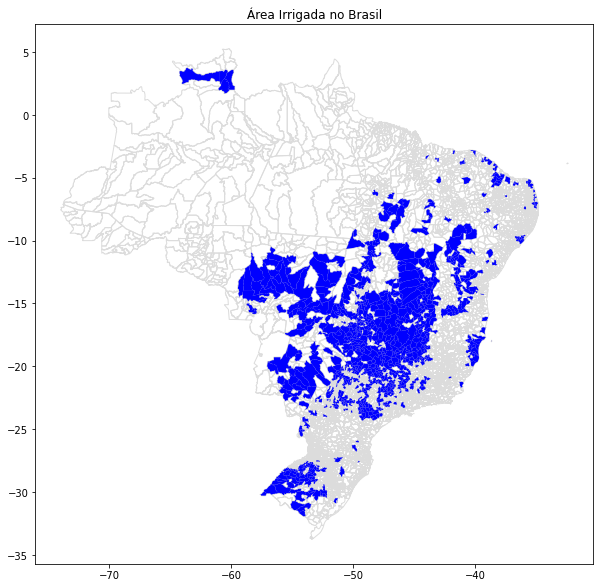

In [99]:
ax = data_brasil.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=0.5)
ax.set_title('Área Irrigada no Brasil')

data_irrig.plot(figsize = (10,10), color = 'b', ax=ax)

In [39]:
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

In [108]:
areas_irrigacao = []


for i in irrigacao['features']:
    s = shape(i['geometry'])
    proj = partial(pyproj.transform, pyproj.Proj('epsg:4326'),
                   pyproj.Proj('epsg:3857'))
    
        
    s_new = transform(proj, s)

    areas_irrigacao.append(transform(proj, s).area)

In [100]:
areas_brasil = []


for i in brasil['features']:
    s = shape(i['geometry'])
    proj = partial(pyproj.transform, pyproj.Proj('epsg:4326'),
                   pyproj.Proj('epsg:3857'))
    
        
    s_new = transform(proj, s)

    areas_brasil.append(transform(proj, s).area)

### 1 - Quantas cidades têm área irrigada?

In [105]:
print(f"Existem {len(irrigacao['features'])} cidades com áreas irrigadas.")

Existem 965 cidades com áreas irrigadas.


### 2 - Qual a cidade brasileira com a maior área irrigada?

In [103]:
m = max([u['properties']['CONJUNTURA_RHBSNIRH_AREAMUNIRRIGADAPIVOPIVO_NU_AREAHA'] for u in irrigacao['features']])

m = 0
city = ''

for i in irrigacao['features']:
    if i['properties']['CONJUNTURA_RHBSNIRH_AREAMUNIRRIGADAPIVOPIVO_NU_AREAHA'] > m:
        city = i['properties']["CONJUNTURA_RHBSNIRH_MUNICIPIO2013NM_MUNICIP"]
        m = i['properties']['CONJUNTURA_RHBSNIRH_AREAMUNIRRIGADAPIVOPIVO_NU_AREAHA']

print(f"A cidade com maior área irrigada é {city} com {m}ha.")

A cidade com maior área irrigada é UNAÍ com 61151.2736485ha.


### 3 - Qual área total irrigada do brasil?

In [104]:
s = sum([u['properties']['CONJUNTURA_RHBSNIRH_AREAMUNIRRIGADAPIVOPIVO_NU_AREAHA'] for u in irrigacao['features']])

print(f"{s}ha de área irrigada.")

1274538.9444586607ha de área irrigada.


### 4 - Qual a cidade com maior proporção de área irrigada?

In [130]:
c = 0
maxi = 0
city = ''

for i in irrigacao['features']:
    v = i['properties']['CONJUNTURA_RHBSNIRH_AREAMUNIRRIGADAPIVOPIVO_NU_AREAHA'] / (areas_irrigacao[c] / 10000)
    c += 1
    
    if maxi < v:
        maxi = v
        city = i['properties']["CONJUNTURA_RHBSNIRH_MUNICIPIO2013NM_MUNICIP"]

print(f"A cidade com maior proporção de área irrigada é {city} com {maxi * 100}%.")

A cidade com maior proporção de área irrigada é MUCUGÊ com 10.106790589762227%.


### 5 - Proporção de área irrigada do Brasil?

In [128]:
s = sum([u['properties']['CONJUNTURA_RHBSNIRH_AREAMUNIRRIGADAPIVOPIVO_NU_AREAHA'] for u in irrigacao['features']]) / (sum(areas_brasil) / 10000)

print(f"A proporção de áreas irrigadas do Brasil é de {s * 100}%")

print(sum(areas_brasil) / 10000)

A proporção de áreas irrigadas do Brasil é de 0.08418260795262081%
1514016939.4324179
